In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%reload_ext autoreload
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
import sys
from ipywidgets import interactive, FloatSlider, interact, fixed
from divtel import *
from adjustText import adjust_text

import copy
import astropy.units as u
from astropy.coordinates import SkyCoord

from astroplan.plots import plot_sky
from astroplan import FixedTarget
#from . import utils
#from .const import COLORS
#from . import pointing

from matplotlib.transforms import Affine2D
from astropy.visualization.wcsaxes import SphericalCircle

import healpy as hp
import tqdm

#!jupyter labextension install @jupyter-widgets/jupyterlab-manager

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## LOAD CTA CONFIG

In [3]:
cta = CTA_Info('south')

Observer         :  CTA South
Location         :  Paranal , (1946.635798, -5467.63394562, -2642.49852123) km
Observation time :  2025-02-25T11:01:36.690


In [4]:
array_MST = LoadConfig("/Users/macbook/divtel/Paranal_Only_MST.txt", frame=cta)

In [5]:

array_SST = LoadConfig("/Users/macbook/divtel/Paranal_Only_SST.txt", frame=cta)

In [6]:
array_MST.table.units = "deg"
array_MST.table
array_SST.table.units ="deg"

In [7]:
def compute_center_of_gravity(group):
    x, y, z = group['x'], group['y'], group['z']
    cog_x = round(np.mean(x),2)
    cog_y = round(np.mean(y),2)
    cog_z = round(np.mean(z),2)
    return cog_x, cog_y, cog_z

# Function to create new telescope list with center of gravity
def create_new_group_list(tel_group):
    new_telescopes = []
    for group in tel_group.groups:
        print(tel_group.groups)
        print (group['focal'][0],round(group['radius'][0],2))
        #id_ = group["id"][0]
        cog = compute_center_of_gravity(group)
        focal, fov = group['focal'][0], round(group['radius'][0],2)  # Assuming same within a group
        new_telescopes.append([*cog, focal, fov])
    return new_telescopes


In [8]:
array_MST.table

<Table length=14>
  id     x       y       z       az   ...   p_x     p_y     p_z    d_tel 
         m       m       m      deg   ...                            m   
int64 float64 float64 float64 float64 ... float64 float64 float64 float64
----- ------- ------- ------- ------- ... ------- ------- ------- -------
    1     0.0     0.0    24.0   0.000 ...   1.000  -0.000   0.000   22.65
    2     0.0   151.0    25.0   0.000 ...   1.000  -0.000   0.000  152.67
    3     0.0  -151.0    31.0   0.000 ...   1.000  -0.000   0.000  152.68
    4   150.0    75.0    21.0   0.000 ...   1.000  -0.000   0.000  188.09
    5   150.0   -75.0    26.0   0.000 ...   1.000  -0.000   0.000  187.98
    6   150.0   240.0    24.0   0.000 ...   1.000  -0.000   0.000  295.50
    7   150.0  -240.0    30.0   0.000 ...   1.000  -0.000   0.000  295.49
    8   313.0     0.0    19.0   0.000 ...   1.000  -0.000   0.000  335.47
    9  -150.0   -75.0    28.0   0.000 ...   1.000  -0.000   0.000  148.05
   10  -150.0    75.0    28.0   0.000 ...   1.000  -0.000   0.000  148.05
   11  -150.0  -240.0    38.5   0.000 ...   1.000  -0.000   0.000  272.05
   12  -150.0   240.0    27.0   0.000 ...   1.000  -0.000   0.000  271.83
   13  -313.0  -162.0    35.0   0.000 ...   1.000  -0.000   0.000  332.82
   14  -313.0   162.0    30.5   0.000 ...   1.000  -0.000   0.000  332.75

In [9]:
array_SST.table

<Table length=46>
  id     x       y       z       az   ...   p_x     p_y     p_z    d_tel 
         m       m       m      deg   ...                            m   
int64 float64 float64 float64 float64 ... float64 float64 float64 float64
----- ------- ------- ------- ------- ... ------- ------- ------- -------
    1   199.0     0.0   16.25   0.000 ...   1.000  -0.000   0.000  200.19
    2  -230.0     0.0   22.75   0.000 ...   1.000  -0.000   0.000  229.36
    3  -249.0  -325.0   40.75   0.000 ...   1.000  -0.000   0.000  409.12
    4  -249.0   325.0   17.25   0.000 ...   1.000  -0.000   0.000  409.16
    5  -249.0  -577.0   54.25   0.000 ...   1.000  -0.000   0.000  628.62
    6  -249.0   577.0    8.25   0.000 ...   1.000  -0.000   0.000  628.51
    7  -220.0  -797.0   68.25   0.000 ...   1.000  -0.000   0.000  827.51
    8  -220.0   797.0   10.25   0.000 ...   1.000  -0.000   0.000  826.84
    9     0.0  -499.0   39.75   0.000 ...   1.000  -0.000   0.000  499.10
  ...     ...     ...     ...     ... ...     ...     ...     ...     ...
   38   748.0   367.0    6.25   0.000 ...   1.000  -0.000   0.000  834.17
   39   816.0  -648.0   41.25   0.000 ...   1.000  -0.000   0.000 1042.64
   40   816.0   648.0   18.75   0.000 ...   1.000  -0.000   0.000 1042.63
   41     0.0  -950.0   75.25   0.000 ...   1.000  -0.000   0.000  951.09
   42     0.0   950.0   28.25   0.000 ...   1.000  -0.000   0.000  950.00
   43  -955.0  -199.0   39.25   0.000 ...   1.000  -0.000   0.000  974.84
   44  -955.0   199.0   22.75   0.000 ...   1.000  -0.000   0.000  974.81
   45   955.0  -199.0    7.75   0.000 ...   1.000  -0.000   0.000  976.48
   46   955.0   199.0    5.25   0.000 ...   1.000  -0.000   0.000  976.54

## Choosing the different configurations

In [10]:
sub_groups_MST={'1':[3,4,7], 
            '2': [1,9,12,14],
            '3': [10,11,13], 
             '4': [2,6,8,5]}
sub_groups_SST = {'1':[24,12,30,42,8,18], 
             '2':[44,32,34],
              '3':[43,33,35],
              '4':[23,41,29,11,7,17],
              '5':[37,39,45],
              '6':[38,40,46],
              '7':[1,2,9,10],
              '8':[16,26,28],
              '9':[15,25,27],
              '10':[13,14,36],
              '11':[5,19,21],
              '12':[6,20,22],
              '13':[3,4,31]}



In [11]:
tel_group, labels, number_of_telescopes_subarray_1 =array_MST.group_by(sub_groups_MST)

In [12]:
tel_group_SST, labels_SST, number_of_telescopes_config_SST =array_SST.group_by(sub_groups_SST)

In [13]:
new_telescopes = create_new_group_list(tel_group)

<TableGroups indices=[ 0  3  7 10 14]>
16.0 3.85
<TableGroups indices=[ 0  3  7 10 14]>
16.0 3.85
<TableGroups indices=[ 0  3  7 10 14]>
16.0 3.85
<TableGroups indices=[ 0  3  7 10 14]>
16.0 3.85


In [14]:
new_telescopes_SST = create_new_group_list(tel_group_SST)

<TableGroups indices=[ 0  6  9 12 18 21 24 28 31 34 37 40 43 46]>
5.6 4.45
<TableGroups indices=[ 0  6  9 12 18 21 24 28 31 34 37 40 43 46]>
5.6 4.45
<TableGroups indices=[ 0  6  9 12 18 21 24 28 31 34 37 40 43 46]>
5.6 4.45
<TableGroups indices=[ 0  6  9 12 18 21 24 28 31 34 37 40 43 46]>
5.6 4.45
<TableGroups indices=[ 0  6  9 12 18 21 24 28 31 34 37 40 43 46]>
5.6 4.45
<TableGroups indices=[ 0  6  9 12 18 21 24 28 31 34 37 40 43 46]>
5.6 4.45
<TableGroups indices=[ 0  6  9 12 18 21 24 28 31 34 37 40 43 46]>
5.6 4.45
<TableGroups indices=[ 0  6  9 12 18 21 24 28 31 34 37 40 43 46]>
5.6 4.45
<TableGroups indices=[ 0  6  9 12 18 21 24 28 31 34 37 40 43 46]>
5.6 4.45
<TableGroups indices=[ 0  6  9 12 18 21 24 28 31 34 37 40 43 46]>
5.6 4.45
<TableGroups indices=[ 0  6  9 12 18 21 24 28 31 34 37 40 43 46]>
5.6 4.45
<TableGroups indices=[ 0  6  9 12 18 21 24 28 31 34 37 40 43 46]>
5.6 4.45
<TableGroups indices=[ 0  6  9 12 18 21 24 28 31 34 37 40 43 46]>
5.6 4.45


In [15]:
for telescope in new_telescopes:
    print(telescope)

[100.0, -105.33, 27.33, 16.0, 3.85]
[-153.25, 81.75, 27.38, 16.0, 3.85]
[-204.33, -109.0, 33.83, 16.0, 3.85]
[153.25, 79.0, 23.5, 16.0, 3.85]


In [16]:
for telescope in new_telescopes_SST:
    print(telescope)

[0.0, 816.83, 21.83, 5.6, 4.45]
[-840.0, 404.67, 16.75, 5.6, 4.45]
[-840.0, -404.67, 55.92, 5.6, 4.45]
[0.0, -816.83, 65.42, 5.6, 4.45]
[839.67, -404.67, 17.75, 5.6, 4.45]
[839.67, 404.67, 10.08, 5.6, 4.45]
[-7.75, 0.0, 22.5, 5.6, 4.45]
[415.67, 402.0, 12.42, 5.6, 4.45]
[415.67, -402.0, 27.92, 5.6, 4.45]
[429.33, 0.0, 16.08, 5.6, 4.45]
[-415.67, -402.0, 48.25, 5.6, 4.45]
[-415.67, 402.0, 15.58, 5.6, 4.45]
[-429.67, 0.0, 29.42, 5.6, 4.45]


In [17]:
# Define the file path where you want to save the output
output_file_path = './best_configuration_MST.txt'

# Open the file in write mode
with open(output_file_path, 'w') as file:
    
    # Write a header
    #file.write("Group ID, X_Center, Y_Center, Z_Center, Focal Length, FOV\n")
    
    # Loop through all new telescopes (grouped telescopes)
    for i, telescope in enumerate(new_telescopes):
        # Assuming telescope is a list like [x_center, y_center, z_center, focal_length, fov]
        values = ' '.join(map(str, telescope))  # Convert all elements to string
        # Write the data to the file
        #print(values)
        file.write(f"{values}\n")

print(f"New telescope data has been written to {output_file_path}")


New telescope data has been written to ./best_configuration_MST.txt


In [18]:
# Define the file path where you want to save the output
output_file_path = './best_configuration_SST.txt'

# Open the file in write mode
with open(output_file_path, 'w') as file:
    
    # Write a header
    #file.write("Group ID, X_Center, Y_Center, Z_Center, Focal Length, FOV\n")
    
    # Loop through all new telescopes (grouped telescopes)
    for i, telescope in enumerate(new_telescopes_SST):
        # Assuming telescope is a list like [x_center, y_center, z_center, focal_length, fov]
        values = ' '.join(map(str, telescope))  # Convert all elements to string
        # Write the data to the file
        #print(values)
        file.write(f"{values}\n")

print(f"New telescope data has been written to {output_file_path}")


New telescope data has been written to ./best_configuration_SST.txt


In [25]:
config_MST = LoadConfig("/Users/macbook/divtel/best_configuration_MST.txt", frame=cta)
config_SST = LoadConfig("/Users/macbook/divtel/best_configuration_SST.txt", frame=cta)
full_array_config_SST = LoadConfig("/Users/macbook/divtel/best_configuration_SST.txt", frame=cta)

In [26]:
config_MST.table.units= "deg"

In [27]:
config_MST.table

<Table length=4>
  id     x       y       z       az   ...   p_x     p_y     p_z    d_tel 
         m       m       m      deg   ...                            m   
int64 float64 float64 float64 float64 ... float64 float64 float64 float64
----- ------- ------- ------- ------- ... ------- ------- ------- -------
    1   100.0 -105.33   27.33   0.000 ...   1.000  -0.000   0.000  156.04
    2 -153.25   81.75   27.38   0.000 ...   1.000  -0.000   0.000  158.82
    3 -204.33  -109.0   33.83   0.000 ...   1.000  -0.000   0.000  202.35
    4  153.25    79.0    23.5   0.000 ...   1.000  -0.000   0.000  201.79

In [28]:
config_SST.table.units = "deg"

In [29]:
config_SST.table

<Table length=13>
  id     x       y       z       az   ...   p_x     p_y     p_z    d_tel 
         m       m       m      deg   ...                            m   
int64 float64 float64 float64 float64 ... float64 float64 float64 float64
----- ------- ------- ------- ------- ... ------- ------- ------- -------
    1     0.0  816.83   21.83   0.000 ...   1.000  -0.000   0.000  816.85
    2  -840.0  404.67   16.75   0.000 ...   1.000  -0.000   0.000  931.85
    3  -840.0 -404.67   55.92   0.000 ...   1.000  -0.000   0.000  932.21
    4     0.0 -816.83   65.42   0.000 ...   1.000  -0.000   0.000  817.70
    5  839.67 -404.67   17.75   0.000 ...   1.000  -0.000   0.000  932.76
    6  839.67  404.67   10.08   0.000 ...   1.000  -0.000   0.000  932.87
    7   -7.75     0.0    22.5   0.000 ...   1.000  -0.000   0.000    8.77
    8  415.67   402.0   12.42   0.000 ...   1.000  -0.000   0.000  578.95
    9  415.67  -402.0   27.92   0.000 ...   1.000  -0.000   0.000  578.74
   10  429.33     0.0   16.08   0.000 ...   1.000  -0.000   0.000  430.16
   11 -415.67  -402.0   48.25   0.000 ...   1.000  -0.000   0.000  578.14
   12 -415.67   402.0   15.58   0.000 ...   1.000  -0.000   0.000  577.90
   13 -429.67     0.0   29.42   0.000 ...   1.000  -0.000   0.000  429.00

In [30]:
div_stop=[]

div_stop=np.linspace(0,0.03, 10)


In [27]:
FoV_array_MST=[]#This will be the one without saturation
multiplicity_array_MST=[] #This will be the one without saturation

for div in div_stop:
    config_MST.divergent_pointing(div, az=0,alt=70)    
    FoV_array_MST=config_MST.hFoV(subarray_mult=number_of_telescopes_subarray_1)[0]
    multiplicity_array_MST=config_MST.hFoV(subarray_mult=number_of_telescopes_subarray_1)[1]



4it [00:00,  6.44it/s]
4it [00:00,  7.45it/s]
4it [00:00,  7.33it/s]
4it [00:00,  7.19it/s]
4it [00:00,  7.41it/s]
4it [00:00,  7.68it/s]
4it [00:00,  7.56it/s]
4it [00:00,  7.53it/s]
4it [00:00,  7.31it/s]
4it [00:00,  7.31it/s]
4it [00:00,  7.49it/s]
4it [00:00,  7.40it/s]
4it [00:00,  7.46it/s]
4it [00:00,  7.43it/s]
4it [00:00,  7.59it/s]
4it [00:00,  7.29it/s]
4it [00:00,  7.54it/s]
4it [00:00,  7.42it/s]
4it [00:00,  7.36it/s]
4it [00:00,  7.48it/s]


In [28]:
FoV_array_SST=[]#This will be the one without saturation
multiplicity_array_SST=[] #This will be the one without saturation

for div in div_stop:
    config_SST.divergent_pointing(div, az=0,alt=70)    
    FoV_array_SST=config_SST.hFoV(subarray_mult=number_of_telescopes_config_SST)[0]
    multiplicity_array_SST=config_SST.hFoV(subarray_mult=number_of_telescopes_config_SST)[1]


13it [00:01,  7.26it/s]
13it [00:01,  7.43it/s]
13it [00:01,  7.44it/s]
13it [00:01,  7.32it/s]
13it [00:01,  7.48it/s]
13it [00:01,  7.45it/s]
13it [00:01,  7.42it/s]
13it [00:01,  7.49it/s]
13it [00:01,  7.49it/s]
13it [00:01,  7.52it/s]
13it [00:01,  7.52it/s]
13it [00:01,  7.40it/s]
13it [00:01,  7.54it/s]
13it [00:01,  7.53it/s]
13it [00:01,  7.51it/s]
13it [00:01,  7.43it/s]
13it [00:01,  7.02it/s]
13it [00:01,  7.43it/s]
13it [00:01,  7.39it/s]
13it [00:01,  7.38it/s]


4it [00:00,  7.28it/s]
4it [00:00,  6.96it/s]


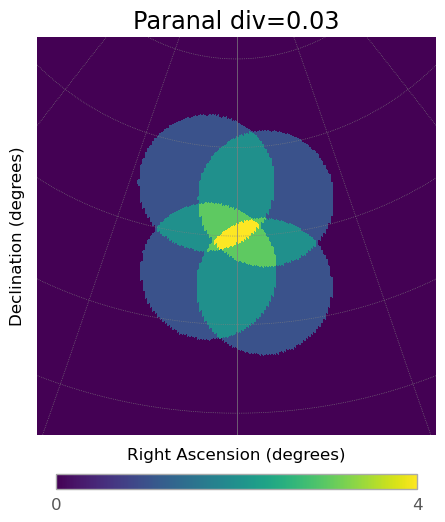

In [29]:
config_MST.multiplicity_plot()

In [31]:
table_SST_conv = []
table_SST= config_SST.table
number_of_telescopes_config_SST_first_half=[]
# Append the columns for LST so I know what to get or expect
table_SST_conv.append(table_SST['x'])
table_SST_conv.append(table_SST['y'])
table_SST_conv.append(table_SST['z'])
table_SST_conv.append(table_SST['focal'])
table_SST_conv.append(table_SST['radius'])
table_SST_conv.append(table_SST['fov'])

# Initialize sub_config and other variables
sub_config = []
telescopes = [1, 2,3,4,5,6]  # Telescope indices
# Loop through the telescopes so I can write them in a file
for tel in telescopes:
    # Putting it tel-1 because the first column we had the index
    sub_config.append([col[tel - 1] for col in table_SST_conv])
    number_of_telescopes_config_SST_first_half.append(number_of_telescopes_config_SST[tel-1])


# Print the result for verification
print(sub_config)
print(number_of_telescopes_config_SST_first_half)

[[0.0, 816.83, 21.83, 5.6, 4.450000000000001, 62.46242685852285], [-840.0, 404.67, 16.75, 5.6, 4.450000000000001, 62.46242685852285], [-840.0, -404.67, 55.92, 5.6, 4.450000000000001, 62.46242685852285], [0.0, -816.83, 65.42, 5.6, 4.450000000000001, 62.46242685852285], [839.67, -404.67, 17.75, 5.6, 4.450000000000001, 62.46242685852285], [839.67, 404.67, 10.08, 5.6, 4.450000000000001, 62.46242685852285]]
[6, 3, 3, 6, 3, 3]


In [32]:
table_SST_div = []
table_SST= config_SST.table
number_of_telescopes_config_SST_second_half=[]
# Append the columns for LST so I know what to get or expect
table_SST_div.append(table_SST['x'])
table_SST_div.append(table_SST['y'])
table_SST_div.append(table_SST['z'])
table_SST_div.append(table_SST['focal'])
table_SST_div.append(table_SST['radius'])
table_SST_div.append(table_SST['fov'])

# Initialize sub_config and other variables
sub_config_div= []
telescopes = [7,8,9,10,11,12,13]  # Telescope indices
# Loop through the telescopes so I can write them in a file
for tel in telescopes:
    # Adjust for 1-based indexing in telescopes to 0-based indexing in Python
    sub_config_div.append([col[tel - 1] for col in table_SST_div])
    number_of_telescopes_config_SST_second_half.append(number_of_telescopes_config_SST[tel-1])


# Print the result for verification
print(sub_config_div)
print(number_of_telescopes_config_SST_second_half)

[[-7.75, 0.0, 22.5, 5.6, 4.450000000000001, 62.46242685852285], [415.67, 402.0, 12.42, 5.6, 4.450000000000001, 62.46242685852285], [415.67, -402.0, 27.92, 5.6, 4.450000000000001, 62.46242685852285], [429.33, 0.0, 16.08, 5.6, 4.450000000000001, 62.46242685852285], [-415.67, -402.0, 48.25, 5.6, 4.450000000000001, 62.46242685852285], [-415.67, 402.0, 15.58, 5.6, 4.450000000000001, 62.46242685852285], [-429.67, 0.0, 29.42, 5.6, 4.450000000000001, 62.46242685852285]]
[4, 3, 3, 3, 3, 3, 3]


In [33]:
# Define the file path where you want to save the output
output_file_path_3 = './best_SST_conv.txt'

# Open the file in write mode
with open(output_file_path_3, 'w') as file:
    
    # Write a header
    #file.write("Group ID, X_Center, Y_Center, Z_Center, Focal Length, FOV\n")
    
    # Loop through all new telescopes (grouped telescopes)
   for telescope in sub_config:
        # Assuming each telescope in sub_config is a list like [x_center, y_center, z_center, focal_length, fov]
        values = ' '.join(map(str, telescope))  # Convert all elements to string
        file.write(f"{values}\n")  # Write each row of telescope data

print(f"New telescope data has been written to {output_file_path_3}")
# Define the file path where you want to save the output
output_file_path_4 = './best_SST_div.txt'

# Open the file in write mode
with open(output_file_path_4, 'w') as file:
    
    # Write a header
    #file.write("Group ID, X_Center, Y_Center, Z_Center, Focal Length, FOV\n")
    
    # Loop through all new telescopes (grouped telescopes)
   for telescope in sub_config_div:
        # Assuming each telescope in sub_config is a list like [x_center, y_center, z_center, focal_length, fov]
        values = ' '.join(map(str, telescope))  # Convert all elements to string
        file.write(f"{values}\n")  # Write each row of telescope data

print(f"New telescope data has been written to {output_file_path_4}")

New telescope data has been written to ./best_SST_conv.txt
New telescope data has been written to ./best_SST_div.txt


In [34]:
SST_config_conv= LoadConfig('./best_SST_conv.txt', frame=cta, pointing2src=True)
SST_config_div=LoadConfig('./best_SST_div.txt', frame=cta, pointing2src=True)

In [35]:
SST_config_conv.table.units= "deg"
SST_config_div.table.units= "deg"

In [36]:
SST_config_conv.table

<Table length=6>
  id     x       y       z       az   ...   p_x     p_y     p_z    d_tel 
         m       m       m      deg   ...                            m   
int64 float64 float64 float64 float64 ... float64 float64 float64 float64
----- ------- ------- ------- ------- ... ------- ------- ------- -------
    1     0.0  816.83   21.83   0.000 ...   1.000  -0.000   0.000  816.88
    2  -840.0  404.67   16.75   0.000 ...   1.000  -0.000   0.000  932.41
    3  -840.0 -404.67   55.92   0.000 ...   1.000  -0.000   0.000  932.62
    4     0.0 -816.83   65.42   0.000 ...   1.000  -0.000   0.000  817.54
    5  839.67 -404.67   17.75   0.000 ...   1.000  -0.000   0.000  932.29
    6  839.67  404.67   10.08   0.000 ...   1.000  -0.000   0.000  932.44

In [37]:
SST_config_div.table

<Table length=7>
  id     x       y       z       az   ...   p_x     p_y     p_z    d_tel 
         m       m       m      deg   ...                            m   
int64 float64 float64 float64 float64 ... float64 float64 float64 float64
----- ------- ------- ------- ------- ... ------- ------- ------- -------
    1   -7.75     0.0    22.5   0.000 ...   1.000  -0.000   0.000    6.92
    2  415.67   402.0   12.42   0.000 ...   1.000  -0.000   0.000  579.22
    3  415.67  -402.0   27.92   0.000 ...   1.000  -0.000   0.000  579.10
    4  429.33     0.0   16.08   0.000 ...   1.000  -0.000   0.000  430.57
    5 -415.67  -402.0   48.25   0.000 ...   1.000  -0.000   0.000  577.91
    6 -415.67   402.0   15.58   0.000 ...   1.000  -0.000   0.000  577.50
    7 -429.67     0.0   29.42   0.000 ...   1.000  -0.000   0.000  428.54

the barycenter for the calculations[-0.67307692  0.         27.68615385]
the barycenter for the calculations of the second divergence[-0.67307692  0.         27.68615385]


6it [00:00,  6.20it/s]
7it [00:01,  6.01it/s]
6it [00:01,  5.99it/s]


12.639706828454463


7it [00:01,  6.86it/s]


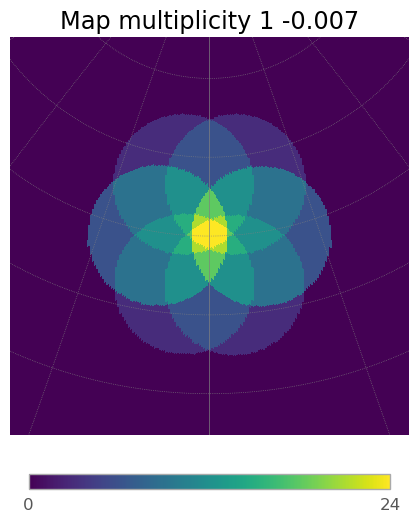

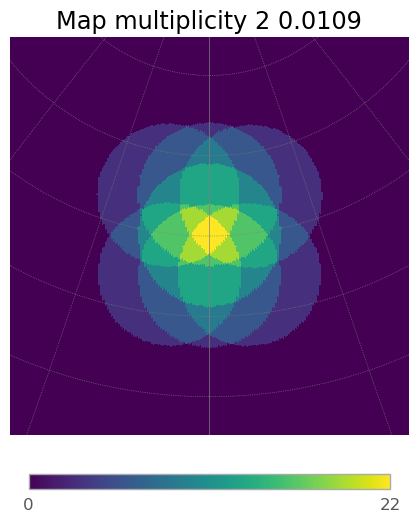

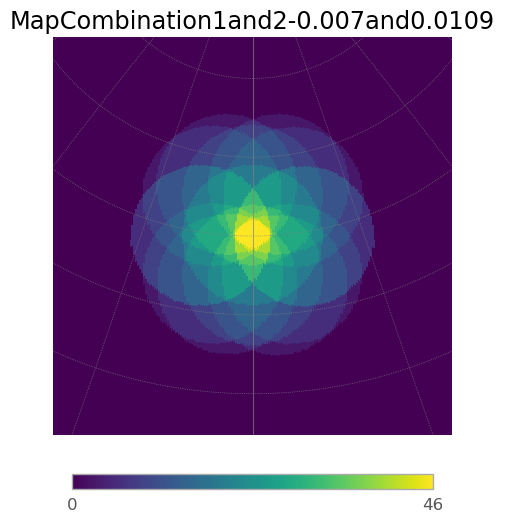

In [39]:
SST_config_conv.divergent_pointing_2_div(tel_group_2=SST_config_div, complete_array=full_array_config_SST, div1=-0.007, div2=0.0109, az=0, alt=70)
SST_config_conv.multiplicity_plot_2_div(SST_config_div, subarray_mult_1=number_of_telescopes_config_SST_first_half, subarray_mult_2=number_of_telescopes_config_SST_second_half)


In [38]:
SST_config_conv.hFoV_for_2_arrays(array_2=SST_config_div, subarray_mult=number_of_telescopes_config_SST_first_half, subarray_mult_2=number_of_telescopes_config_SST_second_half)

6it [00:00,  6.94it/s]
7it [00:00,  7.28it/s]


(189.95575704505862, 15.055298584742838)

6it [00:00,  7.29it/s]
7it [00:00,  7.25it/s]
4it [00:00,  7.40it/s]
6it [00:00,  7.18it/s]


12.725284863839338


7it [00:00,  7.17it/s]
4it [00:00,  7.40it/s]


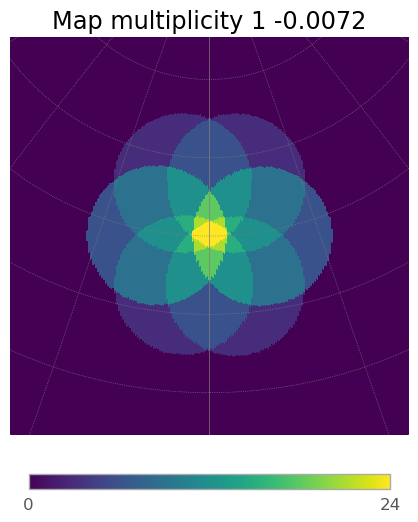

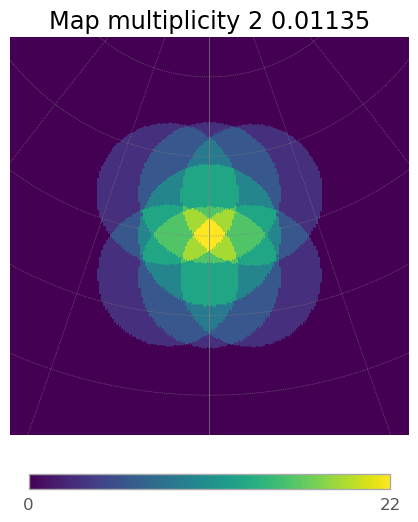

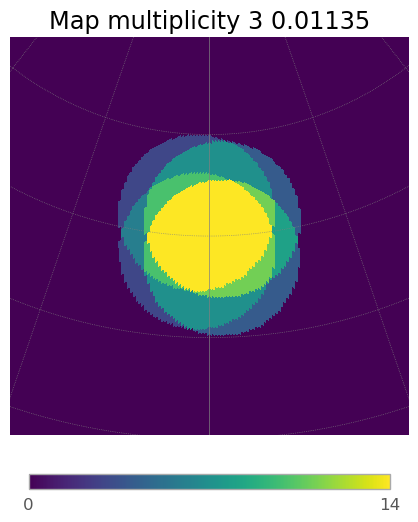

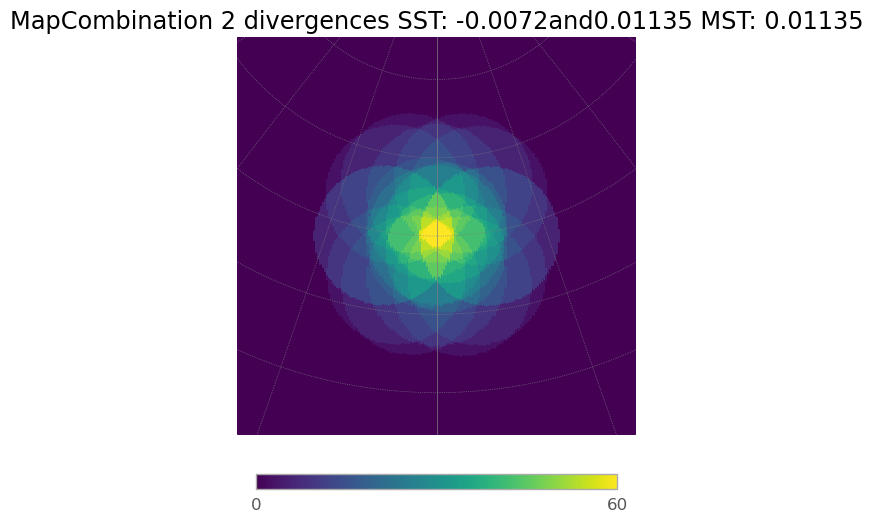

In [48]:
SST_config_conv.multiplicity_plot_3_config(array_2=SST_config_div,array_3=config_MST, subarray_mult_1=number_of_telescopes_config_SST_first_half, subarray_mult_2=number_of_telescopes_config_SST_second_half, subarray_mult_3= number_of_telescopes_subarray_1)




In [40]:
SST_config_conv.combiantion_of_FoV(number_of_arrays=3, array_2=SST_config_div, array_3=config_MST, subarray_mult_1=number_of_telescopes_config_SST_first_half, subarray_mult_2=number_of_telescopes_config_SST_second_half, subarray_mult_3=number_of_telescopes_subarray_1)

6it [00:00,  7.05it/s]
7it [00:00,  7.41it/s]
4it [00:00,  7.37it/s]


(189.95575704505862, 18.48629616845012)

In [ ]:
#From the table the ones to use for the array MST
#    0.0022
#    0.0043
#    0.008
#    0.01135
#    0.01453
# FOR THE SST the idea is to use 
#0.0022, 
#0.0043, 
#0.008, 
#0.01135, 
#0.013
#AND FOR THE CONVERGENCE TO USE: THIS WERE CALCULATED IN ORDER TO HAVE THE SAME HFOV AT THE CENTER FOR DIV AND CONV
#-0.0013434343434343427,
# -0.0026343434343434335,
# -0.005001010101010101,
# -0.007224242424242425,
# -0.0083]
#
#
#

In [62]:
div_MST=[0.0022,0.0043, 0.008, 0.01135, 0.01453]
divergence_list=[]
div_SST=np.linspace(0.001,0.014, 150)
for divergence in div_MST:
    for divergence_SST in div_SST:
        print(f" the div{divergence_SST}")
        config_MST.divergent_pointing(div=divergence, az=0, alt=70)
        hFoV_to_stop=config_MST.hFoV(m_cut=13, subarray_mult=number_of_telescopes_subarray_1 )[0]
        SST_config_div.divergent_pointing(div=divergence_SST, az=0, alt=70)
        print(f" the stop{round(hFoV_to_stop)}")
        hFoV_div=SST_config_div.hFoV(subarray_mult=number_of_telescopes_config_SST_second_half,m_cut=21)[0]
        print(f" the div h FoV {round(hFoV_div)}")
        if round(hFoV_div) == round(hFoV_to_stop):
            divergence_list.append(divergence_SST)
            print(f"stop, the {divergence_SST}")
            break 

 the div0.001


4it [00:00,  6.76it/s]


 the stop42


7it [00:00,  7.42it/s]


 the div h FoV 54
 the div0.001087248322147651


4it [00:00,  7.39it/s]


 the stop42


7it [00:00,  7.28it/s]


 the div h FoV 54
 the div0.0011744966442953021


4it [00:00,  7.06it/s]


 the stop42


7it [00:00,  7.41it/s]


 the div h FoV 53
 the div0.001261744966442953


4it [00:00,  7.43it/s]


 the stop42


7it [00:00,  7.35it/s]


 the div h FoV 52
 the div0.001348993288590604


4it [00:00,  7.35it/s]


 the stop42


7it [00:00,  7.29it/s]


 the div h FoV 52
 the div0.001436241610738255


4it [00:00,  5.31it/s]


 the stop42


7it [00:00,  7.20it/s]


 the div h FoV 51
 the div0.0015234899328859062


4it [00:00,  7.44it/s]


 the stop42


7it [00:00,  7.28it/s]


 the div h FoV 50
 the div0.0016107382550335572


4it [00:00,  7.19it/s]


 the stop42


7it [00:00,  7.06it/s]


 the div h FoV 50
 the div0.001697986577181208


4it [00:00,  7.32it/s]


 the stop42


7it [00:00,  7.21it/s]


 the div h FoV 49
 the div0.0017852348993288593


4it [00:00,  7.27it/s]


 the stop42


7it [00:00,  7.35it/s]


 the div h FoV 48
 the div0.0018724832214765102


4it [00:00,  7.35it/s]


 the stop42


7it [00:00,  7.35it/s]


 the div h FoV 48
 the div0.0019597315436241615


4it [00:00,  7.51it/s]


 the stop42


7it [00:00,  7.43it/s]


 the div h FoV 47
 the div0.0020469798657718123


4it [00:00,  7.47it/s]


 the stop42


7it [00:00,  7.45it/s]


 the div h FoV 47
 the div0.002134228187919463


4it [00:00,  7.34it/s]


 the stop42


7it [00:00,  7.41it/s]


 the div h FoV 46
 the div0.0022214765100671144


4it [00:00,  7.35it/s]


 the stop42


7it [00:00,  7.45it/s]


 the div h FoV 45
 the div0.0023087248322147653


4it [00:00,  7.48it/s]


 the stop42


7it [00:00,  7.48it/s]


 the div h FoV 45
 the div0.002395973154362416


4it [00:00,  7.32it/s]


 the stop42


7it [00:00,  7.46it/s]


 the div h FoV 44
 the div0.0024832214765100674


4it [00:00,  7.37it/s]


 the stop42


7it [00:00,  7.53it/s]


 the div h FoV 43
 the div0.0025704697986577187


4it [00:00,  7.28it/s]


 the stop42


7it [00:00,  7.36it/s]


 the div h FoV 43
 the div0.002657718120805369


4it [00:00,  7.13it/s]


 the stop42


7it [00:00,  7.50it/s]


 the div h FoV 42
stop, the 0.002657718120805369
 the div0.001


4it [00:00,  7.16it/s]


 the stop38


7it [00:00,  7.36it/s]


 the div h FoV 54
 the div0.001087248322147651


4it [00:00,  7.54it/s]


 the stop38


7it [00:00,  7.41it/s]


 the div h FoV 54
 the div0.0011744966442953021


4it [00:00,  7.24it/s]


 the stop38


7it [00:00,  7.40it/s]


 the div h FoV 53
 the div0.001261744966442953


4it [00:00,  7.46it/s]


 the stop38


7it [00:00,  7.36it/s]


 the div h FoV 52
 the div0.001348993288590604


4it [00:00,  6.03it/s]


 the stop38


7it [00:00,  7.23it/s]


 the div h FoV 52
 the div0.001436241610738255


4it [00:00,  7.03it/s]


 the stop38


7it [00:00,  7.32it/s]


 the div h FoV 51
 the div0.0015234899328859062


4it [00:00,  7.27it/s]


 the stop38


7it [00:00,  7.41it/s]


 the div h FoV 50
 the div0.0016107382550335572


4it [00:00,  7.32it/s]


 the stop38


7it [00:00,  7.23it/s]


 the div h FoV 50
 the div0.001697986577181208


4it [00:00,  7.01it/s]


 the stop38


7it [00:00,  7.00it/s]


 the div h FoV 49
 the div0.0017852348993288593


4it [00:00,  6.89it/s]


 the stop38


7it [00:00,  7.23it/s]


 the div h FoV 48
 the div0.0018724832214765102


4it [00:00,  7.01it/s]


 the stop38


7it [00:00,  7.32it/s]


 the div h FoV 48
 the div0.0019597315436241615


4it [00:00,  7.10it/s]


 the stop38


7it [00:00,  7.02it/s]


 the div h FoV 47
 the div0.0020469798657718123


4it [00:00,  7.14it/s]


 the stop38


7it [00:00,  7.24it/s]


 the div h FoV 47
 the div0.002134228187919463


4it [00:00,  7.31it/s]


 the stop38


7it [00:00,  7.19it/s]


 the div h FoV 46
 the div0.0022214765100671144


4it [00:00,  7.20it/s]


 the stop38


7it [00:00,  7.27it/s]


 the div h FoV 45
 the div0.0023087248322147653


4it [00:00,  7.23it/s]


 the stop38


7it [00:00,  7.41it/s]


 the div h FoV 45
 the div0.002395973154362416


4it [00:00,  7.45it/s]


 the stop38


7it [00:00,  7.24it/s]


 the div h FoV 44
 the div0.0024832214765100674


4it [00:00,  7.30it/s]


 the stop38


7it [00:00,  7.34it/s]


 the div h FoV 43
 the div0.0025704697986577187


4it [00:00,  7.36it/s]


 the stop38


7it [00:00,  7.36it/s]


 the div h FoV 43
 the div0.002657718120805369


4it [00:00,  7.38it/s]


 the stop38


7it [00:00,  7.39it/s]


 the div h FoV 42
 the div0.0027449664429530203


4it [00:00,  6.66it/s]


 the stop38


7it [00:00,  7.45it/s]


 the div h FoV 42
 the div0.0028322147651006716


4it [00:00,  7.28it/s]


 the stop38


7it [00:00,  7.42it/s]


 the div h FoV 41
 the div0.0029194630872483225


4it [00:00,  7.15it/s]


 the stop38


7it [00:00,  7.34it/s]


 the div h FoV 40
 the div0.0030067114093959733


4it [00:00,  7.25it/s]


 the stop38


7it [00:00,  7.30it/s]


 the div h FoV 40
 the div0.0030939597315436246


4it [00:00,  7.16it/s]


 the stop38


7it [00:00,  7.18it/s]


 the div h FoV 39
 the div0.0031812080536912754


4it [00:00,  7.34it/s]


 the stop38


7it [00:00,  7.30it/s]


 the div h FoV 39
 the div0.0032684563758389267


4it [00:00,  7.20it/s]


 the stop38


7it [00:00,  7.41it/s]


 the div h FoV 38
stop, the 0.0032684563758389267
 the div0.001


4it [00:00,  7.42it/s]


 the stop31


7it [00:00,  7.07it/s]


 the div h FoV 54
 the div0.001087248322147651


4it [00:00,  7.33it/s]


 the stop31


7it [00:00,  7.35it/s]


 the div h FoV 54
 the div0.0011744966442953021


4it [00:00,  7.40it/s]


 the stop31


7it [00:00,  7.40it/s]


 the div h FoV 53
 the div0.001261744966442953


4it [00:00,  7.45it/s]


 the stop31


7it [00:00,  7.35it/s]


 the div h FoV 52
 the div0.001348993288590604


4it [00:00,  7.31it/s]


 the stop31


7it [00:00,  7.35it/s]


 the div h FoV 52
 the div0.001436241610738255


4it [00:00,  7.38it/s]


 the stop31


7it [00:00,  7.33it/s]


 the div h FoV 51
 the div0.0015234899328859062


4it [00:00,  7.32it/s]


 the stop31


7it [00:00,  7.30it/s]


 the div h FoV 50
 the div0.0016107382550335572


4it [00:00,  7.23it/s]


 the stop31


7it [00:00,  7.06it/s]


 the div h FoV 50
 the div0.001697986577181208


4it [00:00,  5.42it/s]


 the stop31


7it [00:00,  7.31it/s]


 the div h FoV 49
 the div0.0017852348993288593


4it [00:00,  6.65it/s]


 the stop31


7it [00:00,  7.19it/s]


 the div h FoV 48
 the div0.0018724832214765102


4it [00:00,  6.96it/s]


 the stop31


7it [00:00,  7.19it/s]


 the div h FoV 48
 the div0.0019597315436241615


4it [00:00,  7.38it/s]


 the stop31


7it [00:00,  7.37it/s]


 the div h FoV 47
 the div0.0020469798657718123


4it [00:00,  7.17it/s]


 the stop31


7it [00:00,  7.41it/s]


 the div h FoV 47
 the div0.002134228187919463


4it [00:00,  7.26it/s]


 the stop31


7it [00:00,  7.42it/s]


 the div h FoV 46
 the div0.0022214765100671144


4it [00:00,  7.16it/s]


 the stop31


7it [00:00,  7.34it/s]


 the div h FoV 45
 the div0.0023087248322147653


4it [00:00,  7.33it/s]


 the stop31


7it [00:00,  7.41it/s]


 the div h FoV 45
 the div0.002395973154362416


4it [00:00,  7.38it/s]


 the stop31


7it [00:00,  7.31it/s]


 the div h FoV 44
 the div0.0024832214765100674


4it [00:00,  7.39it/s]


 the stop31


7it [00:00,  7.39it/s]


 the div h FoV 43
 the div0.0025704697986577187


4it [00:00,  7.10it/s]


 the stop31


7it [00:00,  7.17it/s]


 the div h FoV 43
 the div0.002657718120805369


4it [00:00,  7.50it/s]


 the stop31


7it [00:00,  7.46it/s]


 the div h FoV 42
 the div0.0027449664429530203


4it [00:00,  7.36it/s]


 the stop31


7it [00:00,  7.35it/s]


 the div h FoV 42
 the div0.0028322147651006716


4it [00:00,  7.40it/s]


 the stop31


7it [00:00,  7.32it/s]


 the div h FoV 41
 the div0.0029194630872483225


4it [00:00,  7.32it/s]


 the stop31


7it [00:00,  7.31it/s]


 the div h FoV 40
 the div0.0030067114093959733


4it [00:00,  7.42it/s]


 the stop31


7it [00:00,  7.50it/s]


 the div h FoV 40
 the div0.0030939597315436246


4it [00:00,  7.23it/s]


 the stop31


7it [00:00,  7.42it/s]


 the div h FoV 39
 the div0.0031812080536912754


4it [00:00,  7.32it/s]


 the stop31


7it [00:01,  6.31it/s]


 the div h FoV 39
 the div0.0032684563758389267


4it [00:00,  7.38it/s]


 the stop31


7it [00:00,  7.45it/s]


 the div h FoV 38
 the div0.0033557046979865775


4it [00:00,  7.24it/s]


 the stop31


7it [00:00,  7.47it/s]


 the div h FoV 37
 the div0.0034429530201342284


4it [00:00,  7.30it/s]


 the stop31


7it [00:00,  7.39it/s]


 the div h FoV 37
 the div0.0035302013422818797


4it [00:00,  7.45it/s]


 the stop31


7it [00:00,  7.34it/s]


 the div h FoV 36
 the div0.0036174496644295305


4it [00:00,  7.51it/s]


 the stop31


7it [00:00,  7.32it/s]


 the div h FoV 36
 the div0.0037046979865771818


4it [00:00,  7.28it/s]


 the stop31


7it [00:00,  7.51it/s]


 the div h FoV 35
 the div0.0037919463087248326


4it [00:00,  7.34it/s]


 the stop31


7it [00:00,  7.45it/s]


 the div h FoV 35
 the div0.0038791946308724835


4it [00:00,  7.50it/s]


 the stop31


7it [00:00,  7.30it/s]


 the div h FoV 34
 the div0.003966442953020135


4it [00:00,  7.17it/s]


 the stop31


7it [00:00,  7.40it/s]


 the div h FoV 34
 the div0.004053691275167786


4it [00:00,  7.41it/s]


 the stop31


7it [00:00,  7.38it/s]


 the div h FoV 33
 the div0.004140939597315436


4it [00:00,  7.44it/s]


 the stop31


7it [00:00,  7.26it/s]


 the div h FoV 33
 the div0.004228187919463088


4it [00:00,  7.23it/s]


 the stop31


7it [00:00,  7.44it/s]


 the div h FoV 32
 the div0.004315436241610739


4it [00:00,  7.42it/s]


 the stop31


7it [00:00,  7.48it/s]


 the div h FoV 31
stop, the 0.004315436241610739
 the div0.001


4it [00:00,  7.43it/s]


 the stop25


7it [00:00,  7.51it/s]


 the div h FoV 54
 the div0.001087248322147651


4it [00:00,  7.42it/s]


 the stop25


7it [00:00,  7.53it/s]


 the div h FoV 54
 the div0.0011744966442953021


4it [00:00,  7.40it/s]


 the stop25


7it [00:00,  7.24it/s]


 the div h FoV 53
 the div0.001261744966442953


4it [00:00,  7.41it/s]


 the stop25


7it [00:00,  7.29it/s]


 the div h FoV 52
 the div0.001348993288590604


4it [00:00,  6.87it/s]


 the stop25


7it [00:00,  7.19it/s]


 the div h FoV 52
 the div0.001436241610738255


4it [00:00,  7.17it/s]


 the stop25


7it [00:00,  7.22it/s]


 the div h FoV 51
 the div0.0015234899328859062


4it [00:00,  7.19it/s]


 the stop25


7it [00:00,  7.41it/s]


 the div h FoV 50
 the div0.0016107382550335572


4it [00:00,  7.34it/s]


 the stop25


7it [00:00,  7.36it/s]


 the div h FoV 50
 the div0.001697986577181208


4it [00:00,  6.97it/s]


 the stop25


7it [00:01,  6.95it/s]


 the div h FoV 49
 the div0.0017852348993288593


4it [00:00,  7.31it/s]


 the stop25


7it [00:00,  7.14it/s]


 the div h FoV 48
 the div0.0018724832214765102


4it [00:00,  7.44it/s]


 the stop25


7it [00:00,  7.39it/s]


 the div h FoV 48
 the div0.0019597315436241615


4it [00:00,  7.19it/s]


 the stop25


7it [00:00,  7.34it/s]


 the div h FoV 47
 the div0.0020469798657718123


4it [00:00,  7.37it/s]


 the stop25


7it [00:00,  7.22it/s]


 the div h FoV 47
 the div0.002134228187919463


4it [00:00,  6.39it/s]


 the stop25


7it [00:01,  6.99it/s]


 the div h FoV 46
 the div0.0022214765100671144


4it [00:00,  7.29it/s]


 the stop25


7it [00:00,  7.09it/s]


 the div h FoV 45
 the div0.0023087248322147653


4it [00:00,  6.96it/s]


 the stop25


7it [00:00,  7.12it/s]


 the div h FoV 45
 the div0.002395973154362416


4it [00:00,  7.26it/s]


 the stop25


7it [00:00,  7.39it/s]


 the div h FoV 44
 the div0.0024832214765100674


4it [00:00,  7.28it/s]


 the stop25


7it [00:00,  7.14it/s]


 the div h FoV 43
 the div0.0025704697986577187


4it [00:00,  7.36it/s]


 the stop25


7it [00:00,  7.08it/s]


 the div h FoV 43
 the div0.002657718120805369


4it [00:00,  7.26it/s]


 the stop25


7it [00:00,  7.34it/s]


 the div h FoV 42
 the div0.0027449664429530203


4it [00:00,  7.33it/s]


 the stop25


7it [00:00,  7.21it/s]


 the div h FoV 42
 the div0.0028322147651006716


4it [00:00,  7.39it/s]


 the stop25


7it [00:00,  7.33it/s]


 the div h FoV 41
 the div0.0029194630872483225


4it [00:00,  7.37it/s]


 the stop25


7it [00:00,  7.39it/s]


 the div h FoV 40
 the div0.0030067114093959733


4it [00:00,  7.36it/s]


 the stop25


7it [00:00,  7.26it/s]


 the div h FoV 40
 the div0.0030939597315436246


4it [00:00,  7.40it/s]


 the stop25


7it [00:00,  7.38it/s]


 the div h FoV 39
 the div0.0031812080536912754


4it [00:00,  7.28it/s]


 the stop25


7it [00:00,  7.45it/s]


 the div h FoV 39
 the div0.0032684563758389267


4it [00:00,  7.38it/s]


 the stop25


7it [00:00,  7.31it/s]


 the div h FoV 38
 the div0.0033557046979865775


4it [00:00,  7.31it/s]


 the stop25


7it [00:00,  7.37it/s]


 the div h FoV 37
 the div0.0034429530201342284


4it [00:00,  7.42it/s]


 the stop25


7it [00:00,  7.50it/s]


 the div h FoV 37
 the div0.0035302013422818797


4it [00:00,  5.82it/s]


 the stop25


7it [00:00,  7.24it/s]


 the div h FoV 36
 the div0.0036174496644295305


4it [00:00,  7.35it/s]


 the stop25


7it [00:00,  7.39it/s]


 the div h FoV 36
 the div0.0037046979865771818


4it [00:00,  7.35it/s]


 the stop25


7it [00:00,  7.29it/s]


 the div h FoV 35
 the div0.0037919463087248326


4it [00:00,  7.23it/s]


 the stop25


7it [00:00,  7.37it/s]


 the div h FoV 35
 the div0.0038791946308724835


4it [00:00,  7.20it/s]


 the stop25


7it [00:00,  7.44it/s]


 the div h FoV 34
 the div0.003966442953020135


4it [00:00,  7.15it/s]


 the stop25


7it [00:00,  7.31it/s]


 the div h FoV 34
 the div0.004053691275167786


4it [00:00,  7.29it/s]


 the stop25


7it [00:00,  7.30it/s]


 the div h FoV 33
 the div0.004140939597315436


4it [00:00,  7.33it/s]


 the stop25


7it [00:00,  7.40it/s]


 the div h FoV 33
 the div0.004228187919463088


4it [00:00,  7.38it/s]


 the stop25


7it [00:00,  7.38it/s]


 the div h FoV 32
 the div0.004315436241610739


4it [00:00,  7.21it/s]


 the stop25


7it [00:00,  7.43it/s]


 the div h FoV 31
 the div0.004402684563758389


4it [00:00,  7.37it/s]


 the stop25


7it [00:00,  7.42it/s]


 the div h FoV 31
 the div0.004489932885906041


4it [00:00,  7.30it/s]


 the stop25


7it [00:00,  7.43it/s]


 the div h FoV 30
 the div0.004577181208053692


4it [00:00,  7.16it/s]


 the stop25


7it [00:00,  7.38it/s]


 the div h FoV 30
 the div0.004664429530201342


4it [00:00,  7.35it/s]


 the stop25


7it [00:00,  7.37it/s]


 the div h FoV 29
 the div0.004751677852348994


4it [00:00,  7.47it/s]


 the stop25


7it [00:00,  7.35it/s]


 the div h FoV 29
 the div0.004838926174496645


4it [00:00,  7.30it/s]


 the stop25


7it [00:00,  7.33it/s]


 the div h FoV 28
 the div0.004926174496644296


4it [00:00,  7.24it/s]


 the stop25


7it [00:00,  7.45it/s]


 the div h FoV 28
 the div0.005013422818791947


4it [00:00,  7.38it/s]


 the stop25


7it [00:00,  7.36it/s]


 the div h FoV 27
 the div0.005100671140939598


4it [00:00,  7.19it/s]


 the stop25


7it [00:00,  7.48it/s]


 the div h FoV 27
 the div0.005187919463087249


4it [00:00,  7.33it/s]


 the stop25


7it [00:00,  7.37it/s]


 the div h FoV 26
 the div0.0052751677852348995


4it [00:00,  7.37it/s]


 the stop25


7it [00:00,  7.33it/s]


 the div h FoV 26
 the div0.005362416107382551


4it [00:00,  7.28it/s]


 the stop25


7it [00:00,  7.26it/s]


 the div h FoV 25
stop, the 0.005362416107382551
 the div0.001


4it [00:00,  6.95it/s]


 the stop20


7it [00:01,  6.24it/s]


 the div h FoV 54
 the div0.001087248322147651


4it [00:00,  7.18it/s]


 the stop20


7it [00:00,  7.31it/s]


 the div h FoV 54
 the div0.0011744966442953021


4it [00:00,  7.31it/s]


 the stop20


7it [00:00,  7.28it/s]


 the div h FoV 53
 the div0.001261744966442953


4it [00:00,  7.37it/s]


 the stop20


7it [00:00,  7.42it/s]


 the div h FoV 52
 the div0.001348993288590604


4it [00:00,  7.43it/s]


 the stop20


7it [00:00,  7.45it/s]


 the div h FoV 52
 the div0.001436241610738255


4it [00:00,  7.33it/s]


 the stop20


7it [00:00,  7.26it/s]


 the div h FoV 51
 the div0.0015234899328859062


4it [00:00,  7.13it/s]


 the stop20


7it [00:00,  7.35it/s]


 the div h FoV 50
 the div0.0016107382550335572


4it [00:00,  7.44it/s]


 the stop20


7it [00:00,  7.33it/s]


 the div h FoV 50
 the div0.001697986577181208


4it [00:00,  7.28it/s]


 the stop20


7it [00:00,  7.21it/s]


 the div h FoV 49
 the div0.0017852348993288593


4it [00:00,  7.31it/s]


 the stop20


7it [00:00,  7.45it/s]


 the div h FoV 48
 the div0.0018724832214765102


4it [00:00,  7.39it/s]


 the stop20


7it [00:00,  7.42it/s]


 the div h FoV 48
 the div0.0019597315436241615


4it [00:00,  7.23it/s]


 the stop20


7it [00:00,  7.23it/s]


 the div h FoV 47
 the div0.0020469798657718123


4it [00:00,  7.37it/s]


 the stop20


7it [00:00,  7.40it/s]


 the div h FoV 47
 the div0.002134228187919463


4it [00:00,  7.34it/s]


 the stop20


7it [00:00,  7.22it/s]


 the div h FoV 46
 the div0.0022214765100671144


4it [00:00,  7.34it/s]


 the stop20


7it [00:00,  7.22it/s]


 the div h FoV 45
 the div0.0023087248322147653


4it [00:00,  7.42it/s]


 the stop20


7it [00:00,  7.38it/s]


 the div h FoV 45
 the div0.002395973154362416


4it [00:00,  7.34it/s]


 the stop20


7it [00:00,  7.16it/s]


 the div h FoV 44
 the div0.0024832214765100674


4it [00:00,  7.28it/s]


 the stop20


7it [00:00,  7.39it/s]


 the div h FoV 43
 the div0.0025704697986577187


4it [00:00,  7.21it/s]


 the stop20


7it [00:00,  7.46it/s]


 the div h FoV 43
 the div0.002657718120805369


4it [00:00,  7.36it/s]


 the stop20


7it [00:00,  7.38it/s]


 the div h FoV 42
 the div0.0027449664429530203


4it [00:00,  7.36it/s]


 the stop20


7it [00:00,  7.44it/s]


 the div h FoV 42
 the div0.0028322147651006716


4it [00:00,  7.48it/s]


 the stop20


7it [00:00,  7.37it/s]


 the div h FoV 41
 the div0.0029194630872483225


4it [00:00,  5.42it/s]


 the stop20


7it [00:00,  7.15it/s]


 the div h FoV 40
 the div0.0030067114093959733


4it [00:00,  7.26it/s]


 the stop20


7it [00:00,  7.27it/s]


 the div h FoV 40
 the div0.0030939597315436246


4it [00:00,  7.40it/s]


 the stop20


7it [00:00,  7.41it/s]


 the div h FoV 39
 the div0.0031812080536912754


4it [00:00,  7.37it/s]


 the stop20


7it [00:00,  7.47it/s]


 the div h FoV 39
 the div0.0032684563758389267


4it [00:00,  7.26it/s]


 the stop20


7it [00:00,  7.32it/s]


 the div h FoV 38
 the div0.0033557046979865775


4it [00:00,  7.40it/s]


 the stop20


7it [00:00,  7.43it/s]


 the div h FoV 37
 the div0.0034429530201342284


4it [00:00,  7.41it/s]


 the stop20


7it [00:00,  7.27it/s]


 the div h FoV 37
 the div0.0035302013422818797


4it [00:00,  7.33it/s]


 the stop20


7it [00:00,  7.40it/s]


 the div h FoV 36
 the div0.0036174496644295305


4it [00:00,  7.30it/s]


 the stop20


7it [00:00,  7.28it/s]


 the div h FoV 36
 the div0.0037046979865771818


4it [00:00,  7.50it/s]


 the stop20


7it [00:00,  7.49it/s]


 the div h FoV 35
 the div0.0037919463087248326


4it [00:00,  7.34it/s]


 the stop20


7it [00:01,  6.95it/s]


 the div h FoV 35
 the div0.0038791946308724835


4it [00:00,  7.29it/s]


 the stop20


7it [00:00,  7.30it/s]


 the div h FoV 34
 the div0.003966442953020135


4it [00:00,  7.35it/s]


 the stop20


7it [00:00,  7.40it/s]


 the div h FoV 34
 the div0.004053691275167786


4it [00:00,  7.34it/s]


 the stop20


7it [00:00,  7.35it/s]


 the div h FoV 33
 the div0.004140939597315436


4it [00:00,  7.39it/s]


 the stop20


7it [00:00,  7.44it/s]


 the div h FoV 33
 the div0.004228187919463088


4it [00:00,  7.51it/s]


 the stop20


7it [00:00,  7.35it/s]


 the div h FoV 32
 the div0.004315436241610739


4it [00:00,  7.33it/s]


 the stop20


7it [00:00,  7.26it/s]


 the div h FoV 31
 the div0.004402684563758389


4it [00:00,  7.31it/s]


 the stop20


7it [00:00,  7.35it/s]


 the div h FoV 31
 the div0.004489932885906041


4it [00:00,  7.31it/s]


 the stop20


7it [00:01,  6.38it/s]


 the div h FoV 30
 the div0.004577181208053692


4it [00:00,  7.33it/s]


 the stop20


7it [00:00,  7.46it/s]


 the div h FoV 30
 the div0.004664429530201342


4it [00:00,  7.26it/s]


 the stop20


7it [00:00,  7.29it/s]


 the div h FoV 29
 the div0.004751677852348994


4it [00:00,  7.37it/s]


 the stop20


7it [00:00,  7.42it/s]


 the div h FoV 29
 the div0.004838926174496645


4it [00:00,  7.39it/s]


 the stop20


7it [00:00,  7.38it/s]


 the div h FoV 28
 the div0.004926174496644296


4it [00:00,  7.39it/s]


 the stop20


7it [00:00,  7.37it/s]


 the div h FoV 28
 the div0.005013422818791947


4it [00:00,  7.42it/s]


 the stop20


7it [00:00,  7.27it/s]


 the div h FoV 27
 the div0.005100671140939598


4it [00:00,  7.41it/s]


 the stop20


7it [00:00,  7.41it/s]


 the div h FoV 27
 the div0.005187919463087249


4it [00:00,  7.19it/s]


 the stop20


7it [00:00,  7.18it/s]


 the div h FoV 26
 the div0.0052751677852348995


4it [00:00,  7.20it/s]


 the stop20


7it [00:00,  7.29it/s]


 the div h FoV 26
 the div0.005362416107382551


4it [00:00,  7.29it/s]


 the stop20


7it [00:00,  7.47it/s]


 the div h FoV 25
 the div0.005449664429530202


4it [00:00,  7.23it/s]


 the stop20


7it [00:00,  7.32it/s]


 the div h FoV 25
 the div0.005536912751677853


4it [00:00,  7.38it/s]


 the stop20


7it [00:00,  7.45it/s]


 the div h FoV 24
 the div0.005624161073825504


4it [00:00,  7.23it/s]


 the stop20


7it [00:00,  7.43it/s]


 the div h FoV 24
 the div0.005711409395973155


4it [00:00,  7.24it/s]


 the stop20


7it [00:00,  7.29it/s]


 the div h FoV 23
 the div0.005798657718120806


4it [00:00,  7.21it/s]


 the stop20


7it [00:00,  7.37it/s]


 the div h FoV 23
 the div0.005885906040268457


4it [00:00,  7.31it/s]


 the stop20


7it [00:00,  7.51it/s]


 the div h FoV 22
 the div0.005973154362416108


4it [00:00,  7.31it/s]


 the stop20


7it [00:00,  7.45it/s]


 the div h FoV 22
 the div0.006060402684563759


4it [00:00,  7.35it/s]


 the stop20


7it [00:01,  6.11it/s]


 the div h FoV 22
 the div0.00614765100671141


4it [00:00,  7.32it/s]


 the stop20


7it [00:00,  7.44it/s]


 the div h FoV 21
 the div0.006234899328859061


4it [00:00,  7.35it/s]


 the stop20


7it [00:00,  7.21it/s]


 the div h FoV 21
 the div0.006322147651006712


4it [00:00,  7.24it/s]


 the stop20


7it [00:00,  7.36it/s]

 the div h FoV 20
stop, the 0.006322147651006712


In [69]:
conv=np.linspace(-0.0083,-0.0012, 100)
convergence_list=[]
for divergence in divergence_list:
    for convergence in conv:
        SST_config_div.divergent_pointing(div=divergence, az=0, alt=70)
        hFoV_to_stop=SST_config_div.hFoV(subarray_mult=number_of_telescopes_config_SST_second_half,m_cut=21)[0]
        SST_config_conv.divergent_pointing(div=convergence, az=0, alt=70)
        hFoV_conv=SST_config_conv.hFoV(subarray_mult=number_of_telescopes_config_SST_first_half,m_cut=23)[0]
        if hFoV_conv > hFoV_to_stop:
            convergence_list.append(convergence)
            print(f"stop, the {convergence}")
            break 

7it [00:00,  7.16it/s]


-6.087485546144421 rad
-6.20178664121284 rad
-0.08139866596674583 rad
-0.1956997610351654 rad
-0.12272494351376162 rad
-6.160460363665825 rad


6it [00:00,  7.36it/s]
7it [00:00,  7.53it/s]


-6.0891343622355425 rad
-6.202369232356814 rad
-0.08081607482277287 rad
-0.19405094494404374 rad
-0.12140903064969866 rad
-6.161776276529888 rad


6it [00:00,  7.46it/s]
7it [00:00,  7.30it/s]


-6.090784243872855 rad
-6.202953587472553 rad
-0.08023171970703302 rad
-0.19240106330673123 rad
-0.12009849582274423 rad
-6.163086811356842 rad


6it [00:00,  7.11it/s]
7it [00:00,  7.22it/s]


-6.092435183124108 rad
-6.203539714191807 rad
-0.07964559298777907 rad
-0.19075012405547875 rad
-0.11879331058479181 rad
-6.164391996594794 rad


6it [00:00,  7.35it/s]
7it [00:00,  7.19it/s]


-6.094087172023849 rad
-6.204127620187853 rad
-0.07905768699173343 rad
-0.18909813515573726 rad
-0.11749344664676853 rad
-6.165691860532817 rad


6it [00:00,  7.11it/s]
7it [00:00,  7.22it/s]


-6.095740202573612 rad
-6.204717313175761 rad
-0.07846799400382443 rad
-0.1874451046059744 rad
-0.11619887587803701 rad
-6.166986431301549 rad


6it [00:00,  7.31it/s]
7it [00:00,  7.50it/s]


-6.097394266742102 rad
-6.205308800912661 rad
-0.0778765062669251 rad
-0.18579104043748407 rad
-0.11490957030578919 rad
-6.168275736873797 rad


6it [00:00,  7.31it/s]
7it [00:00,  7.21it/s]


-6.099049356465386 rad
-6.205902091198 rad
-0.07728321598158594 rad
-0.18413595071420064 rad
-0.1136255021144339 rad
-6.169559805065152 rad


6it [00:00,  6.97it/s]
7it [00:00,  7.33it/s]


-6.100705463647085 rad
-6.206497191873819 rad
-0.07668811530576702 rad
-0.1824798435325019 rad
-0.11234664364498048 rad
-6.170838663534606 rad


6it [00:00,  7.29it/s]
7it [00:00,  7.42it/s]


-6.1023625801585695 rad
-6.207094110825016 rad
-0.07609119635456985 rad
-0.1808227270210172 rad
-0.11107296739441397 rad
-6.172112339785173 rad


6it [00:00,  7.24it/s]
7it [00:00,  7.28it/s]


-6.104020697839157 rad
-6.207692855979619 rad
-0.07549245119996684 rad
-0.17916460934042888 rad
-0.10980444601506889 rad
-6.173380861164517 rad


6it [00:00,  7.32it/s]
7it [00:00,  7.37it/s]


-6.105679808496314 rad
-6.208293435309061 rad
-0.07489187187052515 rad
-0.17750549868327203 rad
-0.1085410523139938 rad
-6.174644254865592 rad


6it [00:00,  7.20it/s]
7it [00:00,  7.13it/s]


-6.107339903905853 rad
-6.20889585682845 rad
-0.07428945035113665 rad
-0.17584540327373288 rad
-0.10728275925231401 rad
-6.175902547927272 rad


6it [00:00,  7.21it/s]
7it [00:00,  7.19it/s]


-6.109000975812142 rad
-6.209500128596849 rad
-0.07368517858273727 rad
-0.17418433136744405 rad
-0.10602953994458852 rad
-6.177155767234998 rad


6it [00:00,  7.46it/s]
7it [00:00,  7.32it/s]


-6.110663015928308 rad
-6.2101062587175555 rad
-0.07307904846203073 rad
-0.1725222912512776 rad
-0.10478136765816393 rad
-6.178403939521422 rad


6it [00:00,  7.00it/s]
7it [00:00,  7.36it/s]


-6.112326015936452 rad
-6.210714255338379 rad
-0.07247105184120661 rad
-0.1708592912431346 rad
-0.1035382158125202 rad
-6.179647091367066 rad


6it [00:00,  7.44it/s]
7it [00:00,  7.10it/s]


-6.113989967487852 rad
-6.211324126651926 rad
-0.0718611805276601 rad
-0.16919533969173495 rad
-0.10230005797861796 rad
-6.180885249200968 rad


6it [00:00,  7.24it/s]
7it [00:00,  7.41it/s]


-6.1156548622031845 rad
-6.21193588089588 rad
-0.07124942628370601 rad
-0.16753044497640124 rad
-0.10106686787823849 rad
-6.182118439301348 rad


6it [00:00,  7.16it/s]
7it [00:00,  7.41it/s]


-6.117320691672742 rad
-6.212549526353293 rad
-0.07063578082629363 rad
-0.16586461550684506 rad
-0.09983861938331984 rad
-6.183346687796266 rad


6it [00:00,  7.32it/s]
7it [00:00,  7.49it/s]


-6.118987447456642 rad
-6.2131650713528686 rad
-0.07002023582671768 rad
-0.1641978597229441 rad
-0.0986152865152925 rad
-6.184570020664294 rad


6it [00:00,  7.24it/s]
7it [00:00,  7.17it/s]


-6.120655121085061 rad
-6.213782524269257 rad
-0.06940278291032964 rad
-0.16253018609452496 rad
-0.09739684344440969 rad
-6.185788463735177 rad


6it [00:00,  7.11it/s]
7it [00:01,  6.96it/s]


-6.12232370405845 rad
-6.214401893523341 rad
-0.06878341365624507 rad
-0.1608616031211363 rad
-0.0961832644890741 rad
-6.187002042690512 rad


6it [00:00,  6.91it/s]
7it [00:00,  7.14it/s]


-6.12399318784776 rad
-6.215023187582537 rad
-0.06816211959704965 rad
-0.1591921193318262 rad
-0.09497452411516427 rad
-6.188210783064422 rad


6it [00:00,  7.26it/s]
7it [00:00,  7.09it/s]


-6.125663563894676 rad
-6.215646414961082 rad
-0.06753889221850384 rad
-0.15752174328491053 rad
-0.09377059693535461 rad
-6.189414710244232 rad


6it [00:00,  7.14it/s]
7it [00:00,  7.01it/s]


-6.127334823611841 rad
-6.216271584220342 rad
-0.06691372295924403 rad
-0.15585048356774456 rad
-0.09257145770843911 rad
-6.190613849471147 rad


6it [00:00,  7.04it/s]
7it [00:00,  7.34it/s]


-6.129006958383095 rad
-6.216898703969102 rad
-0.06628660321048407 rad
-0.15417834879649117 rad
-0.09137708133864475 rad
-6.1918082258409415 rad


6it [00:00,  6.96it/s]
7it [00:00,  7.22it/s]


-6.130679959563704 rad
-6.217527782863874 rad
-0.06565752431571203 rad
-0.15250534761588286 rad
-0.0901874428749494 rad
-6.192997864304637 rad


6it [00:00,  7.11it/s]
7it [00:00,  7.12it/s]


-6.132353818480599 rad
-6.2181588296092 rad
-0.06502647757038682 rad
-0.15083148869898677 rad
-0.08900251751039523 rad
-6.194182789669191 rad


6it [00:00,  7.22it/s]
7it [00:00,  7.32it/s]


-6.134028526432621 rad
-6.2187918529579544 rad
-0.06439345422163179 rad
-0.14915678074696537 rad
-0.08782228058139818 rad
-6.195363026598188 rad


6it [00:00,  7.37it/s]
7it [00:00,  7.55it/s]


-6.135704074690754 rad
-6.219426861711658 rad
-0.0637584454679283 rad
-0.14748123248883216 rad
-0.08664670756706183 rad
-6.196538599612524 rad


6it [00:00,  7.52it/s]
7it [00:00,  7.47it/s]


-6.137380454498375 rad
-6.220063864720783 rad
-0.06312144245880358 rad
-0.14580485268121146 rad
-0.0854757740884815 rad
-6.197709533091105 rad


6it [00:00,  7.48it/s]
7it [00:00,  7.51it/s]


-6.139057657071497 rad
-6.2207028708850665 rad
-0.06248243629451977 rad
-0.14412765010808926 rad
-0.08430945590805461 rad
-6.198875851271532 rad


6it [00:00,  7.30it/s]
7it [00:00,  7.42it/s]


-6.1407356735990195 rad
-6.221343889153827 rad
-0.061841418025759154 rad
-0.14244963358056628 rad
-0.08314772892878475 rad
-6.200037578250802 rad


6it [00:00,  7.44it/s]
7it [00:00,  7.56it/s]


-6.1424144952429796 rad
-6.221986928526279 rad
-0.06119837865330746 rad
-0.14077081193660712 rad
-0.08199056919358805 rad
-6.201194737985999 rad


6it [00:00,  7.35it/s]
7it [00:00,  7.44it/s]


-6.144094113138799 rad
-6.222631998051849 rad
-0.060553309127737265 rad
-0.13909119404078796 rad
-0.08083795288459461 rad
-6.202347354294991 rad


6it [00:00,  7.41it/s]
7it [00:00,  7.32it/s]


-6.145774518395545 rad
-6.223279106830502 rad
-0.059906200349085115 rad
-0.13741078878404123 rad
-0.0796898563224544 rad
-6.203495450857131 rad


6it [00:00,  7.55it/s]
7it [00:00,  7.50it/s]


-6.147455702096186 rad
-6.223928264013056 rad
-0.05925704316653002 rad
-0.13572960508339937 rad
-0.0785462559656378 rad
-6.204639051213949 rad


6it [00:00,  7.42it/s]
7it [00:00,  7.45it/s]


-6.14913765529785 rad
-6.224579478801519 rad
-0.05860582837806749 rad
-0.13404765188173595 rad
-0.07740712840973707 rad
-6.205778178769849 rad


6it [00:00,  7.31it/s]
7it [00:00,  7.46it/s]


-6.150820369032083 rad
-6.225232760449402 rad
-0.05795254673018402 rad
-0.13236493814750316 rad
-0.07627245038676911 rad
-6.206912856792817 rad


6it [00:00,  7.08it/s]
7it [00:00,  7.34it/s]


-6.152503834305116 rad
-6.225888118262059 rad
-0.05729718891752711 rad
-0.1306814728744703 rad
-0.07514219876447514 rad
-6.2080431084151115 rad


6it [00:00,  7.26it/s]
7it [00:00,  7.39it/s]


-6.154188042098128 rad
-6.226545561597013 rad
-0.05663974558257312 rad
-0.12899726508145815 rad
-0.07401635054562172 rad
-6.209168956633965 rad


6it [00:00,  7.48it/s]
7it [00:00,  7.49it/s]


-6.155872983367515 rad
-6.227205099864291 rad
-0.055980207315295516 rad
-0.12731232381207125 rad
-0.07289488286730172 rad
-6.2102904243122845 rad


6it [00:00,  7.38it/s]
7it [00:00,  7.51it/s]


-6.157558649045157 rad
-6.227866742526761 rad
-0.055318564652825586 rad
-0.1256266581344292 rad
-0.07177777300023536 rad
-6.211407534179351 rad


6it [00:00,  7.45it/s]
7it [00:00,  7.46it/s]


-6.159245030038692 rad
-6.228530499100467 rad
-0.05465480807911893 rad
-0.1239402771408944 rad
-0.07066499834806894 rad
-6.212520308831517 rad


6it [00:00,  7.37it/s]
7it [00:00,  7.52it/s]


-6.160932117231785 rad
-6.229196379154974 rad
-0.05398892802461175 rad
-0.12225318994780121 rad
-0.06955653644667814 rad
-6.2136287707329085 rad


6it [00:00,  7.24it/s]
7it [00:00,  7.47it/s]


-6.162619901484409 rad
-6.229864392313708 rad
-0.053320914865878866 rad
-0.12056540569517704 rad
-0.06845236496346851 rad
-6.214732942216118 rad


6it [00:00,  7.43it/s]
7it [00:00,  7.35it/s]


-6.1643083736331175 rad
-6.230534548254297 rad
-0.05265075892528959 rad
-0.11887693354646922 rad
-0.06735246169667608 rad
-6.21583284548291 rad


6it [00:00,  7.37it/s]
7it [00:00,  7.52it/s]


-6.165997524491324 rad
-6.231206856708925 rad
-0.05197845047066085 rad
-0.11718778268826213 rad
-0.06625680457467054 rad
-6.216928502604915 rad


6it [00:00,  7.26it/s]
7it [00:00,  7.48it/s]


-6.167687344849586 rad
-6.231881327464679 rad
-0.051303979714906855 rad
-0.11549796232999965 rad
-0.06516537165525715 rad
-6.218019935524329 rad


6it [00:00,  7.58it/s]
7it [00:00,  7.55it/s]


-6.169377825475886 rad
-6.232557970363899 rad
-0.05062733681568732 rad
-0.11380748170370003 rad
-0.06407814112498178 rad
-6.219107166054604 rad


6it [00:00,  7.30it/s]
7it [00:00,  7.46it/s]


-6.171068957115915 rad
-6.233236795304531 rad
-0.04994851187505489 rad
-0.11211635006367127 rad
-0.06299509129843317 rad
-6.2201902158811535 rad


6it [00:00,  7.53it/s]
7it [00:00,  7.37it/s]


-6.17276073049336 rad
-6.23391781224049 rad
-0.04926749493909677 rad
-0.11042457668622596 rad
-0.061916200617548434 rad
-6.221269106562038 rad


6it [00:00,  7.24it/s]
7it [00:00,  7.45it/s]


-6.174453136310195 rad
-6.234601031182009 rad
-0.04858427599757764 rad
-0.1087321708693918 rad
-0.060841447650920255 rad
-6.2223438595286655 rad


6it [00:00,  7.43it/s]
7it [00:00,  7.17it/s]


-6.176146165246966 rad
-6.235286462196008 rad
-0.04789884498357777 rad
-0.1070391419326211 rad
-0.05977081109310234 rad
-6.223414496086484 rad


6it [00:00,  6.84it/s]
7it [00:00,  7.27it/s]


-6.177839807963086 rad
-6.2359741154064565 rad
-0.04721119177312971 rad
-0.10534549921649994 rad
-0.05870426976391707 rad
-6.22448103741567 rad


6it [00:00,  7.14it/s]
7it [00:01,  6.95it/s]


-6.1795340550971325 rad
-6.236664000994733 rad
-0.04652130618485284 rad
-0.1036512520824533 rad
-0.057641802607766746 rad
-6.225543504571819 rad


6it [00:00,  7.10it/s]
7it [00:00,  7.20it/s]


-6.181228897267136 rad
-6.237356129200002 rad
-0.0458291779795843 rad
-0.10195640991245059 rad
-0.05658338869294255 rad
-6.226601918486644 rad


6it [00:00,  7.16it/s]
7it [00:00,  7.15it/s]


-6.18292432507088 rad
-6.238050510319576 rad
-0.045134796860009985 rad
-0.10026098210870638 rad
-0.05552900721093579 rad
-6.22765629996865 rad


6it [00:00,  7.34it/s]
7it [00:00,  7.42it/s]


-6.184620329086202 rad
-6.238747154709296 rad
-0.04443815247029015 rad
-0.0985649780933846 rad
-0.0544786374757531 rad
-6.228706669703833 rad


6it [00:00,  7.32it/s]
7it [00:00,  7.16it/s]


-6.18631689987129 rad
-6.2394460727839025 rad
-0.043739234395683724 rad
-0.09686840730829571 rad
-0.053432258923228115 rad
-6.229753048256358 rad


6it [00:00,  7.27it/s]
7it [00:00,  7.31it/s]


-6.188014027964992 rad
-6.2401472750174145 rad
-0.043038032162171724 rad
-0.09517127921459423 rad
-0.052389851110340224 rad
-6.230795456069246 rad


6it [00:00,  7.36it/s]
7it [00:01,  6.93it/s]


-6.1897117038871095 rad
-6.24085077194351 rad
-0.042334535236075777 rad
-0.09347360329247723 rad
-0.05135139371452979 rad
-6.231833913465056 rad


6it [00:00,  7.29it/s]
7it [00:00,  7.41it/s]


-6.19140991813871 rad
-6.24155657415591 rad
-0.04162873302367709 rad
-0.09177538904087568 rad
-0.05031686653301959 rad
-6.232868440646566 rad


6it [00:00,  7.12it/s]
7it [00:00,  7.38it/s]


-6.1931086612024355 rad
-6.242264692308758 rad
-0.040920614870827876 rad
-0.09007664597715026 rad
-0.04928624948213356 rad
-6.233899057697453 rad


6it [00:00,  7.22it/s]
7it [00:00,  7.35it/s]


-6.194807923542806 rad
-6.242975137117019 rad
-0.04021017006256766 rad
-0.08837738363678094 rad
-0.04825952259662136 rad
-6.234925784582964 rad


6it [00:00,  7.05it/s]
7it [00:00,  7.13it/s]


-6.196507695606529 rad
-6.243687919356857 rad
-0.039497387822728935 rad
-0.08667761157305653 rad
-0.04723666602898158 rad
-6.235948641150605 rad


6it [00:00,  7.24it/s]
7it [00:00,  7.18it/s]


-6.19820796782282 rad
-6.244403049866039 rad
-0.038782257313547674 rad
-0.0849773393567661 rad
-0.04621766004878802 rad
-6.236967647130799 rad


6it [00:00,  7.19it/s]
7it [00:00,  7.44it/s]


-6.199908730603705 rad
-6.2451205395443194 rad
-0.03806476763526678 rad
-0.08327657657588095 rad
-0.04520248504201918 rad
-6.2379828221375675 rad


6it [00:00,  7.39it/s]
7it [00:00,  7.29it/s]


-6.201609974344342 rad
-6.245840399353849 rad
-0.037344907825737295 rad
-0.08157533283524421 rad
-0.04419112151038629 rad
-6.2389941856692 rad


6it [00:00,  7.34it/s]
7it [00:00,  7.40it/s]


-6.203311689423334 rad
-6.246562640319567 rad
-0.03662266686001914 rad
-0.0798736177562529 rad
-0.043183550070666765 rad
-6.240001757108919 rad


6it [00:00,  7.30it/s]
7it [00:00,  7.36it/s]


-6.2050138662030445 rad
-6.247287273529608 rad
-0.03589803364997879 rad
-0.07817144097654127 rad
-0.04217975145403852 rad
-6.241005555725548 rad


6it [00:00,  6.98it/s]
7it [00:00,  7.45it/s]


-6.2067164950299265 rad
-6.248014310135704 rad
-0.035170997043882046 rad
-0.07646881214965973 rad
-0.04117970650541514 rad
-6.242005600674171 rad


6it [00:00,  7.17it/s]
7it [00:00,  7.49it/s]


-6.208419566234827 rad
-6.2487437613536 rad
-0.0344415458259868 rad
-0.07476574094475863 rad
-0.04018339618278599 rad
-6.2430019109968 rad


6it [00:00,  7.51it/s]
7it [00:00,  7.38it/s]


-6.210123070133323 rad
-6.249475638463455 rad
-0.03370966871613179 rad
-0.0730622370462628 rad
-0.039190801556554966 rad
-6.243994505623031 rad


6it [00:00,  7.19it/s]
7it [00:00,  7.39it/s]


-6.211826997026035 rad
-6.250209952810261 rad
-0.03297535436932497 rad
-0.07135831015355132 rad
-0.03820190380888322 rad
-6.2449834033707035 rad


6it [00:00,  7.44it/s]
7it [00:00,  7.55it/s]


-6.213531337198955 rad
-6.250946715804261 rad
-0.03223859137532514 rad
-0.069653969980632 rad
-0.03721668423303548 rad
-6.245968622946551 rad


6it [00:00,  7.33it/s]
7it [00:00,  7.48it/s]


-6.21523608092377 rad
-6.251685938921361 rad
-0.03149936825822497 rad
-0.06794922625581634 rad
-0.036235124232727234 rad
-6.246950182946859 rad


6it [00:00,  7.48it/s]
7it [00:00,  7.36it/s]


-6.216941218458192 rad
-6.252427633703556 rad
-0.03075767347602998 rad
-0.06624408872139353 rad
-0.035257205321472807 rad
-6.247928101858113 rad


6it [00:00,  7.25it/s]
7it [00:00,  7.29it/s]


-6.218646740046284 rad
-6.253171811759353 rad
-0.030013495420233127 rad
-0.06453856713330186 rad
-0.034282909121938765 rad
-6.2489023980576475 rad


6it [00:00,  7.26it/s]
7it [00:00,  7.30it/s]


-6.220352635918786 rad
-6.253918484764196 rad
-0.029266822415389804 rad
-0.06283267126080005 rad
-0.03331221736529688 rad
-6.249873089814289 rad


6it [00:00,  7.30it/s]
7it [00:00,  7.49it/s]


-6.22205889629345 rad
-6.254667664460898 rad
-0.028517642718687952 rad
-0.06112641088613646 rad
-0.03234511189058287 rad
-6.250840195289003 rad


6it [00:00,  7.25it/s]
7it [00:00,  7.26it/s]


-6.223765511375367 rad
-6.255419362660069 rad
-0.02776594451951686 rad
-0.05941979580421952 rad
-0.03138157464405378 rad
-6.2518037325355325 rad


6it [00:00,  7.20it/s]
7it [00:00,  7.45it/s]


-6.225472471357303 rad
-6.256173591240556 rad
-0.027011715939030623 rad
-0.05771283582228337 rad
-0.0304215876785503 rad
-6.252763719501036 rad


6it [00:00,  7.43it/s]
7it [00:00,  7.50it/s]


-6.227179766420031 rad
-6.2569303621498715 rad
-0.02625494502971426 rad
-0.05600554075955566 rad
-0.029465133152861256 rad
-6.253720174026725 rad


6it [00:00,  7.44it/s]
7it [00:00,  7.55it/s]


-6.228887386732663 rad
-6.257689687404646 rad
-0.025495619774940526 rad
-0.054297920446923165 rad
-0.028512193331089897 rad
-6.254673113848496 rad


6it [00:00,  7.47it/s]
7it [00:00,  7.46it/s]


-6.2305953224529915 rad
-6.258451579091059 rad
-0.02473372808852803 rad
-0.05258998472659515 rad
-0.027562750582022844 rad
-6.255622556597563 rad


6it [00:00,  7.22it/s]
7it [00:01,  6.68it/s]


-6.232303563727818 rad
-6.259216049365289 rad
-0.023969257814297595 rad
-0.0508817434517681 rad
-0.026616787378503037 rad
-6.256568519801084 rad


6it [00:00,  7.21it/s]
7it [00:00,  7.47it/s]


-6.234012100693299 rad
-6.259983110453965 rad
-0.02320219672562107 rad
-0.04917320648628776 rad
-0.025674286296803572 rad
-6.257511020882783 rad


6it [00:00,  7.40it/s]
7it [00:00,  7.32it/s]


-6.235720923475275 rad
-6.2607527746546126 rad
-0.02243253252497368 rad
-0.04746438370431161 rad
-0.024735230016004195 rad
-6.258450077163582 rad


6it [00:00,  7.37it/s]
7it [00:00,  7.28it/s]


-6.237430022189618 rad
-6.26152505433611 rad
-0.021660252843476613 rad
-0.04575528498996828 rad
-0.023799601317372687 rad
-6.259385705862213 rad


6it [00:00,  7.13it/s]
7it [00:00,  7.52it/s]


-6.2391393869425675 rad
-6.262299961939142 rad
-0.020885345240444497 rad
-0.0440459202370187 rad
-0.022867383083744475 rad
-6.260317924095842 rad


6it [00:00,  7.37it/s]
7it [00:00,  7.43it/s]


-6.240849007831072 rad
-6.2630775099766645 rad
-0.020107797202922217 rad
-0.04233629934851413 rad
-0.021938558298912003 rad
-6.261246748880675 rad


6it [00:00,  7.18it/s]
7it [00:00,  7.35it/s]


-6.242558874943131 rad
-6.26385771103436 rad
-0.01932759614522661 rad
-0.04062643223645512 rad
-0.0210131100470079 rad
-6.262172197132578 rad


6it [00:00,  7.35it/s]
7it [00:00,  7.44it/s]


-6.2442689783581375 rad
-6.264640577771107 rad
-0.018544729408478844 rad
-0.03891632882144913 rad
-0.020091021511898788 rad
-6.2630942856676874 rad


6it [00:00,  7.22it/s]


stop, the -0.0016303030303030297


7it [00:00,  7.14it/s]


-6.087485546144421 rad
-6.20178664121284 rad
-0.08139866596674583 rad
-0.1956997610351654 rad
-0.12272494351376162 rad
-6.160460363665825 rad


6it [00:00,  7.14it/s]
7it [00:01,  6.80it/s]


-6.0891343622355425 rad
-6.202369232356814 rad
-0.08081607482277287 rad
-0.19405094494404374 rad
-0.12140903064969866 rad
-6.161776276529888 rad


6it [00:00,  6.92it/s]
7it [00:00,  7.23it/s]


-6.090784243872855 rad
-6.202953587472553 rad
-0.08023171970703302 rad
-0.19240106330673123 rad
-0.12009849582274423 rad
-6.163086811356842 rad


6it [00:00,  7.27it/s]
7it [00:00,  7.45it/s]


-6.092435183124108 rad
-6.203539714191807 rad
-0.07964559298777907 rad
-0.19075012405547875 rad
-0.11879331058479181 rad
-6.164391996594794 rad


6it [00:00,  7.27it/s]
7it [00:00,  7.32it/s]


-6.094087172023849 rad
-6.204127620187853 rad
-0.07905768699173343 rad
-0.18909813515573726 rad
-0.11749344664676853 rad
-6.165691860532817 rad


6it [00:00,  7.36it/s]
7it [00:00,  7.19it/s]


-6.095740202573612 rad
-6.204717313175761 rad
-0.07846799400382443 rad
-0.1874451046059744 rad
-0.11619887587803701 rad
-6.166986431301549 rad


6it [00:00,  7.47it/s]
7it [00:00,  7.14it/s]


-6.097394266742102 rad
-6.205308800912661 rad
-0.0778765062669251 rad
-0.18579104043748407 rad
-0.11490957030578919 rad
-6.168275736873797 rad


6it [00:00,  7.34it/s]
7it [00:01,  6.94it/s]


-6.099049356465386 rad
-6.205902091198 rad
-0.07728321598158594 rad
-0.18413595071420064 rad
-0.1136255021144339 rad
-6.169559805065152 rad


6it [00:00,  7.14it/s]
7it [00:01,  6.94it/s]


-6.100705463647085 rad
-6.206497191873819 rad
-0.07668811530576702 rad
-0.1824798435325019 rad
-0.11234664364498048 rad
-6.170838663534606 rad


6it [00:00,  7.16it/s]
7it [00:00,  7.34it/s]


-6.1023625801585695 rad
-6.207094110825016 rad
-0.07609119635456985 rad
-0.1808227270210172 rad
-0.11107296739441397 rad
-6.172112339785173 rad


6it [00:00,  7.40it/s]
7it [00:00,  7.26it/s]


-6.104020697839157 rad
-6.207692855979619 rad
-0.07549245119996684 rad
-0.17916460934042888 rad
-0.10980444601506889 rad
-6.173380861164517 rad


6it [00:00,  7.44it/s]
7it [00:00,  7.47it/s]


-6.105679808496314 rad
-6.208293435309061 rad
-0.07489187187052515 rad
-0.17750549868327203 rad
-0.1085410523139938 rad
-6.174644254865592 rad


6it [00:00,  7.20it/s]
7it [00:00,  7.12it/s]


-6.107339903905853 rad
-6.20889585682845 rad
-0.07428945035113665 rad
-0.17584540327373288 rad
-0.10728275925231401 rad
-6.175902547927272 rad


6it [00:00,  7.20it/s]
7it [00:00,  7.27it/s]


-6.109000975812142 rad
-6.209500128596849 rad
-0.07368517858273727 rad
-0.17418433136744405 rad
-0.10602953994458852 rad
-6.177155767234998 rad


6it [00:00,  7.41it/s]
7it [00:00,  7.44it/s]


-6.110663015928308 rad
-6.2101062587175555 rad
-0.07307904846203073 rad
-0.1725222912512776 rad
-0.10478136765816393 rad
-6.178403939521422 rad


6it [00:00,  7.39it/s]
7it [00:01,  6.23it/s]


-6.112326015936452 rad
-6.210714255338379 rad
-0.07247105184120661 rad
-0.1708592912431346 rad
-0.1035382158125202 rad
-6.179647091367066 rad


6it [00:00,  7.08it/s]
7it [00:00,  7.41it/s]


-6.113989967487852 rad
-6.211324126651926 rad
-0.0718611805276601 rad
-0.16919533969173495 rad
-0.10230005797861796 rad
-6.180885249200968 rad


6it [00:00,  7.07it/s]
7it [00:00,  7.20it/s]


-6.1156548622031845 rad
-6.21193588089588 rad
-0.07124942628370601 rad
-0.16753044497640124 rad
-0.10106686787823849 rad
-6.182118439301348 rad


6it [00:00,  7.24it/s]
7it [00:00,  7.21it/s]


-6.117320691672742 rad
-6.212549526353293 rad
-0.07063578082629363 rad
-0.16586461550684506 rad
-0.09983861938331984 rad
-6.183346687796266 rad


6it [00:00,  7.35it/s]
7it [00:00,  7.32it/s]


-6.118987447456642 rad
-6.2131650713528686 rad
-0.07002023582671768 rad
-0.1641978597229441 rad
-0.0986152865152925 rad
-6.184570020664294 rad


6it [00:00,  7.41it/s]
7it [00:00,  7.37it/s]


-6.120655121085061 rad
-6.213782524269257 rad
-0.06940278291032964 rad
-0.16253018609452496 rad
-0.09739684344440969 rad
-6.185788463735177 rad


6it [00:00,  7.28it/s]
7it [00:00,  7.34it/s]


-6.12232370405845 rad
-6.214401893523341 rad
-0.06878341365624507 rad
-0.1608616031211363 rad
-0.0961832644890741 rad
-6.187002042690512 rad


6it [00:00,  7.20it/s]
7it [00:00,  7.43it/s]


-6.12399318784776 rad
-6.215023187582537 rad
-0.06816211959704965 rad
-0.1591921193318262 rad
-0.09497452411516427 rad
-6.188210783064422 rad


6it [00:00,  7.39it/s]
7it [00:00,  7.43it/s]


-6.125663563894676 rad
-6.215646414961082 rad
-0.06753889221850384 rad
-0.15752174328491053 rad
-0.09377059693535461 rad
-6.189414710244232 rad


6it [00:00,  7.19it/s]
7it [00:00,  7.49it/s]


-6.127334823611841 rad
-6.216271584220342 rad
-0.06691372295924403 rad
-0.15585048356774456 rad
-0.09257145770843911 rad
-6.190613849471147 rad


6it [00:00,  7.44it/s]
7it [00:00,  7.37it/s]


-6.129006958383095 rad
-6.216898703969102 rad
-0.06628660321048407 rad
-0.15417834879649117 rad
-0.09137708133864475 rad
-6.1918082258409415 rad


6it [00:00,  7.26it/s]
7it [00:00,  7.43it/s]


-6.130679959563704 rad
-6.217527782863874 rad
-0.06565752431571203 rad
-0.15250534761588286 rad
-0.0901874428749494 rad
-6.192997864304637 rad


6it [00:00,  7.34it/s]
7it [00:00,  7.30it/s]


-6.132353818480599 rad
-6.2181588296092 rad
-0.06502647757038682 rad
-0.15083148869898677 rad
-0.08900251751039523 rad
-6.194182789669191 rad


6it [00:00,  7.38it/s]
7it [00:00,  7.48it/s]


-6.134028526432621 rad
-6.2187918529579544 rad
-0.06439345422163179 rad
-0.14915678074696537 rad
-0.08782228058139818 rad
-6.195363026598188 rad


6it [00:00,  7.28it/s]
7it [00:00,  7.06it/s]


-6.135704074690754 rad
-6.219426861711658 rad
-0.0637584454679283 rad
-0.14748123248883216 rad
-0.08664670756706183 rad
-6.196538599612524 rad


6it [00:00,  7.38it/s]
7it [00:00,  7.53it/s]


-6.137380454498375 rad
-6.220063864720783 rad
-0.06312144245880358 rad
-0.14580485268121146 rad
-0.0854757740884815 rad
-6.197709533091105 rad


6it [00:00,  7.36it/s]
7it [00:00,  7.29it/s]


-6.139057657071497 rad
-6.2207028708850665 rad
-0.06248243629451977 rad
-0.14412765010808926 rad
-0.08430945590805461 rad
-6.198875851271532 rad


6it [00:00,  7.38it/s]
7it [00:00,  7.45it/s]


-6.1407356735990195 rad
-6.221343889153827 rad
-0.061841418025759154 rad
-0.14244963358056628 rad
-0.08314772892878475 rad
-6.200037578250802 rad


6it [00:00,  7.41it/s]
7it [00:00,  7.53it/s]


-6.1424144952429796 rad
-6.221986928526279 rad
-0.06119837865330746 rad
-0.14077081193660712 rad
-0.08199056919358805 rad
-6.201194737985999 rad


6it [00:00,  7.37it/s]
7it [00:00,  7.42it/s]


-6.144094113138799 rad
-6.222631998051849 rad
-0.060553309127737265 rad
-0.13909119404078796 rad
-0.08083795288459461 rad
-6.202347354294991 rad


6it [00:00,  7.20it/s]
7it [00:00,  7.46it/s]


-6.145774518395545 rad
-6.223279106830502 rad
-0.059906200349085115 rad
-0.13741078878404123 rad
-0.0796898563224544 rad
-6.203495450857131 rad


6it [00:00,  7.18it/s]
7it [00:00,  7.46it/s]


-6.147455702096186 rad
-6.223928264013056 rad
-0.05925704316653002 rad
-0.13572960508339937 rad
-0.0785462559656378 rad
-6.204639051213949 rad


6it [00:00,  7.14it/s]
7it [00:00,  7.33it/s]


-6.14913765529785 rad
-6.224579478801519 rad
-0.05860582837806749 rad
-0.13404765188173595 rad
-0.07740712840973707 rad
-6.205778178769849 rad


6it [00:00,  7.40it/s]
7it [00:00,  7.36it/s]


-6.150820369032083 rad
-6.225232760449402 rad
-0.05795254673018402 rad
-0.13236493814750316 rad
-0.07627245038676911 rad
-6.206912856792817 rad


6it [00:00,  7.31it/s]
7it [00:00,  7.13it/s]


-6.152503834305116 rad
-6.225888118262059 rad
-0.05729718891752711 rad
-0.1306814728744703 rad
-0.07514219876447514 rad
-6.2080431084151115 rad


6it [00:00,  7.36it/s]
7it [00:00,  7.26it/s]


-6.154188042098128 rad
-6.226545561597013 rad
-0.05663974558257312 rad
-0.12899726508145815 rad
-0.07401635054562172 rad
-6.209168956633965 rad


6it [00:00,  7.41it/s]
7it [00:00,  7.41it/s]


-6.155872983367515 rad
-6.227205099864291 rad
-0.055980207315295516 rad
-0.12731232381207125 rad
-0.07289488286730172 rad
-6.2102904243122845 rad


6it [00:00,  7.48it/s]
7it [00:00,  7.55it/s]


-6.157558649045157 rad
-6.227866742526761 rad
-0.055318564652825586 rad
-0.1256266581344292 rad
-0.07177777300023536 rad
-6.211407534179351 rad


6it [00:00,  7.35it/s]
7it [00:00,  7.29it/s]


-6.159245030038692 rad
-6.228530499100467 rad
-0.05465480807911893 rad
-0.1239402771408944 rad
-0.07066499834806894 rad
-6.212520308831517 rad


6it [00:00,  6.26it/s]
7it [00:00,  7.42it/s]


-6.160932117231785 rad
-6.229196379154974 rad
-0.05398892802461175 rad
-0.12225318994780121 rad
-0.06955653644667814 rad
-6.2136287707329085 rad


6it [00:00,  7.36it/s]
7it [00:00,  7.29it/s]


-6.162619901484409 rad
-6.229864392313708 rad
-0.053320914865878866 rad
-0.12056540569517704 rad
-0.06845236496346851 rad
-6.214732942216118 rad


6it [00:00,  7.32it/s]
7it [00:00,  7.42it/s]


-6.1643083736331175 rad
-6.230534548254297 rad
-0.05265075892528959 rad
-0.11887693354646922 rad
-0.06735246169667608 rad
-6.21583284548291 rad


6it [00:00,  7.35it/s]
7it [00:00,  7.50it/s]


-6.165997524491324 rad
-6.231206856708925 rad
-0.05197845047066085 rad
-0.11718778268826213 rad
-0.06625680457467054 rad
-6.216928502604915 rad


6it [00:00,  7.28it/s]
7it [00:00,  7.41it/s]


-6.167687344849586 rad
-6.231881327464679 rad
-0.051303979714906855 rad
-0.11549796232999965 rad
-0.06516537165525715 rad
-6.218019935524329 rad


6it [00:00,  7.40it/s]
7it [00:00,  7.43it/s]


-6.169377825475886 rad
-6.232557970363899 rad
-0.05062733681568732 rad
-0.11380748170370003 rad
-0.06407814112498178 rad
-6.219107166054604 rad


6it [00:00,  7.30it/s]
7it [00:00,  7.35it/s]


-6.171068957115915 rad
-6.233236795304531 rad
-0.04994851187505489 rad
-0.11211635006367127 rad
-0.06299509129843317 rad
-6.2201902158811535 rad


6it [00:00,  7.35it/s]
7it [00:00,  7.46it/s]


-6.17276073049336 rad
-6.23391781224049 rad
-0.04926749493909677 rad
-0.11042457668622596 rad
-0.061916200617548434 rad
-6.221269106562038 rad


6it [00:00,  7.45it/s]
7it [00:00,  7.54it/s]


-6.174453136310195 rad
-6.234601031182009 rad
-0.04858427599757764 rad
-0.1087321708693918 rad
-0.060841447650920255 rad
-6.2223438595286655 rad


6it [00:00,  7.37it/s]
7it [00:00,  7.38it/s]


-6.176146165246966 rad
-6.235286462196008 rad
-0.04789884498357777 rad
-0.1070391419326211 rad
-0.05977081109310234 rad
-6.223414496086484 rad


6it [00:00,  7.41it/s]
7it [00:00,  7.36it/s]


-6.177839807963086 rad
-6.2359741154064565 rad
-0.04721119177312971 rad
-0.10534549921649994 rad
-0.05870426976391707 rad
-6.22448103741567 rad


6it [00:00,  7.47it/s]
7it [00:00,  7.36it/s]


-6.1795340550971325 rad
-6.236664000994733 rad
-0.04652130618485284 rad
-0.1036512520824533 rad
-0.057641802607766746 rad
-6.225543504571819 rad


6it [00:00,  7.35it/s]
7it [00:00,  7.46it/s]


-6.181228897267136 rad
-6.237356129200002 rad
-0.0458291779795843 rad
-0.10195640991245059 rad
-0.05658338869294255 rad
-6.226601918486644 rad


6it [00:00,  7.26it/s]
7it [00:00,  7.45it/s]


-6.18292432507088 rad
-6.238050510319576 rad
-0.045134796860009985 rad
-0.10026098210870638 rad
-0.05552900721093579 rad
-6.22765629996865 rad


6it [00:00,  7.18it/s]
7it [00:00,  7.16it/s]


-6.184620329086202 rad
-6.238747154709296 rad
-0.04443815247029015 rad
-0.0985649780933846 rad
-0.0544786374757531 rad
-6.228706669703833 rad


6it [00:00,  7.22it/s]
7it [00:00,  7.36it/s]


-6.18631689987129 rad
-6.2394460727839025 rad
-0.043739234395683724 rad
-0.09686840730829571 rad
-0.053432258923228115 rad
-6.229753048256358 rad


6it [00:00,  7.30it/s]
7it [00:00,  7.38it/s]


-6.188014027964992 rad
-6.2401472750174145 rad
-0.043038032162171724 rad
-0.09517127921459423 rad
-0.052389851110340224 rad
-6.230795456069246 rad


6it [00:00,  7.40it/s]
7it [00:00,  7.30it/s]


-6.1897117038871095 rad
-6.24085077194351 rad
-0.042334535236075777 rad
-0.09347360329247723 rad
-0.05135139371452979 rad
-6.231833913465056 rad


6it [00:00,  7.47it/s]
7it [00:00,  7.23it/s]


-6.19140991813871 rad
-6.24155657415591 rad
-0.04162873302367709 rad
-0.09177538904087568 rad
-0.05031686653301959 rad
-6.232868440646566 rad


6it [00:00,  7.26it/s]
7it [00:00,  7.34it/s]


-6.1931086612024355 rad
-6.242264692308758 rad
-0.040920614870827876 rad
-0.09007664597715026 rad
-0.04928624948213356 rad
-6.233899057697453 rad


6it [00:00,  7.45it/s]
7it [00:00,  7.44it/s]


-6.194807923542806 rad
-6.242975137117019 rad
-0.04021017006256766 rad
-0.08837738363678094 rad
-0.04825952259662136 rad
-6.234925784582964 rad


6it [00:00,  7.48it/s]
7it [00:00,  7.37it/s]


-6.196507695606529 rad
-6.243687919356857 rad
-0.039497387822728935 rad
-0.08667761157305653 rad
-0.04723666602898158 rad
-6.235948641150605 rad


6it [00:00,  7.33it/s]
7it [00:00,  7.34it/s]


-6.19820796782282 rad
-6.244403049866039 rad
-0.038782257313547674 rad
-0.0849773393567661 rad
-0.04621766004878802 rad
-6.236967647130799 rad


6it [00:00,  7.29it/s]
7it [00:00,  7.43it/s]


-6.199908730603705 rad
-6.2451205395443194 rad
-0.03806476763526678 rad
-0.08327657657588095 rad
-0.04520248504201918 rad
-6.2379828221375675 rad


6it [00:00,  7.42it/s]
7it [00:00,  7.45it/s]


-6.201609974344342 rad
-6.245840399353849 rad
-0.037344907825737295 rad
-0.08157533283524421 rad
-0.04419112151038629 rad
-6.2389941856692 rad


6it [00:00,  7.30it/s]
7it [00:00,  7.46it/s]


-6.203311689423334 rad
-6.246562640319567 rad
-0.03662266686001914 rad
-0.0798736177562529 rad
-0.043183550070666765 rad
-6.240001757108919 rad


6it [00:00,  7.45it/s]
7it [00:00,  7.27it/s]


-6.2050138662030445 rad
-6.247287273529608 rad
-0.03589803364997879 rad
-0.07817144097654127 rad
-0.04217975145403852 rad
-6.241005555725548 rad


6it [00:00,  7.45it/s]
7it [00:00,  7.51it/s]


-6.2067164950299265 rad
-6.248014310135704 rad
-0.035170997043882046 rad
-0.07646881214965973 rad
-0.04117970650541514 rad
-6.242005600674171 rad


6it [00:00,  7.26it/s]
7it [00:01,  6.97it/s]


-6.208419566234827 rad
-6.2487437613536 rad
-0.0344415458259868 rad
-0.07476574094475863 rad
-0.04018339618278599 rad
-6.2430019109968 rad


6it [00:00,  7.36it/s]
7it [00:00,  7.29it/s]


-6.210123070133323 rad
-6.249475638463455 rad
-0.03370966871613179 rad
-0.0730622370462628 rad
-0.039190801556554966 rad
-6.243994505623031 rad


6it [00:00,  7.29it/s]
7it [00:00,  7.40it/s]


-6.211826997026035 rad
-6.250209952810261 rad
-0.03297535436932497 rad
-0.07135831015355132 rad
-0.03820190380888322 rad
-6.2449834033707035 rad


6it [00:00,  7.31it/s]
7it [00:00,  7.51it/s]


-6.213531337198955 rad
-6.250946715804261 rad
-0.03223859137532514 rad
-0.069653969980632 rad
-0.03721668423303548 rad
-6.245968622946551 rad


6it [00:00,  7.33it/s]
7it [00:00,  7.50it/s]


-6.21523608092377 rad
-6.251685938921361 rad
-0.03149936825822497 rad
-0.06794922625581634 rad
-0.036235124232727234 rad
-6.246950182946859 rad


6it [00:00,  7.31it/s]
7it [00:00,  7.39it/s]


-6.216941218458192 rad
-6.252427633703556 rad
-0.03075767347602998 rad
-0.06624408872139353 rad
-0.035257205321472807 rad
-6.247928101858113 rad


6it [00:00,  7.55it/s]
7it [00:00,  7.25it/s]


-6.218646740046284 rad
-6.253171811759353 rad
-0.030013495420233127 rad
-0.06453856713330186 rad
-0.034282909121938765 rad
-6.2489023980576475 rad


6it [00:00,  7.37it/s]
7it [00:00,  7.42it/s]


-6.220352635918786 rad
-6.253918484764196 rad
-0.029266822415389804 rad
-0.06283267126080005 rad
-0.03331221736529688 rad
-6.249873089814289 rad


6it [00:00,  7.39it/s]
7it [00:00,  7.48it/s]


-6.22205889629345 rad
-6.254667664460898 rad
-0.028517642718687952 rad
-0.06112641088613646 rad
-0.03234511189058287 rad
-6.250840195289003 rad


6it [00:00,  7.31it/s]
7it [00:00,  7.44it/s]


-6.223765511375367 rad
-6.255419362660069 rad
-0.02776594451951686 rad
-0.05941979580421952 rad
-0.03138157464405378 rad
-6.2518037325355325 rad


6it [00:00,  7.45it/s]
7it [00:00,  7.45it/s]


-6.225472471357303 rad
-6.256173591240556 rad
-0.027011715939030623 rad
-0.05771283582228337 rad
-0.0304215876785503 rad
-6.252763719501036 rad


6it [00:00,  6.96it/s]
7it [00:00,  7.49it/s]


-6.227179766420031 rad
-6.2569303621498715 rad
-0.02625494502971426 rad
-0.05600554075955566 rad
-0.029465133152861256 rad
-6.253720174026725 rad


6it [00:00,  7.46it/s]
7it [00:00,  7.39it/s]


-6.228887386732663 rad
-6.257689687404646 rad
-0.025495619774940526 rad
-0.054297920446923165 rad
-0.028512193331089897 rad
-6.254673113848496 rad


6it [00:00,  7.13it/s]
7it [00:00,  7.27it/s]


-6.2305953224529915 rad
-6.258451579091059 rad
-0.02473372808852803 rad
-0.05258998472659515 rad
-0.027562750582022844 rad
-6.255622556597563 rad


6it [00:00,  6.99it/s]
7it [00:01,  6.86it/s]


-6.232303563727818 rad
-6.259216049365289 rad
-0.023969257814297595 rad
-0.0508817434517681 rad
-0.026616787378503037 rad
-6.256568519801084 rad


6it [00:00,  7.33it/s]
7it [00:00,  7.16it/s]


-6.234012100693299 rad
-6.259983110453965 rad
-0.02320219672562107 rad
-0.04917320648628776 rad
-0.025674286296803572 rad
-6.257511020882783 rad


6it [00:00,  7.08it/s]
7it [00:00,  7.35it/s]


-6.235720923475275 rad
-6.2607527746546126 rad
-0.02243253252497368 rad
-0.04746438370431161 rad
-0.024735230016004195 rad
-6.258450077163582 rad


6it [00:00,  7.28it/s]


stop, the -0.001988888888888888


7it [00:00,  7.39it/s]


-6.087485546144421 rad
-6.20178664121284 rad
-0.08139866596674583 rad
-0.1956997610351654 rad
-0.12272494351376162 rad
-6.160460363665825 rad


6it [00:00,  7.41it/s]
7it [00:00,  7.46it/s]


-6.0891343622355425 rad
-6.202369232356814 rad
-0.08081607482277287 rad
-0.19405094494404374 rad
-0.12140903064969866 rad
-6.161776276529888 rad


6it [00:00,  7.28it/s]
7it [00:00,  7.50it/s]


-6.090784243872855 rad
-6.202953587472553 rad
-0.08023171970703302 rad
-0.19240106330673123 rad
-0.12009849582274423 rad
-6.163086811356842 rad


6it [00:00,  7.29it/s]
7it [00:00,  7.36it/s]


-6.092435183124108 rad
-6.203539714191807 rad
-0.07964559298777907 rad
-0.19075012405547875 rad
-0.11879331058479181 rad
-6.164391996594794 rad


6it [00:00,  7.40it/s]
7it [00:00,  7.41it/s]


-6.094087172023849 rad
-6.204127620187853 rad
-0.07905768699173343 rad
-0.18909813515573726 rad
-0.11749344664676853 rad
-6.165691860532817 rad


6it [00:00,  7.42it/s]
7it [00:00,  7.36it/s]


-6.095740202573612 rad
-6.204717313175761 rad
-0.07846799400382443 rad
-0.1874451046059744 rad
-0.11619887587803701 rad
-6.166986431301549 rad


6it [00:00,  7.44it/s]
7it [00:00,  7.47it/s]


-6.097394266742102 rad
-6.205308800912661 rad
-0.0778765062669251 rad
-0.18579104043748407 rad
-0.11490957030578919 rad
-6.168275736873797 rad


6it [00:00,  7.49it/s]
7it [00:00,  7.38it/s]


-6.099049356465386 rad
-6.205902091198 rad
-0.07728321598158594 rad
-0.18413595071420064 rad
-0.1136255021144339 rad
-6.169559805065152 rad


6it [00:00,  7.34it/s]
7it [00:00,  7.33it/s]


-6.100705463647085 rad
-6.206497191873819 rad
-0.07668811530576702 rad
-0.1824798435325019 rad
-0.11234664364498048 rad
-6.170838663534606 rad


6it [00:00,  7.44it/s]
7it [00:00,  7.48it/s]


-6.1023625801585695 rad
-6.207094110825016 rad
-0.07609119635456985 rad
-0.1808227270210172 rad
-0.11107296739441397 rad
-6.172112339785173 rad


6it [00:00,  7.28it/s]
7it [00:00,  7.49it/s]


-6.104020697839157 rad
-6.207692855979619 rad
-0.07549245119996684 rad
-0.17916460934042888 rad
-0.10980444601506889 rad
-6.173380861164517 rad


6it [00:00,  7.45it/s]
7it [00:00,  7.05it/s]


-6.105679808496314 rad
-6.208293435309061 rad
-0.07489187187052515 rad
-0.17750549868327203 rad
-0.1085410523139938 rad
-6.174644254865592 rad


6it [00:00,  7.41it/s]
7it [00:00,  7.47it/s]


-6.107339903905853 rad
-6.20889585682845 rad
-0.07428945035113665 rad
-0.17584540327373288 rad
-0.10728275925231401 rad
-6.175902547927272 rad


6it [00:00,  7.29it/s]
7it [00:00,  7.37it/s]


-6.109000975812142 rad
-6.209500128596849 rad
-0.07368517858273727 rad
-0.17418433136744405 rad
-0.10602953994458852 rad
-6.177155767234998 rad


6it [00:00,  6.94it/s]
7it [00:00,  7.34it/s]


-6.110663015928308 rad
-6.2101062587175555 rad
-0.07307904846203073 rad
-0.1725222912512776 rad
-0.10478136765816393 rad
-6.178403939521422 rad


6it [00:00,  7.47it/s]
7it [00:00,  7.38it/s]


-6.112326015936452 rad
-6.210714255338379 rad
-0.07247105184120661 rad
-0.1708592912431346 rad
-0.1035382158125202 rad
-6.179647091367066 rad


6it [00:00,  7.34it/s]
7it [00:00,  7.40it/s]


-6.113989967487852 rad
-6.211324126651926 rad
-0.0718611805276601 rad
-0.16919533969173495 rad
-0.10230005797861796 rad
-6.180885249200968 rad


6it [00:00,  7.34it/s]
7it [00:00,  7.36it/s]


-6.1156548622031845 rad
-6.21193588089588 rad
-0.07124942628370601 rad
-0.16753044497640124 rad
-0.10106686787823849 rad
-6.182118439301348 rad


6it [00:00,  7.37it/s]
7it [00:00,  7.49it/s]


-6.117320691672742 rad
-6.212549526353293 rad
-0.07063578082629363 rad
-0.16586461550684506 rad
-0.09983861938331984 rad
-6.183346687796266 rad


6it [00:00,  7.33it/s]
7it [00:00,  7.34it/s]


-6.118987447456642 rad
-6.2131650713528686 rad
-0.07002023582671768 rad
-0.1641978597229441 rad
-0.0986152865152925 rad
-6.184570020664294 rad


6it [00:00,  7.52it/s]
7it [00:00,  7.45it/s]


-6.120655121085061 rad
-6.213782524269257 rad
-0.06940278291032964 rad
-0.16253018609452496 rad
-0.09739684344440969 rad
-6.185788463735177 rad


6it [00:00,  7.44it/s]
7it [00:00,  7.45it/s]


-6.12232370405845 rad
-6.214401893523341 rad
-0.06878341365624507 rad
-0.1608616031211363 rad
-0.0961832644890741 rad
-6.187002042690512 rad


6it [00:00,  7.37it/s]
7it [00:00,  7.39it/s]


-6.12399318784776 rad
-6.215023187582537 rad
-0.06816211959704965 rad
-0.1591921193318262 rad
-0.09497452411516427 rad
-6.188210783064422 rad


6it [00:00,  7.29it/s]
7it [00:00,  7.31it/s]


-6.125663563894676 rad
-6.215646414961082 rad
-0.06753889221850384 rad
-0.15752174328491053 rad
-0.09377059693535461 rad
-6.189414710244232 rad


6it [00:00,  7.32it/s]
7it [00:00,  7.49it/s]


-6.127334823611841 rad
-6.216271584220342 rad
-0.06691372295924403 rad
-0.15585048356774456 rad
-0.09257145770843911 rad
-6.190613849471147 rad


6it [00:00,  7.51it/s]
7it [00:01,  6.85it/s]


-6.129006958383095 rad
-6.216898703969102 rad
-0.06628660321048407 rad
-0.15417834879649117 rad
-0.09137708133864475 rad
-6.1918082258409415 rad


6it [00:00,  7.22it/s]
7it [00:00,  7.22it/s]


-6.130679959563704 rad
-6.217527782863874 rad
-0.06565752431571203 rad
-0.15250534761588286 rad
-0.0901874428749494 rad
-6.192997864304637 rad


6it [00:00,  7.27it/s]
7it [00:00,  7.36it/s]


-6.132353818480599 rad
-6.2181588296092 rad
-0.06502647757038682 rad
-0.15083148869898677 rad
-0.08900251751039523 rad
-6.194182789669191 rad


6it [00:00,  7.31it/s]
7it [00:00,  7.40it/s]


-6.134028526432621 rad
-6.2187918529579544 rad
-0.06439345422163179 rad
-0.14915678074696537 rad
-0.08782228058139818 rad
-6.195363026598188 rad


6it [00:00,  7.30it/s]
7it [00:00,  7.48it/s]


-6.135704074690754 rad
-6.219426861711658 rad
-0.0637584454679283 rad
-0.14748123248883216 rad
-0.08664670756706183 rad
-6.196538599612524 rad


6it [00:00,  7.43it/s]
7it [00:00,  7.46it/s]


-6.137380454498375 rad
-6.220063864720783 rad
-0.06312144245880358 rad
-0.14580485268121146 rad
-0.0854757740884815 rad
-6.197709533091105 rad


6it [00:00,  7.49it/s]
7it [00:00,  7.49it/s]


-6.139057657071497 rad
-6.2207028708850665 rad
-0.06248243629451977 rad
-0.14412765010808926 rad
-0.08430945590805461 rad
-6.198875851271532 rad


6it [00:00,  7.37it/s]
7it [00:00,  7.39it/s]


-6.1407356735990195 rad
-6.221343889153827 rad
-0.061841418025759154 rad
-0.14244963358056628 rad
-0.08314772892878475 rad
-6.200037578250802 rad


6it [00:00,  7.40it/s]
7it [00:01,  6.93it/s]


-6.1424144952429796 rad
-6.221986928526279 rad
-0.06119837865330746 rad
-0.14077081193660712 rad
-0.08199056919358805 rad
-6.201194737985999 rad


6it [00:00,  7.53it/s]
7it [00:00,  7.50it/s]


-6.144094113138799 rad
-6.222631998051849 rad
-0.060553309127737265 rad
-0.13909119404078796 rad
-0.08083795288459461 rad
-6.202347354294991 rad


6it [00:00,  7.39it/s]
7it [00:00,  7.27it/s]


-6.145774518395545 rad
-6.223279106830502 rad
-0.059906200349085115 rad
-0.13741078878404123 rad
-0.0796898563224544 rad
-6.203495450857131 rad


6it [00:00,  7.39it/s]
7it [00:00,  7.38it/s]


-6.147455702096186 rad
-6.223928264013056 rad
-0.05925704316653002 rad
-0.13572960508339937 rad
-0.0785462559656378 rad
-6.204639051213949 rad


6it [00:00,  7.23it/s]
7it [00:00,  7.40it/s]


-6.14913765529785 rad
-6.224579478801519 rad
-0.05860582837806749 rad
-0.13404765188173595 rad
-0.07740712840973707 rad
-6.205778178769849 rad


6it [00:00,  7.43it/s]
7it [00:00,  7.42it/s]


-6.150820369032083 rad
-6.225232760449402 rad
-0.05795254673018402 rad
-0.13236493814750316 rad
-0.07627245038676911 rad
-6.206912856792817 rad


6it [00:00,  7.48it/s]
7it [00:00,  7.19it/s]


-6.152503834305116 rad
-6.225888118262059 rad
-0.05729718891752711 rad
-0.1306814728744703 rad
-0.07514219876447514 rad
-6.2080431084151115 rad


6it [00:00,  6.17it/s]
7it [00:00,  7.35it/s]


-6.154188042098128 rad
-6.226545561597013 rad
-0.05663974558257312 rad
-0.12899726508145815 rad
-0.07401635054562172 rad
-6.209168956633965 rad


6it [00:00,  7.43it/s]
7it [00:00,  7.39it/s]


-6.155872983367515 rad
-6.227205099864291 rad
-0.055980207315295516 rad
-0.12731232381207125 rad
-0.07289488286730172 rad
-6.2102904243122845 rad


6it [00:00,  7.49it/s]
7it [00:00,  7.39it/s]


-6.157558649045157 rad
-6.227866742526761 rad
-0.055318564652825586 rad
-0.1256266581344292 rad
-0.07177777300023536 rad
-6.211407534179351 rad


6it [00:00,  7.33it/s]
7it [00:00,  7.44it/s]


-6.159245030038692 rad
-6.228530499100467 rad
-0.05465480807911893 rad
-0.1239402771408944 rad
-0.07066499834806894 rad
-6.212520308831517 rad


6it [00:00,  7.46it/s]
7it [00:00,  7.33it/s]


-6.160932117231785 rad
-6.229196379154974 rad
-0.05398892802461175 rad
-0.12225318994780121 rad
-0.06955653644667814 rad
-6.2136287707329085 rad


6it [00:00,  7.16it/s]
7it [00:00,  7.37it/s]


-6.162619901484409 rad
-6.229864392313708 rad
-0.053320914865878866 rad
-0.12056540569517704 rad
-0.06845236496346851 rad
-6.214732942216118 rad


6it [00:00,  7.42it/s]
7it [00:00,  7.44it/s]


-6.1643083736331175 rad
-6.230534548254297 rad
-0.05265075892528959 rad
-0.11887693354646922 rad
-0.06735246169667608 rad
-6.21583284548291 rad


6it [00:00,  7.50it/s]
7it [00:00,  7.18it/s]


-6.165997524491324 rad
-6.231206856708925 rad
-0.05197845047066085 rad
-0.11718778268826213 rad
-0.06625680457467054 rad
-6.216928502604915 rad


6it [00:00,  7.34it/s]
7it [00:00,  7.35it/s]


-6.167687344849586 rad
-6.231881327464679 rad
-0.051303979714906855 rad
-0.11549796232999965 rad
-0.06516537165525715 rad
-6.218019935524329 rad


6it [00:00,  7.50it/s]
7it [00:00,  7.44it/s]


-6.169377825475886 rad
-6.232557970363899 rad
-0.05062733681568732 rad
-0.11380748170370003 rad
-0.06407814112498178 rad
-6.219107166054604 rad


6it [00:00,  7.39it/s]
7it [00:00,  7.51it/s]


-6.171068957115915 rad
-6.233236795304531 rad
-0.04994851187505489 rad
-0.11211635006367127 rad
-0.06299509129843317 rad
-6.2201902158811535 rad


6it [00:00,  7.12it/s]
7it [00:00,  7.01it/s]


-6.17276073049336 rad
-6.23391781224049 rad
-0.04926749493909677 rad
-0.11042457668622596 rad
-0.061916200617548434 rad
-6.221269106562038 rad


6it [00:00,  7.11it/s]
7it [00:01,  6.97it/s]


-6.174453136310195 rad
-6.234601031182009 rad
-0.04858427599757764 rad
-0.1087321708693918 rad
-0.060841447650920255 rad
-6.2223438595286655 rad


6it [00:00,  7.02it/s]
7it [00:00,  7.06it/s]


-6.176146165246966 rad
-6.235286462196008 rad
-0.04789884498357777 rad
-0.1070391419326211 rad
-0.05977081109310234 rad
-6.223414496086484 rad


6it [00:00,  7.10it/s]
7it [00:00,  7.20it/s]


-6.177839807963086 rad
-6.2359741154064565 rad
-0.04721119177312971 rad
-0.10534549921649994 rad
-0.05870426976391707 rad
-6.22448103741567 rad


6it [00:00,  7.08it/s]
7it [00:00,  7.28it/s]


-6.1795340550971325 rad
-6.236664000994733 rad
-0.04652130618485284 rad
-0.1036512520824533 rad
-0.057641802607766746 rad
-6.225543504571819 rad


6it [00:00,  7.39it/s]
7it [00:00,  7.07it/s]


-6.181228897267136 rad
-6.237356129200002 rad
-0.0458291779795843 rad
-0.10195640991245059 rad
-0.05658338869294255 rad
-6.226601918486644 rad


6it [00:00,  7.31it/s]
7it [00:00,  7.42it/s]


-6.18292432507088 rad
-6.238050510319576 rad
-0.045134796860009985 rad
-0.10026098210870638 rad
-0.05552900721093579 rad
-6.22765629996865 rad


6it [00:00,  7.40it/s]
7it [00:00,  7.49it/s]


-6.184620329086202 rad
-6.238747154709296 rad
-0.04443815247029015 rad
-0.0985649780933846 rad
-0.0544786374757531 rad
-6.228706669703833 rad


6it [00:00,  7.43it/s]
7it [00:00,  7.44it/s]


-6.18631689987129 rad
-6.2394460727839025 rad
-0.043739234395683724 rad
-0.09686840730829571 rad
-0.053432258923228115 rad
-6.229753048256358 rad


6it [00:00,  7.29it/s]
7it [00:00,  7.38it/s]


-6.188014027964992 rad
-6.2401472750174145 rad
-0.043038032162171724 rad
-0.09517127921459423 rad
-0.052389851110340224 rad
-6.230795456069246 rad


6it [00:00,  7.45it/s]
7it [00:00,  7.48it/s]


-6.1897117038871095 rad
-6.24085077194351 rad
-0.042334535236075777 rad
-0.09347360329247723 rad
-0.05135139371452979 rad
-6.231833913465056 rad


6it [00:00,  7.39it/s]
7it [00:00,  7.40it/s]


-6.19140991813871 rad
-6.24155657415591 rad
-0.04162873302367709 rad
-0.09177538904087568 rad
-0.05031686653301959 rad
-6.232868440646566 rad


6it [00:00,  7.29it/s]
7it [00:00,  7.37it/s]


-6.1931086612024355 rad
-6.242264692308758 rad
-0.040920614870827876 rad
-0.09007664597715026 rad
-0.04928624948213356 rad
-6.233899057697453 rad


6it [00:00,  7.11it/s]
7it [00:01,  6.91it/s]


-6.194807923542806 rad
-6.242975137117019 rad
-0.04021017006256766 rad
-0.08837738363678094 rad
-0.04825952259662136 rad
-6.234925784582964 rad


6it [00:00,  6.78it/s]
7it [00:00,  7.15it/s]


-6.196507695606529 rad
-6.243687919356857 rad
-0.039497387822728935 rad
-0.08667761157305653 rad
-0.04723666602898158 rad
-6.235948641150605 rad


6it [00:00,  7.37it/s]
7it [00:00,  7.40it/s]


-6.19820796782282 rad
-6.244403049866039 rad
-0.038782257313547674 rad
-0.0849773393567661 rad
-0.04621766004878802 rad
-6.236967647130799 rad


6it [00:00,  7.53it/s]
7it [00:00,  7.52it/s]


-6.199908730603705 rad
-6.2451205395443194 rad
-0.03806476763526678 rad
-0.08327657657588095 rad
-0.04520248504201918 rad
-6.2379828221375675 rad


6it [00:00,  7.12it/s]
7it [00:00,  7.11it/s]


-6.201609974344342 rad
-6.245840399353849 rad
-0.037344907825737295 rad
-0.08157533283524421 rad
-0.04419112151038629 rad
-6.2389941856692 rad


6it [00:00,  7.26it/s]
7it [00:00,  7.30it/s]


-6.203311689423334 rad
-6.246562640319567 rad
-0.03662266686001914 rad
-0.0798736177562529 rad
-0.043183550070666765 rad
-6.240001757108919 rad


6it [00:00,  7.46it/s]
7it [00:00,  7.36it/s]


-6.2050138662030445 rad
-6.247287273529608 rad
-0.03589803364997879 rad
-0.07817144097654127 rad
-0.04217975145403852 rad
-6.241005555725548 rad


6it [00:00,  7.32it/s]
7it [00:00,  7.49it/s]


-6.2067164950299265 rad
-6.248014310135704 rad
-0.035170997043882046 rad
-0.07646881214965973 rad
-0.04117970650541514 rad
-6.242005600674171 rad


6it [00:00,  7.35it/s]
7it [00:00,  7.43it/s]


-6.208419566234827 rad
-6.2487437613536 rad
-0.0344415458259868 rad
-0.07476574094475863 rad
-0.04018339618278599 rad
-6.2430019109968 rad


6it [00:00,  7.28it/s]
7it [00:00,  7.42it/s]


-6.210123070133323 rad
-6.249475638463455 rad
-0.03370966871613179 rad
-0.0730622370462628 rad
-0.039190801556554966 rad
-6.243994505623031 rad


6it [00:00,  7.47it/s]
7it [00:00,  7.36it/s]


-6.211826997026035 rad
-6.250209952810261 rad
-0.03297535436932497 rad
-0.07135831015355132 rad
-0.03820190380888322 rad
-6.2449834033707035 rad


6it [00:00,  7.44it/s]
7it [00:00,  7.44it/s]


-6.213531337198955 rad
-6.250946715804261 rad
-0.03223859137532514 rad
-0.069653969980632 rad
-0.03721668423303548 rad
-6.245968622946551 rad


6it [00:00,  7.27it/s]
7it [00:00,  7.53it/s]


-6.21523608092377 rad
-6.251685938921361 rad
-0.03149936825822497 rad
-0.06794922625581634 rad
-0.036235124232727234 rad
-6.246950182946859 rad


6it [00:00,  7.28it/s]
7it [00:00,  7.44it/s]


-6.216941218458192 rad
-6.252427633703556 rad
-0.03075767347602998 rad
-0.06624408872139353 rad
-0.035257205321472807 rad
-6.247928101858113 rad


6it [00:00,  7.41it/s]
7it [00:00,  7.44it/s]


-6.218646740046284 rad
-6.253171811759353 rad
-0.030013495420233127 rad
-0.06453856713330186 rad
-0.034282909121938765 rad
-6.2489023980576475 rad


6it [00:00,  7.39it/s]
7it [00:00,  7.22it/s]


-6.220352635918786 rad
-6.253918484764196 rad
-0.029266822415389804 rad
-0.06283267126080005 rad
-0.03331221736529688 rad
-6.249873089814289 rad


6it [00:00,  7.23it/s]


stop, the -0.0026343434343434335


7it [00:00,  7.55it/s]


-6.087485546144421 rad
-6.20178664121284 rad
-0.08139866596674583 rad
-0.1956997610351654 rad
-0.12272494351376162 rad
-6.160460363665825 rad


6it [00:00,  7.41it/s]
7it [00:00,  7.42it/s]


-6.0891343622355425 rad
-6.202369232356814 rad
-0.08081607482277287 rad
-0.19405094494404374 rad
-0.12140903064969866 rad
-6.161776276529888 rad


6it [00:00,  6.94it/s]
7it [00:00,  7.34it/s]


-6.090784243872855 rad
-6.202953587472553 rad
-0.08023171970703302 rad
-0.19240106330673123 rad
-0.12009849582274423 rad
-6.163086811356842 rad


6it [00:00,  7.38it/s]
7it [00:00,  7.42it/s]


-6.092435183124108 rad
-6.203539714191807 rad
-0.07964559298777907 rad
-0.19075012405547875 rad
-0.11879331058479181 rad
-6.164391996594794 rad


6it [00:00,  7.22it/s]
7it [00:00,  7.21it/s]


-6.094087172023849 rad
-6.204127620187853 rad
-0.07905768699173343 rad
-0.18909813515573726 rad
-0.11749344664676853 rad
-6.165691860532817 rad


6it [00:00,  6.88it/s]
7it [00:00,  7.32it/s]


-6.095740202573612 rad
-6.204717313175761 rad
-0.07846799400382443 rad
-0.1874451046059744 rad
-0.11619887587803701 rad
-6.166986431301549 rad


6it [00:00,  7.44it/s]
7it [00:00,  7.43it/s]


-6.097394266742102 rad
-6.205308800912661 rad
-0.0778765062669251 rad
-0.18579104043748407 rad
-0.11490957030578919 rad
-6.168275736873797 rad


6it [00:00,  7.49it/s]
7it [00:00,  7.37it/s]


-6.099049356465386 rad
-6.205902091198 rad
-0.07728321598158594 rad
-0.18413595071420064 rad
-0.1136255021144339 rad
-6.169559805065152 rad


6it [00:00,  7.48it/s]
7it [00:00,  7.36it/s]


-6.100705463647085 rad
-6.206497191873819 rad
-0.07668811530576702 rad
-0.1824798435325019 rad
-0.11234664364498048 rad
-6.170838663534606 rad


6it [00:00,  7.01it/s]
7it [00:01,  6.92it/s]


-6.1023625801585695 rad
-6.207094110825016 rad
-0.07609119635456985 rad
-0.1808227270210172 rad
-0.11107296739441397 rad
-6.172112339785173 rad


6it [00:00,  6.89it/s]
7it [00:01,  6.94it/s]


-6.104020697839157 rad
-6.207692855979619 rad
-0.07549245119996684 rad
-0.17916460934042888 rad
-0.10980444601506889 rad
-6.173380861164517 rad


6it [00:00,  6.89it/s]
7it [00:00,  7.35it/s]


-6.105679808496314 rad
-6.208293435309061 rad
-0.07489187187052515 rad
-0.17750549868327203 rad
-0.1085410523139938 rad
-6.174644254865592 rad


6it [00:00,  6.27it/s]
7it [00:00,  7.25it/s]


-6.107339903905853 rad
-6.20889585682845 rad
-0.07428945035113665 rad
-0.17584540327373288 rad
-0.10728275925231401 rad
-6.175902547927272 rad


6it [00:00,  7.16it/s]
7it [00:00,  7.41it/s]


-6.109000975812142 rad
-6.209500128596849 rad
-0.07368517858273727 rad
-0.17418433136744405 rad
-0.10602953994458852 rad
-6.177155767234998 rad


6it [00:00,  7.19it/s]
7it [00:00,  7.49it/s]


-6.110663015928308 rad
-6.2101062587175555 rad
-0.07307904846203073 rad
-0.1725222912512776 rad
-0.10478136765816393 rad
-6.178403939521422 rad


6it [00:00,  7.36it/s]
7it [00:00,  7.50it/s]


-6.112326015936452 rad
-6.210714255338379 rad
-0.07247105184120661 rad
-0.1708592912431346 rad
-0.1035382158125202 rad
-6.179647091367066 rad


6it [00:00,  7.25it/s]
7it [00:00,  7.31it/s]


-6.113989967487852 rad
-6.211324126651926 rad
-0.0718611805276601 rad
-0.16919533969173495 rad
-0.10230005797861796 rad
-6.180885249200968 rad


6it [00:00,  7.39it/s]
7it [00:00,  7.43it/s]


-6.1156548622031845 rad
-6.21193588089588 rad
-0.07124942628370601 rad
-0.16753044497640124 rad
-0.10106686787823849 rad
-6.182118439301348 rad


6it [00:00,  7.22it/s]
7it [00:00,  7.32it/s]


-6.117320691672742 rad
-6.212549526353293 rad
-0.07063578082629363 rad
-0.16586461550684506 rad
-0.09983861938331984 rad
-6.183346687796266 rad


6it [00:00,  7.33it/s]
7it [00:00,  7.40it/s]


-6.118987447456642 rad
-6.2131650713528686 rad
-0.07002023582671768 rad
-0.1641978597229441 rad
-0.0986152865152925 rad
-6.184570020664294 rad


6it [00:00,  7.47it/s]
7it [00:00,  7.52it/s]


-6.120655121085061 rad
-6.213782524269257 rad
-0.06940278291032964 rad
-0.16253018609452496 rad
-0.09739684344440969 rad
-6.185788463735177 rad


6it [00:00,  7.25it/s]
7it [00:00,  7.44it/s]


-6.12232370405845 rad
-6.214401893523341 rad
-0.06878341365624507 rad
-0.1608616031211363 rad
-0.0961832644890741 rad
-6.187002042690512 rad


6it [00:00,  7.30it/s]
7it [00:00,  7.40it/s]


-6.12399318784776 rad
-6.215023187582537 rad
-0.06816211959704965 rad
-0.1591921193318262 rad
-0.09497452411516427 rad
-6.188210783064422 rad


6it [00:00,  7.49it/s]
7it [00:00,  7.41it/s]


-6.125663563894676 rad
-6.215646414961082 rad
-0.06753889221850384 rad
-0.15752174328491053 rad
-0.09377059693535461 rad
-6.189414710244232 rad


6it [00:00,  7.30it/s]
7it [00:00,  7.40it/s]


-6.127334823611841 rad
-6.216271584220342 rad
-0.06691372295924403 rad
-0.15585048356774456 rad
-0.09257145770843911 rad
-6.190613849471147 rad


6it [00:00,  7.49it/s]
7it [00:00,  7.41it/s]


-6.129006958383095 rad
-6.216898703969102 rad
-0.06628660321048407 rad
-0.15417834879649117 rad
-0.09137708133864475 rad
-6.1918082258409415 rad


6it [00:00,  7.34it/s]
7it [00:00,  7.39it/s]


-6.130679959563704 rad
-6.217527782863874 rad
-0.06565752431571203 rad
-0.15250534761588286 rad
-0.0901874428749494 rad
-6.192997864304637 rad


6it [00:00,  7.11it/s]
7it [00:00,  7.07it/s]


-6.132353818480599 rad
-6.2181588296092 rad
-0.06502647757038682 rad
-0.15083148869898677 rad
-0.08900251751039523 rad
-6.194182789669191 rad


6it [00:00,  7.25it/s]
7it [00:00,  7.50it/s]


-6.134028526432621 rad
-6.2187918529579544 rad
-0.06439345422163179 rad
-0.14915678074696537 rad
-0.08782228058139818 rad
-6.195363026598188 rad


6it [00:00,  7.42it/s]
7it [00:00,  7.31it/s]


-6.135704074690754 rad
-6.219426861711658 rad
-0.0637584454679283 rad
-0.14748123248883216 rad
-0.08664670756706183 rad
-6.196538599612524 rad


6it [00:00,  7.39it/s]
7it [00:00,  7.26it/s]


-6.137380454498375 rad
-6.220063864720783 rad
-0.06312144245880358 rad
-0.14580485268121146 rad
-0.0854757740884815 rad
-6.197709533091105 rad


6it [00:00,  7.37it/s]
7it [00:00,  7.48it/s]


-6.139057657071497 rad
-6.2207028708850665 rad
-0.06248243629451977 rad
-0.14412765010808926 rad
-0.08430945590805461 rad
-6.198875851271532 rad


6it [00:00,  7.32it/s]
7it [00:00,  7.46it/s]


-6.1407356735990195 rad
-6.221343889153827 rad
-0.061841418025759154 rad
-0.14244963358056628 rad
-0.08314772892878475 rad
-6.200037578250802 rad


6it [00:00,  7.32it/s]
7it [00:00,  7.47it/s]


-6.1424144952429796 rad
-6.221986928526279 rad
-0.06119837865330746 rad
-0.14077081193660712 rad
-0.08199056919358805 rad
-6.201194737985999 rad


6it [00:00,  7.43it/s]
7it [00:00,  7.49it/s]


-6.144094113138799 rad
-6.222631998051849 rad
-0.060553309127737265 rad
-0.13909119404078796 rad
-0.08083795288459461 rad
-6.202347354294991 rad


6it [00:00,  7.39it/s]
7it [00:01,  6.66it/s]


-6.145774518395545 rad
-6.223279106830502 rad
-0.059906200349085115 rad
-0.13741078878404123 rad
-0.0796898563224544 rad
-6.203495450857131 rad


6it [00:00,  6.84it/s]
7it [00:01,  6.87it/s]


-6.147455702096186 rad
-6.223928264013056 rad
-0.05925704316653002 rad
-0.13572960508339937 rad
-0.0785462559656378 rad
-6.204639051213949 rad


6it [00:00,  6.85it/s]
7it [00:00,  7.11it/s]


-6.14913765529785 rad
-6.224579478801519 rad
-0.05860582837806749 rad
-0.13404765188173595 rad
-0.07740712840973707 rad
-6.205778178769849 rad


6it [00:00,  7.24it/s]
7it [00:00,  7.40it/s]


-6.150820369032083 rad
-6.225232760449402 rad
-0.05795254673018402 rad
-0.13236493814750316 rad
-0.07627245038676911 rad
-6.206912856792817 rad


6it [00:00,  7.33it/s]
7it [00:00,  7.42it/s]


-6.152503834305116 rad
-6.225888118262059 rad
-0.05729718891752711 rad
-0.1306814728744703 rad
-0.07514219876447514 rad
-6.2080431084151115 rad


6it [00:00,  7.38it/s]
7it [00:00,  7.44it/s]


-6.154188042098128 rad
-6.226545561597013 rad
-0.05663974558257312 rad
-0.12899726508145815 rad
-0.07401635054562172 rad
-6.209168956633965 rad


6it [00:00,  7.36it/s]
7it [00:00,  7.03it/s]


-6.155872983367515 rad
-6.227205099864291 rad
-0.055980207315295516 rad
-0.12731232381207125 rad
-0.07289488286730172 rad
-6.2102904243122845 rad


6it [00:00,  7.21it/s]
7it [00:00,  7.45it/s]


-6.157558649045157 rad
-6.227866742526761 rad
-0.055318564652825586 rad
-0.1256266581344292 rad
-0.07177777300023536 rad
-6.211407534179351 rad


6it [00:00,  7.44it/s]
7it [00:00,  7.49it/s]


-6.159245030038692 rad
-6.228530499100467 rad
-0.05465480807911893 rad
-0.1239402771408944 rad
-0.07066499834806894 rad
-6.212520308831517 rad


6it [00:00,  7.40it/s]
7it [00:00,  7.12it/s]


-6.160932117231785 rad
-6.229196379154974 rad
-0.05398892802461175 rad
-0.12225318994780121 rad
-0.06955653644667814 rad
-6.2136287707329085 rad


6it [00:00,  7.30it/s]
7it [00:00,  7.34it/s]


-6.162619901484409 rad
-6.229864392313708 rad
-0.053320914865878866 rad
-0.12056540569517704 rad
-0.06845236496346851 rad
-6.214732942216118 rad


6it [00:00,  7.29it/s]
7it [00:00,  7.44it/s]


-6.1643083736331175 rad
-6.230534548254297 rad
-0.05265075892528959 rad
-0.11887693354646922 rad
-0.06735246169667608 rad
-6.21583284548291 rad


6it [00:00,  7.52it/s]
7it [00:00,  7.50it/s]


-6.165997524491324 rad
-6.231206856708925 rad
-0.05197845047066085 rad
-0.11718778268826213 rad
-0.06625680457467054 rad
-6.216928502604915 rad


6it [00:00,  7.49it/s]
7it [00:00,  7.30it/s]


-6.167687344849586 rad
-6.231881327464679 rad
-0.051303979714906855 rad
-0.11549796232999965 rad
-0.06516537165525715 rad
-6.218019935524329 rad


6it [00:00,  6.69it/s]
7it [00:00,  7.05it/s]


-6.169377825475886 rad
-6.232557970363899 rad
-0.05062733681568732 rad
-0.11380748170370003 rad
-0.06407814112498178 rad
-6.219107166054604 rad


6it [00:00,  6.89it/s]
7it [00:00,  7.23it/s]


-6.171068957115915 rad
-6.233236795304531 rad
-0.04994851187505489 rad
-0.11211635006367127 rad
-0.06299509129843317 rad
-6.2201902158811535 rad


6it [00:00,  7.26it/s]
7it [00:00,  7.25it/s]


-6.17276073049336 rad
-6.23391781224049 rad
-0.04926749493909677 rad
-0.11042457668622596 rad
-0.061916200617548434 rad
-6.221269106562038 rad


6it [00:00,  7.46it/s]
7it [00:00,  7.30it/s]


-6.174453136310195 rad
-6.234601031182009 rad
-0.04858427599757764 rad
-0.1087321708693918 rad
-0.060841447650920255 rad
-6.2223438595286655 rad


6it [00:00,  7.35it/s]
7it [00:00,  7.53it/s]


-6.176146165246966 rad
-6.235286462196008 rad
-0.04789884498357777 rad
-0.1070391419326211 rad
-0.05977081109310234 rad
-6.223414496086484 rad


6it [00:00,  7.43it/s]
7it [00:00,  7.45it/s]


-6.177839807963086 rad
-6.2359741154064565 rad
-0.04721119177312971 rad
-0.10534549921649994 rad
-0.05870426976391707 rad
-6.22448103741567 rad


6it [00:00,  7.34it/s]
7it [00:00,  7.45it/s]


-6.1795340550971325 rad
-6.236664000994733 rad
-0.04652130618485284 rad
-0.1036512520824533 rad
-0.057641802607766746 rad
-6.225543504571819 rad


6it [00:00,  7.32it/s]
7it [00:00,  7.21it/s]


-6.181228897267136 rad
-6.237356129200002 rad
-0.0458291779795843 rad
-0.10195640991245059 rad
-0.05658338869294255 rad
-6.226601918486644 rad


6it [00:00,  7.45it/s]
7it [00:00,  7.39it/s]


-6.18292432507088 rad
-6.238050510319576 rad
-0.045134796860009985 rad
-0.10026098210870638 rad
-0.05552900721093579 rad
-6.22765629996865 rad


6it [00:00,  7.28it/s]
7it [00:01,  6.58it/s]


-6.184620329086202 rad
-6.238747154709296 rad
-0.04443815247029015 rad
-0.0985649780933846 rad
-0.0544786374757531 rad
-6.228706669703833 rad


6it [00:00,  7.34it/s]
7it [00:00,  7.49it/s]


-6.18631689987129 rad
-6.2394460727839025 rad
-0.043739234395683724 rad
-0.09686840730829571 rad
-0.053432258923228115 rad
-6.229753048256358 rad


6it [00:00,  7.46it/s]
7it [00:00,  7.15it/s]


-6.188014027964992 rad
-6.2401472750174145 rad
-0.043038032162171724 rad
-0.09517127921459423 rad
-0.052389851110340224 rad
-6.230795456069246 rad


6it [00:00,  7.46it/s]
7it [00:00,  7.40it/s]


-6.1897117038871095 rad
-6.24085077194351 rad
-0.042334535236075777 rad
-0.09347360329247723 rad
-0.05135139371452979 rad
-6.231833913465056 rad


6it [00:00,  7.38it/s]
7it [00:00,  7.47it/s]


-6.19140991813871 rad
-6.24155657415591 rad
-0.04162873302367709 rad
-0.09177538904087568 rad
-0.05031686653301959 rad
-6.232868440646566 rad


6it [00:00,  7.32it/s]
7it [00:00,  7.42it/s]


-6.1931086612024355 rad
-6.242264692308758 rad
-0.040920614870827876 rad
-0.09007664597715026 rad
-0.04928624948213356 rad
-6.233899057697453 rad


6it [00:00,  7.34it/s]
7it [00:00,  7.46it/s]


-6.194807923542806 rad
-6.242975137117019 rad
-0.04021017006256766 rad
-0.08837738363678094 rad
-0.04825952259662136 rad
-6.234925784582964 rad


6it [00:00,  7.35it/s]
7it [00:00,  7.39it/s]


-6.196507695606529 rad
-6.243687919356857 rad
-0.039497387822728935 rad
-0.08667761157305653 rad
-0.04723666602898158 rad
-6.235948641150605 rad


6it [00:00,  7.51it/s]
7it [00:00,  7.41it/s]


-6.19820796782282 rad
-6.244403049866039 rad
-0.038782257313547674 rad
-0.0849773393567661 rad
-0.04621766004878802 rad
-6.236967647130799 rad


6it [00:00,  7.44it/s]
7it [00:00,  7.46it/s]


-6.199908730603705 rad
-6.2451205395443194 rad
-0.03806476763526678 rad
-0.08327657657588095 rad
-0.04520248504201918 rad
-6.2379828221375675 rad


6it [00:00,  7.31it/s]
7it [00:00,  7.46it/s]


-6.201609974344342 rad
-6.245840399353849 rad
-0.037344907825737295 rad
-0.08157533283524421 rad
-0.04419112151038629 rad
-6.2389941856692 rad


6it [00:00,  7.31it/s]
7it [00:00,  7.41it/s]


-6.203311689423334 rad
-6.246562640319567 rad
-0.03662266686001914 rad
-0.0798736177562529 rad
-0.043183550070666765 rad
-6.240001757108919 rad


6it [00:00,  7.25it/s]
7it [00:00,  7.46it/s]


-6.2050138662030445 rad
-6.247287273529608 rad
-0.03589803364997879 rad
-0.07817144097654127 rad
-0.04217975145403852 rad
-6.241005555725548 rad


6it [00:00,  7.43it/s]


stop, the -0.00327979797979798


7it [00:00,  7.44it/s]


-6.087485546144421 rad
-6.20178664121284 rad
-0.08139866596674583 rad
-0.1956997610351654 rad
-0.12272494351376162 rad
-6.160460363665825 rad


6it [00:00,  7.18it/s]
7it [00:00,  7.40it/s]


-6.0891343622355425 rad
-6.202369232356814 rad
-0.08081607482277287 rad
-0.19405094494404374 rad
-0.12140903064969866 rad
-6.161776276529888 rad


6it [00:00,  6.95it/s]
7it [00:00,  7.45it/s]


-6.090784243872855 rad
-6.202953587472553 rad
-0.08023171970703302 rad
-0.19240106330673123 rad
-0.12009849582274423 rad
-6.163086811356842 rad


6it [00:00,  7.38it/s]
7it [00:00,  7.43it/s]


-6.092435183124108 rad
-6.203539714191807 rad
-0.07964559298777907 rad
-0.19075012405547875 rad
-0.11879331058479181 rad
-6.164391996594794 rad


6it [00:00,  7.41it/s]
7it [00:00,  7.44it/s]


-6.094087172023849 rad
-6.204127620187853 rad
-0.07905768699173343 rad
-0.18909813515573726 rad
-0.11749344664676853 rad
-6.165691860532817 rad


6it [00:00,  7.49it/s]
7it [00:00,  7.46it/s]


-6.095740202573612 rad
-6.204717313175761 rad
-0.07846799400382443 rad
-0.1874451046059744 rad
-0.11619887587803701 rad
-6.166986431301549 rad


6it [00:00,  7.40it/s]
7it [00:00,  7.51it/s]


-6.097394266742102 rad
-6.205308800912661 rad
-0.0778765062669251 rad
-0.18579104043748407 rad
-0.11490957030578919 rad
-6.168275736873797 rad


6it [00:00,  7.29it/s]
7it [00:00,  7.51it/s]


-6.099049356465386 rad
-6.205902091198 rad
-0.07728321598158594 rad
-0.18413595071420064 rad
-0.1136255021144339 rad
-6.169559805065152 rad


6it [00:00,  7.45it/s]
7it [00:00,  7.23it/s]


-6.100705463647085 rad
-6.206497191873819 rad
-0.07668811530576702 rad
-0.1824798435325019 rad
-0.11234664364498048 rad
-6.170838663534606 rad


6it [00:00,  6.89it/s]
7it [00:00,  7.42it/s]


-6.1023625801585695 rad
-6.207094110825016 rad
-0.07609119635456985 rad
-0.1808227270210172 rad
-0.11107296739441397 rad
-6.172112339785173 rad


6it [00:00,  7.29it/s]
7it [00:00,  7.47it/s]


-6.104020697839157 rad
-6.207692855979619 rad
-0.07549245119996684 rad
-0.17916460934042888 rad
-0.10980444601506889 rad
-6.173380861164517 rad


6it [00:00,  7.52it/s]
7it [00:00,  7.40it/s]


-6.105679808496314 rad
-6.208293435309061 rad
-0.07489187187052515 rad
-0.17750549868327203 rad
-0.1085410523139938 rad
-6.174644254865592 rad


6it [00:00,  7.40it/s]
7it [00:00,  7.50it/s]


-6.107339903905853 rad
-6.20889585682845 rad
-0.07428945035113665 rad
-0.17584540327373288 rad
-0.10728275925231401 rad
-6.175902547927272 rad


6it [00:00,  7.26it/s]
7it [00:00,  7.38it/s]


-6.109000975812142 rad
-6.209500128596849 rad
-0.07368517858273727 rad
-0.17418433136744405 rad
-0.10602953994458852 rad
-6.177155767234998 rad


6it [00:00,  7.46it/s]
7it [00:00,  7.45it/s]


-6.110663015928308 rad
-6.2101062587175555 rad
-0.07307904846203073 rad
-0.1725222912512776 rad
-0.10478136765816393 rad
-6.178403939521422 rad


6it [00:00,  7.51it/s]
7it [00:00,  7.37it/s]


-6.112326015936452 rad
-6.210714255338379 rad
-0.07247105184120661 rad
-0.1708592912431346 rad
-0.1035382158125202 rad
-6.179647091367066 rad


6it [00:00,  7.10it/s]
7it [00:00,  7.50it/s]


-6.113989967487852 rad
-6.211324126651926 rad
-0.0718611805276601 rad
-0.16919533969173495 rad
-0.10230005797861796 rad
-6.180885249200968 rad


6it [00:00,  7.46it/s]
7it [00:00,  7.22it/s]


-6.1156548622031845 rad
-6.21193588089588 rad
-0.07124942628370601 rad
-0.16753044497640124 rad
-0.10106686787823849 rad
-6.182118439301348 rad


6it [00:00,  7.43it/s]
7it [00:00,  7.50it/s]


-6.117320691672742 rad
-6.212549526353293 rad
-0.07063578082629363 rad
-0.16586461550684506 rad
-0.09983861938331984 rad
-6.183346687796266 rad


6it [00:00,  7.49it/s]
7it [00:00,  7.47it/s]


-6.118987447456642 rad
-6.2131650713528686 rad
-0.07002023582671768 rad
-0.1641978597229441 rad
-0.0986152865152925 rad
-6.184570020664294 rad


6it [00:00,  7.47it/s]
7it [00:00,  7.46it/s]


-6.120655121085061 rad
-6.213782524269257 rad
-0.06940278291032964 rad
-0.16253018609452496 rad
-0.09739684344440969 rad
-6.185788463735177 rad


6it [00:00,  7.36it/s]
7it [00:00,  7.49it/s]


-6.12232370405845 rad
-6.214401893523341 rad
-0.06878341365624507 rad
-0.1608616031211363 rad
-0.0961832644890741 rad
-6.187002042690512 rad


6it [00:00,  7.22it/s]
7it [00:00,  7.28it/s]


-6.12399318784776 rad
-6.215023187582537 rad
-0.06816211959704965 rad
-0.1591921193318262 rad
-0.09497452411516427 rad
-6.188210783064422 rad


6it [00:00,  7.34it/s]
7it [00:00,  7.45it/s]


-6.125663563894676 rad
-6.215646414961082 rad
-0.06753889221850384 rad
-0.15752174328491053 rad
-0.09377059693535461 rad
-6.189414710244232 rad


6it [00:00,  7.28it/s]
7it [00:00,  7.51it/s]


-6.127334823611841 rad
-6.216271584220342 rad
-0.06691372295924403 rad
-0.15585048356774456 rad
-0.09257145770843911 rad
-6.190613849471147 rad


6it [00:00,  7.42it/s]
7it [00:00,  7.42it/s]


-6.129006958383095 rad
-6.216898703969102 rad
-0.06628660321048407 rad
-0.15417834879649117 rad
-0.09137708133864475 rad
-6.1918082258409415 rad


6it [00:00,  7.47it/s]
7it [00:00,  7.39it/s]


-6.130679959563704 rad
-6.217527782863874 rad
-0.06565752431571203 rad
-0.15250534761588286 rad
-0.0901874428749494 rad
-6.192997864304637 rad


6it [00:00,  7.41it/s]
7it [00:00,  7.42it/s]


-6.132353818480599 rad
-6.2181588296092 rad
-0.06502647757038682 rad
-0.15083148869898677 rad
-0.08900251751039523 rad
-6.194182789669191 rad


6it [00:00,  7.33it/s]
7it [00:00,  7.38it/s]


-6.134028526432621 rad
-6.2187918529579544 rad
-0.06439345422163179 rad
-0.14915678074696537 rad
-0.08782228058139818 rad
-6.195363026598188 rad


6it [00:00,  7.35it/s]
7it [00:01,  6.46it/s]


-6.135704074690754 rad
-6.219426861711658 rad
-0.0637584454679283 rad
-0.14748123248883216 rad
-0.08664670756706183 rad
-6.196538599612524 rad


6it [00:00,  7.34it/s]
7it [00:00,  7.48it/s]


-6.137380454498375 rad
-6.220063864720783 rad
-0.06312144245880358 rad
-0.14580485268121146 rad
-0.0854757740884815 rad
-6.197709533091105 rad


6it [00:00,  7.43it/s]
7it [00:00,  7.44it/s]


-6.139057657071497 rad
-6.2207028708850665 rad
-0.06248243629451977 rad
-0.14412765010808926 rad
-0.08430945590805461 rad
-6.198875851271532 rad


6it [00:00,  7.22it/s]
7it [00:00,  7.37it/s]


-6.1407356735990195 rad
-6.221343889153827 rad
-0.061841418025759154 rad
-0.14244963358056628 rad
-0.08314772892878475 rad
-6.200037578250802 rad


6it [00:00,  7.48it/s]
7it [00:00,  7.41it/s]


-6.1424144952429796 rad
-6.221986928526279 rad
-0.06119837865330746 rad
-0.14077081193660712 rad
-0.08199056919358805 rad
-6.201194737985999 rad


6it [00:00,  7.30it/s]
7it [00:00,  7.38it/s]


-6.144094113138799 rad
-6.222631998051849 rad
-0.060553309127737265 rad
-0.13909119404078796 rad
-0.08083795288459461 rad
-6.202347354294991 rad


6it [00:00,  7.33it/s]
7it [00:00,  7.46it/s]


-6.145774518395545 rad
-6.223279106830502 rad
-0.059906200349085115 rad
-0.13741078878404123 rad
-0.0796898563224544 rad
-6.203495450857131 rad


6it [00:00,  7.45it/s]
7it [00:00,  7.39it/s]


-6.147455702096186 rad
-6.223928264013056 rad
-0.05925704316653002 rad
-0.13572960508339937 rad
-0.0785462559656378 rad
-6.204639051213949 rad


6it [00:00,  7.20it/s]
7it [00:01,  6.92it/s]


-6.14913765529785 rad
-6.224579478801519 rad
-0.05860582837806749 rad
-0.13404765188173595 rad
-0.07740712840973707 rad
-6.205778178769849 rad


6it [00:00,  7.00it/s]
7it [00:01,  6.87it/s]


-6.150820369032083 rad
-6.225232760449402 rad
-0.05795254673018402 rad
-0.13236493814750316 rad
-0.07627245038676911 rad
-6.206912856792817 rad


6it [00:00,  6.99it/s]
7it [00:00,  7.43it/s]


-6.152503834305116 rad
-6.225888118262059 rad
-0.05729718891752711 rad
-0.1306814728744703 rad
-0.07514219876447514 rad
-6.2080431084151115 rad


6it [00:00,  7.45it/s]
7it [00:00,  7.49it/s]


-6.154188042098128 rad
-6.226545561597013 rad
-0.05663974558257312 rad
-0.12899726508145815 rad
-0.07401635054562172 rad
-6.209168956633965 rad


6it [00:00,  7.32it/s]
7it [00:01,  6.70it/s]


-6.155872983367515 rad
-6.227205099864291 rad
-0.055980207315295516 rad
-0.12731232381207125 rad
-0.07289488286730172 rad
-6.2102904243122845 rad


6it [00:00,  7.37it/s]
7it [00:00,  7.27it/s]


-6.157558649045157 rad
-6.227866742526761 rad
-0.055318564652825586 rad
-0.1256266581344292 rad
-0.07177777300023536 rad
-6.211407534179351 rad


6it [00:00,  7.50it/s]
7it [00:00,  7.43it/s]


-6.159245030038692 rad
-6.228530499100467 rad
-0.05465480807911893 rad
-0.1239402771408944 rad
-0.07066499834806894 rad
-6.212520308831517 rad


6it [00:00,  7.33it/s]
7it [00:00,  7.16it/s]


-6.160932117231785 rad
-6.229196379154974 rad
-0.05398892802461175 rad
-0.12225318994780121 rad
-0.06955653644667814 rad
-6.2136287707329085 rad


6it [00:00,  7.39it/s]
7it [00:00,  7.53it/s]


-6.162619901484409 rad
-6.229864392313708 rad
-0.053320914865878866 rad
-0.12056540569517704 rad
-0.06845236496346851 rad
-6.214732942216118 rad


6it [00:00,  7.43it/s]
7it [00:00,  7.36it/s]


-6.1643083736331175 rad
-6.230534548254297 rad
-0.05265075892528959 rad
-0.11887693354646922 rad
-0.06735246169667608 rad
-6.21583284548291 rad


6it [00:00,  7.49it/s]
7it [00:00,  7.48it/s]


-6.165997524491324 rad
-6.231206856708925 rad
-0.05197845047066085 rad
-0.11718778268826213 rad
-0.06625680457467054 rad
-6.216928502604915 rad


6it [00:00,  7.32it/s]
7it [00:00,  7.37it/s]


-6.167687344849586 rad
-6.231881327464679 rad
-0.051303979714906855 rad
-0.11549796232999965 rad
-0.06516537165525715 rad
-6.218019935524329 rad


6it [00:00,  7.32it/s]
7it [00:00,  7.46it/s]


-6.169377825475886 rad
-6.232557970363899 rad
-0.05062733681568732 rad
-0.11380748170370003 rad
-0.06407814112498178 rad
-6.219107166054604 rad


6it [00:00,  7.44it/s]
7it [00:00,  7.40it/s]


-6.171068957115915 rad
-6.233236795304531 rad
-0.04994851187505489 rad
-0.11211635006367127 rad
-0.06299509129843317 rad
-6.2201902158811535 rad


6it [00:00,  7.08it/s]
7it [00:00,  7.44it/s]


-6.17276073049336 rad
-6.23391781224049 rad
-0.04926749493909677 rad
-0.11042457668622596 rad
-0.061916200617548434 rad
-6.221269106562038 rad


6it [00:00,  7.34it/s]
7it [00:00,  7.26it/s]


-6.174453136310195 rad
-6.234601031182009 rad
-0.04858427599757764 rad
-0.1087321708693918 rad
-0.060841447650920255 rad
-6.2223438595286655 rad


6it [00:00,  7.39it/s]
7it [00:00,  7.46it/s]


-6.176146165246966 rad
-6.235286462196008 rad
-0.04789884498357777 rad
-0.1070391419326211 rad
-0.05977081109310234 rad
-6.223414496086484 rad


6it [00:00,  7.12it/s]
7it [00:01,  6.32it/s]


-6.177839807963086 rad
-6.2359741154064565 rad
-0.04721119177312971 rad
-0.10534549921649994 rad
-0.05870426976391707 rad
-6.22448103741567 rad


6it [00:00,  7.39it/s]
7it [00:00,  7.46it/s]


-6.1795340550971325 rad
-6.236664000994733 rad
-0.04652130618485284 rad
-0.1036512520824533 rad
-0.057641802607766746 rad
-6.225543504571819 rad


6it [00:00,  7.53it/s]
7it [00:00,  7.36it/s]


-6.181228897267136 rad
-6.237356129200002 rad
-0.0458291779795843 rad
-0.10195640991245059 rad
-0.05658338869294255 rad
-6.226601918486644 rad


6it [00:00,  7.36it/s]
7it [00:00,  7.45it/s]


-6.18292432507088 rad
-6.238050510319576 rad
-0.045134796860009985 rad
-0.10026098210870638 rad
-0.05552900721093579 rad
-6.22765629996865 rad


6it [00:00,  7.49it/s]
7it [00:00,  7.22it/s]


-6.184620329086202 rad
-6.238747154709296 rad
-0.04443815247029015 rad
-0.0985649780933846 rad
-0.0544786374757531 rad
-6.228706669703833 rad


6it [00:00,  7.43it/s]
7it [00:00,  7.16it/s]


-6.18631689987129 rad
-6.2394460727839025 rad
-0.043739234395683724 rad
-0.09686840730829571 rad
-0.053432258923228115 rad
-6.229753048256358 rad


6it [00:00,  7.38it/s]
7it [00:00,  7.40it/s]


-6.188014027964992 rad
-6.2401472750174145 rad
-0.043038032162171724 rad
-0.09517127921459423 rad
-0.052389851110340224 rad
-6.230795456069246 rad


6it [00:00,  7.47it/s]
7it [00:00,  7.32it/s]


-6.1897117038871095 rad
-6.24085077194351 rad
-0.042334535236075777 rad
-0.09347360329247723 rad
-0.05135139371452979 rad
-6.231833913465056 rad


6it [00:00,  7.34it/s]

stop, the -0.003925252525252525


In [64]:
divergence_list

[0.002657718120805369,
 0.0032684563758389267,
 0.004315436241610739,
 0.005362416107382551,
 0.006322147651006712]

In [70]:
convergence_list

[-0.0016303030303030297,
 -0.001988888888888888,
 -0.0026343434343434335,
 -0.00327979797979798,
 -0.003925252525252525]

the barycenter for the calculations[-0.67307692  0.         27.68615385]
the barycenter for the calculations of the second divergence[-0.67307692  0.         27.68615385]


6it [00:00,  6.98it/s]
7it [00:00,  7.33it/s]
4it [00:00,  7.31it/s]
6it [00:00,  6.98it/s]


10.215339466221788


7it [00:00,  7.41it/s]
4it [00:00,  7.36it/s]


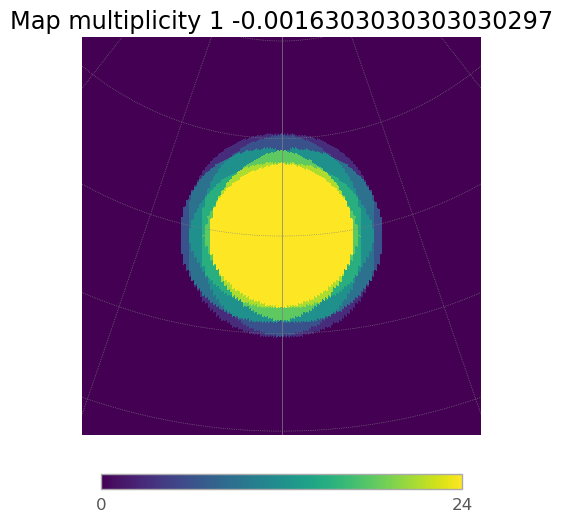

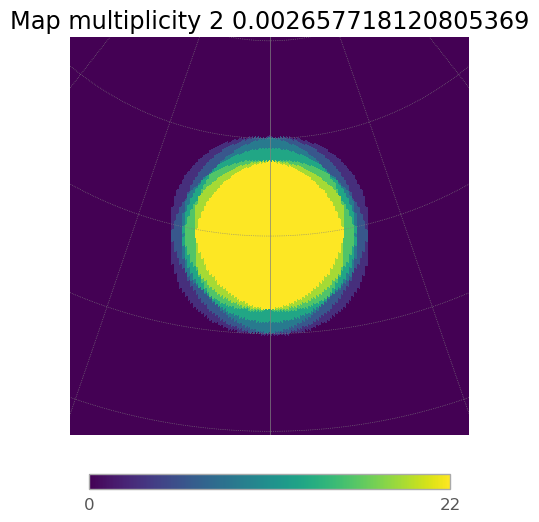

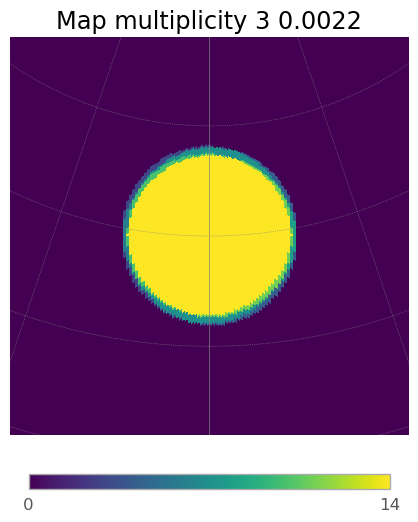

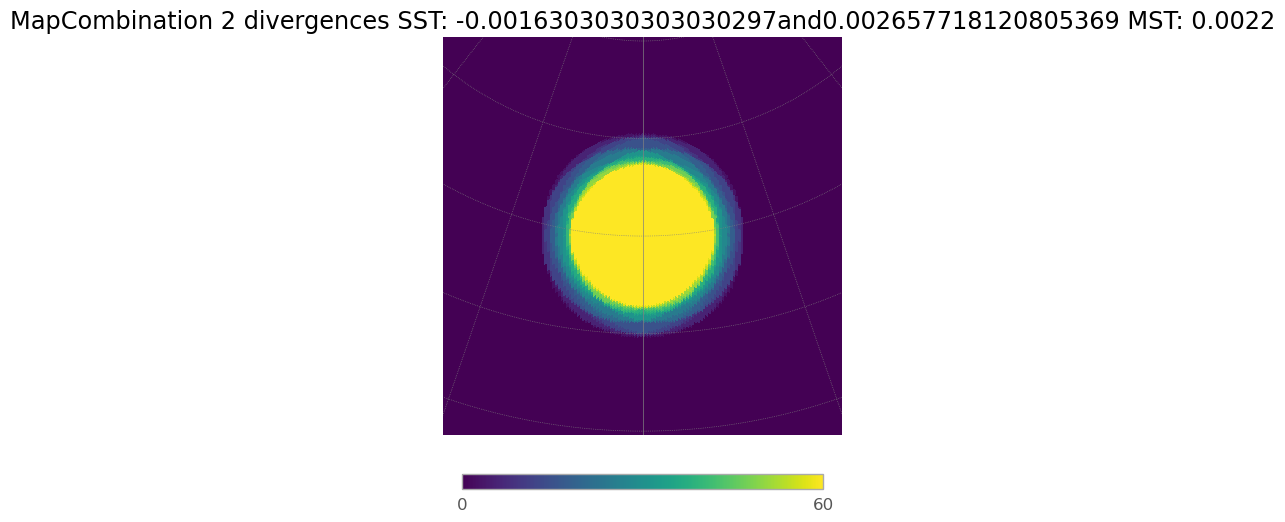

the barycenter for the calculations[-0.67307692  0.         27.68615385]
the barycenter for the calculations of the second divergence[-0.67307692  0.         27.68615385]


6it [00:00,  7.14it/s]
7it [00:00,  7.21it/s]
4it [00:00,  6.79it/s]
6it [00:00,  6.77it/s]


10.38234806580255


7it [00:00,  7.13it/s]
4it [00:00,  6.99it/s]


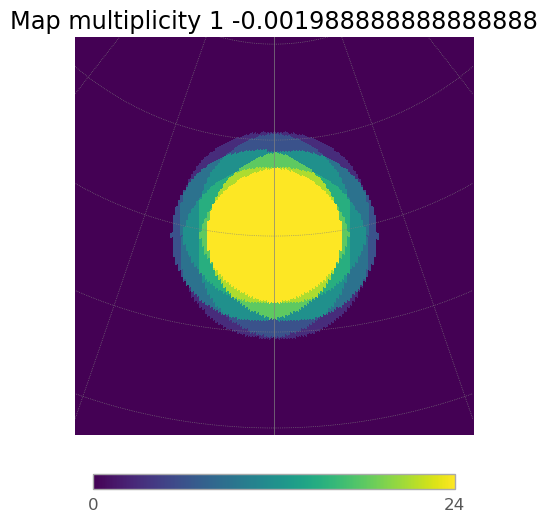

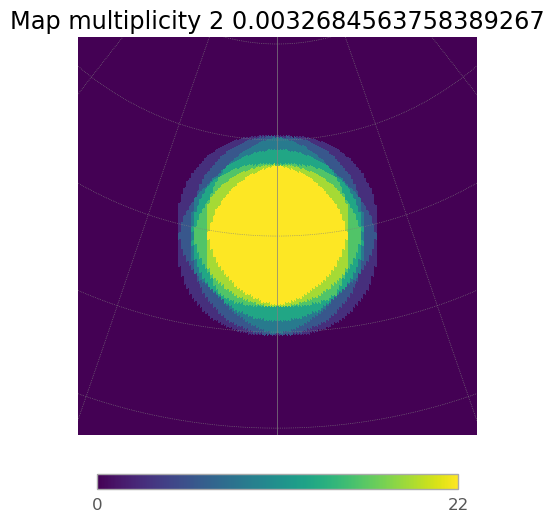

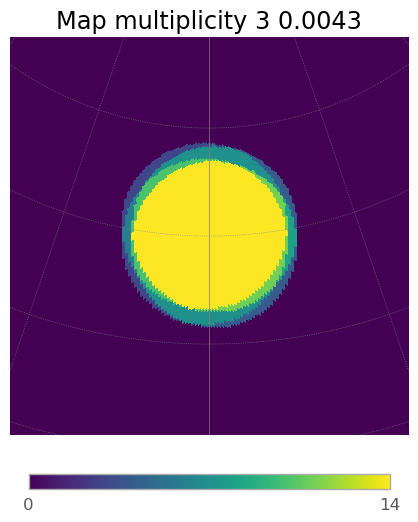

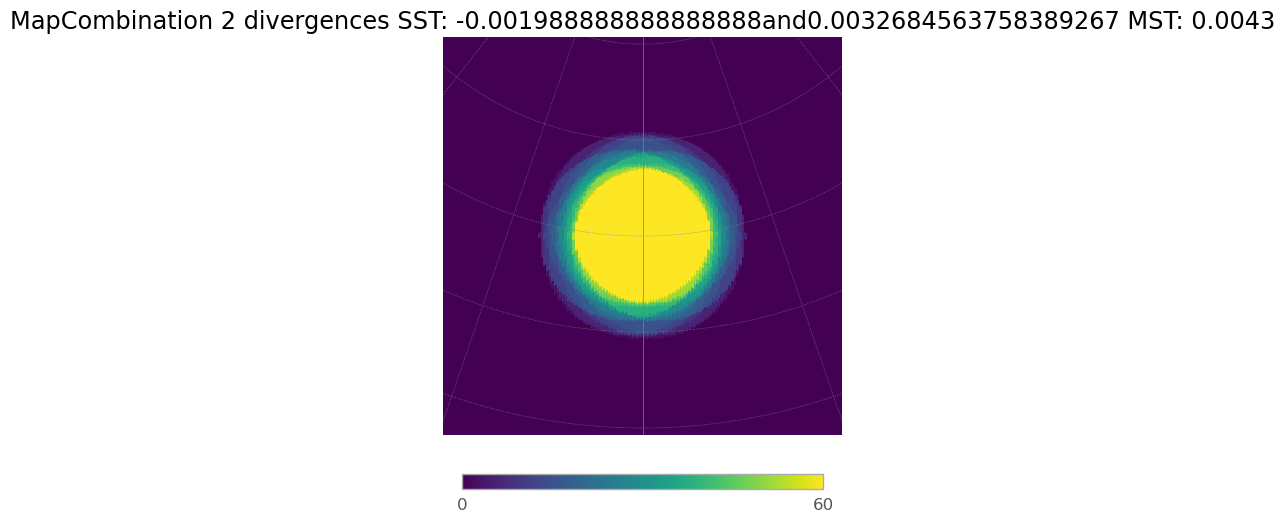

the barycenter for the calculations[-0.67307692  0.         27.68615385]
the barycenter for the calculations of the second divergence[-0.67307692  0.         27.68615385]


6it [00:00,  7.00it/s]
7it [00:01,  6.86it/s]
4it [00:00,  7.06it/s]
6it [00:00,  6.91it/s]


10.681907090507448


7it [00:00,  7.12it/s]
4it [00:00,  6.92it/s]


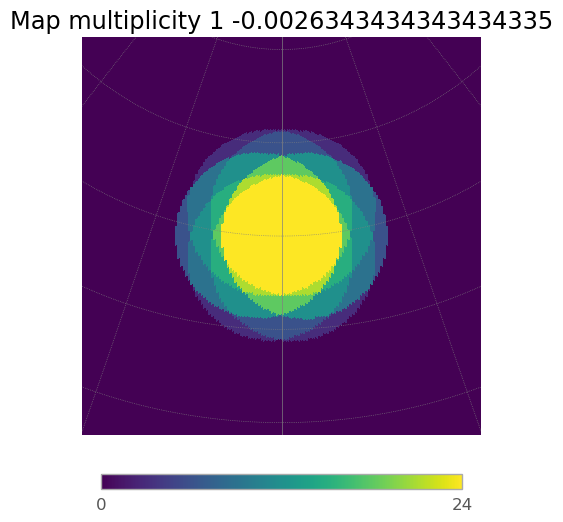

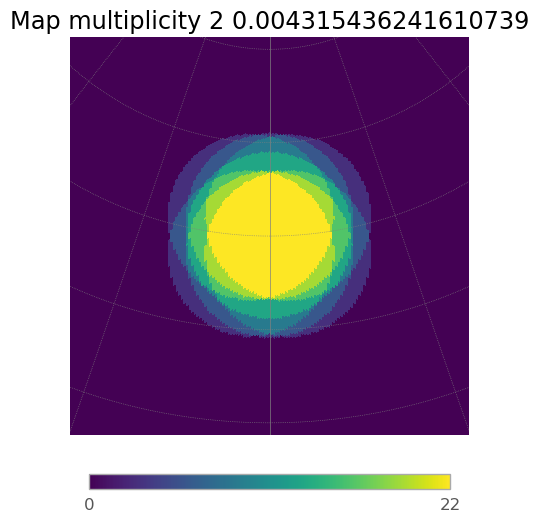

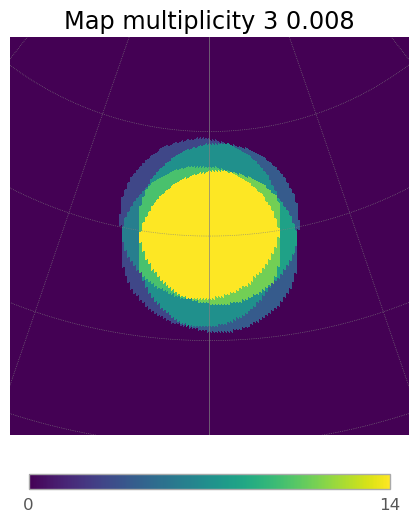

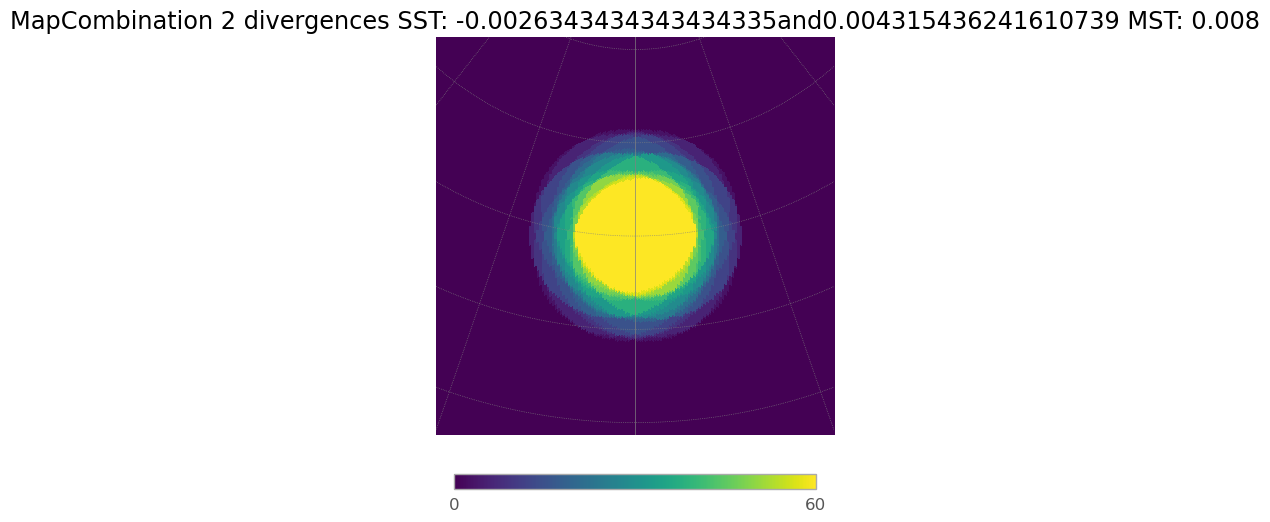

the barycenter for the calculations[-0.67307692  0.         27.68615385]
the barycenter for the calculations of the second divergence[-0.67307692  0.         27.68615385]


6it [00:00,  7.13it/s]
7it [00:00,  7.06it/s]
4it [00:00,  6.87it/s]
6it [00:00,  6.68it/s]


10.976231771331125


7it [00:00,  7.09it/s]
4it [00:00,  7.34it/s]


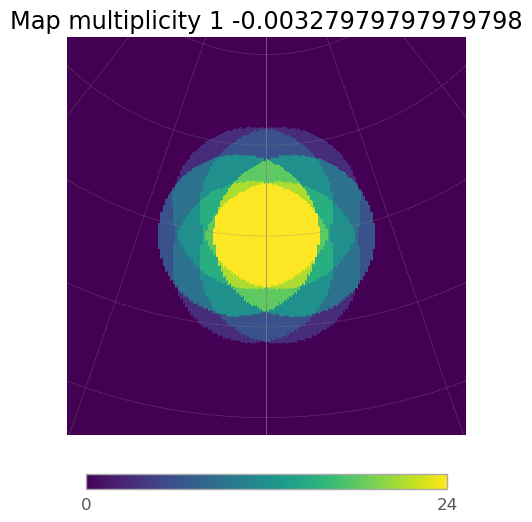

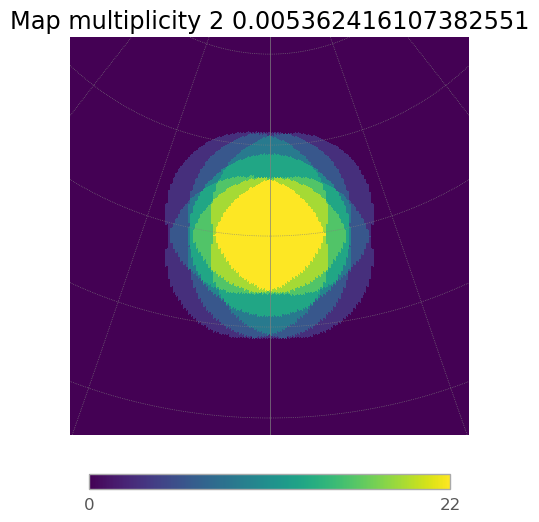

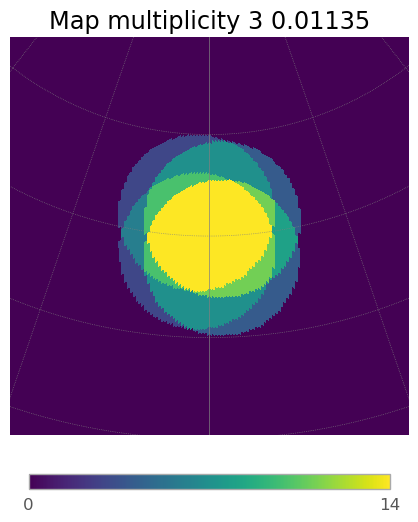

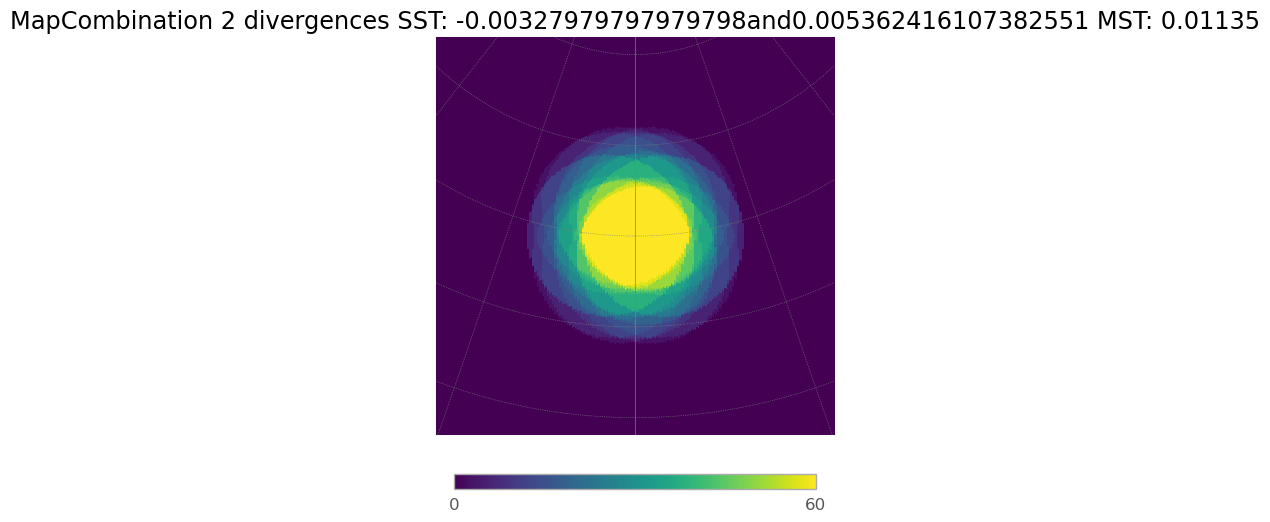

the barycenter for the calculations[-0.67307692  0.         27.68615385]
the barycenter for the calculations of the second divergence[-0.67307692  0.         27.68615385]


6it [00:00,  7.01it/s]
7it [00:00,  7.11it/s]
4it [00:00,  7.09it/s]
6it [00:00,  6.94it/s]


11.267724963705167


7it [00:00,  7.16it/s]
4it [00:00,  6.97it/s]


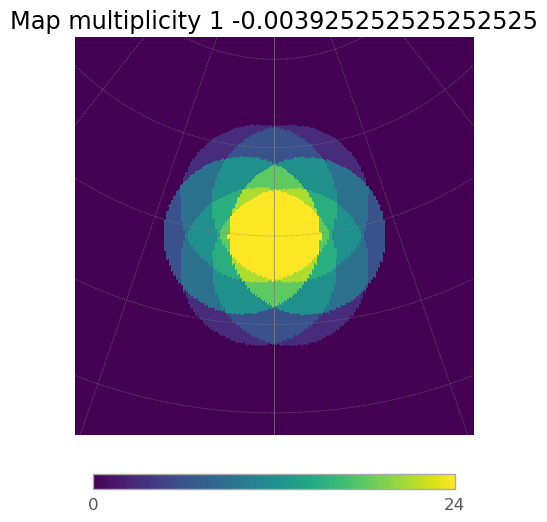

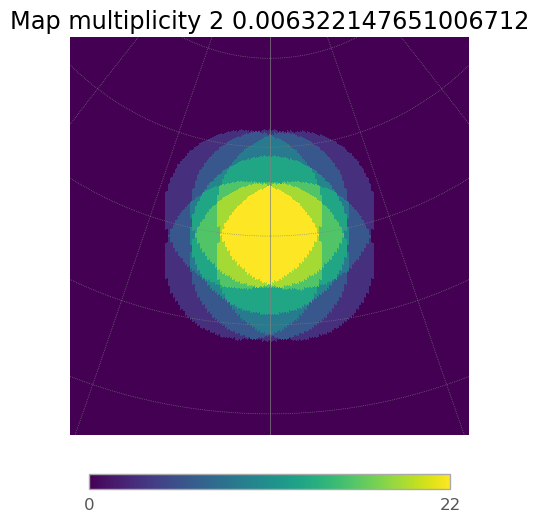

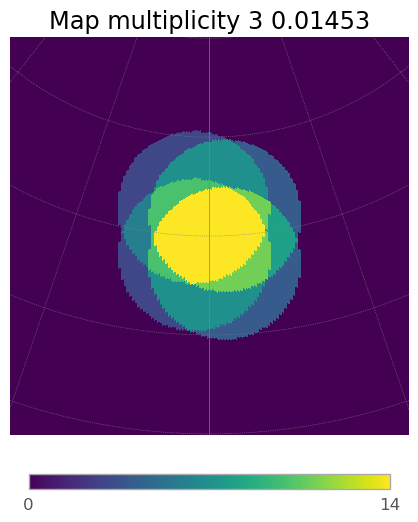

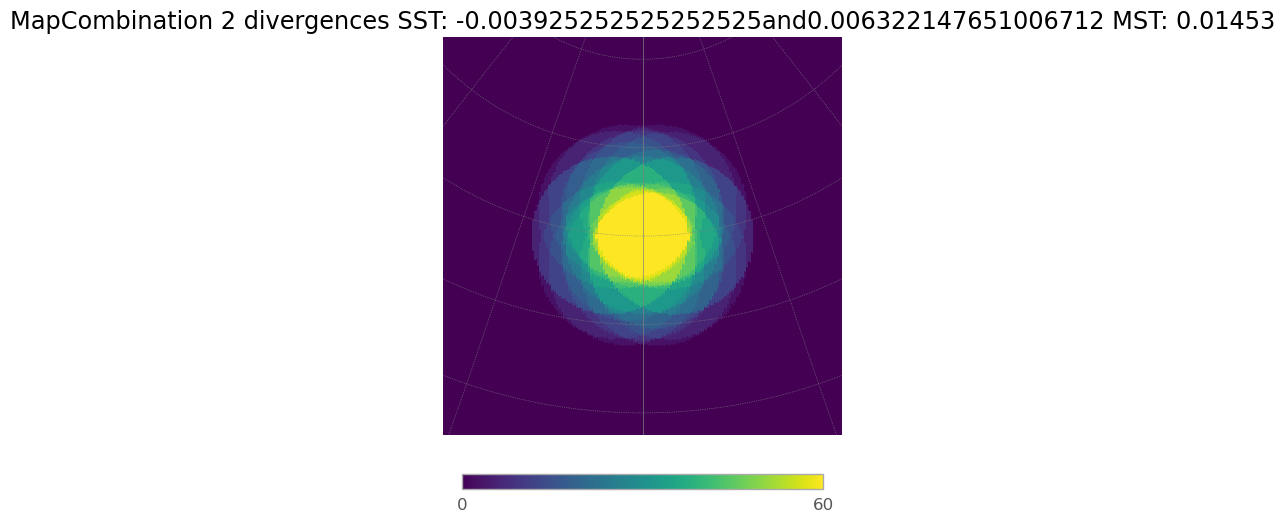

In [71]:

div_MST=[0.0022,0.0043, 0.008, 0.01135, 0.01453 ]
div_SST=divergence_list
conv_SST=convergence_list
for i in range(5):
    config_MST.divergent_pointing(div_MST[i], az=0,alt=70)
    SST_config_conv.divergent_pointing_2_div(tel_group_2=SST_config_div, complete_array=full_array_config_SST, div1=conv_SST[i], div2=div_SST[i], az=0, alt=70)
    SST_config_conv.multiplicity_plot_3_config(array_2=SST_config_div,array_3=config_MST, subarray_mult_1=number_of_telescopes_config_SST_first_half, subarray_mult_2=number_of_telescopes_config_SST_second_half, subarray_mult_3= number_of_telescopes_subarray_1)





## UP TO 0.03

In [72]:
div_MST=[0.0022,0.0043, 0.008, 0.01135, 0.01453, 0.01753, 0.02053, 0.02353, 0.02653, 0.02953]

In [104]:
divergence_list=[]
div_SST=np.linspace(0.001,0.02222, 200)
for divergence in div_MST:
    for divergence_SST in div_SST:
        print(f" the div{divergence_SST}")
        config_MST.divergent_pointing(div=divergence, az=0, alt=70)
        hFoV_to_stop=config_MST.hFoV(m_cut=13, subarray_mult=number_of_telescopes_subarray_1 )[0]
        SST_config_div.divergent_pointing(div=divergence_SST, az=0, alt=70)
        print(f" the stop{round(hFoV_to_stop)}")
        hFoV_div=SST_config_div.hFoV(subarray_mult=number_of_telescopes_config_SST_second_half,m_cut=21)[0]
        print(f" the div h FoV {round(hFoV_div)}")
        if round(hFoV_div) == round(hFoV_to_stop):
            divergence_SST=round(divergence_SST, 6)
            divergence_list.append(divergence_SST)
            print(f"stop, the {divergence_SST}")
            break 

 the div0.001


4it [00:00,  6.37it/s]


 the stop42


7it [00:00,  7.08it/s]


 the div h FoV 54
 the div0.0011066331658291456


4it [00:00,  7.22it/s]


 the stop42


7it [00:00,  7.20it/s]


 the div h FoV 54
 the div0.0012132663316582915


4it [00:00,  7.28it/s]


 the stop42


7it [00:00,  7.14it/s]


 the div h FoV 53
 the div0.0013198994974874371


4it [00:00,  7.28it/s]


 the stop42


7it [00:00,  7.10it/s]


 the div h FoV 52
 the div0.001426532663316583


4it [00:00,  6.98it/s]


 the stop42


7it [00:00,  7.10it/s]


 the div h FoV 51
 the div0.0015331658291457286


4it [00:00,  7.33it/s]


 the stop42


7it [00:00,  7.18it/s]


 the div h FoV 50
 the div0.0016397989949748742


4it [00:00,  7.12it/s]


 the stop42


7it [00:00,  7.32it/s]


 the div h FoV 50
 the div0.00174643216080402


4it [00:00,  6.97it/s]


 the stop42


7it [00:00,  7.32it/s]


 the div h FoV 49
 the div0.001853065326633166


4it [00:00,  7.41it/s]


 the stop42


7it [00:00,  7.31it/s]


 the div h FoV 48
 the div0.0019596984924623116


4it [00:00,  6.95it/s]


 the stop42


7it [00:00,  7.35it/s]


 the div h FoV 47
 the div0.002066331658291457


4it [00:00,  7.01it/s]


 the stop42


7it [00:01,  6.92it/s]


 the div h FoV 46
 the div0.002172964824120603


4it [00:00,  7.04it/s]


 the stop42


7it [00:00,  7.25it/s]


 the div h FoV 46
 the div0.0022795979899497484


4it [00:00,  7.23it/s]


 the stop42


7it [00:00,  7.38it/s]


 the div h FoV 45
 the div0.0023862311557788945


4it [00:00,  7.30it/s]


 the stop42


7it [00:00,  7.43it/s]


 the div h FoV 44
 the div0.00249286432160804


4it [00:00,  7.48it/s]


 the stop42


7it [00:00,  7.47it/s]


 the div h FoV 43
 the div0.002599497487437186


4it [00:00,  7.61it/s]


 the stop42


7it [00:00,  7.50it/s]


 the div h FoV 43
 the div0.002706130653266332


4it [00:00,  7.33it/s]


 the stop42


7it [00:00,  7.23it/s]


 the div h FoV 42
stop, the 0.002706
 the div0.001


4it [00:00,  7.49it/s]


 the stop38


7it [00:00,  7.48it/s]


 the div h FoV 54
 the div0.0011066331658291456


4it [00:00,  7.29it/s]


 the stop38


7it [00:00,  7.42it/s]


 the div h FoV 54
 the div0.0012132663316582915


4it [00:00,  7.53it/s]


 the stop38


7it [00:00,  7.46it/s]


 the div h FoV 53
 the div0.0013198994974874371


4it [00:00,  7.48it/s]


 the stop38


7it [00:00,  7.53it/s]


 the div h FoV 52
 the div0.001426532663316583


4it [00:00,  7.47it/s]


 the stop38


7it [00:00,  7.29it/s]


 the div h FoV 51
 the div0.0015331658291457286


4it [00:00,  7.46it/s]


 the stop38


7it [00:00,  7.42it/s]


 the div h FoV 50
 the div0.0016397989949748742


4it [00:00,  7.56it/s]


 the stop38


7it [00:00,  7.26it/s]


 the div h FoV 50
 the div0.00174643216080402


4it [00:00,  7.45it/s]


 the stop38


7it [00:00,  7.39it/s]


 the div h FoV 49
 the div0.001853065326633166


4it [00:00,  7.44it/s]


 the stop38


7it [00:00,  7.42it/s]


 the div h FoV 48
 the div0.0019596984924623116


4it [00:00,  7.55it/s]


 the stop38


7it [00:00,  7.14it/s]


 the div h FoV 47
 the div0.002066331658291457


4it [00:00,  7.43it/s]


 the stop38


7it [00:00,  7.40it/s]


 the div h FoV 46
 the div0.002172964824120603


4it [00:00,  7.32it/s]


 the stop38


7it [00:00,  7.54it/s]


 the div h FoV 46
 the div0.0022795979899497484


4it [00:00,  7.50it/s]


 the stop38


7it [00:00,  7.37it/s]


 the div h FoV 45
 the div0.0023862311557788945


4it [00:00,  7.40it/s]


 the stop38


7it [00:00,  7.53it/s]


 the div h FoV 44
 the div0.00249286432160804


4it [00:00,  7.25it/s]


 the stop38


7it [00:00,  7.50it/s]


 the div h FoV 43
 the div0.002599497487437186


4it [00:00,  7.29it/s]


 the stop38


7it [00:00,  7.38it/s]


 the div h FoV 43
 the div0.002706130653266332


4it [00:00,  7.47it/s]


 the stop38


7it [00:00,  7.46it/s]


 the div h FoV 42
 the div0.0028127638190954775


4it [00:00,  7.55it/s]


 the stop38


7it [00:00,  7.51it/s]


 the div h FoV 41
 the div0.002919396984924623


4it [00:00,  7.41it/s]


 the stop38


7it [00:00,  7.54it/s]


 the div h FoV 40
 the div0.0030260301507537687


4it [00:00,  7.45it/s]


 the stop38


7it [00:00,  7.45it/s]


 the div h FoV 40
 the div0.0031326633165829143


4it [00:00,  7.49it/s]


 the stop38


7it [00:00,  7.38it/s]


 the div h FoV 39
 the div0.0032392964824120604


4it [00:00,  7.53it/s]


 the stop38


7it [00:00,  7.36it/s]


 the div h FoV 38
stop, the 0.003239
 the div0.001


4it [00:00,  7.53it/s]


 the stop31


7it [00:00,  7.38it/s]


 the div h FoV 54
 the div0.0011066331658291456


4it [00:00,  7.46it/s]


 the stop31


7it [00:00,  7.51it/s]


 the div h FoV 54
 the div0.0012132663316582915


4it [00:00,  7.26it/s]


 the stop31


7it [00:00,  7.45it/s]


 the div h FoV 53
 the div0.0013198994974874371


4it [00:00,  7.42it/s]


 the stop31


7it [00:00,  7.53it/s]


 the div h FoV 52
 the div0.001426532663316583


4it [00:00,  7.51it/s]


 the stop31


7it [00:00,  7.45it/s]


 the div h FoV 51
 the div0.0015331658291457286


4it [00:00,  7.02it/s]


 the stop31


7it [00:00,  7.26it/s]


 the div h FoV 50
 the div0.0016397989949748742


4it [00:00,  7.21it/s]


 the stop31


7it [00:00,  7.54it/s]


 the div h FoV 50
 the div0.00174643216080402


4it [00:00,  7.43it/s]


 the stop31


7it [00:00,  7.49it/s]


 the div h FoV 49
 the div0.001853065326633166


4it [00:00,  6.66it/s]


 the stop31


7it [00:00,  7.44it/s]


 the div h FoV 48
 the div0.0019596984924623116


4it [00:00,  7.29it/s]


 the stop31


7it [00:00,  7.27it/s]


 the div h FoV 47
 the div0.002066331658291457


4it [00:00,  7.27it/s]


 the stop31


7it [00:00,  7.39it/s]


 the div h FoV 46
 the div0.002172964824120603


4it [00:00,  7.10it/s]


 the stop31


7it [00:00,  7.51it/s]


 the div h FoV 46
 the div0.0022795979899497484


4it [00:00,  7.41it/s]


 the stop31


7it [00:00,  7.51it/s]


 the div h FoV 45
 the div0.0023862311557788945


4it [00:00,  7.51it/s]


 the stop31


7it [00:00,  7.42it/s]


 the div h FoV 44
 the div0.00249286432160804


4it [00:00,  7.49it/s]


 the stop31


7it [00:00,  7.50it/s]


 the div h FoV 43
 the div0.002599497487437186


4it [00:00,  7.28it/s]


 the stop31


7it [00:00,  7.43it/s]


 the div h FoV 43
 the div0.002706130653266332


4it [00:00,  7.18it/s]


 the stop31


7it [00:00,  7.34it/s]


 the div h FoV 42
 the div0.0028127638190954775


4it [00:00,  7.11it/s]


 the stop31


7it [00:01,  6.60it/s]


 the div h FoV 41
 the div0.002919396984924623


4it [00:00,  7.14it/s]


 the stop31


7it [00:00,  7.39it/s]


 the div h FoV 40
 the div0.0030260301507537687


4it [00:00,  7.16it/s]


 the stop31


7it [00:00,  7.33it/s]


 the div h FoV 40
 the div0.0031326633165829143


4it [00:00,  7.36it/s]


 the stop31


7it [00:00,  7.33it/s]


 the div h FoV 39
 the div0.0032392964824120604


4it [00:00,  7.55it/s]


 the stop31


7it [00:00,  7.36it/s]


 the div h FoV 38
 the div0.003345929648241206


4it [00:00,  6.74it/s]


 the stop31


7it [00:00,  7.16it/s]


 the div h FoV 38
 the div0.0034525628140703517


4it [00:00,  7.34it/s]


 the stop31


7it [00:01,  6.91it/s]


 the div h FoV 37
 the div0.0035591959798994973


4it [00:00,  7.44it/s]


 the stop31


7it [00:00,  7.23it/s]


 the div h FoV 36
 the div0.003665829145728643


4it [00:00,  6.94it/s]


 the stop31


7it [00:01,  6.08it/s]


 the div h FoV 35
 the div0.003772462311557789


4it [00:00,  7.20it/s]


 the stop31


7it [00:00,  7.18it/s]


 the div h FoV 35
 the div0.0038790954773869346


4it [00:00,  6.91it/s]


 the stop31


7it [00:00,  7.15it/s]


 the div h FoV 34
 the div0.00398572864321608


4it [00:00,  7.43it/s]


 the stop31


7it [00:01,  6.93it/s]


 the div h FoV 33
 the div0.004092361809045226


4it [00:00,  7.05it/s]


 the stop31


7it [00:01,  6.97it/s]


 the div h FoV 33
 the div0.0041989949748743715


4it [00:00,  6.97it/s]


 the stop31


7it [00:01,  6.92it/s]


 the div h FoV 32
 the div0.004305628140703517


4it [00:00,  6.75it/s]


 the stop31


7it [00:00,  7.07it/s]


 the div h FoV 31
stop, the 0.004306
 the div0.001


4it [00:00,  7.39it/s]


 the stop25


7it [00:01,  6.73it/s]


 the div h FoV 54
 the div0.0011066331658291456


4it [00:00,  7.28it/s]


 the stop25


7it [00:00,  7.42it/s]


 the div h FoV 54
 the div0.0012132663316582915


4it [00:00,  7.44it/s]


 the stop25


7it [00:00,  7.18it/s]


 the div h FoV 53
 the div0.0013198994974874371


4it [00:00,  7.34it/s]


 the stop25


7it [00:00,  7.26it/s]


 the div h FoV 52
 the div0.001426532663316583


4it [00:00,  7.32it/s]


 the stop25


7it [00:00,  7.31it/s]


 the div h FoV 51
 the div0.0015331658291457286


4it [00:00,  7.30it/s]


 the stop25


7it [00:00,  7.18it/s]


 the div h FoV 50
 the div0.0016397989949748742


4it [00:00,  6.61it/s]


 the stop25


7it [00:00,  7.24it/s]


 the div h FoV 50
 the div0.00174643216080402


4it [00:00,  7.23it/s]


 the stop25


7it [00:01,  6.99it/s]


 the div h FoV 49
 the div0.001853065326633166


4it [00:00,  7.19it/s]


 the stop25


7it [00:00,  7.21it/s]


 the div h FoV 48
 the div0.0019596984924623116


4it [00:00,  7.33it/s]


 the stop25


7it [00:00,  7.34it/s]


 the div h FoV 47
 the div0.002066331658291457


4it [00:00,  7.09it/s]


 the stop25


7it [00:01,  6.96it/s]


 the div h FoV 46
 the div0.002172964824120603


4it [00:00,  7.32it/s]


 the stop25


7it [00:00,  7.11it/s]


 the div h FoV 46
 the div0.0022795979899497484


4it [00:00,  7.39it/s]


 the stop25


7it [00:00,  7.37it/s]


 the div h FoV 45
 the div0.0023862311557788945


4it [00:00,  6.99it/s]


 the stop25


7it [00:00,  7.13it/s]


 the div h FoV 44
 the div0.00249286432160804


4it [00:00,  7.38it/s]


 the stop25


7it [00:01,  6.98it/s]


 the div h FoV 43
 the div0.002599497487437186


4it [00:00,  7.11it/s]


 the stop25


7it [00:00,  7.20it/s]


 the div h FoV 43
 the div0.002706130653266332


4it [00:00,  7.12it/s]


 the stop25


7it [00:00,  7.27it/s]


 the div h FoV 42
 the div0.0028127638190954775


4it [00:00,  7.18it/s]


 the stop25


7it [00:00,  7.08it/s]


 the div h FoV 41
 the div0.002919396984924623


4it [00:00,  7.32it/s]


 the stop25


7it [00:00,  7.25it/s]


 the div h FoV 40
 the div0.0030260301507537687


4it [00:00,  7.31it/s]


 the stop25


7it [00:00,  7.18it/s]


 the div h FoV 40
 the div0.0031326633165829143


4it [00:00,  7.31it/s]


 the stop25


7it [00:00,  7.18it/s]


 the div h FoV 39
 the div0.0032392964824120604


4it [00:00,  7.29it/s]


 the stop25


7it [00:00,  7.41it/s]


 the div h FoV 38
 the div0.003345929648241206


4it [00:00,  7.41it/s]


 the stop25


7it [00:00,  7.23it/s]


 the div h FoV 38
 the div0.0034525628140703517


4it [00:00,  7.34it/s]


 the stop25


7it [00:00,  7.47it/s]


 the div h FoV 37
 the div0.0035591959798994973


4it [00:00,  7.37it/s]


 the stop25


7it [00:00,  7.25it/s]


 the div h FoV 36
 the div0.003665829145728643


4it [00:00,  7.44it/s]


 the stop25


7it [00:00,  7.37it/s]


 the div h FoV 35
 the div0.003772462311557789


4it [00:00,  7.36it/s]


 the stop25


7it [00:00,  7.25it/s]


 the div h FoV 35
 the div0.0038790954773869346


4it [00:00,  7.48it/s]


 the stop25


7it [00:00,  7.49it/s]


 the div h FoV 34
 the div0.00398572864321608


4it [00:00,  7.44it/s]


 the stop25


7it [00:00,  7.35it/s]


 the div h FoV 33
 the div0.004092361809045226


4it [00:00,  7.27it/s]


 the stop25


7it [00:00,  7.43it/s]


 the div h FoV 33
 the div0.0041989949748743715


4it [00:00,  7.19it/s]


 the stop25


7it [00:00,  7.21it/s]


 the div h FoV 32
 the div0.004305628140703517


4it [00:00,  7.35it/s]


 the stop25


7it [00:00,  7.24it/s]


 the div h FoV 31
 the div0.004412261306532663


4it [00:00,  7.29it/s]


 the stop25


7it [00:00,  7.17it/s]


 the div h FoV 31
 the div0.004518894472361808


4it [00:00,  7.34it/s]


 the stop25


7it [00:01,  6.83it/s]


 the div h FoV 30
 the div0.004625527638190954


4it [00:00,  7.25it/s]


 the stop25


7it [00:00,  7.40it/s]


 the div h FoV 30
 the div0.0047321608040201005


4it [00:00,  7.39it/s]


 the stop25


7it [00:00,  7.44it/s]


 the div h FoV 29
 the div0.004838793969849246


4it [00:00,  7.46it/s]


 the stop25


7it [00:00,  7.29it/s]


 the div h FoV 28
 the div0.004945427135678392


4it [00:00,  7.39it/s]


 the stop25


7it [00:00,  7.18it/s]


 the div h FoV 28
 the div0.005052060301507537


4it [00:00,  7.23it/s]


 the stop25


7it [00:00,  7.15it/s]


 the div h FoV 27
 the div0.005158693467336683


4it [00:00,  7.32it/s]


 the stop25


7it [00:00,  7.26it/s]


 the div h FoV 26
 the div0.005265326633165829


4it [00:00,  7.47it/s]


 the stop25


7it [00:00,  7.26it/s]


 the div h FoV 26
 the div0.005371959798994974


4it [00:00,  7.12it/s]


 the stop25


7it [00:00,  7.33it/s]


 the div h FoV 25
stop, the 0.005372
 the div0.001


4it [00:00,  6.97it/s]


 the stop20


7it [00:00,  7.26it/s]


 the div h FoV 54
 the div0.0011066331658291456


4it [00:00,  7.41it/s]


 the stop20


7it [00:00,  7.42it/s]


 the div h FoV 54
 the div0.0012132663316582915


4it [00:00,  7.44it/s]


 the stop20


7it [00:00,  7.10it/s]


 the div h FoV 53
 the div0.0013198994974874371


4it [00:00,  7.25it/s]


 the stop20


7it [00:00,  7.09it/s]


 the div h FoV 52
 the div0.001426532663316583


4it [00:00,  7.24it/s]


 the stop20


7it [00:00,  7.47it/s]


 the div h FoV 51
 the div0.0015331658291457286


4it [00:00,  7.39it/s]


 the stop20


7it [00:00,  7.41it/s]


 the div h FoV 50
 the div0.0016397989949748742


4it [00:00,  7.42it/s]


 the stop20


7it [00:01,  6.94it/s]


 the div h FoV 50
 the div0.00174643216080402


4it [00:00,  6.94it/s]


 the stop20


7it [00:00,  7.18it/s]


 the div h FoV 49
 the div0.001853065326633166


4it [00:00,  7.49it/s]


 the stop20


7it [00:00,  7.40it/s]


 the div h FoV 48
 the div0.0019596984924623116


4it [00:00,  7.43it/s]


 the stop20


7it [00:00,  7.37it/s]


 the div h FoV 47
 the div0.002066331658291457


4it [00:00,  7.47it/s]


 the stop20


7it [00:00,  7.24it/s]


 the div h FoV 46
 the div0.002172964824120603


4it [00:00,  7.17it/s]


 the stop20


7it [00:00,  7.09it/s]


 the div h FoV 46
 the div0.0022795979899497484


4it [00:00,  7.17it/s]


 the stop20


7it [00:00,  7.52it/s]


 the div h FoV 45
 the div0.0023862311557788945


4it [00:00,  7.10it/s]


 the stop20


7it [00:00,  7.13it/s]


 the div h FoV 44
 the div0.00249286432160804


4it [00:00,  7.28it/s]


 the stop20


7it [00:00,  7.34it/s]


 the div h FoV 43
 the div0.002599497487437186


4it [00:00,  7.32it/s]


 the stop20


7it [00:00,  7.03it/s]


 the div h FoV 43
 the div0.002706130653266332


4it [00:00,  7.17it/s]


 the stop20


7it [00:00,  7.12it/s]


 the div h FoV 42
 the div0.0028127638190954775


4it [00:00,  7.20it/s]


 the stop20


7it [00:00,  7.25it/s]


 the div h FoV 41
 the div0.002919396984924623


4it [00:00,  7.17it/s]


 the stop20


7it [00:01,  6.31it/s]


 the div h FoV 40
 the div0.0030260301507537687


4it [00:00,  6.59it/s]


 the stop20


7it [00:00,  7.03it/s]


 the div h FoV 40
 the div0.0031326633165829143


4it [00:00,  6.98it/s]


 the stop20


7it [00:01,  6.50it/s]


 the div h FoV 39
 the div0.0032392964824120604


4it [00:00,  7.23it/s]


 the stop20


7it [00:01,  6.74it/s]


 the div h FoV 38
 the div0.003345929648241206


4it [00:00,  7.12it/s]


 the stop20


7it [00:00,  7.10it/s]


 the div h FoV 38
 the div0.0034525628140703517


4it [00:00,  6.85it/s]


 the stop20


7it [00:01,  6.92it/s]


 the div h FoV 37
 the div0.0035591959798994973


4it [00:00,  6.63it/s]


 the stop20


7it [00:00,  7.10it/s]


 the div h FoV 36
 the div0.003665829145728643


4it [00:00,  7.38it/s]


 the stop20


7it [00:00,  7.24it/s]


 the div h FoV 35
 the div0.003772462311557789


4it [00:00,  7.38it/s]


 the stop20


7it [00:00,  7.24it/s]


 the div h FoV 35
 the div0.0038790954773869346


4it [00:00,  7.45it/s]


 the stop20


7it [00:00,  7.06it/s]


 the div h FoV 34
 the div0.00398572864321608


4it [00:00,  7.21it/s]


 the stop20


7it [00:00,  7.23it/s]


 the div h FoV 33
 the div0.004092361809045226


4it [00:00,  7.09it/s]


 the stop20


7it [00:00,  7.23it/s]


 the div h FoV 33
 the div0.0041989949748743715


4it [00:00,  7.09it/s]


 the stop20


7it [00:00,  7.02it/s]


 the div h FoV 32
 the div0.004305628140703517


4it [00:00,  6.92it/s]


 the stop20


7it [00:01,  6.91it/s]


 the div h FoV 31
 the div0.004412261306532663


4it [00:00,  7.11it/s]


 the stop20


7it [00:01,  6.96it/s]


 the div h FoV 31
 the div0.004518894472361808


4it [00:00,  7.04it/s]


 the stop20


7it [00:00,  7.26it/s]


 the div h FoV 30
 the div0.004625527638190954


4it [00:00,  6.97it/s]


 the stop20


7it [00:01,  6.96it/s]


 the div h FoV 30
 the div0.0047321608040201005


4it [00:00,  6.93it/s]


 the stop20


7it [00:00,  7.17it/s]


 the div h FoV 29
 the div0.004838793969849246


4it [00:00,  7.08it/s]


 the stop20


7it [00:00,  7.06it/s]


 the div h FoV 28
 the div0.004945427135678392


4it [00:00,  7.04it/s]


 the stop20


7it [00:00,  7.19it/s]


 the div h FoV 28
 the div0.005052060301507537


4it [00:00,  7.33it/s]


 the stop20


7it [00:00,  7.11it/s]


 the div h FoV 27
 the div0.005158693467336683


4it [00:00,  7.17it/s]


 the stop20


7it [00:00,  7.08it/s]


 the div h FoV 26
 the div0.005265326633165829


4it [00:00,  7.05it/s]


 the stop20


7it [00:00,  7.42it/s]


 the div h FoV 26
 the div0.005371959798994974


4it [00:00,  7.30it/s]


 the stop20


7it [00:00,  7.41it/s]


 the div h FoV 25
 the div0.005478592964824121


4it [00:00,  7.38it/s]


 the stop20


7it [00:00,  7.02it/s]


 the div h FoV 25
 the div0.005585226130653266


4it [00:00,  7.26it/s]


 the stop20


7it [00:00,  7.35it/s]


 the div h FoV 24
 the div0.005691859296482412


4it [00:00,  7.22it/s]


 the stop20


7it [00:00,  7.31it/s]


 the div h FoV 23
 the div0.005798492462311558


4it [00:00,  7.48it/s]


 the stop20


7it [00:00,  7.26it/s]


 the div h FoV 23
 the div0.005905125628140703


4it [00:00,  7.46it/s]


 the stop20


7it [00:00,  7.17it/s]


 the div h FoV 22
 the div0.006011758793969849


4it [00:00,  7.49it/s]


 the stop20


7it [00:00,  7.40it/s]


 the div h FoV 22
 the div0.0061183919597989946


4it [00:00,  7.48it/s]


 the stop20


7it [00:00,  7.33it/s]


 the div h FoV 21
 the div0.00622502512562814


4it [00:00,  7.17it/s]


 the stop20


7it [00:00,  7.31it/s]


 the div h FoV 21
 the div0.006331658291457286


4it [00:00,  7.21it/s]


 the stop20


7it [00:00,  7.34it/s]


 the div h FoV 20
stop, the 0.006332
 the div0.001


4it [00:00,  7.33it/s]


 the stop15


7it [00:00,  7.49it/s]


 the div h FoV 54
 the div0.0011066331658291456


4it [00:00,  7.45it/s]


 the stop15


7it [00:00,  7.29it/s]


 the div h FoV 54
 the div0.0012132663316582915


4it [00:00,  6.94it/s]


 the stop15


7it [00:00,  7.34it/s]


 the div h FoV 53
 the div0.0013198994974874371


4it [00:00,  7.39it/s]


 the stop15


7it [00:00,  7.24it/s]


 the div h FoV 52
 the div0.001426532663316583


4it [00:00,  7.46it/s]


 the stop15


7it [00:00,  7.28it/s]


 the div h FoV 51
 the div0.0015331658291457286


4it [00:00,  7.42it/s]


 the stop15


7it [00:00,  7.38it/s]


 the div h FoV 50
 the div0.0016397989949748742


4it [00:00,  6.93it/s]


 the stop15


7it [00:00,  7.16it/s]


 the div h FoV 50
 the div0.00174643216080402


4it [00:00,  7.34it/s]


 the stop15


7it [00:00,  7.25it/s]


 the div h FoV 49
 the div0.001853065326633166


4it [00:00,  7.43it/s]


 the stop15


7it [00:00,  7.48it/s]


 the div h FoV 48
 the div0.0019596984924623116


4it [00:00,  7.45it/s]


 the stop15


7it [00:00,  7.06it/s]


 the div h FoV 47
 the div0.002066331658291457


4it [00:00,  6.96it/s]


 the stop15


7it [00:00,  7.09it/s]


 the div h FoV 46
 the div0.002172964824120603


4it [00:00,  7.14it/s]


 the stop15


7it [00:01,  6.96it/s]


 the div h FoV 46
 the div0.0022795979899497484


4it [00:00,  7.22it/s]


 the stop15


7it [00:00,  7.24it/s]


 the div h FoV 45
 the div0.0023862311557788945


4it [00:00,  7.29it/s]


 the stop15


7it [00:00,  7.44it/s]


 the div h FoV 44
 the div0.00249286432160804


4it [00:00,  7.35it/s]


 the stop15


7it [00:00,  7.24it/s]


 the div h FoV 43
 the div0.002599497487437186


4it [00:00,  7.25it/s]


 the stop15


7it [00:00,  7.32it/s]


 the div h FoV 43
 the div0.002706130653266332


4it [00:00,  7.47it/s]


 the stop15


7it [00:00,  7.31it/s]


 the div h FoV 42
 the div0.0028127638190954775


4it [00:00,  7.14it/s]


 the stop15


7it [00:00,  7.42it/s]


 the div h FoV 41
 the div0.002919396984924623


4it [00:00,  6.85it/s]


 the stop15


7it [00:00,  7.18it/s]


 the div h FoV 40
 the div0.0030260301507537687


4it [00:00,  7.28it/s]


 the stop15


7it [00:00,  7.29it/s]


 the div h FoV 40
 the div0.0031326633165829143


4it [00:00,  7.26it/s]


 the stop15


7it [00:00,  7.34it/s]


 the div h FoV 39
 the div0.0032392964824120604


4it [00:00,  7.21it/s]


 the stop15


7it [00:00,  7.44it/s]


 the div h FoV 38
 the div0.003345929648241206


4it [00:00,  7.38it/s]


 the stop15


7it [00:00,  7.38it/s]


 the div h FoV 38
 the div0.0034525628140703517


4it [00:00,  7.33it/s]


 the stop15


7it [00:00,  7.28it/s]


 the div h FoV 37
 the div0.0035591959798994973


4it [00:00,  7.44it/s]


 the stop15


7it [00:00,  7.39it/s]


 the div h FoV 36
 the div0.003665829145728643


4it [00:00,  7.47it/s]


 the stop15


7it [00:00,  7.44it/s]


 the div h FoV 35
 the div0.003772462311557789


4it [00:00,  7.49it/s]


 the stop15


7it [00:00,  7.08it/s]


 the div h FoV 35
 the div0.0038790954773869346


4it [00:00,  7.29it/s]


 the stop15


7it [00:00,  7.18it/s]


 the div h FoV 34
 the div0.00398572864321608


4it [00:00,  7.42it/s]


 the stop15


7it [00:00,  7.52it/s]


 the div h FoV 33
 the div0.004092361809045226


4it [00:00,  7.17it/s]


 the stop15


7it [00:00,  7.26it/s]


 the div h FoV 33
 the div0.0041989949748743715


4it [00:00,  7.29it/s]


 the stop15


7it [00:00,  7.11it/s]


 the div h FoV 32
 the div0.004305628140703517


4it [00:00,  7.34it/s]


 the stop15


7it [00:00,  7.47it/s]


 the div h FoV 31
 the div0.004412261306532663


4it [00:00,  7.45it/s]


 the stop15


7it [00:00,  7.37it/s]


 the div h FoV 31
 the div0.004518894472361808


4it [00:00,  7.49it/s]


 the stop15


7it [00:00,  7.17it/s]


 the div h FoV 30
 the div0.004625527638190954


4it [00:00,  7.41it/s]


 the stop15


7it [00:00,  7.34it/s]


 the div h FoV 30
 the div0.0047321608040201005


4it [00:00,  7.53it/s]


 the stop15


7it [00:00,  7.32it/s]


 the div h FoV 29
 the div0.004838793969849246


4it [00:00,  6.87it/s]


 the stop15


7it [00:00,  7.29it/s]


 the div h FoV 28
 the div0.004945427135678392


4it [00:00,  7.49it/s]


 the stop15


7it [00:00,  7.44it/s]


 the div h FoV 28
 the div0.005052060301507537


4it [00:00,  7.21it/s]


 the stop15


7it [00:00,  7.36it/s]


 the div h FoV 27
 the div0.005158693467336683


4it [00:00,  6.83it/s]


 the stop15


7it [00:00,  7.38it/s]


 the div h FoV 26
 the div0.005265326633165829


4it [00:00,  7.40it/s]


 the stop15


7it [00:00,  7.32it/s]


 the div h FoV 26
 the div0.005371959798994974


4it [00:00,  7.42it/s]


 the stop15


7it [00:00,  7.34it/s]


 the div h FoV 25
 the div0.005478592964824121


4it [00:00,  7.45it/s]


 the stop15


7it [00:00,  7.46it/s]


 the div h FoV 25
 the div0.005585226130653266


4it [00:00,  7.42it/s]


 the stop15


7it [00:00,  7.40it/s]


 the div h FoV 24
 the div0.005691859296482412


4it [00:00,  7.05it/s]


 the stop15


7it [00:00,  7.23it/s]


 the div h FoV 23
 the div0.005798492462311558


4it [00:00,  7.36it/s]


 the stop15


7it [00:00,  7.17it/s]


 the div h FoV 23
 the div0.005905125628140703


4it [00:00,  7.24it/s]


 the stop15


7it [00:00,  7.38it/s]


 the div h FoV 22
 the div0.006011758793969849


4it [00:00,  7.33it/s]


 the stop15


7it [00:00,  7.42it/s]


 the div h FoV 22
 the div0.0061183919597989946


4it [00:00,  7.33it/s]


 the stop15


7it [00:00,  7.35it/s]


 the div h FoV 21
 the div0.00622502512562814


4it [00:00,  7.31it/s]


 the stop15


7it [00:00,  7.44it/s]


 the div h FoV 21
 the div0.006331658291457286


4it [00:00,  7.26it/s]


 the stop15


7it [00:00,  7.31it/s]


 the div h FoV 20
 the div0.006438291457286432


4it [00:00,  7.16it/s]


 the stop15


7it [00:00,  7.38it/s]


 the div h FoV 20
 the div0.006544924623115578


4it [00:00,  7.44it/s]


 the stop15


7it [00:00,  7.35it/s]


 the div h FoV 19
 the div0.006651557788944724


4it [00:00,  7.31it/s]


 the stop15


7it [00:00,  7.34it/s]


 the div h FoV 19
 the div0.006758190954773869


4it [00:00,  7.28it/s]


 the stop15


7it [00:00,  7.18it/s]


 the div h FoV 18
 the div0.006864824120603015


4it [00:00,  6.81it/s]


 the stop15


7it [00:01,  6.99it/s]


 the div h FoV 18
 the div0.0069714572864321605


4it [00:00,  7.36it/s]


 the stop15


7it [00:00,  7.31it/s]


 the div h FoV 17
 the div0.007078090452261306


4it [00:00,  7.20it/s]


 the stop15


7it [00:00,  7.47it/s]


 the div h FoV 17
 the div0.007184723618090452


4it [00:00,  6.22it/s]


 the stop15


7it [00:00,  7.40it/s]


 the div h FoV 16
 the div0.007291356783919597


4it [00:00,  7.33it/s]


 the stop15


7it [00:00,  7.23it/s]


 the div h FoV 16
 the div0.007397989949748744


4it [00:00,  7.40it/s]


 the stop15


7it [00:00,  7.22it/s]


 the div h FoV 15
stop, the 0.007398
 the div0.001


4it [00:00,  7.25it/s]


 the stop11


7it [00:01,  6.84it/s]


 the div h FoV 54
 the div0.0011066331658291456


4it [00:00,  6.67it/s]


 the stop11


7it [00:00,  7.16it/s]


 the div h FoV 54
 the div0.0012132663316582915


4it [00:00,  7.40it/s]


 the stop11


7it [00:00,  7.36it/s]


 the div h FoV 53
 the div0.0013198994974874371


4it [00:00,  7.17it/s]


 the stop11


7it [00:00,  7.27it/s]


 the div h FoV 52
 the div0.001426532663316583


4it [00:00,  7.29it/s]


 the stop11


7it [00:00,  7.27it/s]


 the div h FoV 51
 the div0.0015331658291457286


4it [00:00,  7.29it/s]


 the stop11


7it [00:00,  7.43it/s]


 the div h FoV 50
 the div0.0016397989949748742


4it [00:00,  7.33it/s]


 the stop11


7it [00:00,  7.41it/s]


 the div h FoV 50
 the div0.00174643216080402


4it [00:00,  7.06it/s]


 the stop11


7it [00:01,  6.75it/s]


 the div h FoV 49
 the div0.001853065326633166


4it [00:00,  7.46it/s]


 the stop11


7it [00:00,  7.42it/s]


 the div h FoV 48
 the div0.0019596984924623116


4it [00:00,  7.20it/s]


 the stop11


7it [00:00,  7.01it/s]


 the div h FoV 47
 the div0.002066331658291457


4it [00:00,  7.16it/s]


 the stop11


7it [00:00,  7.18it/s]


 the div h FoV 46
 the div0.002172964824120603


4it [00:00,  7.34it/s]


 the stop11


7it [00:00,  7.45it/s]


 the div h FoV 46
 the div0.0022795979899497484


4it [00:00,  7.52it/s]


 the stop11


7it [00:00,  7.49it/s]


 the div h FoV 45
 the div0.0023862311557788945


4it [00:00,  7.26it/s]


 the stop11


7it [00:00,  7.48it/s]


 the div h FoV 44
 the div0.00249286432160804


4it [00:00,  7.30it/s]


 the stop11


7it [00:00,  7.32it/s]


 the div h FoV 43
 the div0.002599497487437186


4it [00:00,  7.42it/s]


 the stop11


7it [00:00,  7.16it/s]


 the div h FoV 43
 the div0.002706130653266332


4it [00:00,  6.55it/s]


 the stop11


7it [00:01,  5.84it/s]


 the div h FoV 42
 the div0.0028127638190954775


4it [00:00,  6.42it/s]


 the stop11


7it [00:00,  7.16it/s]


 the div h FoV 41
 the div0.002919396984924623


4it [00:00,  7.45it/s]


 the stop11


7it [00:00,  7.42it/s]


 the div h FoV 40
 the div0.0030260301507537687


4it [00:00,  7.39it/s]


 the stop11


7it [00:00,  7.39it/s]


 the div h FoV 40
 the div0.0031326633165829143


4it [00:00,  6.53it/s]


 the stop11


7it [00:00,  7.10it/s]


 the div h FoV 39
 the div0.0032392964824120604


4it [00:00,  7.33it/s]


 the stop11


7it [00:01,  6.53it/s]


 the div h FoV 38
 the div0.003345929648241206


4it [00:00,  6.03it/s]


 the stop11


7it [00:01,  6.75it/s]


 the div h FoV 38
 the div0.0034525628140703517


4it [00:00,  6.20it/s]


 the stop11


7it [00:01,  6.42it/s]


 the div h FoV 37
 the div0.0035591959798994973


4it [00:00,  6.02it/s]


 the stop11


7it [00:01,  6.70it/s]


 the div h FoV 36
 the div0.003665829145728643


4it [00:00,  5.89it/s]


 the stop11


7it [00:01,  6.69it/s]


 the div h FoV 35
 the div0.003772462311557789


4it [00:00,  5.85it/s]


 the stop11


7it [00:01,  6.62it/s]


 the div h FoV 35
 the div0.0038790954773869346


4it [00:00,  6.43it/s]


 the stop11


7it [00:01,  6.83it/s]


 the div h FoV 34
 the div0.00398572864321608


4it [00:00,  6.41it/s]


 the stop11


7it [00:01,  6.71it/s]


 the div h FoV 33
 the div0.004092361809045226


4it [00:00,  6.41it/s]


 the stop11


7it [00:01,  6.47it/s]


 the div h FoV 33
 the div0.0041989949748743715


4it [00:00,  6.55it/s]


 the stop11


7it [00:01,  6.62it/s]


 the div h FoV 32
 the div0.004305628140703517


4it [00:00,  7.10it/s]


 the stop11


7it [00:01,  6.96it/s]


 the div h FoV 31
 the div0.004412261306532663


4it [00:00,  7.15it/s]


 the stop11


7it [00:00,  7.48it/s]


 the div h FoV 31
 the div0.004518894472361808


4it [00:00,  7.40it/s]


 the stop11


7it [00:00,  7.03it/s]


 the div h FoV 30
 the div0.004625527638190954


4it [00:00,  7.06it/s]


 the stop11


7it [00:00,  7.24it/s]


 the div h FoV 30
 the div0.0047321608040201005


4it [00:00,  7.07it/s]


 the stop11


7it [00:00,  7.29it/s]


 the div h FoV 29
 the div0.004838793969849246


4it [00:00,  6.83it/s]


 the stop11


7it [00:00,  7.12it/s]


 the div h FoV 28
 the div0.004945427135678392


4it [00:00,  7.18it/s]


 the stop11


7it [00:00,  7.44it/s]


 the div h FoV 28
 the div0.005052060301507537


4it [00:00,  6.99it/s]


 the stop11


7it [00:00,  7.24it/s]


 the div h FoV 27
 the div0.005158693467336683


4it [00:00,  7.09it/s]


 the stop11


7it [00:00,  7.13it/s]


 the div h FoV 26
 the div0.005265326633165829


4it [00:00,  7.17it/s]


 the stop11


7it [00:00,  7.09it/s]


 the div h FoV 26
 the div0.005371959798994974


4it [00:00,  6.63it/s]


 the stop11


7it [00:00,  7.46it/s]


 the div h FoV 25
 the div0.005478592964824121


4it [00:00,  7.30it/s]


 the stop11


7it [00:00,  7.20it/s]


 the div h FoV 25
 the div0.005585226130653266


4it [00:00,  7.35it/s]


 the stop11


7it [00:00,  7.34it/s]


 the div h FoV 24
 the div0.005691859296482412


4it [00:00,  7.02it/s]


 the stop11


7it [00:00,  7.19it/s]


 the div h FoV 23
 the div0.005798492462311558


4it [00:00,  7.12it/s]


 the stop11


7it [00:00,  7.02it/s]


 the div h FoV 23
 the div0.005905125628140703


4it [00:00,  7.44it/s]


 the stop11


7it [00:00,  7.19it/s]


 the div h FoV 22
 the div0.006011758793969849


4it [00:00,  7.32it/s]


 the stop11


7it [00:00,  7.12it/s]


 the div h FoV 22
 the div0.0061183919597989946


4it [00:00,  7.13it/s]


 the stop11


7it [00:00,  7.14it/s]


 the div h FoV 21
 the div0.00622502512562814


4it [00:00,  7.38it/s]


 the stop11


7it [00:00,  7.42it/s]


 the div h FoV 21
 the div0.006331658291457286


4it [00:00,  6.86it/s]


 the stop11


7it [00:00,  7.20it/s]


 the div h FoV 20
 the div0.006438291457286432


4it [00:00,  6.63it/s]


 the stop11


7it [00:01,  6.61it/s]


 the div h FoV 20
 the div0.006544924623115578


4it [00:00,  6.94it/s]


 the stop11


7it [00:01,  6.73it/s]


 the div h FoV 19
 the div0.006651557788944724


4it [00:00,  6.87it/s]


 the stop11


7it [00:01,  6.77it/s]


 the div h FoV 19
 the div0.006758190954773869


4it [00:00,  6.26it/s]


 the stop11


7it [00:01,  6.57it/s]


 the div h FoV 18
 the div0.006864824120603015


4it [00:00,  6.64it/s]


 the stop11


7it [00:01,  6.57it/s]


 the div h FoV 18
 the div0.0069714572864321605


4it [00:00,  6.61it/s]


 the stop11


7it [00:01,  6.90it/s]


 the div h FoV 17
 the div0.007078090452261306


4it [00:00,  6.31it/s]


 the stop11


7it [00:01,  6.61it/s]


 the div h FoV 17
 the div0.007184723618090452


4it [00:00,  6.71it/s]


 the stop11


7it [00:01,  6.79it/s]


 the div h FoV 16
 the div0.007291356783919597


4it [00:00,  6.28it/s]


 the stop11


7it [00:01,  6.42it/s]


 the div h FoV 16
 the div0.007397989949748744


4it [00:00,  6.32it/s]


 the stop11


7it [00:01,  6.37it/s]


 the div h FoV 15
 the div0.0075046231155778895


4it [00:00,  6.48it/s]


 the stop11


7it [00:01,  6.67it/s]


 the div h FoV 15
 the div0.007611256281407035


4it [00:00,  6.79it/s]


 the stop11


7it [00:01,  6.98it/s]


 the div h FoV 14
 the div0.007717889447236181


4it [00:00,  7.03it/s]


 the stop11


7it [00:00,  7.35it/s]


 the div h FoV 14
 the div0.007824522613065326


4it [00:00,  7.54it/s]


 the stop11


7it [00:00,  7.40it/s]


 the div h FoV 13
 the div0.007931155778894472


4it [00:00,  7.47it/s]


 the stop11


7it [00:00,  7.19it/s]


 the div h FoV 13
 the div0.008037788944723618


4it [00:00,  7.37it/s]


 the stop11


7it [00:00,  7.41it/s]


 the div h FoV 12
 the div0.008144422110552763


4it [00:00,  7.30it/s]


 the stop11


7it [00:00,  7.50it/s]


 the div h FoV 12
 the div0.008251055276381909


4it [00:00,  7.53it/s]


 the stop11


7it [00:00,  7.44it/s]


 the div h FoV 12
 the div0.008357688442211055


4it [00:00,  7.33it/s]


 the stop11


7it [00:00,  7.52it/s]


 the div h FoV 11
stop, the 0.008358
 the div0.001


4it [00:00,  7.47it/s]


 the stop8


7it [00:00,  7.42it/s]


 the div h FoV 54
 the div0.0011066331658291456


4it [00:00,  7.44it/s]


 the stop8


7it [00:00,  7.43it/s]


 the div h FoV 54
 the div0.0012132663316582915


4it [00:00,  7.17it/s]


 the stop8


7it [00:00,  7.53it/s]


 the div h FoV 53
 the div0.0013198994974874371


4it [00:00,  7.25it/s]


 the stop8


7it [00:00,  7.53it/s]


 the div h FoV 52
 the div0.001426532663316583


4it [00:00,  7.46it/s]


 the stop8


7it [00:00,  7.56it/s]


 the div h FoV 51
 the div0.0015331658291457286


4it [00:00,  7.43it/s]


 the stop8


7it [00:00,  7.40it/s]


 the div h FoV 50
 the div0.0016397989949748742


4it [00:00,  7.47it/s]


 the stop8


7it [00:00,  7.07it/s]


 the div h FoV 50
 the div0.00174643216080402


4it [00:00,  7.44it/s]


 the stop8


7it [00:00,  7.56it/s]


 the div h FoV 49
 the div0.001853065326633166


4it [00:00,  7.35it/s]


 the stop8


7it [00:00,  7.20it/s]


 the div h FoV 48
 the div0.0019596984924623116


4it [00:00,  7.58it/s]


 the stop8


7it [00:00,  7.28it/s]


 the div h FoV 47
 the div0.002066331658291457


4it [00:00,  7.54it/s]


 the stop8


7it [00:00,  7.48it/s]


 the div h FoV 46
 the div0.002172964824120603


4it [00:00,  7.56it/s]


 the stop8


7it [00:00,  7.48it/s]


 the div h FoV 46
 the div0.0022795979899497484


4it [00:00,  7.22it/s]


 the stop8


7it [00:00,  7.41it/s]


 the div h FoV 45
 the div0.0023862311557788945


4it [00:00,  7.40it/s]


 the stop8


7it [00:00,  7.50it/s]


 the div h FoV 44
 the div0.00249286432160804


4it [00:00,  7.53it/s]


 the stop8


7it [00:00,  7.42it/s]


 the div h FoV 43
 the div0.002599497487437186


4it [00:00,  7.44it/s]


 the stop8


7it [00:00,  7.47it/s]


 the div h FoV 43
 the div0.002706130653266332


4it [00:00,  6.74it/s]


 the stop8


7it [00:00,  7.45it/s]


 the div h FoV 42
 the div0.0028127638190954775


4it [00:00,  7.41it/s]


 the stop8


7it [00:00,  7.48it/s]


 the div h FoV 41
 the div0.002919396984924623


4it [00:00,  7.50it/s]


 the stop8


7it [00:00,  7.50it/s]


 the div h FoV 40
 the div0.0030260301507537687


4it [00:00,  7.37it/s]


 the stop8


7it [00:00,  7.29it/s]


 the div h FoV 40
 the div0.0031326633165829143


4it [00:00,  7.45it/s]


 the stop8


7it [00:00,  7.36it/s]


 the div h FoV 39
 the div0.0032392964824120604


4it [00:00,  7.51it/s]


 the stop8


7it [00:00,  7.59it/s]


 the div h FoV 38
 the div0.003345929648241206


4it [00:00,  7.53it/s]


 the stop8


7it [00:00,  7.30it/s]


 the div h FoV 38
 the div0.0034525628140703517


4it [00:00,  7.44it/s]


 the stop8


7it [00:00,  7.43it/s]


 the div h FoV 37
 the div0.0035591959798994973


4it [00:00,  7.55it/s]


 the stop8


7it [00:00,  7.30it/s]


 the div h FoV 36
 the div0.003665829145728643


4it [00:00,  7.42it/s]


 the stop8


7it [00:00,  7.39it/s]


 the div h FoV 35
 the div0.003772462311557789


4it [00:00,  7.16it/s]


 the stop8


7it [00:00,  7.26it/s]


 the div h FoV 35
 the div0.0038790954773869346


4it [00:00,  7.48it/s]


 the stop8


7it [00:00,  7.51it/s]


 the div h FoV 34
 the div0.00398572864321608


4it [00:00,  7.23it/s]


 the stop8


7it [00:00,  7.40it/s]


 the div h FoV 33
 the div0.004092361809045226


4it [00:00,  7.47it/s]


 the stop8


7it [00:00,  7.30it/s]


 the div h FoV 33
 the div0.0041989949748743715


4it [00:00,  7.54it/s]


 the stop8


7it [00:00,  7.41it/s]


 the div h FoV 32
 the div0.004305628140703517


4it [00:00,  7.42it/s]


 the stop8


7it [00:00,  7.46it/s]


 the div h FoV 31
 the div0.004412261306532663


4it [00:00,  7.24it/s]


 the stop8


7it [00:00,  7.42it/s]


 the div h FoV 31
 the div0.004518894472361808


4it [00:00,  7.55it/s]


 the stop8


7it [00:00,  7.48it/s]


 the div h FoV 30
 the div0.004625527638190954


4it [00:00,  7.36it/s]


 the stop8


7it [00:00,  7.23it/s]


 the div h FoV 30
 the div0.0047321608040201005


4it [00:00,  7.30it/s]


 the stop8


7it [00:00,  7.32it/s]


 the div h FoV 29
 the div0.004838793969849246


4it [00:00,  7.29it/s]


 the stop8


7it [00:00,  7.56it/s]


 the div h FoV 28
 the div0.004945427135678392


4it [00:00,  6.97it/s]


 the stop8


7it [00:00,  7.47it/s]


 the div h FoV 28
 the div0.005052060301507537


4it [00:00,  7.45it/s]


 the stop8


7it [00:00,  7.40it/s]


 the div h FoV 27
 the div0.005158693467336683


4it [00:00,  7.38it/s]


 the stop8


7it [00:00,  7.54it/s]


 the div h FoV 26
 the div0.005265326633165829


4it [00:00,  7.46it/s]


 the stop8


7it [00:00,  7.51it/s]


 the div h FoV 26
 the div0.005371959798994974


4it [00:00,  7.47it/s]


 the stop8


7it [00:00,  7.32it/s]


 the div h FoV 25
 the div0.005478592964824121


4it [00:00,  7.10it/s]


 the stop8


7it [00:00,  7.51it/s]


 the div h FoV 25
 the div0.005585226130653266


4it [00:00,  7.56it/s]


 the stop8


7it [00:00,  7.51it/s]


 the div h FoV 24
 the div0.005691859296482412


4it [00:00,  7.48it/s]


 the stop8


7it [00:00,  7.32it/s]


 the div h FoV 23
 the div0.005798492462311558


4it [00:00,  7.52it/s]


 the stop8


7it [00:00,  7.58it/s]


 the div h FoV 23
 the div0.005905125628140703


4it [00:00,  7.32it/s]


 the stop8


7it [00:00,  7.52it/s]


 the div h FoV 22
 the div0.006011758793969849


4it [00:00,  7.58it/s]


 the stop8


7it [00:00,  7.41it/s]


 the div h FoV 22
 the div0.0061183919597989946


4it [00:00,  7.54it/s]


 the stop8


7it [00:00,  7.55it/s]


 the div h FoV 21
 the div0.00622502512562814


4it [00:00,  7.38it/s]


 the stop8


7it [00:00,  7.47it/s]


 the div h FoV 21
 the div0.006331658291457286


4it [00:00,  7.48it/s]


 the stop8


7it [00:00,  7.50it/s]


 the div h FoV 20
 the div0.006438291457286432


4it [00:00,  7.57it/s]


 the stop8


7it [00:00,  7.17it/s]


 the div h FoV 20
 the div0.006544924623115578


4it [00:00,  7.54it/s]


 the stop8


7it [00:00,  7.34it/s]


 the div h FoV 19
 the div0.006651557788944724


4it [00:00,  7.51it/s]


 the stop8


7it [00:00,  7.51it/s]


 the div h FoV 19
 the div0.006758190954773869


4it [00:00,  7.54it/s]


 the stop8


7it [00:00,  7.43it/s]


 the div h FoV 18
 the div0.006864824120603015


4it [00:00,  7.54it/s]


 the stop8


7it [00:00,  7.48it/s]


 the div h FoV 18
 the div0.0069714572864321605


4it [00:00,  7.44it/s]


 the stop8


7it [00:00,  7.12it/s]


 the div h FoV 17
 the div0.007078090452261306


4it [00:00,  7.19it/s]


 the stop8


7it [00:00,  7.56it/s]


 the div h FoV 17
 the div0.007184723618090452


4it [00:00,  7.45it/s]


 the stop8


7it [00:00,  7.47it/s]


 the div h FoV 16
 the div0.007291356783919597


4it [00:00,  7.33it/s]


 the stop8


7it [00:00,  7.52it/s]


 the div h FoV 16
 the div0.007397989949748744


4it [00:00,  7.51it/s]


 the stop8


7it [00:00,  7.49it/s]


 the div h FoV 15
 the div0.0075046231155778895


4it [00:00,  7.53it/s]


 the stop8


7it [00:00,  7.45it/s]


 the div h FoV 15
 the div0.007611256281407035


4it [00:00,  7.43it/s]


 the stop8


7it [00:00,  7.51it/s]


 the div h FoV 14
 the div0.007717889447236181


4it [00:00,  7.52it/s]


 the stop8


7it [00:00,  7.60it/s]


 the div h FoV 14
 the div0.007824522613065326


4it [00:00,  7.32it/s]


 the stop8


7it [00:00,  7.49it/s]


 the div h FoV 13
 the div0.007931155778894472


4it [00:00,  7.29it/s]


 the stop8


7it [00:00,  7.48it/s]


 the div h FoV 13
 the div0.008037788944723618


4it [00:00,  7.49it/s]


 the stop8


7it [00:00,  7.40it/s]


 the div h FoV 12
 the div0.008144422110552763


4it [00:00,  7.35it/s]


 the stop8


7it [00:00,  7.46it/s]


 the div h FoV 12
 the div0.008251055276381909


4it [00:00,  7.04it/s]


 the stop8


7it [00:00,  7.40it/s]


 the div h FoV 12
 the div0.008357688442211055


4it [00:00,  7.52it/s]


 the stop8


7it [00:00,  7.23it/s]


 the div h FoV 11
 the div0.008464321608040202


4it [00:00,  7.41it/s]


 the stop8


7it [00:00,  7.35it/s]


 the div h FoV 11
 the div0.008570954773869346


4it [00:00,  7.34it/s]


 the stop8


7it [00:00,  7.38it/s]


 the div h FoV 10
 the div0.008677587939698493


4it [00:00,  7.22it/s]


 the stop8


7it [00:00,  7.03it/s]


 the div h FoV 10
 the div0.008784221105527637


4it [00:00,  7.17it/s]


 the stop8


7it [00:00,  7.15it/s]


 the div h FoV 10
 the div0.008890854271356784


4it [00:00,  7.41it/s]


 the stop8


7it [00:00,  7.24it/s]


 the div h FoV 9
 the div0.008997487437185928


4it [00:00,  7.38it/s]


 the stop8


7it [00:00,  7.43it/s]


 the div h FoV 9
 the div0.009104120603015076


4it [00:00,  7.42it/s]


 the stop8


7it [00:00,  7.44it/s]


 the div h FoV 8
stop, the 0.009104
 the div0.001


4it [00:00,  7.37it/s]


 the stop5


7it [00:00,  7.34it/s]


 the div h FoV 54
 the div0.0011066331658291456


4it [00:00,  7.25it/s]


 the stop5


7it [00:00,  7.35it/s]


 the div h FoV 54
 the div0.0012132663316582915


4it [00:00,  6.90it/s]


 the stop5


7it [00:00,  7.32it/s]


 the div h FoV 53
 the div0.0013198994974874371


4it [00:00,  7.16it/s]


 the stop5


7it [00:00,  7.43it/s]


 the div h FoV 52
 the div0.001426532663316583


4it [00:00,  7.49it/s]


 the stop5


7it [00:00,  7.29it/s]


 the div h FoV 51
 the div0.0015331658291457286


4it [00:00,  7.23it/s]


 the stop5


7it [00:00,  7.47it/s]


 the div h FoV 50
 the div0.0016397989949748742


4it [00:00,  7.50it/s]


 the stop5


7it [00:00,  7.46it/s]


 the div h FoV 50
 the div0.00174643216080402


4it [00:00,  7.44it/s]


 the stop5


7it [00:00,  7.39it/s]


 the div h FoV 49
 the div0.001853065326633166


4it [00:00,  7.52it/s]


 the stop5


7it [00:00,  7.46it/s]


 the div h FoV 48
 the div0.0019596984924623116


4it [00:00,  7.24it/s]


 the stop5


7it [00:00,  7.37it/s]


 the div h FoV 47
 the div0.002066331658291457


4it [00:00,  7.55it/s]


 the stop5


7it [00:00,  7.38it/s]


 the div h FoV 46
 the div0.002172964824120603


4it [00:00,  7.50it/s]


 the stop5


7it [00:00,  7.50it/s]


 the div h FoV 46
 the div0.0022795979899497484


4it [00:00,  7.47it/s]


 the stop5


7it [00:00,  7.33it/s]


 the div h FoV 45
 the div0.0023862311557788945


4it [00:00,  7.50it/s]


 the stop5


7it [00:00,  7.55it/s]


 the div h FoV 44
 the div0.00249286432160804


4it [00:00,  7.45it/s]


 the stop5


7it [00:00,  7.56it/s]


 the div h FoV 43
 the div0.002599497487437186


4it [00:00,  7.50it/s]


 the stop5


7it [00:00,  7.38it/s]


 the div h FoV 43
 the div0.002706130653266332


4it [00:00,  7.23it/s]


 the stop5


7it [00:00,  7.44it/s]


 the div h FoV 42
 the div0.0028127638190954775


4it [00:00,  7.48it/s]


 the stop5


7it [00:00,  7.35it/s]


 the div h FoV 41
 the div0.002919396984924623


4it [00:00,  7.50it/s]


 the stop5


7it [00:00,  7.46it/s]


 the div h FoV 40
 the div0.0030260301507537687


4it [00:00,  7.42it/s]


 the stop5


7it [00:00,  7.26it/s]


 the div h FoV 40
 the div0.0031326633165829143


4it [00:00,  7.53it/s]


 the stop5


7it [00:00,  7.45it/s]


 the div h FoV 39
 the div0.0032392964824120604


4it [00:00,  7.54it/s]


 the stop5


7it [00:00,  7.52it/s]


 the div h FoV 38
 the div0.003345929648241206


4it [00:00,  6.90it/s]


 the stop5


7it [00:00,  7.46it/s]


 the div h FoV 38
 the div0.0034525628140703517


4it [00:00,  7.33it/s]


 the stop5


7it [00:00,  7.53it/s]


 the div h FoV 37
 the div0.0035591959798994973


4it [00:00,  7.29it/s]


 the stop5


7it [00:00,  7.37it/s]


 the div h FoV 36
 the div0.003665829145728643


4it [00:00,  7.07it/s]


 the stop5


7it [00:00,  7.36it/s]


 the div h FoV 35
 the div0.003772462311557789


4it [00:00,  7.42it/s]


 the stop5


7it [00:00,  7.32it/s]


 the div h FoV 35
 the div0.0038790954773869346


4it [00:00,  7.47it/s]


 the stop5


7it [00:00,  7.45it/s]


 the div h FoV 34
 the div0.00398572864321608


4it [00:00,  7.29it/s]


 the stop5


7it [00:00,  7.34it/s]


 the div h FoV 33
 the div0.004092361809045226


4it [00:00,  7.54it/s]


 the stop5


7it [00:00,  7.41it/s]


 the div h FoV 33
 the div0.0041989949748743715


4it [00:00,  7.57it/s]


 the stop5


7it [00:00,  7.42it/s]


 the div h FoV 32
 the div0.004305628140703517


4it [00:00,  7.40it/s]


 the stop5


7it [00:00,  7.51it/s]


 the div h FoV 31
 the div0.004412261306532663


4it [00:00,  7.53it/s]


 the stop5


7it [00:00,  7.46it/s]


 the div h FoV 31
 the div0.004518894472361808


4it [00:00,  7.35it/s]


 the stop5


7it [00:00,  7.44it/s]


 the div h FoV 30
 the div0.004625527638190954


4it [00:00,  7.37it/s]


 the stop5


7it [00:00,  7.44it/s]


 the div h FoV 30
 the div0.0047321608040201005


4it [00:00,  7.41it/s]


 the stop5


7it [00:00,  7.51it/s]


 the div h FoV 29
 the div0.004838793969849246


4it [00:00,  7.40it/s]


 the stop5


7it [00:00,  7.48it/s]


 the div h FoV 28
 the div0.004945427135678392


4it [00:00,  7.29it/s]


 the stop5


7it [00:00,  7.18it/s]


 the div h FoV 28
 the div0.005052060301507537


4it [00:00,  7.29it/s]


 the stop5


7it [00:00,  7.36it/s]


 the div h FoV 27
 the div0.005158693467336683


4it [00:00,  7.44it/s]


 the stop5


7it [00:00,  7.46it/s]


 the div h FoV 26
 the div0.005265326633165829


4it [00:00,  7.50it/s]


 the stop5


7it [00:00,  7.21it/s]


 the div h FoV 26
 the div0.005371959798994974


4it [00:00,  7.51it/s]


 the stop5


7it [00:00,  7.56it/s]


 the div h FoV 25
 the div0.005478592964824121


4it [00:00,  7.47it/s]


 the stop5


7it [00:00,  7.50it/s]


 the div h FoV 25
 the div0.005585226130653266


4it [00:00,  7.46it/s]


 the stop5


7it [00:00,  7.49it/s]


 the div h FoV 24
 the div0.005691859296482412


4it [00:00,  7.31it/s]


 the stop5


7it [00:00,  7.50it/s]


 the div h FoV 23
 the div0.005798492462311558


4it [00:00,  7.21it/s]


 the stop5


7it [00:00,  7.43it/s]


 the div h FoV 23
 the div0.005905125628140703


4it [00:00,  7.47it/s]


 the stop5


7it [00:00,  7.49it/s]


 the div h FoV 22
 the div0.006011758793969849


4it [00:00,  7.47it/s]


 the stop5


7it [00:00,  7.50it/s]


 the div h FoV 22
 the div0.0061183919597989946


4it [00:00,  7.51it/s]


 the stop5


7it [00:00,  7.52it/s]


 the div h FoV 21
 the div0.00622502512562814


4it [00:00,  7.51it/s]


 the stop5


7it [00:00,  7.56it/s]


 the div h FoV 21
 the div0.006331658291457286


4it [00:00,  7.46it/s]


 the stop5


7it [00:00,  7.47it/s]


 the div h FoV 20
 the div0.006438291457286432


4it [00:00,  7.45it/s]


 the stop5


7it [00:00,  7.39it/s]


 the div h FoV 20
 the div0.006544924623115578


4it [00:00,  7.48it/s]


 the stop5


7it [00:00,  7.57it/s]


 the div h FoV 19
 the div0.006651557788944724


4it [00:00,  7.39it/s]


 the stop5


7it [00:00,  7.53it/s]


 the div h FoV 19
 the div0.006758190954773869


4it [00:00,  7.45it/s]


 the stop5


7it [00:00,  7.41it/s]


 the div h FoV 18
 the div0.006864824120603015


4it [00:00,  7.54it/s]


 the stop5


7it [00:00,  7.50it/s]


 the div h FoV 18
 the div0.0069714572864321605


4it [00:00,  7.43it/s]


 the stop5


7it [00:00,  7.36it/s]


 the div h FoV 17
 the div0.007078090452261306


4it [00:00,  7.37it/s]


 the stop5


7it [00:00,  7.27it/s]


 the div h FoV 17
 the div0.007184723618090452


4it [00:00,  7.51it/s]


 the stop5


7it [00:00,  7.45it/s]


 the div h FoV 16
 the div0.007291356783919597


4it [00:00,  7.30it/s]


 the stop5


7it [00:00,  7.52it/s]


 the div h FoV 16
 the div0.007397989949748744


4it [00:00,  7.34it/s]


 the stop5


7it [00:00,  7.41it/s]


 the div h FoV 15
 the div0.0075046231155778895


4it [00:00,  7.43it/s]


 the stop5


7it [00:00,  7.35it/s]


 the div h FoV 15
 the div0.007611256281407035


4it [00:00,  7.15it/s]


 the stop5


7it [00:00,  7.49it/s]


 the div h FoV 14
 the div0.007717889447236181


4it [00:00,  7.60it/s]


 the stop5


7it [00:00,  7.21it/s]


 the div h FoV 14
 the div0.007824522613065326


4it [00:00,  7.43it/s]


 the stop5


7it [00:00,  7.40it/s]


 the div h FoV 13
 the div0.007931155778894472


4it [00:00,  7.41it/s]


 the stop5


7it [00:01,  6.33it/s]


 the div h FoV 13
 the div0.008037788944723618


4it [00:00,  7.07it/s]


 the stop5


7it [00:00,  7.34it/s]


 the div h FoV 12
 the div0.008144422110552763


4it [00:00,  7.25it/s]


 the stop5


7it [00:00,  7.45it/s]


 the div h FoV 12
 the div0.008251055276381909


4it [00:00,  7.24it/s]


 the stop5


7it [00:00,  7.42it/s]


 the div h FoV 12
 the div0.008357688442211055


4it [00:00,  7.48it/s]


 the stop5


7it [00:00,  7.11it/s]


 the div h FoV 11
 the div0.008464321608040202


4it [00:00,  7.37it/s]


 the stop5


7it [00:00,  7.20it/s]


 the div h FoV 11
 the div0.008570954773869346


4it [00:00,  7.24it/s]


 the stop5


7it [00:00,  7.20it/s]


 the div h FoV 10
 the div0.008677587939698493


4it [00:00,  7.29it/s]


 the stop5


7it [00:00,  7.20it/s]


 the div h FoV 10
 the div0.008784221105527637


4it [00:00,  7.12it/s]


 the stop5


7it [00:00,  7.34it/s]


 the div h FoV 10
 the div0.008890854271356784


4it [00:00,  7.23it/s]


 the stop5


7it [00:00,  7.55it/s]


 the div h FoV 9
 the div0.008997487437185928


4it [00:00,  7.21it/s]


 the stop5


7it [00:00,  7.27it/s]


 the div h FoV 9
 the div0.009104120603015076


4it [00:00,  7.47it/s]


 the stop5


7it [00:00,  7.38it/s]


 the div h FoV 8
 the div0.00921075376884422


4it [00:00,  7.49it/s]


 the stop5


7it [00:00,  7.36it/s]


 the div h FoV 8
 the div0.009317386934673367


4it [00:00,  7.37it/s]


 the stop5


7it [00:00,  7.57it/s]


 the div h FoV 8
 the div0.00942402010050251


4it [00:00,  7.44it/s]


 the stop5


7it [00:00,  7.50it/s]


 the div h FoV 7
 the div0.009530653266331658


4it [00:00,  7.39it/s]


 the stop5


7it [00:00,  7.41it/s]


 the div h FoV 7
 the div0.009637286432160802


4it [00:00,  7.52it/s]


 the stop5


7it [00:00,  7.53it/s]


 the div h FoV 7
 the div0.00974391959798995


4it [00:00,  7.39it/s]


 the stop5


7it [00:00,  7.43it/s]


 the div h FoV 6
 the div0.009850552763819097


4it [00:00,  7.49it/s]


 the stop5


7it [00:00,  7.48it/s]


 the div h FoV 6
 the div0.00995718592964824


4it [00:00,  7.45it/s]


 the stop5


7it [00:00,  7.37it/s]


 the div h FoV 6
 the div0.010063819095477388


4it [00:00,  7.32it/s]


 the stop5


7it [00:00,  7.51it/s]


 the div h FoV 5
stop, the 0.010064
 the div0.001


4it [00:00,  7.51it/s]


 the stop3


7it [00:00,  7.47it/s]


 the div h FoV 54
 the div0.0011066331658291456


4it [00:00,  7.55it/s]


 the stop3


7it [00:00,  7.44it/s]


 the div h FoV 54
 the div0.0012132663316582915


4it [00:00,  7.45it/s]


 the stop3


7it [00:00,  7.50it/s]


 the div h FoV 53
 the div0.0013198994974874371


4it [00:00,  7.46it/s]


 the stop3


7it [00:00,  7.30it/s]


 the div h FoV 52
 the div0.001426532663316583


4it [00:00,  7.53it/s]


 the stop3


7it [00:00,  7.48it/s]


 the div h FoV 51
 the div0.0015331658291457286


4it [00:00,  7.48it/s]


 the stop3


7it [00:00,  7.26it/s]


 the div h FoV 50
 the div0.0016397989949748742


4it [00:00,  7.57it/s]


 the stop3


7it [00:00,  7.32it/s]


 the div h FoV 50
 the div0.00174643216080402


4it [00:00,  7.09it/s]


 the stop3


7it [00:00,  7.31it/s]


 the div h FoV 49
 the div0.001853065326633166


4it [00:00,  7.47it/s]


 the stop3


7it [00:00,  7.42it/s]


 the div h FoV 48
 the div0.0019596984924623116


4it [00:00,  7.44it/s]


 the stop3


7it [00:00,  7.26it/s]


 the div h FoV 47
 the div0.002066331658291457


4it [00:00,  7.47it/s]


 the stop3


7it [00:00,  7.48it/s]


 the div h FoV 46
 the div0.002172964824120603


4it [00:00,  7.44it/s]


 the stop3


7it [00:00,  7.50it/s]


 the div h FoV 46
 the div0.0022795979899497484


4it [00:00,  7.33it/s]


 the stop3


7it [00:00,  7.53it/s]


 the div h FoV 45
 the div0.0023862311557788945


4it [00:00,  7.49it/s]


 the stop3


7it [00:00,  7.38it/s]


 the div h FoV 44
 the div0.00249286432160804


4it [00:00,  7.36it/s]


 the stop3


7it [00:00,  7.48it/s]


 the div h FoV 43
 the div0.002599497487437186


4it [00:00,  7.30it/s]


 the stop3


7it [00:00,  7.36it/s]


 the div h FoV 43
 the div0.002706130653266332


4it [00:00,  7.04it/s]


 the stop3


7it [00:00,  7.48it/s]


 the div h FoV 42
 the div0.0028127638190954775


4it [00:00,  7.49it/s]


 the stop3


7it [00:00,  7.32it/s]


 the div h FoV 41
 the div0.002919396984924623


4it [00:00,  7.60it/s]


 the stop3


7it [00:00,  7.34it/s]


 the div h FoV 40
 the div0.0030260301507537687


4it [00:00,  7.51it/s]


 the stop3


7it [00:00,  7.17it/s]


 the div h FoV 40
 the div0.0031326633165829143


4it [00:00,  7.41it/s]


 the stop3


7it [00:00,  7.28it/s]


 the div h FoV 39
 the div0.0032392964824120604


4it [00:00,  7.09it/s]


 the stop3


7it [00:00,  7.45it/s]


 the div h FoV 38
 the div0.003345929648241206


4it [00:00,  7.46it/s]


 the stop3


7it [00:00,  7.37it/s]


 the div h FoV 38
 the div0.0034525628140703517


4it [00:00,  7.53it/s]


 the stop3


7it [00:00,  7.43it/s]


 the div h FoV 37
 the div0.0035591959798994973


4it [00:00,  7.49it/s]


 the stop3


7it [00:00,  7.52it/s]


 the div h FoV 36
 the div0.003665829145728643


4it [00:00,  7.44it/s]


 the stop3


7it [00:00,  7.33it/s]


 the div h FoV 35
 the div0.003772462311557789


4it [00:00,  7.27it/s]


 the stop3


7it [00:00,  7.46it/s]


 the div h FoV 35
 the div0.0038790954773869346


4it [00:00,  7.47it/s]


 the stop3


7it [00:00,  7.51it/s]


 the div h FoV 34
 the div0.00398572864321608


4it [00:00,  7.28it/s]


 the stop3


7it [00:00,  7.30it/s]


 the div h FoV 33
 the div0.004092361809045226


4it [00:00,  7.49it/s]


 the stop3


7it [00:00,  7.54it/s]


 the div h FoV 33
 the div0.0041989949748743715


4it [00:00,  7.53it/s]


 the stop3


7it [00:00,  7.46it/s]


 the div h FoV 32
 the div0.004305628140703517


4it [00:00,  7.47it/s]


 the stop3


7it [00:00,  7.38it/s]


 the div h FoV 31
 the div0.004412261306532663


4it [00:00,  7.39it/s]


 the stop3


7it [00:00,  7.35it/s]


 the div h FoV 31
 the div0.004518894472361808


4it [00:00,  7.42it/s]


 the stop3


7it [00:00,  7.25it/s]


 the div h FoV 30
 the div0.004625527638190954


4it [00:00,  7.48it/s]


 the stop3


7it [00:00,  7.21it/s]


 the div h FoV 30
 the div0.0047321608040201005


4it [00:00,  7.49it/s]


 the stop3


7it [00:01,  6.97it/s]


 the div h FoV 29
 the div0.004838793969849246


4it [00:00,  7.44it/s]


 the stop3


7it [00:00,  7.50it/s]


 the div h FoV 28
 the div0.004945427135678392


4it [00:00,  7.39it/s]


 the stop3


7it [00:00,  7.39it/s]


 the div h FoV 28
 the div0.005052060301507537


4it [00:00,  7.57it/s]


 the stop3


7it [00:00,  7.55it/s]


 the div h FoV 27
 the div0.005158693467336683


4it [00:00,  7.12it/s]


 the stop3


7it [00:00,  7.50it/s]


 the div h FoV 26
 the div0.005265326633165829


4it [00:00,  7.48it/s]


 the stop3


7it [00:00,  7.46it/s]


 the div h FoV 26
 the div0.005371959798994974


4it [00:00,  7.37it/s]


 the stop3


7it [00:00,  7.55it/s]


 the div h FoV 25
 the div0.005478592964824121


4it [00:00,  7.43it/s]


 the stop3


7it [00:00,  7.31it/s]


 the div h FoV 25
 the div0.005585226130653266


4it [00:00,  7.44it/s]


 the stop3


7it [00:00,  7.26it/s]


 the div h FoV 24
 the div0.005691859296482412


4it [00:00,  7.53it/s]


 the stop3


7it [00:00,  7.47it/s]


 the div h FoV 23
 the div0.005798492462311558


4it [00:00,  7.46it/s]


 the stop3


7it [00:00,  7.49it/s]


 the div h FoV 23
 the div0.005905125628140703


4it [00:00,  7.47it/s]


 the stop3


7it [00:00,  7.37it/s]


 the div h FoV 22
 the div0.006011758793969849


4it [00:00,  7.50it/s]


 the stop3


7it [00:00,  7.35it/s]


 the div h FoV 22
 the div0.0061183919597989946


4it [00:00,  7.45it/s]


 the stop3


7it [00:00,  7.43it/s]


 the div h FoV 21
 the div0.00622502512562814


4it [00:00,  7.42it/s]


 the stop3


7it [00:00,  7.40it/s]


 the div h FoV 21
 the div0.006331658291457286


4it [00:00,  7.48it/s]


 the stop3


7it [00:00,  7.31it/s]


 the div h FoV 20
 the div0.006438291457286432


4it [00:00,  7.52it/s]


 the stop3


7it [00:00,  7.45it/s]


 the div h FoV 20
 the div0.006544924623115578


4it [00:00,  7.48it/s]


 the stop3


7it [00:00,  7.51it/s]


 the div h FoV 19
 the div0.006651557788944724


4it [00:00,  7.31it/s]


 the stop3


7it [00:00,  7.50it/s]


 the div h FoV 19
 the div0.006758190954773869


4it [00:00,  7.33it/s]


 the stop3


7it [00:00,  7.39it/s]


 the div h FoV 18
 the div0.006864824120603015


4it [00:00,  7.16it/s]


 the stop3


7it [00:00,  7.42it/s]


 the div h FoV 18
 the div0.0069714572864321605


4it [00:00,  7.44it/s]


 the stop3


7it [00:00,  7.43it/s]


 the div h FoV 17
 the div0.007078090452261306


4it [00:00,  7.52it/s]


 the stop3


7it [00:00,  7.40it/s]


 the div h FoV 17
 the div0.007184723618090452


4it [00:00,  7.42it/s]


 the stop3


7it [00:00,  7.39it/s]


 the div h FoV 16
 the div0.007291356783919597


4it [00:00,  7.50it/s]


 the stop3


7it [00:00,  7.51it/s]


 the div h FoV 16
 the div0.007397989949748744


4it [00:00,  7.46it/s]


 the stop3


7it [00:00,  7.52it/s]


 the div h FoV 15
 the div0.0075046231155778895


4it [00:00,  7.34it/s]


 the stop3


7it [00:00,  7.51it/s]


 the div h FoV 15
 the div0.007611256281407035


4it [00:00,  7.22it/s]


 the stop3


7it [00:00,  7.48it/s]


 the div h FoV 14
 the div0.007717889447236181


4it [00:00,  7.47it/s]


 the stop3


7it [00:00,  7.51it/s]


 the div h FoV 14
 the div0.007824522613065326


4it [00:00,  7.29it/s]


 the stop3


7it [00:00,  7.45it/s]


 the div h FoV 13
 the div0.007931155778894472


4it [00:00,  7.44it/s]


 the stop3


7it [00:00,  7.45it/s]


 the div h FoV 13
 the div0.008037788944723618


4it [00:00,  7.46it/s]


 the stop3


7it [00:00,  7.58it/s]


 the div h FoV 12
 the div0.008144422110552763


4it [00:00,  7.47it/s]


 the stop3


7it [00:00,  7.44it/s]


 the div h FoV 12
 the div0.008251055276381909


4it [00:00,  7.24it/s]


 the stop3


7it [00:00,  7.46it/s]


 the div h FoV 12
 the div0.008357688442211055


4it [00:00,  7.57it/s]


 the stop3


7it [00:00,  7.41it/s]


 the div h FoV 11
 the div0.008464321608040202


4it [00:00,  7.37it/s]


 the stop3


7it [00:00,  7.17it/s]


 the div h FoV 11
 the div0.008570954773869346


4it [00:00,  7.47it/s]


 the stop3


7it [00:00,  7.38it/s]


 the div h FoV 10
 the div0.008677587939698493


4it [00:00,  7.38it/s]


 the stop3


7it [00:00,  7.38it/s]


 the div h FoV 10
 the div0.008784221105527637


4it [00:00,  7.53it/s]


 the stop3


7it [00:00,  7.33it/s]


 the div h FoV 10
 the div0.008890854271356784


4it [00:00,  7.47it/s]


 the stop3


7it [00:00,  7.42it/s]


 the div h FoV 9
 the div0.008997487437185928


4it [00:00,  7.56it/s]


 the stop3


7it [00:00,  7.36it/s]


 the div h FoV 9
 the div0.009104120603015076


4it [00:00,  7.57it/s]


 the stop3


7it [00:00,  7.39it/s]


 the div h FoV 8
 the div0.00921075376884422


4it [00:00,  7.49it/s]


 the stop3


7it [00:00,  7.34it/s]


 the div h FoV 8
 the div0.009317386934673367


4it [00:00,  7.49it/s]


 the stop3


7it [00:00,  7.50it/s]


 the div h FoV 8
 the div0.00942402010050251


4it [00:00,  7.50it/s]


 the stop3


7it [00:00,  7.42it/s]


 the div h FoV 7
 the div0.009530653266331658


4it [00:00,  7.55it/s]


 the stop3


7it [00:00,  7.55it/s]


 the div h FoV 7
 the div0.009637286432160802


4it [00:00,  7.36it/s]


 the stop3


7it [00:00,  7.43it/s]


 the div h FoV 7
 the div0.00974391959798995


4it [00:00,  7.49it/s]


 the stop3


7it [00:00,  7.48it/s]


 the div h FoV 6
 the div0.009850552763819097


4it [00:00,  7.34it/s]


 the stop3


7it [00:00,  7.48it/s]


 the div h FoV 6
 the div0.00995718592964824


4it [00:00,  7.45it/s]


 the stop3


7it [00:00,  7.51it/s]


 the div h FoV 6
 the div0.010063819095477388


4it [00:00,  7.54it/s]


 the stop3


7it [00:00,  7.39it/s]


 the div h FoV 5
 the div0.010170452261306532


4it [00:00,  7.28it/s]


 the stop3


7it [00:00,  7.42it/s]


 the div h FoV 5
 the div0.01027708542713568


4it [00:00,  7.16it/s]


 the stop3


7it [00:00,  7.29it/s]


 the div h FoV 5
 the div0.010383718592964823


4it [00:00,  7.44it/s]


 the stop3


7it [00:00,  7.42it/s]


 the div h FoV 5
 the div0.01049035175879397


4it [00:00,  7.51it/s]


 the stop3


7it [00:00,  7.45it/s]


 the div h FoV 4
 the div0.010596984924623114


4it [00:00,  7.29it/s]


 the stop3


7it [00:00,  7.36it/s]


 the div h FoV 4
 the div0.010703618090452262


4it [00:00,  7.32it/s]


 the stop3


7it [00:00,  7.53it/s]


 the div h FoV 4
 the div0.010810251256281406


4it [00:00,  7.38it/s]


 the stop3


7it [00:00,  7.47it/s]


 the div h FoV 4
 the div0.010916884422110553


4it [00:00,  7.45it/s]


 the stop3


7it [00:00,  7.34it/s]

 the div h FoV 3
stop, the 0.010917


In [106]:
conv=np.linspace(-0.0083,-0.0012, 100)
convergence_list=[]
for divergence in divergence_list:
    for convergence in conv:
        SST_config_div.divergent_pointing(div=divergence, az=0, alt=70)
        hFoV_to_stop=SST_config_div.hFoV(subarray_mult=number_of_telescopes_config_SST_second_half,m_cut=21)[0]
        SST_config_conv.divergent_pointing(div=convergence, az=0, alt=70)
        hFoV_conv=SST_config_conv.hFoV(subarray_mult=number_of_telescopes_config_SST_first_half,m_cut=23)[0]
        if hFoV_conv > hFoV_to_stop:
            convergence=round(convergence,5)
            convergence_list.append(convergence)
            print(f"stop, the {convergence}")
            break 

7it [00:01,  6.98it/s]


-6.087485546144421 rad
-6.20178664121284 rad
-0.08139866596674583 rad
-0.1956997610351654 rad
-0.12272494351376162 rad
-6.160460363665825 rad


6it [00:00,  7.13it/s]
7it [00:00,  7.13it/s]


-6.0891343622355425 rad
-6.202369232356814 rad
-0.08081607482277287 rad
-0.19405094494404374 rad
-0.12140903064969866 rad
-6.161776276529888 rad


6it [00:00,  6.52it/s]
7it [00:01,  6.31it/s]


-6.090784243872855 rad
-6.202953587472553 rad
-0.08023171970703302 rad
-0.19240106330673123 rad
-0.12009849582274423 rad
-6.163086811356842 rad


6it [00:00,  6.49it/s]
7it [00:01,  6.59it/s]


-6.092435183124108 rad
-6.203539714191807 rad
-0.07964559298777907 rad
-0.19075012405547875 rad
-0.11879331058479181 rad
-6.164391996594794 rad


6it [00:00,  6.54it/s]
7it [00:01,  6.50it/s]


-6.094087172023849 rad
-6.204127620187853 rad
-0.07905768699173343 rad
-0.18909813515573726 rad
-0.11749344664676853 rad
-6.165691860532817 rad


6it [00:00,  6.35it/s]
7it [00:01,  6.48it/s]


-6.095740202573612 rad
-6.204717313175761 rad
-0.07846799400382443 rad
-0.1874451046059744 rad
-0.11619887587803701 rad
-6.166986431301549 rad


6it [00:00,  7.01it/s]
7it [00:00,  7.22it/s]


-6.097394266742102 rad
-6.205308800912661 rad
-0.0778765062669251 rad
-0.18579104043748407 rad
-0.11490957030578919 rad
-6.168275736873797 rad


6it [00:00,  7.00it/s]
7it [00:01,  6.64it/s]


-6.099049356465386 rad
-6.205902091198 rad
-0.07728321598158594 rad
-0.18413595071420064 rad
-0.1136255021144339 rad
-6.169559805065152 rad


6it [00:00,  6.65it/s]
7it [00:01,  6.67it/s]


-6.100705463647085 rad
-6.206497191873819 rad
-0.07668811530576702 rad
-0.1824798435325019 rad
-0.11234664364498048 rad
-6.170838663534606 rad


6it [00:00,  6.59it/s]
7it [00:01,  6.74it/s]


-6.1023625801585695 rad
-6.207094110825016 rad
-0.07609119635456985 rad
-0.1808227270210172 rad
-0.11107296739441397 rad
-6.172112339785173 rad


6it [00:00,  6.17it/s]
7it [00:00,  7.01it/s]


-6.104020697839157 rad
-6.207692855979619 rad
-0.07549245119996684 rad
-0.17916460934042888 rad
-0.10980444601506889 rad
-6.173380861164517 rad


6it [00:00,  6.94it/s]
7it [00:01,  6.62it/s]


-6.105679808496314 rad
-6.208293435309061 rad
-0.07489187187052515 rad
-0.17750549868327203 rad
-0.1085410523139938 rad
-6.174644254865592 rad


6it [00:00,  7.14it/s]
7it [00:01,  6.92it/s]


-6.107339903905853 rad
-6.20889585682845 rad
-0.07428945035113665 rad
-0.17584540327373288 rad
-0.10728275925231401 rad
-6.175902547927272 rad


6it [00:00,  7.36it/s]
7it [00:00,  7.18it/s]


-6.109000975812142 rad
-6.209500128596849 rad
-0.07368517858273727 rad
-0.17418433136744405 rad
-0.10602953994458852 rad
-6.177155767234998 rad


6it [00:00,  7.29it/s]
7it [00:00,  7.34it/s]


-6.110663015928308 rad
-6.2101062587175555 rad
-0.07307904846203073 rad
-0.1725222912512776 rad
-0.10478136765816393 rad
-6.178403939521422 rad


6it [00:00,  7.29it/s]
7it [00:00,  7.25it/s]


-6.112326015936452 rad
-6.210714255338379 rad
-0.07247105184120661 rad
-0.1708592912431346 rad
-0.1035382158125202 rad
-6.179647091367066 rad


6it [00:00,  7.38it/s]
7it [00:00,  7.45it/s]


-6.113989967487852 rad
-6.211324126651926 rad
-0.0718611805276601 rad
-0.16919533969173495 rad
-0.10230005797861796 rad
-6.180885249200968 rad


6it [00:00,  7.25it/s]
7it [00:00,  7.25it/s]


-6.1156548622031845 rad
-6.21193588089588 rad
-0.07124942628370601 rad
-0.16753044497640124 rad
-0.10106686787823849 rad
-6.182118439301348 rad


6it [00:00,  7.16it/s]
7it [00:01,  6.86it/s]


-6.117320691672742 rad
-6.212549526353293 rad
-0.07063578082629363 rad
-0.16586461550684506 rad
-0.09983861938331984 rad
-6.183346687796266 rad


6it [00:00,  6.84it/s]
7it [00:00,  7.07it/s]


-6.118987447456642 rad
-6.2131650713528686 rad
-0.07002023582671768 rad
-0.1641978597229441 rad
-0.0986152865152925 rad
-6.184570020664294 rad


6it [00:00,  6.98it/s]
7it [00:01,  6.73it/s]


-6.120655121085061 rad
-6.213782524269257 rad
-0.06940278291032964 rad
-0.16253018609452496 rad
-0.09739684344440969 rad
-6.185788463735177 rad


6it [00:00,  7.10it/s]
7it [00:00,  7.01it/s]


-6.12232370405845 rad
-6.214401893523341 rad
-0.06878341365624507 rad
-0.1608616031211363 rad
-0.0961832644890741 rad
-6.187002042690512 rad


6it [00:00,  6.67it/s]
7it [00:00,  7.16it/s]


-6.12399318784776 rad
-6.215023187582537 rad
-0.06816211959704965 rad
-0.1591921193318262 rad
-0.09497452411516427 rad
-6.188210783064422 rad


6it [00:00,  7.14it/s]
7it [00:01,  6.96it/s]


-6.125663563894676 rad
-6.215646414961082 rad
-0.06753889221850384 rad
-0.15752174328491053 rad
-0.09377059693535461 rad
-6.189414710244232 rad


6it [00:00,  7.06it/s]
7it [00:00,  7.30it/s]


-6.127334823611841 rad
-6.216271584220342 rad
-0.06691372295924403 rad
-0.15585048356774456 rad
-0.09257145770843911 rad
-6.190613849471147 rad


6it [00:00,  6.48it/s]
7it [00:00,  7.28it/s]


-6.129006958383095 rad
-6.216898703969102 rad
-0.06628660321048407 rad
-0.15417834879649117 rad
-0.09137708133864475 rad
-6.1918082258409415 rad


6it [00:00,  7.32it/s]
7it [00:00,  7.02it/s]


-6.130679959563704 rad
-6.217527782863874 rad
-0.06565752431571203 rad
-0.15250534761588286 rad
-0.0901874428749494 rad
-6.192997864304637 rad


6it [00:00,  7.12it/s]
7it [00:01,  6.82it/s]


-6.132353818480599 rad
-6.2181588296092 rad
-0.06502647757038682 rad
-0.15083148869898677 rad
-0.08900251751039523 rad
-6.194182789669191 rad


6it [00:00,  7.09it/s]
7it [00:01,  6.98it/s]


-6.134028526432621 rad
-6.2187918529579544 rad
-0.06439345422163179 rad
-0.14915678074696537 rad
-0.08782228058139818 rad
-6.195363026598188 rad


6it [00:00,  7.04it/s]
7it [00:00,  7.01it/s]


-6.135704074690754 rad
-6.219426861711658 rad
-0.0637584454679283 rad
-0.14748123248883216 rad
-0.08664670756706183 rad
-6.196538599612524 rad


6it [00:00,  7.02it/s]
7it [00:01,  6.95it/s]


-6.137380454498375 rad
-6.220063864720783 rad
-0.06312144245880358 rad
-0.14580485268121146 rad
-0.0854757740884815 rad
-6.197709533091105 rad


6it [00:00,  7.08it/s]
7it [00:00,  7.15it/s]


-6.139057657071497 rad
-6.2207028708850665 rad
-0.06248243629451977 rad
-0.14412765010808926 rad
-0.08430945590805461 rad
-6.198875851271532 rad


6it [00:00,  7.06it/s]
7it [00:00,  7.22it/s]


-6.1407356735990195 rad
-6.221343889153827 rad
-0.061841418025759154 rad
-0.14244963358056628 rad
-0.08314772892878475 rad
-6.200037578250802 rad


6it [00:00,  7.16it/s]
7it [00:00,  7.10it/s]


-6.1424144952429796 rad
-6.221986928526279 rad
-0.06119837865330746 rad
-0.14077081193660712 rad
-0.08199056919358805 rad
-6.201194737985999 rad


6it [00:00,  7.03it/s]
7it [00:00,  7.14it/s]


-6.144094113138799 rad
-6.222631998051849 rad
-0.060553309127737265 rad
-0.13909119404078796 rad
-0.08083795288459461 rad
-6.202347354294991 rad


6it [00:00,  7.34it/s]
7it [00:00,  7.25it/s]


-6.145774518395545 rad
-6.223279106830502 rad
-0.059906200349085115 rad
-0.13741078878404123 rad
-0.0796898563224544 rad
-6.203495450857131 rad


6it [00:00,  6.59it/s]
7it [00:01,  6.55it/s]


-6.147455702096186 rad
-6.223928264013056 rad
-0.05925704316653002 rad
-0.13572960508339937 rad
-0.0785462559656378 rad
-6.204639051213949 rad


6it [00:00,  6.08it/s]
7it [00:01,  6.41it/s]


-6.14913765529785 rad
-6.224579478801519 rad
-0.05860582837806749 rad
-0.13404765188173595 rad
-0.07740712840973707 rad
-6.205778178769849 rad


6it [00:00,  6.55it/s]
7it [00:01,  6.17it/s]


-6.150820369032083 rad
-6.225232760449402 rad
-0.05795254673018402 rad
-0.13236493814750316 rad
-0.07627245038676911 rad
-6.206912856792817 rad


6it [00:00,  6.22it/s]
7it [00:01,  6.35it/s]


-6.152503834305116 rad
-6.225888118262059 rad
-0.05729718891752711 rad
-0.1306814728744703 rad
-0.07514219876447514 rad
-6.2080431084151115 rad


6it [00:00,  6.34it/s]
7it [00:01,  6.54it/s]


-6.154188042098128 rad
-6.226545561597013 rad
-0.05663974558257312 rad
-0.12899726508145815 rad
-0.07401635054562172 rad
-6.209168956633965 rad


6it [00:00,  6.38it/s]
7it [00:01,  6.37it/s]


-6.155872983367515 rad
-6.227205099864291 rad
-0.055980207315295516 rad
-0.12731232381207125 rad
-0.07289488286730172 rad
-6.2102904243122845 rad


6it [00:00,  6.24it/s]
7it [00:01,  6.30it/s]


-6.157558649045157 rad
-6.227866742526761 rad
-0.055318564652825586 rad
-0.1256266581344292 rad
-0.07177777300023536 rad
-6.211407534179351 rad


6it [00:00,  6.45it/s]
7it [00:01,  6.41it/s]


-6.159245030038692 rad
-6.228530499100467 rad
-0.05465480807911893 rad
-0.1239402771408944 rad
-0.07066499834806894 rad
-6.212520308831517 rad


6it [00:00,  6.24it/s]
7it [00:01,  6.17it/s]


-6.160932117231785 rad
-6.229196379154974 rad
-0.05398892802461175 rad
-0.12225318994780121 rad
-0.06955653644667814 rad
-6.2136287707329085 rad


6it [00:00,  6.62it/s]
7it [00:01,  6.23it/s]


-6.162619901484409 rad
-6.229864392313708 rad
-0.053320914865878866 rad
-0.12056540569517704 rad
-0.06845236496346851 rad
-6.214732942216118 rad


6it [00:00,  6.33it/s]
7it [00:01,  6.19it/s]


-6.1643083736331175 rad
-6.230534548254297 rad
-0.05265075892528959 rad
-0.11887693354646922 rad
-0.06735246169667608 rad
-6.21583284548291 rad


6it [00:01,  5.77it/s]
7it [00:01,  6.86it/s]


-6.165997524491324 rad
-6.231206856708925 rad
-0.05197845047066085 rad
-0.11718778268826213 rad
-0.06625680457467054 rad
-6.216928502604915 rad


6it [00:00,  6.72it/s]
7it [00:01,  6.58it/s]


-6.167687344849586 rad
-6.231881327464679 rad
-0.051303979714906855 rad
-0.11549796232999965 rad
-0.06516537165525715 rad
-6.218019935524329 rad


6it [00:00,  6.87it/s]
7it [00:01,  6.89it/s]


-6.169377825475886 rad
-6.232557970363899 rad
-0.05062733681568732 rad
-0.11380748170370003 rad
-0.06407814112498178 rad
-6.219107166054604 rad


6it [00:00,  7.05it/s]
7it [00:01,  6.87it/s]


-6.171068957115915 rad
-6.233236795304531 rad
-0.04994851187505489 rad
-0.11211635006367127 rad
-0.06299509129843317 rad
-6.2201902158811535 rad


6it [00:00,  6.90it/s]
7it [00:01,  6.95it/s]


-6.17276073049336 rad
-6.23391781224049 rad
-0.04926749493909677 rad
-0.11042457668622596 rad
-0.061916200617548434 rad
-6.221269106562038 rad


6it [00:00,  7.14it/s]
7it [00:01,  6.97it/s]


-6.174453136310195 rad
-6.234601031182009 rad
-0.04858427599757764 rad
-0.1087321708693918 rad
-0.060841447650920255 rad
-6.2223438595286655 rad


6it [00:00,  7.23it/s]
7it [00:00,  7.20it/s]


-6.176146165246966 rad
-6.235286462196008 rad
-0.04789884498357777 rad
-0.1070391419326211 rad
-0.05977081109310234 rad
-6.223414496086484 rad


6it [00:00,  7.13it/s]
7it [00:00,  7.13it/s]


-6.177839807963086 rad
-6.2359741154064565 rad
-0.04721119177312971 rad
-0.10534549921649994 rad
-0.05870426976391707 rad
-6.22448103741567 rad


6it [00:00,  7.20it/s]
7it [00:00,  7.25it/s]


-6.1795340550971325 rad
-6.236664000994733 rad
-0.04652130618485284 rad
-0.1036512520824533 rad
-0.057641802607766746 rad
-6.225543504571819 rad


6it [00:00,  6.94it/s]
7it [00:00,  7.34it/s]


-6.181228897267136 rad
-6.237356129200002 rad
-0.0458291779795843 rad
-0.10195640991245059 rad
-0.05658338869294255 rad
-6.226601918486644 rad


6it [00:00,  7.12it/s]
7it [00:00,  7.10it/s]


-6.18292432507088 rad
-6.238050510319576 rad
-0.045134796860009985 rad
-0.10026098210870638 rad
-0.05552900721093579 rad
-6.22765629996865 rad


6it [00:00,  7.01it/s]
7it [00:00,  7.04it/s]


-6.184620329086202 rad
-6.238747154709296 rad
-0.04443815247029015 rad
-0.0985649780933846 rad
-0.0544786374757531 rad
-6.228706669703833 rad


6it [00:00,  7.10it/s]
7it [00:01,  6.98it/s]


-6.18631689987129 rad
-6.2394460727839025 rad
-0.043739234395683724 rad
-0.09686840730829571 rad
-0.053432258923228115 rad
-6.229753048256358 rad


6it [00:00,  7.01it/s]
7it [00:00,  7.10it/s]


-6.188014027964992 rad
-6.2401472750174145 rad
-0.043038032162171724 rad
-0.09517127921459423 rad
-0.052389851110340224 rad
-6.230795456069246 rad


6it [00:00,  7.22it/s]
7it [00:00,  7.32it/s]


-6.1897117038871095 rad
-6.24085077194351 rad
-0.042334535236075777 rad
-0.09347360329247723 rad
-0.05135139371452979 rad
-6.231833913465056 rad


6it [00:00,  7.24it/s]
7it [00:00,  7.43it/s]


-6.19140991813871 rad
-6.24155657415591 rad
-0.04162873302367709 rad
-0.09177538904087568 rad
-0.05031686653301959 rad
-6.232868440646566 rad


6it [00:00,  7.27it/s]
7it [00:00,  7.33it/s]


-6.1931086612024355 rad
-6.242264692308758 rad
-0.040920614870827876 rad
-0.09007664597715026 rad
-0.04928624948213356 rad
-6.233899057697453 rad


6it [00:00,  7.29it/s]
7it [00:00,  7.35it/s]


-6.194807923542806 rad
-6.242975137117019 rad
-0.04021017006256766 rad
-0.08837738363678094 rad
-0.04825952259662136 rad
-6.234925784582964 rad


6it [00:00,  7.20it/s]
7it [00:00,  7.19it/s]


-6.196507695606529 rad
-6.243687919356857 rad
-0.039497387822728935 rad
-0.08667761157305653 rad
-0.04723666602898158 rad
-6.235948641150605 rad


6it [00:00,  7.09it/s]
7it [00:00,  7.02it/s]


-6.19820796782282 rad
-6.244403049866039 rad
-0.038782257313547674 rad
-0.0849773393567661 rad
-0.04621766004878802 rad
-6.236967647130799 rad


6it [00:00,  7.11it/s]
7it [00:00,  7.22it/s]


-6.199908730603705 rad
-6.2451205395443194 rad
-0.03806476763526678 rad
-0.08327657657588095 rad
-0.04520248504201918 rad
-6.2379828221375675 rad


6it [00:00,  7.18it/s]
7it [00:01,  7.00it/s]


-6.201609974344342 rad
-6.245840399353849 rad
-0.037344907825737295 rad
-0.08157533283524421 rad
-0.04419112151038629 rad
-6.2389941856692 rad


6it [00:00,  7.21it/s]
7it [00:00,  7.30it/s]


-6.203311689423334 rad
-6.246562640319567 rad
-0.03662266686001914 rad
-0.0798736177562529 rad
-0.043183550070666765 rad
-6.240001757108919 rad


6it [00:00,  7.20it/s]
7it [00:00,  7.37it/s]


-6.2050138662030445 rad
-6.247287273529608 rad
-0.03589803364997879 rad
-0.07817144097654127 rad
-0.04217975145403852 rad
-6.241005555725548 rad


6it [00:00,  7.18it/s]
7it [00:01,  6.92it/s]


-6.2067164950299265 rad
-6.248014310135704 rad
-0.035170997043882046 rad
-0.07646881214965973 rad
-0.04117970650541514 rad
-6.242005600674171 rad


6it [00:00,  7.14it/s]
7it [00:00,  7.20it/s]


-6.208419566234827 rad
-6.2487437613536 rad
-0.0344415458259868 rad
-0.07476574094475863 rad
-0.04018339618278599 rad
-6.2430019109968 rad


6it [00:00,  7.37it/s]
7it [00:01,  6.66it/s]


-6.210123070133323 rad
-6.249475638463455 rad
-0.03370966871613179 rad
-0.0730622370462628 rad
-0.039190801556554966 rad
-6.243994505623031 rad


6it [00:00,  6.78it/s]
7it [00:00,  7.04it/s]


-6.211826997026035 rad
-6.250209952810261 rad
-0.03297535436932497 rad
-0.07135831015355132 rad
-0.03820190380888322 rad
-6.2449834033707035 rad


6it [00:00,  7.25it/s]
7it [00:00,  7.07it/s]


-6.213531337198955 rad
-6.250946715804261 rad
-0.03223859137532514 rad
-0.069653969980632 rad
-0.03721668423303548 rad
-6.245968622946551 rad


6it [00:00,  7.32it/s]
7it [00:00,  7.24it/s]


-6.21523608092377 rad
-6.251685938921361 rad
-0.03149936825822497 rad
-0.06794922625581634 rad
-0.036235124232727234 rad
-6.246950182946859 rad


6it [00:00,  7.10it/s]
7it [00:00,  7.11it/s]


-6.216941218458192 rad
-6.252427633703556 rad
-0.03075767347602998 rad
-0.06624408872139353 rad
-0.035257205321472807 rad
-6.247928101858113 rad


6it [00:00,  6.72it/s]
7it [00:01,  6.86it/s]


-6.218646740046284 rad
-6.253171811759353 rad
-0.030013495420233127 rad
-0.06453856713330186 rad
-0.034282909121938765 rad
-6.2489023980576475 rad


6it [00:00,  7.03it/s]
7it [00:00,  7.15it/s]


-6.220352635918786 rad
-6.253918484764196 rad
-0.029266822415389804 rad
-0.06283267126080005 rad
-0.03331221736529688 rad
-6.249873089814289 rad


6it [00:00,  7.09it/s]
7it [00:00,  7.30it/s]


-6.22205889629345 rad
-6.254667664460898 rad
-0.028517642718687952 rad
-0.06112641088613646 rad
-0.03234511189058287 rad
-6.250840195289003 rad


6it [00:00,  6.95it/s]
7it [00:00,  7.17it/s]


-6.223765511375367 rad
-6.255419362660069 rad
-0.02776594451951686 rad
-0.05941979580421952 rad
-0.03138157464405378 rad
-6.2518037325355325 rad


6it [00:00,  7.23it/s]
7it [00:00,  7.22it/s]


-6.225472471357303 rad
-6.256173591240556 rad
-0.027011715939030623 rad
-0.05771283582228337 rad
-0.0304215876785503 rad
-6.252763719501036 rad


6it [00:00,  7.34it/s]
7it [00:00,  7.13it/s]


-6.227179766420031 rad
-6.2569303621498715 rad
-0.02625494502971426 rad
-0.05600554075955566 rad
-0.029465133152861256 rad
-6.253720174026725 rad


6it [00:00,  7.22it/s]
7it [00:00,  7.24it/s]


-6.228887386732663 rad
-6.257689687404646 rad
-0.025495619774940526 rad
-0.054297920446923165 rad
-0.028512193331089897 rad
-6.254673113848496 rad


6it [00:00,  7.35it/s]
7it [00:00,  7.33it/s]


-6.2305953224529915 rad
-6.258451579091059 rad
-0.02473372808852803 rad
-0.05258998472659515 rad
-0.027562750582022844 rad
-6.255622556597563 rad


6it [00:00,  7.11it/s]
7it [00:00,  7.42it/s]


-6.232303563727818 rad
-6.259216049365289 rad
-0.023969257814297595 rad
-0.0508817434517681 rad
-0.026616787378503037 rad
-6.256568519801084 rad


6it [00:00,  7.34it/s]
7it [00:00,  7.26it/s]


-6.234012100693299 rad
-6.259983110453965 rad
-0.02320219672562107 rad
-0.04917320648628776 rad
-0.025674286296803572 rad
-6.257511020882783 rad


6it [00:00,  7.27it/s]
7it [00:00,  7.32it/s]


-6.235720923475275 rad
-6.2607527746546126 rad
-0.02243253252497368 rad
-0.04746438370431161 rad
-0.024735230016004195 rad
-6.258450077163582 rad


6it [00:00,  7.39it/s]
7it [00:00,  7.38it/s]


-6.237430022189618 rad
-6.26152505433611 rad
-0.021660252843476613 rad
-0.04575528498996828 rad
-0.023799601317372687 rad
-6.259385705862213 rad


6it [00:00,  7.28it/s]
7it [00:00,  7.22it/s]


-6.2391393869425675 rad
-6.262299961939142 rad
-0.020885345240444497 rad
-0.0440459202370187 rad
-0.022867383083744475 rad
-6.260317924095842 rad


6it [00:00,  7.38it/s]
7it [00:00,  7.16it/s]


-6.240849007831072 rad
-6.2630775099766645 rad
-0.020107797202922217 rad
-0.04233629934851413 rad
-0.021938558298912003 rad
-6.261246748880675 rad


6it [00:00,  7.41it/s]
7it [00:00,  7.46it/s]


-6.242558874943131 rad
-6.26385771103436 rad
-0.01932759614522661 rad
-0.04062643223645512 rad
-0.0210131100470079 rad
-6.262172197132578 rad


6it [00:00,  7.14it/s]
7it [00:00,  7.14it/s]


-6.2442689783581375 rad
-6.264640577771107 rad
-0.018544729408478844 rad
-0.03891632882144913 rad
-0.020091021511898788 rad
-6.2630942856676874 rad


6it [00:00,  7.05it/s]


stop, the -0.00163


7it [00:00,  7.39it/s]


-6.087485546144421 rad
-6.20178664121284 rad
-0.08139866596674583 rad
-0.1956997610351654 rad
-0.12272494351376162 rad
-6.160460363665825 rad


6it [00:00,  7.21it/s]
7it [00:00,  7.40it/s]


-6.0891343622355425 rad
-6.202369232356814 rad
-0.08081607482277287 rad
-0.19405094494404374 rad
-0.12140903064969866 rad
-6.161776276529888 rad


6it [00:00,  7.35it/s]
7it [00:00,  7.37it/s]


-6.090784243872855 rad
-6.202953587472553 rad
-0.08023171970703302 rad
-0.19240106330673123 rad
-0.12009849582274423 rad
-6.163086811356842 rad


6it [00:00,  7.51it/s]
7it [00:00,  7.40it/s]


-6.092435183124108 rad
-6.203539714191807 rad
-0.07964559298777907 rad
-0.19075012405547875 rad
-0.11879331058479181 rad
-6.164391996594794 rad


6it [00:00,  7.20it/s]
7it [00:00,  7.33it/s]


-6.094087172023849 rad
-6.204127620187853 rad
-0.07905768699173343 rad
-0.18909813515573726 rad
-0.11749344664676853 rad
-6.165691860532817 rad


6it [00:00,  7.34it/s]
7it [00:00,  7.43it/s]


-6.095740202573612 rad
-6.204717313175761 rad
-0.07846799400382443 rad
-0.1874451046059744 rad
-0.11619887587803701 rad
-6.166986431301549 rad


6it [00:00,  7.34it/s]
7it [00:00,  7.36it/s]


-6.097394266742102 rad
-6.205308800912661 rad
-0.0778765062669251 rad
-0.18579104043748407 rad
-0.11490957030578919 rad
-6.168275736873797 rad


6it [00:00,  7.39it/s]
7it [00:00,  7.35it/s]


-6.099049356465386 rad
-6.205902091198 rad
-0.07728321598158594 rad
-0.18413595071420064 rad
-0.1136255021144339 rad
-6.169559805065152 rad


6it [00:00,  7.02it/s]
7it [00:00,  7.23it/s]


-6.100705463647085 rad
-6.206497191873819 rad
-0.07668811530576702 rad
-0.1824798435325019 rad
-0.11234664364498048 rad
-6.170838663534606 rad


6it [00:00,  7.15it/s]
7it [00:00,  7.48it/s]


-6.1023625801585695 rad
-6.207094110825016 rad
-0.07609119635456985 rad
-0.1808227270210172 rad
-0.11107296739441397 rad
-6.172112339785173 rad


6it [00:00,  7.34it/s]
7it [00:00,  7.22it/s]


-6.104020697839157 rad
-6.207692855979619 rad
-0.07549245119996684 rad
-0.17916460934042888 rad
-0.10980444601506889 rad
-6.173380861164517 rad


6it [00:00,  7.26it/s]
7it [00:00,  7.23it/s]


-6.105679808496314 rad
-6.208293435309061 rad
-0.07489187187052515 rad
-0.17750549868327203 rad
-0.1085410523139938 rad
-6.174644254865592 rad


6it [00:00,  6.61it/s]
7it [00:00,  7.18it/s]


-6.107339903905853 rad
-6.20889585682845 rad
-0.07428945035113665 rad
-0.17584540327373288 rad
-0.10728275925231401 rad
-6.175902547927272 rad


6it [00:00,  7.19it/s]
7it [00:00,  7.28it/s]


-6.109000975812142 rad
-6.209500128596849 rad
-0.07368517858273727 rad
-0.17418433136744405 rad
-0.10602953994458852 rad
-6.177155767234998 rad


6it [00:00,  7.30it/s]
7it [00:00,  7.25it/s]


-6.110663015928308 rad
-6.2101062587175555 rad
-0.07307904846203073 rad
-0.1725222912512776 rad
-0.10478136765816393 rad
-6.178403939521422 rad


6it [00:00,  7.27it/s]
7it [00:00,  7.35it/s]


-6.112326015936452 rad
-6.210714255338379 rad
-0.07247105184120661 rad
-0.1708592912431346 rad
-0.1035382158125202 rad
-6.179647091367066 rad


6it [00:00,  7.45it/s]
7it [00:00,  7.27it/s]


-6.113989967487852 rad
-6.211324126651926 rad
-0.0718611805276601 rad
-0.16919533969173495 rad
-0.10230005797861796 rad
-6.180885249200968 rad


6it [00:00,  6.99it/s]
7it [00:00,  7.30it/s]


-6.1156548622031845 rad
-6.21193588089588 rad
-0.07124942628370601 rad
-0.16753044497640124 rad
-0.10106686787823849 rad
-6.182118439301348 rad


6it [00:00,  7.26it/s]
7it [00:00,  7.40it/s]


-6.117320691672742 rad
-6.212549526353293 rad
-0.07063578082629363 rad
-0.16586461550684506 rad
-0.09983861938331984 rad
-6.183346687796266 rad


6it [00:00,  7.20it/s]
7it [00:00,  7.25it/s]


-6.118987447456642 rad
-6.2131650713528686 rad
-0.07002023582671768 rad
-0.1641978597229441 rad
-0.0986152865152925 rad
-6.184570020664294 rad


6it [00:00,  7.29it/s]
7it [00:00,  7.47it/s]


-6.120655121085061 rad
-6.213782524269257 rad
-0.06940278291032964 rad
-0.16253018609452496 rad
-0.09739684344440969 rad
-6.185788463735177 rad


6it [00:00,  7.39it/s]
7it [00:00,  7.44it/s]


-6.12232370405845 rad
-6.214401893523341 rad
-0.06878341365624507 rad
-0.1608616031211363 rad
-0.0961832644890741 rad
-6.187002042690512 rad


6it [00:00,  7.39it/s]
7it [00:00,  7.40it/s]


-6.12399318784776 rad
-6.215023187582537 rad
-0.06816211959704965 rad
-0.1591921193318262 rad
-0.09497452411516427 rad
-6.188210783064422 rad


6it [00:00,  7.23it/s]
7it [00:00,  7.36it/s]


-6.125663563894676 rad
-6.215646414961082 rad
-0.06753889221850384 rad
-0.15752174328491053 rad
-0.09377059693535461 rad
-6.189414710244232 rad


6it [00:00,  7.17it/s]
7it [00:00,  7.37it/s]


-6.127334823611841 rad
-6.216271584220342 rad
-0.06691372295924403 rad
-0.15585048356774456 rad
-0.09257145770843911 rad
-6.190613849471147 rad


6it [00:00,  7.28it/s]
7it [00:00,  7.11it/s]


-6.129006958383095 rad
-6.216898703969102 rad
-0.06628660321048407 rad
-0.15417834879649117 rad
-0.09137708133864475 rad
-6.1918082258409415 rad


6it [00:00,  7.10it/s]
7it [00:00,  7.38it/s]


-6.130679959563704 rad
-6.217527782863874 rad
-0.06565752431571203 rad
-0.15250534761588286 rad
-0.0901874428749494 rad
-6.192997864304637 rad


6it [00:00,  7.39it/s]
7it [00:00,  7.15it/s]


-6.132353818480599 rad
-6.2181588296092 rad
-0.06502647757038682 rad
-0.15083148869898677 rad
-0.08900251751039523 rad
-6.194182789669191 rad


6it [00:00,  7.30it/s]
7it [00:00,  7.38it/s]


-6.134028526432621 rad
-6.2187918529579544 rad
-0.06439345422163179 rad
-0.14915678074696537 rad
-0.08782228058139818 rad
-6.195363026598188 rad


6it [00:00,  7.19it/s]
7it [00:00,  7.37it/s]


-6.135704074690754 rad
-6.219426861711658 rad
-0.0637584454679283 rad
-0.14748123248883216 rad
-0.08664670756706183 rad
-6.196538599612524 rad


6it [00:00,  7.26it/s]
7it [00:00,  7.32it/s]


-6.137380454498375 rad
-6.220063864720783 rad
-0.06312144245880358 rad
-0.14580485268121146 rad
-0.0854757740884815 rad
-6.197709533091105 rad


6it [00:00,  7.29it/s]
7it [00:00,  7.46it/s]


-6.139057657071497 rad
-6.2207028708850665 rad
-0.06248243629451977 rad
-0.14412765010808926 rad
-0.08430945590805461 rad
-6.198875851271532 rad


6it [00:00,  7.13it/s]
7it [00:00,  7.06it/s]


-6.1407356735990195 rad
-6.221343889153827 rad
-0.061841418025759154 rad
-0.14244963358056628 rad
-0.08314772892878475 rad
-6.200037578250802 rad


6it [00:00,  7.33it/s]
7it [00:00,  7.25it/s]


-6.1424144952429796 rad
-6.221986928526279 rad
-0.06119837865330746 rad
-0.14077081193660712 rad
-0.08199056919358805 rad
-6.201194737985999 rad


6it [00:00,  7.30it/s]
7it [00:00,  7.27it/s]


-6.144094113138799 rad
-6.222631998051849 rad
-0.060553309127737265 rad
-0.13909119404078796 rad
-0.08083795288459461 rad
-6.202347354294991 rad


6it [00:00,  7.01it/s]
7it [00:01,  6.92it/s]


-6.145774518395545 rad
-6.223279106830502 rad
-0.059906200349085115 rad
-0.13741078878404123 rad
-0.0796898563224544 rad
-6.203495450857131 rad


6it [00:00,  7.22it/s]
7it [00:00,  7.19it/s]


-6.147455702096186 rad
-6.223928264013056 rad
-0.05925704316653002 rad
-0.13572960508339937 rad
-0.0785462559656378 rad
-6.204639051213949 rad


6it [00:00,  7.00it/s]
7it [00:00,  7.02it/s]


-6.14913765529785 rad
-6.224579478801519 rad
-0.05860582837806749 rad
-0.13404765188173595 rad
-0.07740712840973707 rad
-6.205778178769849 rad


6it [00:00,  6.88it/s]
7it [00:01,  6.74it/s]


-6.150820369032083 rad
-6.225232760449402 rad
-0.05795254673018402 rad
-0.13236493814750316 rad
-0.07627245038676911 rad
-6.206912856792817 rad


6it [00:00,  6.66it/s]
7it [00:01,  6.75it/s]


-6.152503834305116 rad
-6.225888118262059 rad
-0.05729718891752711 rad
-0.1306814728744703 rad
-0.07514219876447514 rad
-6.2080431084151115 rad


6it [00:00,  7.00it/s]
7it [00:00,  7.02it/s]


-6.154188042098128 rad
-6.226545561597013 rad
-0.05663974558257312 rad
-0.12899726508145815 rad
-0.07401635054562172 rad
-6.209168956633965 rad


6it [00:00,  6.97it/s]
7it [00:00,  7.10it/s]


-6.155872983367515 rad
-6.227205099864291 rad
-0.055980207315295516 rad
-0.12731232381207125 rad
-0.07289488286730172 rad
-6.2102904243122845 rad


6it [00:00,  7.07it/s]
7it [00:00,  7.20it/s]


-6.157558649045157 rad
-6.227866742526761 rad
-0.055318564652825586 rad
-0.1256266581344292 rad
-0.07177777300023536 rad
-6.211407534179351 rad


6it [00:00,  7.26it/s]
7it [00:00,  7.18it/s]


-6.159245030038692 rad
-6.228530499100467 rad
-0.05465480807911893 rad
-0.1239402771408944 rad
-0.07066499834806894 rad
-6.212520308831517 rad


6it [00:00,  7.22it/s]
7it [00:01,  6.83it/s]


-6.160932117231785 rad
-6.229196379154974 rad
-0.05398892802461175 rad
-0.12225318994780121 rad
-0.06955653644667814 rad
-6.2136287707329085 rad


6it [00:00,  6.81it/s]
7it [00:01,  6.44it/s]


-6.162619901484409 rad
-6.229864392313708 rad
-0.053320914865878866 rad
-0.12056540569517704 rad
-0.06845236496346851 rad
-6.214732942216118 rad


6it [00:00,  6.88it/s]
7it [00:00,  7.04it/s]


-6.1643083736331175 rad
-6.230534548254297 rad
-0.05265075892528959 rad
-0.11887693354646922 rad
-0.06735246169667608 rad
-6.21583284548291 rad


6it [00:00,  6.93it/s]
7it [00:00,  7.16it/s]


-6.165997524491324 rad
-6.231206856708925 rad
-0.05197845047066085 rad
-0.11718778268826213 rad
-0.06625680457467054 rad
-6.216928502604915 rad


6it [00:00,  7.24it/s]
7it [00:00,  7.26it/s]


-6.167687344849586 rad
-6.231881327464679 rad
-0.051303979714906855 rad
-0.11549796232999965 rad
-0.06516537165525715 rad
-6.218019935524329 rad


6it [00:00,  7.15it/s]
7it [00:00,  7.16it/s]


-6.169377825475886 rad
-6.232557970363899 rad
-0.05062733681568732 rad
-0.11380748170370003 rad
-0.06407814112498178 rad
-6.219107166054604 rad


6it [00:00,  6.96it/s]
7it [00:00,  7.00it/s]


-6.171068957115915 rad
-6.233236795304531 rad
-0.04994851187505489 rad
-0.11211635006367127 rad
-0.06299509129843317 rad
-6.2201902158811535 rad


6it [00:00,  6.97it/s]
7it [00:00,  7.13it/s]


-6.17276073049336 rad
-6.23391781224049 rad
-0.04926749493909677 rad
-0.11042457668622596 rad
-0.061916200617548434 rad
-6.221269106562038 rad


6it [00:00,  6.97it/s]
7it [00:00,  7.30it/s]


-6.174453136310195 rad
-6.234601031182009 rad
-0.04858427599757764 rad
-0.1087321708693918 rad
-0.060841447650920255 rad
-6.2223438595286655 rad


6it [00:00,  6.94it/s]
7it [00:00,  7.12it/s]


-6.176146165246966 rad
-6.235286462196008 rad
-0.04789884498357777 rad
-0.1070391419326211 rad
-0.05977081109310234 rad
-6.223414496086484 rad


6it [00:00,  7.22it/s]
7it [00:00,  7.06it/s]


-6.177839807963086 rad
-6.2359741154064565 rad
-0.04721119177312971 rad
-0.10534549921649994 rad
-0.05870426976391707 rad
-6.22448103741567 rad


6it [00:00,  7.08it/s]
7it [00:00,  7.19it/s]


-6.1795340550971325 rad
-6.236664000994733 rad
-0.04652130618485284 rad
-0.1036512520824533 rad
-0.057641802607766746 rad
-6.225543504571819 rad


6it [00:00,  7.00it/s]
7it [00:00,  7.29it/s]


-6.181228897267136 rad
-6.237356129200002 rad
-0.0458291779795843 rad
-0.10195640991245059 rad
-0.05658338869294255 rad
-6.226601918486644 rad


6it [00:00,  7.38it/s]
7it [00:00,  7.01it/s]


-6.18292432507088 rad
-6.238050510319576 rad
-0.045134796860009985 rad
-0.10026098210870638 rad
-0.05552900721093579 rad
-6.22765629996865 rad


6it [00:00,  7.23it/s]
7it [00:00,  7.28it/s]


-6.184620329086202 rad
-6.238747154709296 rad
-0.04443815247029015 rad
-0.0985649780933846 rad
-0.0544786374757531 rad
-6.228706669703833 rad


6it [00:00,  7.25it/s]
7it [00:01,  6.97it/s]


-6.18631689987129 rad
-6.2394460727839025 rad
-0.043739234395683724 rad
-0.09686840730829571 rad
-0.053432258923228115 rad
-6.229753048256358 rad


6it [00:00,  7.05it/s]
7it [00:00,  7.22it/s]


-6.188014027964992 rad
-6.2401472750174145 rad
-0.043038032162171724 rad
-0.09517127921459423 rad
-0.052389851110340224 rad
-6.230795456069246 rad


6it [00:00,  7.29it/s]
7it [00:00,  7.29it/s]


-6.1897117038871095 rad
-6.24085077194351 rad
-0.042334535236075777 rad
-0.09347360329247723 rad
-0.05135139371452979 rad
-6.231833913465056 rad


6it [00:00,  7.25it/s]
7it [00:00,  7.27it/s]


-6.19140991813871 rad
-6.24155657415591 rad
-0.04162873302367709 rad
-0.09177538904087568 rad
-0.05031686653301959 rad
-6.232868440646566 rad


6it [00:00,  7.29it/s]
7it [00:00,  7.30it/s]


-6.1931086612024355 rad
-6.242264692308758 rad
-0.040920614870827876 rad
-0.09007664597715026 rad
-0.04928624948213356 rad
-6.233899057697453 rad


6it [00:00,  7.30it/s]
7it [00:00,  7.23it/s]


-6.194807923542806 rad
-6.242975137117019 rad
-0.04021017006256766 rad
-0.08837738363678094 rad
-0.04825952259662136 rad
-6.234925784582964 rad


6it [00:00,  7.18it/s]
7it [00:00,  7.30it/s]


-6.196507695606529 rad
-6.243687919356857 rad
-0.039497387822728935 rad
-0.08667761157305653 rad
-0.04723666602898158 rad
-6.235948641150605 rad


6it [00:00,  7.22it/s]
7it [00:00,  7.30it/s]


-6.19820796782282 rad
-6.244403049866039 rad
-0.038782257313547674 rad
-0.0849773393567661 rad
-0.04621766004878802 rad
-6.236967647130799 rad


6it [00:00,  7.32it/s]
7it [00:00,  7.41it/s]


-6.199908730603705 rad
-6.2451205395443194 rad
-0.03806476763526678 rad
-0.08327657657588095 rad
-0.04520248504201918 rad
-6.2379828221375675 rad


6it [00:00,  7.40it/s]
7it [00:00,  7.37it/s]


-6.201609974344342 rad
-6.245840399353849 rad
-0.037344907825737295 rad
-0.08157533283524421 rad
-0.04419112151038629 rad
-6.2389941856692 rad


6it [00:00,  7.20it/s]
7it [00:00,  7.24it/s]


-6.203311689423334 rad
-6.246562640319567 rad
-0.03662266686001914 rad
-0.0798736177562529 rad
-0.043183550070666765 rad
-6.240001757108919 rad


6it [00:00,  6.96it/s]
7it [00:00,  7.30it/s]


-6.2050138662030445 rad
-6.247287273529608 rad
-0.03589803364997879 rad
-0.07817144097654127 rad
-0.04217975145403852 rad
-6.241005555725548 rad


6it [00:00,  7.16it/s]
7it [00:00,  7.32it/s]


-6.2067164950299265 rad
-6.248014310135704 rad
-0.035170997043882046 rad
-0.07646881214965973 rad
-0.04117970650541514 rad
-6.242005600674171 rad


6it [00:00,  7.23it/s]
7it [00:00,  7.39it/s]


-6.208419566234827 rad
-6.2487437613536 rad
-0.0344415458259868 rad
-0.07476574094475863 rad
-0.04018339618278599 rad
-6.2430019109968 rad


6it [00:00,  7.18it/s]
7it [00:00,  7.15it/s]


-6.210123070133323 rad
-6.249475638463455 rad
-0.03370966871613179 rad
-0.0730622370462628 rad
-0.039190801556554966 rad
-6.243994505623031 rad


6it [00:00,  7.15it/s]
7it [00:00,  7.25it/s]


-6.211826997026035 rad
-6.250209952810261 rad
-0.03297535436932497 rad
-0.07135831015355132 rad
-0.03820190380888322 rad
-6.2449834033707035 rad


6it [00:00,  7.17it/s]
7it [00:00,  7.17it/s]


-6.213531337198955 rad
-6.250946715804261 rad
-0.03223859137532514 rad
-0.069653969980632 rad
-0.03721668423303548 rad
-6.245968622946551 rad


6it [00:00,  7.28it/s]
7it [00:00,  7.32it/s]


-6.21523608092377 rad
-6.251685938921361 rad
-0.03149936825822497 rad
-0.06794922625581634 rad
-0.036235124232727234 rad
-6.246950182946859 rad


6it [00:00,  7.35it/s]
7it [00:00,  7.47it/s]


-6.216941218458192 rad
-6.252427633703556 rad
-0.03075767347602998 rad
-0.06624408872139353 rad
-0.035257205321472807 rad
-6.247928101858113 rad


6it [00:00,  7.28it/s]
7it [00:00,  7.26it/s]


-6.218646740046284 rad
-6.253171811759353 rad
-0.030013495420233127 rad
-0.06453856713330186 rad
-0.034282909121938765 rad
-6.2489023980576475 rad


6it [00:00,  6.79it/s]
7it [00:01,  6.76it/s]


-6.220352635918786 rad
-6.253918484764196 rad
-0.029266822415389804 rad
-0.06283267126080005 rad
-0.03331221736529688 rad
-6.249873089814289 rad


6it [00:00,  6.41it/s]
7it [00:01,  6.27it/s]


-6.22205889629345 rad
-6.254667664460898 rad
-0.028517642718687952 rad
-0.06112641088613646 rad
-0.03234511189058287 rad
-6.250840195289003 rad


6it [00:00,  6.50it/s]
7it [00:00,  7.15it/s]


-6.223765511375367 rad
-6.255419362660069 rad
-0.02776594451951686 rad
-0.05941979580421952 rad
-0.03138157464405378 rad
-6.2518037325355325 rad


6it [00:00,  7.21it/s]
7it [00:00,  7.14it/s]


-6.225472471357303 rad
-6.256173591240556 rad
-0.027011715939030623 rad
-0.05771283582228337 rad
-0.0304215876785503 rad
-6.252763719501036 rad


6it [00:00,  6.37it/s]
7it [00:01,  6.27it/s]


-6.227179766420031 rad
-6.2569303621498715 rad
-0.02625494502971426 rad
-0.05600554075955566 rad
-0.029465133152861256 rad
-6.253720174026725 rad


6it [00:00,  6.28it/s]
7it [00:01,  5.90it/s]


-6.228887386732663 rad
-6.257689687404646 rad
-0.025495619774940526 rad
-0.054297920446923165 rad
-0.028512193331089897 rad
-6.254673113848496 rad


6it [00:00,  6.25it/s]
7it [00:01,  6.19it/s]


-6.2305953224529915 rad
-6.258451579091059 rad
-0.02473372808852803 rad
-0.05258998472659515 rad
-0.027562750582022844 rad
-6.255622556597563 rad


6it [00:00,  6.26it/s]
7it [00:01,  6.29it/s]


-6.232303563727818 rad
-6.259216049365289 rad
-0.023969257814297595 rad
-0.0508817434517681 rad
-0.026616787378503037 rad
-6.256568519801084 rad


6it [00:01,  5.90it/s]
7it [00:01,  6.19it/s]


-6.234012100693299 rad
-6.259983110453965 rad
-0.02320219672562107 rad
-0.04917320648628776 rad
-0.025674286296803572 rad
-6.257511020882783 rad


6it [00:01,  6.00it/s]
7it [00:01,  6.15it/s]


-6.235720923475275 rad
-6.2607527746546126 rad
-0.02243253252497368 rad
-0.04746438370431161 rad
-0.024735230016004195 rad
-6.258450077163582 rad


6it [00:00,  6.74it/s]


stop, the -0.00199


7it [00:00,  7.02it/s]


-6.087485546144421 rad
-6.20178664121284 rad
-0.08139866596674583 rad
-0.1956997610351654 rad
-0.12272494351376162 rad
-6.160460363665825 rad


6it [00:00,  7.12it/s]
7it [00:00,  7.19it/s]


-6.0891343622355425 rad
-6.202369232356814 rad
-0.08081607482277287 rad
-0.19405094494404374 rad
-0.12140903064969866 rad
-6.161776276529888 rad


6it [00:00,  6.98it/s]
7it [00:00,  7.03it/s]


-6.090784243872855 rad
-6.202953587472553 rad
-0.08023171970703302 rad
-0.19240106330673123 rad
-0.12009849582274423 rad
-6.163086811356842 rad


6it [00:00,  7.21it/s]
7it [00:00,  7.31it/s]


-6.092435183124108 rad
-6.203539714191807 rad
-0.07964559298777907 rad
-0.19075012405547875 rad
-0.11879331058479181 rad
-6.164391996594794 rad


6it [00:00,  7.23it/s]
7it [00:00,  7.33it/s]


-6.094087172023849 rad
-6.204127620187853 rad
-0.07905768699173343 rad
-0.18909813515573726 rad
-0.11749344664676853 rad
-6.165691860532817 rad


6it [00:00,  7.19it/s]
7it [00:01,  6.75it/s]


-6.095740202573612 rad
-6.204717313175761 rad
-0.07846799400382443 rad
-0.1874451046059744 rad
-0.11619887587803701 rad
-6.166986431301549 rad


6it [00:00,  7.00it/s]
7it [00:00,  7.12it/s]


-6.097394266742102 rad
-6.205308800912661 rad
-0.0778765062669251 rad
-0.18579104043748407 rad
-0.11490957030578919 rad
-6.168275736873797 rad


6it [00:00,  7.32it/s]
7it [00:00,  7.27it/s]


-6.099049356465386 rad
-6.205902091198 rad
-0.07728321598158594 rad
-0.18413595071420064 rad
-0.1136255021144339 rad
-6.169559805065152 rad


6it [00:00,  7.35it/s]
7it [00:00,  7.16it/s]


-6.100705463647085 rad
-6.206497191873819 rad
-0.07668811530576702 rad
-0.1824798435325019 rad
-0.11234664364498048 rad
-6.170838663534606 rad


6it [00:00,  7.34it/s]
7it [00:00,  7.25it/s]


-6.1023625801585695 rad
-6.207094110825016 rad
-0.07609119635456985 rad
-0.1808227270210172 rad
-0.11107296739441397 rad
-6.172112339785173 rad


6it [00:00,  7.26it/s]
7it [00:00,  7.26it/s]


-6.104020697839157 rad
-6.207692855979619 rad
-0.07549245119996684 rad
-0.17916460934042888 rad
-0.10980444601506889 rad
-6.173380861164517 rad


6it [00:00,  7.24it/s]
7it [00:00,  7.32it/s]


-6.105679808496314 rad
-6.208293435309061 rad
-0.07489187187052515 rad
-0.17750549868327203 rad
-0.1085410523139938 rad
-6.174644254865592 rad


6it [00:00,  7.17it/s]
7it [00:00,  7.32it/s]


-6.107339903905853 rad
-6.20889585682845 rad
-0.07428945035113665 rad
-0.17584540327373288 rad
-0.10728275925231401 rad
-6.175902547927272 rad


6it [00:00,  7.34it/s]
7it [00:00,  7.39it/s]


-6.109000975812142 rad
-6.209500128596849 rad
-0.07368517858273727 rad
-0.17418433136744405 rad
-0.10602953994458852 rad
-6.177155767234998 rad


6it [00:00,  7.27it/s]
7it [00:00,  7.20it/s]


-6.110663015928308 rad
-6.2101062587175555 rad
-0.07307904846203073 rad
-0.1725222912512776 rad
-0.10478136765816393 rad
-6.178403939521422 rad


6it [00:00,  7.19it/s]
7it [00:00,  7.30it/s]


-6.112326015936452 rad
-6.210714255338379 rad
-0.07247105184120661 rad
-0.1708592912431346 rad
-0.1035382158125202 rad
-6.179647091367066 rad


6it [00:00,  7.31it/s]
7it [00:00,  7.18it/s]


-6.113989967487852 rad
-6.211324126651926 rad
-0.0718611805276601 rad
-0.16919533969173495 rad
-0.10230005797861796 rad
-6.180885249200968 rad


6it [00:00,  7.05it/s]
7it [00:00,  7.27it/s]


-6.1156548622031845 rad
-6.21193588089588 rad
-0.07124942628370601 rad
-0.16753044497640124 rad
-0.10106686787823849 rad
-6.182118439301348 rad


6it [00:00,  7.26it/s]
7it [00:00,  7.14it/s]


-6.117320691672742 rad
-6.212549526353293 rad
-0.07063578082629363 rad
-0.16586461550684506 rad
-0.09983861938331984 rad
-6.183346687796266 rad


6it [00:00,  7.30it/s]
7it [00:00,  7.40it/s]


-6.118987447456642 rad
-6.2131650713528686 rad
-0.07002023582671768 rad
-0.1641978597229441 rad
-0.0986152865152925 rad
-6.184570020664294 rad


6it [00:00,  6.95it/s]
7it [00:01,  6.75it/s]


-6.120655121085061 rad
-6.213782524269257 rad
-0.06940278291032964 rad
-0.16253018609452496 rad
-0.09739684344440969 rad
-6.185788463735177 rad


6it [00:00,  7.11it/s]
7it [00:00,  7.34it/s]


-6.12232370405845 rad
-6.214401893523341 rad
-0.06878341365624507 rad
-0.1608616031211363 rad
-0.0961832644890741 rad
-6.187002042690512 rad


6it [00:00,  7.32it/s]
7it [00:00,  7.32it/s]


-6.12399318784776 rad
-6.215023187582537 rad
-0.06816211959704965 rad
-0.1591921193318262 rad
-0.09497452411516427 rad
-6.188210783064422 rad


6it [00:00,  7.04it/s]
7it [00:00,  7.12it/s]


-6.125663563894676 rad
-6.215646414961082 rad
-0.06753889221850384 rad
-0.15752174328491053 rad
-0.09377059693535461 rad
-6.189414710244232 rad


6it [00:00,  7.00it/s]
7it [00:00,  7.24it/s]


-6.127334823611841 rad
-6.216271584220342 rad
-0.06691372295924403 rad
-0.15585048356774456 rad
-0.09257145770843911 rad
-6.190613849471147 rad


6it [00:00,  7.17it/s]
7it [00:00,  7.40it/s]


-6.129006958383095 rad
-6.216898703969102 rad
-0.06628660321048407 rad
-0.15417834879649117 rad
-0.09137708133864475 rad
-6.1918082258409415 rad


6it [00:00,  7.14it/s]
7it [00:00,  7.42it/s]


-6.130679959563704 rad
-6.217527782863874 rad
-0.06565752431571203 rad
-0.15250534761588286 rad
-0.0901874428749494 rad
-6.192997864304637 rad


6it [00:00,  7.29it/s]
7it [00:00,  7.38it/s]


-6.132353818480599 rad
-6.2181588296092 rad
-0.06502647757038682 rad
-0.15083148869898677 rad
-0.08900251751039523 rad
-6.194182789669191 rad


6it [00:00,  7.25it/s]
7it [00:00,  7.31it/s]


-6.134028526432621 rad
-6.2187918529579544 rad
-0.06439345422163179 rad
-0.14915678074696537 rad
-0.08782228058139818 rad
-6.195363026598188 rad


6it [00:00,  7.15it/s]
7it [00:00,  7.31it/s]


-6.135704074690754 rad
-6.219426861711658 rad
-0.0637584454679283 rad
-0.14748123248883216 rad
-0.08664670756706183 rad
-6.196538599612524 rad


6it [00:00,  6.89it/s]
7it [00:00,  7.39it/s]


-6.137380454498375 rad
-6.220063864720783 rad
-0.06312144245880358 rad
-0.14580485268121146 rad
-0.0854757740884815 rad
-6.197709533091105 rad


6it [00:00,  7.28it/s]
7it [00:00,  7.00it/s]


-6.139057657071497 rad
-6.2207028708850665 rad
-0.06248243629451977 rad
-0.14412765010808926 rad
-0.08430945590805461 rad
-6.198875851271532 rad


6it [00:00,  7.19it/s]
7it [00:00,  7.33it/s]


-6.1407356735990195 rad
-6.221343889153827 rad
-0.061841418025759154 rad
-0.14244963358056628 rad
-0.08314772892878475 rad
-6.200037578250802 rad


6it [00:00,  7.15it/s]
7it [00:00,  7.31it/s]


-6.1424144952429796 rad
-6.221986928526279 rad
-0.06119837865330746 rad
-0.14077081193660712 rad
-0.08199056919358805 rad
-6.201194737985999 rad


6it [00:00,  7.03it/s]
7it [00:00,  7.08it/s]


-6.144094113138799 rad
-6.222631998051849 rad
-0.060553309127737265 rad
-0.13909119404078796 rad
-0.08083795288459461 rad
-6.202347354294991 rad


6it [00:00,  7.37it/s]
7it [00:00,  7.32it/s]


-6.145774518395545 rad
-6.223279106830502 rad
-0.059906200349085115 rad
-0.13741078878404123 rad
-0.0796898563224544 rad
-6.203495450857131 rad


6it [00:00,  7.31it/s]
7it [00:00,  7.12it/s]


-6.147455702096186 rad
-6.223928264013056 rad
-0.05925704316653002 rad
-0.13572960508339937 rad
-0.0785462559656378 rad
-6.204639051213949 rad


6it [00:00,  7.39it/s]
7it [00:00,  7.28it/s]


-6.14913765529785 rad
-6.224579478801519 rad
-0.05860582837806749 rad
-0.13404765188173595 rad
-0.07740712840973707 rad
-6.205778178769849 rad


6it [00:00,  7.21it/s]
7it [00:00,  7.28it/s]


-6.150820369032083 rad
-6.225232760449402 rad
-0.05795254673018402 rad
-0.13236493814750316 rad
-0.07627245038676911 rad
-6.206912856792817 rad


6it [00:00,  7.38it/s]
7it [00:00,  7.29it/s]


-6.152503834305116 rad
-6.225888118262059 rad
-0.05729718891752711 rad
-0.1306814728744703 rad
-0.07514219876447514 rad
-6.2080431084151115 rad


6it [00:00,  7.20it/s]
7it [00:00,  7.28it/s]


-6.154188042098128 rad
-6.226545561597013 rad
-0.05663974558257312 rad
-0.12899726508145815 rad
-0.07401635054562172 rad
-6.209168956633965 rad


6it [00:00,  7.14it/s]
7it [00:00,  7.43it/s]


-6.155872983367515 rad
-6.227205099864291 rad
-0.055980207315295516 rad
-0.12731232381207125 rad
-0.07289488286730172 rad
-6.2102904243122845 rad


6it [00:00,  7.28it/s]
7it [00:00,  7.40it/s]


-6.157558649045157 rad
-6.227866742526761 rad
-0.055318564652825586 rad
-0.1256266581344292 rad
-0.07177777300023536 rad
-6.211407534179351 rad


6it [00:00,  7.17it/s]
7it [00:00,  7.29it/s]


-6.159245030038692 rad
-6.228530499100467 rad
-0.05465480807911893 rad
-0.1239402771408944 rad
-0.07066499834806894 rad
-6.212520308831517 rad


6it [00:00,  7.22it/s]
7it [00:00,  7.38it/s]


-6.160932117231785 rad
-6.229196379154974 rad
-0.05398892802461175 rad
-0.12225318994780121 rad
-0.06955653644667814 rad
-6.2136287707329085 rad


6it [00:00,  7.05it/s]
7it [00:01,  6.95it/s]


-6.162619901484409 rad
-6.229864392313708 rad
-0.053320914865878866 rad
-0.12056540569517704 rad
-0.06845236496346851 rad
-6.214732942216118 rad


6it [00:00,  7.05it/s]
7it [00:00,  7.13it/s]


-6.1643083736331175 rad
-6.230534548254297 rad
-0.05265075892528959 rad
-0.11887693354646922 rad
-0.06735246169667608 rad
-6.21583284548291 rad


6it [00:00,  7.07it/s]
7it [00:00,  7.02it/s]


-6.165997524491324 rad
-6.231206856708925 rad
-0.05197845047066085 rad
-0.11718778268826213 rad
-0.06625680457467054 rad
-6.216928502604915 rad


6it [00:00,  7.31it/s]
7it [00:00,  7.23it/s]


-6.167687344849586 rad
-6.231881327464679 rad
-0.051303979714906855 rad
-0.11549796232999965 rad
-0.06516537165525715 rad
-6.218019935524329 rad


6it [00:00,  7.37it/s]
7it [00:00,  7.25it/s]


-6.169377825475886 rad
-6.232557970363899 rad
-0.05062733681568732 rad
-0.11380748170370003 rad
-0.06407814112498178 rad
-6.219107166054604 rad


6it [00:00,  7.34it/s]
7it [00:00,  7.43it/s]


-6.171068957115915 rad
-6.233236795304531 rad
-0.04994851187505489 rad
-0.11211635006367127 rad
-0.06299509129843317 rad
-6.2201902158811535 rad


6it [00:00,  7.17it/s]
7it [00:00,  7.14it/s]


-6.17276073049336 rad
-6.23391781224049 rad
-0.04926749493909677 rad
-0.11042457668622596 rad
-0.061916200617548434 rad
-6.221269106562038 rad


6it [00:00,  7.24it/s]
7it [00:00,  7.35it/s]


-6.174453136310195 rad
-6.234601031182009 rad
-0.04858427599757764 rad
-0.1087321708693918 rad
-0.060841447650920255 rad
-6.2223438595286655 rad


6it [00:00,  7.29it/s]
7it [00:01,  6.39it/s]


-6.176146165246966 rad
-6.235286462196008 rad
-0.04789884498357777 rad
-0.1070391419326211 rad
-0.05977081109310234 rad
-6.223414496086484 rad


6it [00:00,  7.29it/s]
7it [00:00,  7.13it/s]


-6.177839807963086 rad
-6.2359741154064565 rad
-0.04721119177312971 rad
-0.10534549921649994 rad
-0.05870426976391707 rad
-6.22448103741567 rad


6it [00:00,  7.01it/s]
7it [00:00,  7.17it/s]


-6.1795340550971325 rad
-6.236664000994733 rad
-0.04652130618485284 rad
-0.1036512520824533 rad
-0.057641802607766746 rad
-6.225543504571819 rad


6it [00:00,  6.94it/s]
7it [00:00,  7.02it/s]


-6.181228897267136 rad
-6.237356129200002 rad
-0.0458291779795843 rad
-0.10195640991245059 rad
-0.05658338869294255 rad
-6.226601918486644 rad


6it [00:00,  7.00it/s]
7it [00:01,  6.74it/s]


-6.18292432507088 rad
-6.238050510319576 rad
-0.045134796860009985 rad
-0.10026098210870638 rad
-0.05552900721093579 rad
-6.22765629996865 rad


6it [00:00,  6.29it/s]
7it [00:00,  7.13it/s]


-6.184620329086202 rad
-6.238747154709296 rad
-0.04443815247029015 rad
-0.0985649780933846 rad
-0.0544786374757531 rad
-6.228706669703833 rad


6it [00:00,  6.77it/s]
7it [00:00,  7.16it/s]


-6.18631689987129 rad
-6.2394460727839025 rad
-0.043739234395683724 rad
-0.09686840730829571 rad
-0.053432258923228115 rad
-6.229753048256358 rad


6it [00:00,  7.22it/s]
7it [00:00,  7.15it/s]


-6.188014027964992 rad
-6.2401472750174145 rad
-0.043038032162171724 rad
-0.09517127921459423 rad
-0.052389851110340224 rad
-6.230795456069246 rad


6it [00:00,  6.65it/s]
7it [00:00,  7.00it/s]


-6.1897117038871095 rad
-6.24085077194351 rad
-0.042334535236075777 rad
-0.09347360329247723 rad
-0.05135139371452979 rad
-6.231833913465056 rad


6it [00:00,  6.99it/s]
7it [00:00,  7.01it/s]


-6.19140991813871 rad
-6.24155657415591 rad
-0.04162873302367709 rad
-0.09177538904087568 rad
-0.05031686653301959 rad
-6.232868440646566 rad


6it [00:00,  7.12it/s]
7it [00:00,  7.07it/s]


-6.1931086612024355 rad
-6.242264692308758 rad
-0.040920614870827876 rad
-0.09007664597715026 rad
-0.04928624948213356 rad
-6.233899057697453 rad


6it [00:00,  7.22it/s]
7it [00:00,  7.15it/s]


-6.194807923542806 rad
-6.242975137117019 rad
-0.04021017006256766 rad
-0.08837738363678094 rad
-0.04825952259662136 rad
-6.234925784582964 rad


6it [00:00,  7.31it/s]
7it [00:01,  6.81it/s]


-6.196507695606529 rad
-6.243687919356857 rad
-0.039497387822728935 rad
-0.08667761157305653 rad
-0.04723666602898158 rad
-6.235948641150605 rad


6it [00:00,  7.32it/s]
7it [00:00,  7.26it/s]


-6.19820796782282 rad
-6.244403049866039 rad
-0.038782257313547674 rad
-0.0849773393567661 rad
-0.04621766004878802 rad
-6.236967647130799 rad


6it [00:00,  7.24it/s]
7it [00:00,  7.31it/s]


-6.199908730603705 rad
-6.2451205395443194 rad
-0.03806476763526678 rad
-0.08327657657588095 rad
-0.04520248504201918 rad
-6.2379828221375675 rad


6it [00:00,  7.18it/s]
7it [00:00,  7.11it/s]


-6.201609974344342 rad
-6.245840399353849 rad
-0.037344907825737295 rad
-0.08157533283524421 rad
-0.04419112151038629 rad
-6.2389941856692 rad


6it [00:00,  6.60it/s]
7it [00:01,  6.77it/s]


-6.203311689423334 rad
-6.246562640319567 rad
-0.03662266686001914 rad
-0.0798736177562529 rad
-0.043183550070666765 rad
-6.240001757108919 rad


6it [00:00,  7.21it/s]
7it [00:00,  7.29it/s]


-6.2050138662030445 rad
-6.247287273529608 rad
-0.03589803364997879 rad
-0.07817144097654127 rad
-0.04217975145403852 rad
-6.241005555725548 rad


6it [00:00,  7.29it/s]
7it [00:00,  7.23it/s]


-6.2067164950299265 rad
-6.248014310135704 rad
-0.035170997043882046 rad
-0.07646881214965973 rad
-0.04117970650541514 rad
-6.242005600674171 rad


6it [00:00,  7.34it/s]
7it [00:00,  7.27it/s]


-6.208419566234827 rad
-6.2487437613536 rad
-0.0344415458259868 rad
-0.07476574094475863 rad
-0.04018339618278599 rad
-6.2430019109968 rad


6it [00:00,  7.30it/s]
7it [00:00,  7.37it/s]


-6.210123070133323 rad
-6.249475638463455 rad
-0.03370966871613179 rad
-0.0730622370462628 rad
-0.039190801556554966 rad
-6.243994505623031 rad


6it [00:00,  7.36it/s]
7it [00:00,  7.14it/s]


-6.211826997026035 rad
-6.250209952810261 rad
-0.03297535436932497 rad
-0.07135831015355132 rad
-0.03820190380888322 rad
-6.2449834033707035 rad


6it [00:00,  7.19it/s]
7it [00:00,  7.37it/s]


-6.213531337198955 rad
-6.250946715804261 rad
-0.03223859137532514 rad
-0.069653969980632 rad
-0.03721668423303548 rad
-6.245968622946551 rad


6it [00:00,  7.23it/s]
7it [00:00,  7.24it/s]


-6.21523608092377 rad
-6.251685938921361 rad
-0.03149936825822497 rad
-0.06794922625581634 rad
-0.036235124232727234 rad
-6.246950182946859 rad


6it [00:00,  7.20it/s]
7it [00:00,  7.22it/s]


-6.216941218458192 rad
-6.252427633703556 rad
-0.03075767347602998 rad
-0.06624408872139353 rad
-0.035257205321472807 rad
-6.247928101858113 rad


6it [00:00,  7.35it/s]
7it [00:00,  7.31it/s]


-6.218646740046284 rad
-6.253171811759353 rad
-0.030013495420233127 rad
-0.06453856713330186 rad
-0.034282909121938765 rad
-6.2489023980576475 rad


6it [00:00,  7.27it/s]
7it [00:00,  7.42it/s]


-6.220352635918786 rad
-6.253918484764196 rad
-0.029266822415389804 rad
-0.06283267126080005 rad
-0.03331221736529688 rad
-6.249873089814289 rad


6it [00:00,  7.24it/s]


stop, the -0.00263


7it [00:00,  7.24it/s]


-6.087485546144421 rad
-6.20178664121284 rad
-0.08139866596674583 rad
-0.1956997610351654 rad
-0.12272494351376162 rad
-6.160460363665825 rad


6it [00:00,  7.17it/s]
7it [00:00,  7.30it/s]


-6.0891343622355425 rad
-6.202369232356814 rad
-0.08081607482277287 rad
-0.19405094494404374 rad
-0.12140903064969866 rad
-6.161776276529888 rad


6it [00:00,  7.27it/s]
7it [00:00,  7.41it/s]


-6.090784243872855 rad
-6.202953587472553 rad
-0.08023171970703302 rad
-0.19240106330673123 rad
-0.12009849582274423 rad
-6.163086811356842 rad


6it [00:00,  7.34it/s]
7it [00:00,  7.22it/s]


-6.092435183124108 rad
-6.203539714191807 rad
-0.07964559298777907 rad
-0.19075012405547875 rad
-0.11879331058479181 rad
-6.164391996594794 rad


6it [00:00,  7.15it/s]
7it [00:00,  7.27it/s]


-6.094087172023849 rad
-6.204127620187853 rad
-0.07905768699173343 rad
-0.18909813515573726 rad
-0.11749344664676853 rad
-6.165691860532817 rad


6it [00:00,  7.04it/s]
7it [00:00,  7.35it/s]


-6.095740202573612 rad
-6.204717313175761 rad
-0.07846799400382443 rad
-0.1874451046059744 rad
-0.11619887587803701 rad
-6.166986431301549 rad


6it [00:00,  7.37it/s]
7it [00:00,  7.18it/s]


-6.097394266742102 rad
-6.205308800912661 rad
-0.0778765062669251 rad
-0.18579104043748407 rad
-0.11490957030578919 rad
-6.168275736873797 rad


6it [00:00,  7.15it/s]
7it [00:00,  7.14it/s]


-6.099049356465386 rad
-6.205902091198 rad
-0.07728321598158594 rad
-0.18413595071420064 rad
-0.1136255021144339 rad
-6.169559805065152 rad


6it [00:00,  7.26it/s]
7it [00:00,  7.46it/s]


-6.100705463647085 rad
-6.206497191873819 rad
-0.07668811530576702 rad
-0.1824798435325019 rad
-0.11234664364498048 rad
-6.170838663534606 rad


6it [00:00,  7.26it/s]
7it [00:00,  7.43it/s]


-6.1023625801585695 rad
-6.207094110825016 rad
-0.07609119635456985 rad
-0.1808227270210172 rad
-0.11107296739441397 rad
-6.172112339785173 rad


6it [00:00,  6.92it/s]
7it [00:00,  7.22it/s]


-6.104020697839157 rad
-6.207692855979619 rad
-0.07549245119996684 rad
-0.17916460934042888 rad
-0.10980444601506889 rad
-6.173380861164517 rad


6it [00:00,  7.41it/s]
7it [00:00,  7.45it/s]


-6.105679808496314 rad
-6.208293435309061 rad
-0.07489187187052515 rad
-0.17750549868327203 rad
-0.1085410523139938 rad
-6.174644254865592 rad


6it [00:00,  7.21it/s]
7it [00:00,  7.18it/s]


-6.107339903905853 rad
-6.20889585682845 rad
-0.07428945035113665 rad
-0.17584540327373288 rad
-0.10728275925231401 rad
-6.175902547927272 rad


6it [00:00,  7.20it/s]
7it [00:00,  7.24it/s]


-6.109000975812142 rad
-6.209500128596849 rad
-0.07368517858273727 rad
-0.17418433136744405 rad
-0.10602953994458852 rad
-6.177155767234998 rad


6it [00:00,  7.45it/s]
7it [00:00,  7.35it/s]


-6.110663015928308 rad
-6.2101062587175555 rad
-0.07307904846203073 rad
-0.1725222912512776 rad
-0.10478136765816393 rad
-6.178403939521422 rad


6it [00:00,  6.09it/s]
7it [00:01,  6.47it/s]


-6.112326015936452 rad
-6.210714255338379 rad
-0.07247105184120661 rad
-0.1708592912431346 rad
-0.1035382158125202 rad
-6.179647091367066 rad


6it [00:01,  5.40it/s]
7it [00:01,  6.32it/s]


-6.113989967487852 rad
-6.211324126651926 rad
-0.0718611805276601 rad
-0.16919533969173495 rad
-0.10230005797861796 rad
-6.180885249200968 rad


6it [00:00,  6.09it/s]
7it [00:01,  5.24it/s]


-6.1156548622031845 rad
-6.21193588089588 rad
-0.07124942628370601 rad
-0.16753044497640124 rad
-0.10106686787823849 rad
-6.182118439301348 rad


6it [00:00,  6.25it/s]
7it [00:01,  6.23it/s]


-6.117320691672742 rad
-6.212549526353293 rad
-0.07063578082629363 rad
-0.16586461550684506 rad
-0.09983861938331984 rad
-6.183346687796266 rad


6it [00:00,  6.15it/s]
7it [00:01,  6.34it/s]


-6.118987447456642 rad
-6.2131650713528686 rad
-0.07002023582671768 rad
-0.1641978597229441 rad
-0.0986152865152925 rad
-6.184570020664294 rad


6it [00:00,  6.25it/s]
7it [00:01,  6.14it/s]


-6.120655121085061 rad
-6.213782524269257 rad
-0.06940278291032964 rad
-0.16253018609452496 rad
-0.09739684344440969 rad
-6.185788463735177 rad


6it [00:01,  5.97it/s]
7it [00:01,  6.11it/s]


-6.12232370405845 rad
-6.214401893523341 rad
-0.06878341365624507 rad
-0.1608616031211363 rad
-0.0961832644890741 rad
-6.187002042690512 rad


6it [00:00,  6.23it/s]
7it [00:01,  5.94it/s]


-6.12399318784776 rad
-6.215023187582537 rad
-0.06816211959704965 rad
-0.1591921193318262 rad
-0.09497452411516427 rad
-6.188210783064422 rad


6it [00:01,  5.84it/s]
7it [00:01,  5.97it/s]


-6.125663563894676 rad
-6.215646414961082 rad
-0.06753889221850384 rad
-0.15752174328491053 rad
-0.09377059693535461 rad
-6.189414710244232 rad


6it [00:00,  6.27it/s]
7it [00:01,  6.20it/s]


-6.127334823611841 rad
-6.216271584220342 rad
-0.06691372295924403 rad
-0.15585048356774456 rad
-0.09257145770843911 rad
-6.190613849471147 rad


6it [00:00,  6.03it/s]
7it [00:01,  6.24it/s]


-6.129006958383095 rad
-6.216898703969102 rad
-0.06628660321048407 rad
-0.15417834879649117 rad
-0.09137708133864475 rad
-6.1918082258409415 rad


6it [00:00,  6.19it/s]
7it [00:01,  6.00it/s]


-6.130679959563704 rad
-6.217527782863874 rad
-0.06565752431571203 rad
-0.15250534761588286 rad
-0.0901874428749494 rad
-6.192997864304637 rad


6it [00:00,  6.08it/s]
7it [00:01,  6.21it/s]


-6.132353818480599 rad
-6.2181588296092 rad
-0.06502647757038682 rad
-0.15083148869898677 rad
-0.08900251751039523 rad
-6.194182789669191 rad


6it [00:01,  5.32it/s]
7it [00:01,  5.99it/s]


-6.134028526432621 rad
-6.2187918529579544 rad
-0.06439345422163179 rad
-0.14915678074696537 rad
-0.08782228058139818 rad
-6.195363026598188 rad


6it [00:01,  5.98it/s]
7it [00:01,  5.97it/s]


-6.135704074690754 rad
-6.219426861711658 rad
-0.0637584454679283 rad
-0.14748123248883216 rad
-0.08664670756706183 rad
-6.196538599612524 rad


6it [00:01,  6.00it/s]
7it [00:01,  5.86it/s]


-6.137380454498375 rad
-6.220063864720783 rad
-0.06312144245880358 rad
-0.14580485268121146 rad
-0.0854757740884815 rad
-6.197709533091105 rad


6it [00:01,  5.72it/s]
7it [00:01,  6.01it/s]


-6.139057657071497 rad
-6.2207028708850665 rad
-0.06248243629451977 rad
-0.14412765010808926 rad
-0.08430945590805461 rad
-6.198875851271532 rad


6it [00:00,  6.03it/s]
7it [00:01,  5.81it/s]


-6.1407356735990195 rad
-6.221343889153827 rad
-0.061841418025759154 rad
-0.14244963358056628 rad
-0.08314772892878475 rad
-6.200037578250802 rad


6it [00:01,  5.68it/s]
7it [00:01,  5.89it/s]


-6.1424144952429796 rad
-6.221986928526279 rad
-0.06119837865330746 rad
-0.14077081193660712 rad
-0.08199056919358805 rad
-6.201194737985999 rad


6it [00:01,  5.77it/s]
7it [00:01,  5.65it/s]


-6.144094113138799 rad
-6.222631998051849 rad
-0.060553309127737265 rad
-0.13909119404078796 rad
-0.08083795288459461 rad
-6.202347354294991 rad


6it [00:01,  5.91it/s]
7it [00:01,  5.76it/s]


-6.145774518395545 rad
-6.223279106830502 rad
-0.059906200349085115 rad
-0.13741078878404123 rad
-0.0796898563224544 rad
-6.203495450857131 rad


6it [00:01,  5.63it/s]
7it [00:01,  5.85it/s]


-6.147455702096186 rad
-6.223928264013056 rad
-0.05925704316653002 rad
-0.13572960508339937 rad
-0.0785462559656378 rad
-6.204639051213949 rad


6it [00:01,  5.51it/s]
7it [00:01,  5.79it/s]


-6.14913765529785 rad
-6.224579478801519 rad
-0.05860582837806749 rad
-0.13404765188173595 rad
-0.07740712840973707 rad
-6.205778178769849 rad


6it [00:01,  5.16it/s]
7it [00:01,  5.64it/s]


-6.150820369032083 rad
-6.225232760449402 rad
-0.05795254673018402 rad
-0.13236493814750316 rad
-0.07627245038676911 rad
-6.206912856792817 rad


6it [00:01,  5.22it/s]
7it [00:01,  5.81it/s]


-6.152503834305116 rad
-6.225888118262059 rad
-0.05729718891752711 rad
-0.1306814728744703 rad
-0.07514219876447514 rad
-6.2080431084151115 rad


6it [00:01,  5.82it/s]
7it [00:01,  5.78it/s]


-6.154188042098128 rad
-6.226545561597013 rad
-0.05663974558257312 rad
-0.12899726508145815 rad
-0.07401635054562172 rad
-6.209168956633965 rad


6it [00:01,  5.73it/s]
7it [00:01,  5.70it/s]


-6.155872983367515 rad
-6.227205099864291 rad
-0.055980207315295516 rad
-0.12731232381207125 rad
-0.07289488286730172 rad
-6.2102904243122845 rad


6it [00:01,  5.76it/s]
7it [00:01,  5.76it/s]


-6.157558649045157 rad
-6.227866742526761 rad
-0.055318564652825586 rad
-0.1256266581344292 rad
-0.07177777300023536 rad
-6.211407534179351 rad


6it [00:01,  5.90it/s]
7it [00:01,  5.93it/s]


-6.159245030038692 rad
-6.228530499100467 rad
-0.05465480807911893 rad
-0.1239402771408944 rad
-0.07066499834806894 rad
-6.212520308831517 rad


6it [00:01,  5.79it/s]
7it [00:01,  6.07it/s]


-6.160932117231785 rad
-6.229196379154974 rad
-0.05398892802461175 rad
-0.12225318994780121 rad
-0.06955653644667814 rad
-6.2136287707329085 rad


6it [00:01,  5.84it/s]
7it [00:01,  5.85it/s]


-6.162619901484409 rad
-6.229864392313708 rad
-0.053320914865878866 rad
-0.12056540569517704 rad
-0.06845236496346851 rad
-6.214732942216118 rad


6it [00:01,  5.75it/s]
7it [00:01,  5.88it/s]


-6.1643083736331175 rad
-6.230534548254297 rad
-0.05265075892528959 rad
-0.11887693354646922 rad
-0.06735246169667608 rad
-6.21583284548291 rad


6it [00:00,  6.13it/s]
7it [00:01,  6.00it/s]


-6.165997524491324 rad
-6.231206856708925 rad
-0.05197845047066085 rad
-0.11718778268826213 rad
-0.06625680457467054 rad
-6.216928502604915 rad


6it [00:01,  5.93it/s]
7it [00:01,  5.78it/s]


-6.167687344849586 rad
-6.231881327464679 rad
-0.051303979714906855 rad
-0.11549796232999965 rad
-0.06516537165525715 rad
-6.218019935524329 rad


6it [00:00,  6.03it/s]
7it [00:01,  6.06it/s]


-6.169377825475886 rad
-6.232557970363899 rad
-0.05062733681568732 rad
-0.11380748170370003 rad
-0.06407814112498178 rad
-6.219107166054604 rad


6it [00:01,  5.86it/s]
7it [00:01,  5.90it/s]


-6.171068957115915 rad
-6.233236795304531 rad
-0.04994851187505489 rad
-0.11211635006367127 rad
-0.06299509129843317 rad
-6.2201902158811535 rad


6it [00:01,  5.96it/s]
7it [00:01,  5.94it/s]


-6.17276073049336 rad
-6.23391781224049 rad
-0.04926749493909677 rad
-0.11042457668622596 rad
-0.061916200617548434 rad
-6.221269106562038 rad


6it [00:01,  5.98it/s]
7it [00:01,  5.93it/s]


-6.174453136310195 rad
-6.234601031182009 rad
-0.04858427599757764 rad
-0.1087321708693918 rad
-0.060841447650920255 rad
-6.2223438595286655 rad


6it [00:01,  5.85it/s]
7it [00:01,  5.90it/s]


-6.176146165246966 rad
-6.235286462196008 rad
-0.04789884498357777 rad
-0.1070391419326211 rad
-0.05977081109310234 rad
-6.223414496086484 rad


6it [00:00,  6.15it/s]
7it [00:01,  5.84it/s]


-6.177839807963086 rad
-6.2359741154064565 rad
-0.04721119177312971 rad
-0.10534549921649994 rad
-0.05870426976391707 rad
-6.22448103741567 rad


6it [00:01,  5.90it/s]
7it [00:01,  6.04it/s]


-6.1795340550971325 rad
-6.236664000994733 rad
-0.04652130618485284 rad
-0.1036512520824533 rad
-0.057641802607766746 rad
-6.225543504571819 rad


6it [00:00,  6.07it/s]
7it [00:01,  6.09it/s]


-6.181228897267136 rad
-6.237356129200002 rad
-0.0458291779795843 rad
-0.10195640991245059 rad
-0.05658338869294255 rad
-6.226601918486644 rad


6it [00:00,  6.04it/s]
7it [00:01,  5.79it/s]


-6.18292432507088 rad
-6.238050510319576 rad
-0.045134796860009985 rad
-0.10026098210870638 rad
-0.05552900721093579 rad
-6.22765629996865 rad


6it [00:01,  5.79it/s]
7it [00:01,  5.95it/s]


-6.184620329086202 rad
-6.238747154709296 rad
-0.04443815247029015 rad
-0.0985649780933846 rad
-0.0544786374757531 rad
-6.228706669703833 rad


6it [00:00,  6.01it/s]
7it [00:01,  5.96it/s]


-6.18631689987129 rad
-6.2394460727839025 rad
-0.043739234395683724 rad
-0.09686840730829571 rad
-0.053432258923228115 rad
-6.229753048256358 rad


6it [00:00,  6.02it/s]
7it [00:01,  6.00it/s]


-6.188014027964992 rad
-6.2401472750174145 rad
-0.043038032162171724 rad
-0.09517127921459423 rad
-0.052389851110340224 rad
-6.230795456069246 rad


6it [00:01,  5.83it/s]
7it [00:01,  5.89it/s]


-6.1897117038871095 rad
-6.24085077194351 rad
-0.042334535236075777 rad
-0.09347360329247723 rad
-0.05135139371452979 rad
-6.231833913465056 rad


6it [00:01,  5.91it/s]
7it [00:01,  5.87it/s]


-6.19140991813871 rad
-6.24155657415591 rad
-0.04162873302367709 rad
-0.09177538904087568 rad
-0.05031686653301959 rad
-6.232868440646566 rad


6it [00:01,  5.91it/s]
7it [00:01,  6.01it/s]


-6.1931086612024355 rad
-6.242264692308758 rad
-0.040920614870827876 rad
-0.09007664597715026 rad
-0.04928624948213356 rad
-6.233899057697453 rad


6it [00:00,  6.25it/s]
7it [00:01,  5.77it/s]


-6.194807923542806 rad
-6.242975137117019 rad
-0.04021017006256766 rad
-0.08837738363678094 rad
-0.04825952259662136 rad
-6.234925784582964 rad


6it [00:01,  5.95it/s]
7it [00:01,  5.81it/s]


-6.196507695606529 rad
-6.243687919356857 rad
-0.039497387822728935 rad
-0.08667761157305653 rad
-0.04723666602898158 rad
-6.235948641150605 rad


6it [00:01,  5.80it/s]
7it [00:01,  5.89it/s]


-6.19820796782282 rad
-6.244403049866039 rad
-0.038782257313547674 rad
-0.0849773393567661 rad
-0.04621766004878802 rad
-6.236967647130799 rad


6it [00:00,  6.02it/s]
7it [00:01,  5.91it/s]


-6.199908730603705 rad
-6.2451205395443194 rad
-0.03806476763526678 rad
-0.08327657657588095 rad
-0.04520248504201918 rad
-6.2379828221375675 rad


6it [00:00,  6.18it/s]
7it [00:01,  5.90it/s]


-6.201609974344342 rad
-6.245840399353849 rad
-0.037344907825737295 rad
-0.08157533283524421 rad
-0.04419112151038629 rad
-6.2389941856692 rad


6it [00:01,  5.82it/s]
7it [00:01,  5.97it/s]


-6.203311689423334 rad
-6.246562640319567 rad
-0.03662266686001914 rad
-0.0798736177562529 rad
-0.043183550070666765 rad
-6.240001757108919 rad


6it [00:01,  5.93it/s]
7it [00:01,  5.93it/s]


-6.2050138662030445 rad
-6.247287273529608 rad
-0.03589803364997879 rad
-0.07817144097654127 rad
-0.04217975145403852 rad
-6.241005555725548 rad


6it [00:01,  5.18it/s]


stop, the -0.00328


7it [00:01,  5.46it/s]


-6.087485546144421 rad
-6.20178664121284 rad
-0.08139866596674583 rad
-0.1956997610351654 rad
-0.12272494351376162 rad
-6.160460363665825 rad


6it [00:01,  5.38it/s]
7it [00:01,  5.91it/s]


-6.0891343622355425 rad
-6.202369232356814 rad
-0.08081607482277287 rad
-0.19405094494404374 rad
-0.12140903064969866 rad
-6.161776276529888 rad


6it [00:01,  5.92it/s]
7it [00:01,  5.56it/s]


-6.090784243872855 rad
-6.202953587472553 rad
-0.08023171970703302 rad
-0.19240106330673123 rad
-0.12009849582274423 rad
-6.163086811356842 rad


6it [00:00,  6.07it/s]
7it [00:01,  5.86it/s]


-6.092435183124108 rad
-6.203539714191807 rad
-0.07964559298777907 rad
-0.19075012405547875 rad
-0.11879331058479181 rad
-6.164391996594794 rad


6it [00:00,  6.07it/s]
7it [00:01,  5.98it/s]


-6.094087172023849 rad
-6.204127620187853 rad
-0.07905768699173343 rad
-0.18909813515573726 rad
-0.11749344664676853 rad
-6.165691860532817 rad


6it [00:00,  6.11it/s]
7it [00:01,  6.61it/s]


-6.095740202573612 rad
-6.204717313175761 rad
-0.07846799400382443 rad
-0.1874451046059744 rad
-0.11619887587803701 rad
-6.166986431301549 rad


6it [00:00,  6.86it/s]
7it [00:01,  6.94it/s]


-6.097394266742102 rad
-6.205308800912661 rad
-0.0778765062669251 rad
-0.18579104043748407 rad
-0.11490957030578919 rad
-6.168275736873797 rad


6it [00:00,  6.76it/s]
7it [00:01,  6.87it/s]


-6.099049356465386 rad
-6.205902091198 rad
-0.07728321598158594 rad
-0.18413595071420064 rad
-0.1136255021144339 rad
-6.169559805065152 rad


6it [00:00,  7.01it/s]
7it [00:00,  7.00it/s]


-6.100705463647085 rad
-6.206497191873819 rad
-0.07668811530576702 rad
-0.1824798435325019 rad
-0.11234664364498048 rad
-6.170838663534606 rad


6it [00:00,  6.98it/s]
7it [00:00,  7.07it/s]


-6.1023625801585695 rad
-6.207094110825016 rad
-0.07609119635456985 rad
-0.1808227270210172 rad
-0.11107296739441397 rad
-6.172112339785173 rad


6it [00:00,  6.99it/s]
7it [00:00,  7.02it/s]


-6.104020697839157 rad
-6.207692855979619 rad
-0.07549245119996684 rad
-0.17916460934042888 rad
-0.10980444601506889 rad
-6.173380861164517 rad


6it [00:00,  6.97it/s]
7it [00:01,  6.97it/s]


-6.105679808496314 rad
-6.208293435309061 rad
-0.07489187187052515 rad
-0.17750549868327203 rad
-0.1085410523139938 rad
-6.174644254865592 rad


6it [00:00,  7.09it/s]
7it [00:00,  7.19it/s]


-6.107339903905853 rad
-6.20889585682845 rad
-0.07428945035113665 rad
-0.17584540327373288 rad
-0.10728275925231401 rad
-6.175902547927272 rad


6it [00:00,  7.04it/s]
7it [00:00,  7.10it/s]


-6.109000975812142 rad
-6.209500128596849 rad
-0.07368517858273727 rad
-0.17418433136744405 rad
-0.10602953994458852 rad
-6.177155767234998 rad


6it [00:00,  7.10it/s]
7it [00:00,  7.09it/s]


-6.110663015928308 rad
-6.2101062587175555 rad
-0.07307904846203073 rad
-0.1725222912512776 rad
-0.10478136765816393 rad
-6.178403939521422 rad


6it [00:00,  7.14it/s]
7it [00:00,  7.19it/s]


-6.112326015936452 rad
-6.210714255338379 rad
-0.07247105184120661 rad
-0.1708592912431346 rad
-0.1035382158125202 rad
-6.179647091367066 rad


6it [00:00,  7.11it/s]
7it [00:00,  7.27it/s]


-6.113989967487852 rad
-6.211324126651926 rad
-0.0718611805276601 rad
-0.16919533969173495 rad
-0.10230005797861796 rad
-6.180885249200968 rad


6it [00:00,  6.95it/s]
7it [00:00,  7.20it/s]


-6.1156548622031845 rad
-6.21193588089588 rad
-0.07124942628370601 rad
-0.16753044497640124 rad
-0.10106686787823849 rad
-6.182118439301348 rad


6it [00:00,  7.23it/s]
7it [00:00,  7.09it/s]


-6.117320691672742 rad
-6.212549526353293 rad
-0.07063578082629363 rad
-0.16586461550684506 rad
-0.09983861938331984 rad
-6.183346687796266 rad


6it [00:00,  6.93it/s]
7it [00:00,  7.05it/s]


-6.118987447456642 rad
-6.2131650713528686 rad
-0.07002023582671768 rad
-0.1641978597229441 rad
-0.0986152865152925 rad
-6.184570020664294 rad


6it [00:00,  7.16it/s]
7it [00:00,  7.14it/s]


-6.120655121085061 rad
-6.213782524269257 rad
-0.06940278291032964 rad
-0.16253018609452496 rad
-0.09739684344440969 rad
-6.185788463735177 rad


6it [00:00,  7.24it/s]
7it [00:00,  7.18it/s]


-6.12232370405845 rad
-6.214401893523341 rad
-0.06878341365624507 rad
-0.1608616031211363 rad
-0.0961832644890741 rad
-6.187002042690512 rad


6it [00:00,  7.23it/s]
7it [00:01,  6.91it/s]


-6.12399318784776 rad
-6.215023187582537 rad
-0.06816211959704965 rad
-0.1591921193318262 rad
-0.09497452411516427 rad
-6.188210783064422 rad


6it [00:00,  7.15it/s]
7it [00:00,  7.18it/s]


-6.125663563894676 rad
-6.215646414961082 rad
-0.06753889221850384 rad
-0.15752174328491053 rad
-0.09377059693535461 rad
-6.189414710244232 rad


6it [00:01,  5.28it/s]
7it [00:00,  7.09it/s]


-6.127334823611841 rad
-6.216271584220342 rad
-0.06691372295924403 rad
-0.15585048356774456 rad
-0.09257145770843911 rad
-6.190613849471147 rad


6it [00:00,  6.99it/s]
7it [00:00,  7.24it/s]


-6.129006958383095 rad
-6.216898703969102 rad
-0.06628660321048407 rad
-0.15417834879649117 rad
-0.09137708133864475 rad
-6.1918082258409415 rad


6it [00:00,  7.13it/s]
7it [00:00,  7.35it/s]


-6.130679959563704 rad
-6.217527782863874 rad
-0.06565752431571203 rad
-0.15250534761588286 rad
-0.0901874428749494 rad
-6.192997864304637 rad


6it [00:00,  7.24it/s]
7it [00:01,  6.76it/s]


-6.132353818480599 rad
-6.2181588296092 rad
-0.06502647757038682 rad
-0.15083148869898677 rad
-0.08900251751039523 rad
-6.194182789669191 rad


6it [00:00,  7.06it/s]
7it [00:00,  7.26it/s]


-6.134028526432621 rad
-6.2187918529579544 rad
-0.06439345422163179 rad
-0.14915678074696537 rad
-0.08782228058139818 rad
-6.195363026598188 rad


6it [00:00,  7.12it/s]
7it [00:00,  7.12it/s]


-6.135704074690754 rad
-6.219426861711658 rad
-0.0637584454679283 rad
-0.14748123248883216 rad
-0.08664670756706183 rad
-6.196538599612524 rad


6it [00:00,  7.32it/s]
7it [00:00,  7.10it/s]


-6.137380454498375 rad
-6.220063864720783 rad
-0.06312144245880358 rad
-0.14580485268121146 rad
-0.0854757740884815 rad
-6.197709533091105 rad


6it [00:01,  4.58it/s]
7it [00:01,  6.24it/s]


-6.139057657071497 rad
-6.2207028708850665 rad
-0.06248243629451977 rad
-0.14412765010808926 rad
-0.08430945590805461 rad
-6.198875851271532 rad


6it [00:00,  6.82it/s]
7it [00:01,  6.79it/s]


-6.1407356735990195 rad
-6.221343889153827 rad
-0.061841418025759154 rad
-0.14244963358056628 rad
-0.08314772892878475 rad
-6.200037578250802 rad


6it [00:00,  6.99it/s]
7it [00:01,  6.65it/s]


-6.1424144952429796 rad
-6.221986928526279 rad
-0.06119837865330746 rad
-0.14077081193660712 rad
-0.08199056919358805 rad
-6.201194737985999 rad


6it [00:00,  6.97it/s]
7it [00:00,  7.00it/s]


-6.144094113138799 rad
-6.222631998051849 rad
-0.060553309127737265 rad
-0.13909119404078796 rad
-0.08083795288459461 rad
-6.202347354294991 rad


6it [00:00,  6.76it/s]
7it [00:00,  7.10it/s]


-6.145774518395545 rad
-6.223279106830502 rad
-0.059906200349085115 rad
-0.13741078878404123 rad
-0.0796898563224544 rad
-6.203495450857131 rad


6it [00:00,  7.03it/s]
7it [00:00,  7.03it/s]


-6.147455702096186 rad
-6.223928264013056 rad
-0.05925704316653002 rad
-0.13572960508339937 rad
-0.0785462559656378 rad
-6.204639051213949 rad


6it [00:00,  7.08it/s]
7it [00:00,  7.15it/s]


-6.14913765529785 rad
-6.224579478801519 rad
-0.05860582837806749 rad
-0.13404765188173595 rad
-0.07740712840973707 rad
-6.205778178769849 rad


6it [00:00,  6.92it/s]
7it [00:01,  6.80it/s]


-6.150820369032083 rad
-6.225232760449402 rad
-0.05795254673018402 rad
-0.13236493814750316 rad
-0.07627245038676911 rad
-6.206912856792817 rad


6it [00:00,  6.68it/s]
7it [00:00,  7.23it/s]


-6.152503834305116 rad
-6.225888118262059 rad
-0.05729718891752711 rad
-0.1306814728744703 rad
-0.07514219876447514 rad
-6.2080431084151115 rad


6it [00:00,  7.07it/s]
7it [00:00,  7.20it/s]


-6.154188042098128 rad
-6.226545561597013 rad
-0.05663974558257312 rad
-0.12899726508145815 rad
-0.07401635054562172 rad
-6.209168956633965 rad


6it [00:00,  6.96it/s]
7it [00:00,  7.02it/s]


-6.155872983367515 rad
-6.227205099864291 rad
-0.055980207315295516 rad
-0.12731232381207125 rad
-0.07289488286730172 rad
-6.2102904243122845 rad


6it [00:00,  7.34it/s]
7it [00:00,  7.24it/s]


-6.157558649045157 rad
-6.227866742526761 rad
-0.055318564652825586 rad
-0.1256266581344292 rad
-0.07177777300023536 rad
-6.211407534179351 rad


6it [00:00,  7.23it/s]
7it [00:00,  7.28it/s]


-6.159245030038692 rad
-6.228530499100467 rad
-0.05465480807911893 rad
-0.1239402771408944 rad
-0.07066499834806894 rad
-6.212520308831517 rad


6it [00:00,  7.29it/s]
7it [00:00,  7.21it/s]


-6.160932117231785 rad
-6.229196379154974 rad
-0.05398892802461175 rad
-0.12225318994780121 rad
-0.06955653644667814 rad
-6.2136287707329085 rad


6it [00:00,  7.25it/s]
7it [00:01,  6.60it/s]


-6.162619901484409 rad
-6.229864392313708 rad
-0.053320914865878866 rad
-0.12056540569517704 rad
-0.06845236496346851 rad
-6.214732942216118 rad


6it [00:00,  7.12it/s]
7it [00:01,  6.93it/s]


-6.1643083736331175 rad
-6.230534548254297 rad
-0.05265075892528959 rad
-0.11887693354646922 rad
-0.06735246169667608 rad
-6.21583284548291 rad


6it [00:00,  7.29it/s]
7it [00:00,  7.21it/s]


-6.165997524491324 rad
-6.231206856708925 rad
-0.05197845047066085 rad
-0.11718778268826213 rad
-0.06625680457467054 rad
-6.216928502604915 rad


6it [00:00,  7.26it/s]
7it [00:00,  7.28it/s]


-6.167687344849586 rad
-6.231881327464679 rad
-0.051303979714906855 rad
-0.11549796232999965 rad
-0.06516537165525715 rad
-6.218019935524329 rad


6it [00:00,  7.03it/s]
7it [00:00,  7.12it/s]


-6.169377825475886 rad
-6.232557970363899 rad
-0.05062733681568732 rad
-0.11380748170370003 rad
-0.06407814112498178 rad
-6.219107166054604 rad


6it [00:00,  7.18it/s]
7it [00:00,  7.28it/s]


-6.171068957115915 rad
-6.233236795304531 rad
-0.04994851187505489 rad
-0.11211635006367127 rad
-0.06299509129843317 rad
-6.2201902158811535 rad


6it [00:00,  7.16it/s]
7it [00:00,  7.21it/s]


-6.17276073049336 rad
-6.23391781224049 rad
-0.04926749493909677 rad
-0.11042457668622596 rad
-0.061916200617548434 rad
-6.221269106562038 rad


6it [00:00,  7.17it/s]
7it [00:00,  7.31it/s]


-6.174453136310195 rad
-6.234601031182009 rad
-0.04858427599757764 rad
-0.1087321708693918 rad
-0.060841447650920255 rad
-6.2223438595286655 rad


6it [00:00,  7.04it/s]
7it [00:00,  7.11it/s]


-6.176146165246966 rad
-6.235286462196008 rad
-0.04789884498357777 rad
-0.1070391419326211 rad
-0.05977081109310234 rad
-6.223414496086484 rad


6it [00:00,  6.74it/s]
7it [00:00,  7.11it/s]


-6.177839807963086 rad
-6.2359741154064565 rad
-0.04721119177312971 rad
-0.10534549921649994 rad
-0.05870426976391707 rad
-6.22448103741567 rad


6it [00:00,  7.29it/s]
7it [00:00,  7.31it/s]


-6.1795340550971325 rad
-6.236664000994733 rad
-0.04652130618485284 rad
-0.1036512520824533 rad
-0.057641802607766746 rad
-6.225543504571819 rad


6it [00:00,  7.02it/s]
7it [00:01,  6.93it/s]


-6.181228897267136 rad
-6.237356129200002 rad
-0.0458291779795843 rad
-0.10195640991245059 rad
-0.05658338869294255 rad
-6.226601918486644 rad


6it [00:00,  7.02it/s]
7it [00:01,  6.80it/s]


-6.18292432507088 rad
-6.238050510319576 rad
-0.045134796860009985 rad
-0.10026098210870638 rad
-0.05552900721093579 rad
-6.22765629996865 rad


6it [00:00,  6.54it/s]
7it [00:01,  6.67it/s]


-6.184620329086202 rad
-6.238747154709296 rad
-0.04443815247029015 rad
-0.0985649780933846 rad
-0.0544786374757531 rad
-6.228706669703833 rad


6it [00:00,  6.76it/s]
7it [00:00,  7.15it/s]


-6.18631689987129 rad
-6.2394460727839025 rad
-0.043739234395683724 rad
-0.09686840730829571 rad
-0.053432258923228115 rad
-6.229753048256358 rad


6it [00:00,  6.86it/s]
7it [00:01,  6.57it/s]


-6.188014027964992 rad
-6.2401472750174145 rad
-0.043038032162171724 rad
-0.09517127921459423 rad
-0.052389851110340224 rad
-6.230795456069246 rad


6it [00:00,  6.92it/s]
7it [00:01,  6.80it/s]


-6.1897117038871095 rad
-6.24085077194351 rad
-0.042334535236075777 rad
-0.09347360329247723 rad
-0.05135139371452979 rad
-6.231833913465056 rad


6it [00:00,  6.73it/s]


stop, the -0.00393


7it [00:00,  7.10it/s]


-6.087485546144421 rad
-6.20178664121284 rad
-0.08139866596674583 rad
-0.1956997610351654 rad
-0.12272494351376162 rad
-6.160460363665825 rad


6it [00:00,  6.44it/s]
7it [00:00,  7.04it/s]


-6.0891343622355425 rad
-6.202369232356814 rad
-0.08081607482277287 rad
-0.19405094494404374 rad
-0.12140903064969866 rad
-6.161776276529888 rad


6it [00:00,  6.82it/s]
7it [00:01,  6.81it/s]


-6.090784243872855 rad
-6.202953587472553 rad
-0.08023171970703302 rad
-0.19240106330673123 rad
-0.12009849582274423 rad
-6.163086811356842 rad


6it [00:00,  6.97it/s]
7it [00:01,  6.92it/s]


-6.092435183124108 rad
-6.203539714191807 rad
-0.07964559298777907 rad
-0.19075012405547875 rad
-0.11879331058479181 rad
-6.164391996594794 rad


6it [00:00,  7.15it/s]
7it [00:00,  7.29it/s]


-6.094087172023849 rad
-6.204127620187853 rad
-0.07905768699173343 rad
-0.18909813515573726 rad
-0.11749344664676853 rad
-6.165691860532817 rad


6it [00:00,  7.08it/s]
7it [00:00,  7.17it/s]


-6.095740202573612 rad
-6.204717313175761 rad
-0.07846799400382443 rad
-0.1874451046059744 rad
-0.11619887587803701 rad
-6.166986431301549 rad


6it [00:00,  7.17it/s]
7it [00:01,  6.53it/s]


-6.097394266742102 rad
-6.205308800912661 rad
-0.0778765062669251 rad
-0.18579104043748407 rad
-0.11490957030578919 rad
-6.168275736873797 rad


6it [00:00,  7.10it/s]
7it [00:00,  7.18it/s]


-6.099049356465386 rad
-6.205902091198 rad
-0.07728321598158594 rad
-0.18413595071420064 rad
-0.1136255021144339 rad
-6.169559805065152 rad


6it [00:00,  7.21it/s]
7it [00:00,  7.26it/s]


-6.100705463647085 rad
-6.206497191873819 rad
-0.07668811530576702 rad
-0.1824798435325019 rad
-0.11234664364498048 rad
-6.170838663534606 rad


6it [00:00,  7.25it/s]
7it [00:01,  6.92it/s]


-6.1023625801585695 rad
-6.207094110825016 rad
-0.07609119635456985 rad
-0.1808227270210172 rad
-0.11107296739441397 rad
-6.172112339785173 rad


6it [00:00,  6.88it/s]
7it [00:00,  7.12it/s]


-6.104020697839157 rad
-6.207692855979619 rad
-0.07549245119996684 rad
-0.17916460934042888 rad
-0.10980444601506889 rad
-6.173380861164517 rad


6it [00:00,  6.94it/s]
7it [00:01,  6.98it/s]


-6.105679808496314 rad
-6.208293435309061 rad
-0.07489187187052515 rad
-0.17750549868327203 rad
-0.1085410523139938 rad
-6.174644254865592 rad


6it [00:00,  7.05it/s]
7it [00:01,  6.80it/s]


-6.107339903905853 rad
-6.20889585682845 rad
-0.07428945035113665 rad
-0.17584540327373288 rad
-0.10728275925231401 rad
-6.175902547927272 rad


6it [00:00,  6.61it/s]
7it [00:00,  7.22it/s]


-6.109000975812142 rad
-6.209500128596849 rad
-0.07368517858273727 rad
-0.17418433136744405 rad
-0.10602953994458852 rad
-6.177155767234998 rad


6it [00:00,  7.24it/s]
7it [00:00,  7.22it/s]


-6.110663015928308 rad
-6.2101062587175555 rad
-0.07307904846203073 rad
-0.1725222912512776 rad
-0.10478136765816393 rad
-6.178403939521422 rad


6it [00:00,  6.29it/s]
7it [00:01,  6.75it/s]


-6.112326015936452 rad
-6.210714255338379 rad
-0.07247105184120661 rad
-0.1708592912431346 rad
-0.1035382158125202 rad
-6.179647091367066 rad


6it [00:01,  5.34it/s]
7it [00:01,  5.75it/s]


-6.113989967487852 rad
-6.211324126651926 rad
-0.0718611805276601 rad
-0.16919533969173495 rad
-0.10230005797861796 rad
-6.180885249200968 rad


6it [00:01,  5.87it/s]
7it [00:01,  6.35it/s]


-6.1156548622031845 rad
-6.21193588089588 rad
-0.07124942628370601 rad
-0.16753044497640124 rad
-0.10106686787823849 rad
-6.182118439301348 rad


6it [00:00,  6.73it/s]
7it [00:01,  6.78it/s]


-6.117320691672742 rad
-6.212549526353293 rad
-0.07063578082629363 rad
-0.16586461550684506 rad
-0.09983861938331984 rad
-6.183346687796266 rad


6it [00:00,  6.89it/s]
7it [00:01,  6.84it/s]


-6.118987447456642 rad
-6.2131650713528686 rad
-0.07002023582671768 rad
-0.1641978597229441 rad
-0.0986152865152925 rad
-6.184570020664294 rad


6it [00:00,  6.93it/s]
7it [00:01,  6.49it/s]


-6.120655121085061 rad
-6.213782524269257 rad
-0.06940278291032964 rad
-0.16253018609452496 rad
-0.09739684344440969 rad
-6.185788463735177 rad


6it [00:00,  6.27it/s]
7it [00:01,  6.23it/s]


-6.12232370405845 rad
-6.214401893523341 rad
-0.06878341365624507 rad
-0.1608616031211363 rad
-0.0961832644890741 rad
-6.187002042690512 rad


6it [00:00,  6.15it/s]
7it [00:01,  6.06it/s]


-6.12399318784776 rad
-6.215023187582537 rad
-0.06816211959704965 rad
-0.1591921193318262 rad
-0.09497452411516427 rad
-6.188210783064422 rad


6it [00:00,  6.21it/s]
7it [00:01,  5.50it/s]


-6.125663563894676 rad
-6.215646414961082 rad
-0.06753889221850384 rad
-0.15752174328491053 rad
-0.09377059693535461 rad
-6.189414710244232 rad


6it [00:01,  4.62it/s]
7it [00:01,  4.13it/s]


-6.127334823611841 rad
-6.216271584220342 rad
-0.06691372295924403 rad
-0.15585048356774456 rad
-0.09257145770843911 rad
-6.190613849471147 rad


6it [00:00,  6.23it/s]
7it [00:01,  4.92it/s]


-6.129006958383095 rad
-6.216898703969102 rad
-0.06628660321048407 rad
-0.15417834879649117 rad
-0.09137708133864475 rad
-6.1918082258409415 rad


6it [00:01,  4.04it/s]
7it [00:01,  6.16it/s]


-6.130679959563704 rad
-6.217527782863874 rad
-0.06565752431571203 rad
-0.15250534761588286 rad
-0.0901874428749494 rad
-6.192997864304637 rad


6it [00:00,  6.81it/s]
7it [00:01,  6.65it/s]


-6.132353818480599 rad
-6.2181588296092 rad
-0.06502647757038682 rad
-0.15083148869898677 rad
-0.08900251751039523 rad
-6.194182789669191 rad


6it [00:00,  6.65it/s]
7it [00:01,  6.71it/s]


-6.134028526432621 rad
-6.2187918529579544 rad
-0.06439345422163179 rad
-0.14915678074696537 rad
-0.08782228058139818 rad
-6.195363026598188 rad


6it [00:00,  6.68it/s]
7it [00:01,  6.72it/s]


-6.135704074690754 rad
-6.219426861711658 rad
-0.0637584454679283 rad
-0.14748123248883216 rad
-0.08664670756706183 rad
-6.196538599612524 rad


6it [00:00,  6.10it/s]
7it [00:01,  5.25it/s]


-6.137380454498375 rad
-6.220063864720783 rad
-0.06312144245880358 rad
-0.14580485268121146 rad
-0.0854757740884815 rad
-6.197709533091105 rad


6it [00:01,  5.79it/s]
7it [00:01,  5.71it/s]


-6.139057657071497 rad
-6.2207028708850665 rad
-0.06248243629451977 rad
-0.14412765010808926 rad
-0.08430945590805461 rad
-6.198875851271532 rad


6it [00:01,  5.54it/s]
7it [00:01,  5.51it/s]


-6.1407356735990195 rad
-6.221343889153827 rad
-0.061841418025759154 rad
-0.14244963358056628 rad
-0.08314772892878475 rad
-6.200037578250802 rad


6it [00:01,  5.97it/s]
7it [00:01,  6.38it/s]


-6.1424144952429796 rad
-6.221986928526279 rad
-0.06119837865330746 rad
-0.14077081193660712 rad
-0.08199056919358805 rad
-6.201194737985999 rad


6it [00:01,  5.84it/s]
7it [00:01,  6.34it/s]


-6.144094113138799 rad
-6.222631998051849 rad
-0.060553309127737265 rad
-0.13909119404078796 rad
-0.08083795288459461 rad
-6.202347354294991 rad


6it [00:01,  5.84it/s]
7it [00:01,  6.47it/s]


-6.145774518395545 rad
-6.223279106830502 rad
-0.059906200349085115 rad
-0.13741078878404123 rad
-0.0796898563224544 rad
-6.203495450857131 rad


6it [00:00,  6.08it/s]
7it [00:01,  6.28it/s]


-6.147455702096186 rad
-6.223928264013056 rad
-0.05925704316653002 rad
-0.13572960508339937 rad
-0.0785462559656378 rad
-6.204639051213949 rad


6it [00:01,  5.94it/s]
7it [00:01,  6.38it/s]


-6.14913765529785 rad
-6.224579478801519 rad
-0.05860582837806749 rad
-0.13404765188173595 rad
-0.07740712840973707 rad
-6.205778178769849 rad


6it [00:01,  5.74it/s]
7it [00:01,  6.10it/s]


-6.150820369032083 rad
-6.225232760449402 rad
-0.05795254673018402 rad
-0.13236493814750316 rad
-0.07627245038676911 rad
-6.206912856792817 rad


6it [00:01,  5.79it/s]
7it [00:01,  5.95it/s]


-6.152503834305116 rad
-6.225888118262059 rad
-0.05729718891752711 rad
-0.1306814728744703 rad
-0.07514219876447514 rad
-6.2080431084151115 rad


6it [00:00,  6.31it/s]
7it [00:01,  5.89it/s]


-6.154188042098128 rad
-6.226545561597013 rad
-0.05663974558257312 rad
-0.12899726508145815 rad
-0.07401635054562172 rad
-6.209168956633965 rad


6it [00:00,  6.41it/s]
7it [00:01,  6.36it/s]


-6.155872983367515 rad
-6.227205099864291 rad
-0.055980207315295516 rad
-0.12731232381207125 rad
-0.07289488286730172 rad
-6.2102904243122845 rad


6it [00:00,  6.70it/s]
7it [00:01,  6.60it/s]


-6.157558649045157 rad
-6.227866742526761 rad
-0.055318564652825586 rad
-0.1256266581344292 rad
-0.07177777300023536 rad
-6.211407534179351 rad


6it [00:00,  6.46it/s]
7it [00:01,  6.45it/s]


-6.159245030038692 rad
-6.228530499100467 rad
-0.05465480807911893 rad
-0.1239402771408944 rad
-0.07066499834806894 rad
-6.212520308831517 rad


6it [00:00,  6.51it/s]
7it [00:01,  5.71it/s]


-6.160932117231785 rad
-6.229196379154974 rad
-0.05398892802461175 rad
-0.12225318994780121 rad
-0.06955653644667814 rad
-6.2136287707329085 rad


6it [00:00,  6.52it/s]
7it [00:01,  6.61it/s]


-6.162619901484409 rad
-6.229864392313708 rad
-0.053320914865878866 rad
-0.12056540569517704 rad
-0.06845236496346851 rad
-6.214732942216118 rad


6it [00:00,  6.54it/s]
7it [00:01,  6.64it/s]


-6.1643083736331175 rad
-6.230534548254297 rad
-0.05265075892528959 rad
-0.11887693354646922 rad
-0.06735246169667608 rad
-6.21583284548291 rad


6it [00:00,  6.65it/s]
7it [00:01,  6.44it/s]


-6.165997524491324 rad
-6.231206856708925 rad
-0.05197845047066085 rad
-0.11718778268826213 rad
-0.06625680457467054 rad
-6.216928502604915 rad


6it [00:00,  6.70it/s]
7it [00:01,  6.05it/s]


-6.167687344849586 rad
-6.231881327464679 rad
-0.051303979714906855 rad
-0.11549796232999965 rad
-0.06516537165525715 rad
-6.218019935524329 rad


6it [00:00,  6.51it/s]
7it [00:01,  6.50it/s]


-6.169377825475886 rad
-6.232557970363899 rad
-0.05062733681568732 rad
-0.11380748170370003 rad
-0.06407814112498178 rad
-6.219107166054604 rad


6it [00:00,  6.17it/s]
7it [00:01,  6.18it/s]


-6.171068957115915 rad
-6.233236795304531 rad
-0.04994851187505489 rad
-0.11211635006367127 rad
-0.06299509129843317 rad
-6.2201902158811535 rad


6it [00:00,  6.73it/s]
7it [00:01,  6.44it/s]


-6.17276073049336 rad
-6.23391781224049 rad
-0.04926749493909677 rad
-0.11042457668622596 rad
-0.061916200617548434 rad
-6.221269106562038 rad


6it [00:00,  6.34it/s]


stop, the -0.00464


7it [00:01,  6.53it/s]


-6.087485546144421 rad
-6.20178664121284 rad
-0.08139866596674583 rad
-0.1956997610351654 rad
-0.12272494351376162 rad
-6.160460363665825 rad


6it [00:00,  6.44it/s]
7it [00:01,  6.66it/s]


-6.0891343622355425 rad
-6.202369232356814 rad
-0.08081607482277287 rad
-0.19405094494404374 rad
-0.12140903064969866 rad
-6.161776276529888 rad


6it [00:00,  6.13it/s]
7it [00:01,  6.65it/s]


-6.090784243872855 rad
-6.202953587472553 rad
-0.08023171970703302 rad
-0.19240106330673123 rad
-0.12009849582274423 rad
-6.163086811356842 rad


6it [00:00,  6.37it/s]
7it [00:01,  6.54it/s]


-6.092435183124108 rad
-6.203539714191807 rad
-0.07964559298777907 rad
-0.19075012405547875 rad
-0.11879331058479181 rad
-6.164391996594794 rad


6it [00:00,  6.38it/s]
7it [00:01,  6.23it/s]


-6.094087172023849 rad
-6.204127620187853 rad
-0.07905768699173343 rad
-0.18909813515573726 rad
-0.11749344664676853 rad
-6.165691860532817 rad


6it [00:00,  6.24it/s]
7it [00:01,  6.56it/s]


-6.095740202573612 rad
-6.204717313175761 rad
-0.07846799400382443 rad
-0.1874451046059744 rad
-0.11619887587803701 rad
-6.166986431301549 rad


6it [00:00,  6.63it/s]
7it [00:01,  6.58it/s]


-6.097394266742102 rad
-6.205308800912661 rad
-0.0778765062669251 rad
-0.18579104043748407 rad
-0.11490957030578919 rad
-6.168275736873797 rad


6it [00:00,  6.28it/s]
7it [00:01,  6.73it/s]


-6.099049356465386 rad
-6.205902091198 rad
-0.07728321598158594 rad
-0.18413595071420064 rad
-0.1136255021144339 rad
-6.169559805065152 rad


6it [00:00,  6.57it/s]
7it [00:01,  6.55it/s]


-6.100705463647085 rad
-6.206497191873819 rad
-0.07668811530576702 rad
-0.1824798435325019 rad
-0.11234664364498048 rad
-6.170838663534606 rad


6it [00:00,  6.74it/s]
7it [00:01,  6.61it/s]


-6.1023625801585695 rad
-6.207094110825016 rad
-0.07609119635456985 rad
-0.1808227270210172 rad
-0.11107296739441397 rad
-6.172112339785173 rad


6it [00:00,  6.60it/s]
7it [00:01,  6.33it/s]


-6.104020697839157 rad
-6.207692855979619 rad
-0.07549245119996684 rad
-0.17916460934042888 rad
-0.10980444601506889 rad
-6.173380861164517 rad


6it [00:00,  6.72it/s]
7it [00:01,  6.12it/s]


-6.105679808496314 rad
-6.208293435309061 rad
-0.07489187187052515 rad
-0.17750549868327203 rad
-0.1085410523139938 rad
-6.174644254865592 rad


6it [00:00,  6.46it/s]
7it [00:01,  6.56it/s]


-6.107339903905853 rad
-6.20889585682845 rad
-0.07428945035113665 rad
-0.17584540327373288 rad
-0.10728275925231401 rad
-6.175902547927272 rad


6it [00:00,  6.79it/s]
7it [00:01,  6.69it/s]


-6.109000975812142 rad
-6.209500128596849 rad
-0.07368517858273727 rad
-0.17418433136744405 rad
-0.10602953994458852 rad
-6.177155767234998 rad


6it [00:00,  6.18it/s]
7it [00:01,  5.93it/s]


-6.110663015928308 rad
-6.2101062587175555 rad
-0.07307904846203073 rad
-0.1725222912512776 rad
-0.10478136765816393 rad
-6.178403939521422 rad


6it [00:00,  6.38it/s]
7it [00:01,  6.40it/s]


-6.112326015936452 rad
-6.210714255338379 rad
-0.07247105184120661 rad
-0.1708592912431346 rad
-0.1035382158125202 rad
-6.179647091367066 rad


6it [00:00,  6.73it/s]
7it [00:01,  6.55it/s]


-6.113989967487852 rad
-6.211324126651926 rad
-0.0718611805276601 rad
-0.16919533969173495 rad
-0.10230005797861796 rad
-6.180885249200968 rad


6it [00:00,  6.67it/s]
7it [00:01,  6.48it/s]


-6.1156548622031845 rad
-6.21193588089588 rad
-0.07124942628370601 rad
-0.16753044497640124 rad
-0.10106686787823849 rad
-6.182118439301348 rad


6it [00:00,  6.64it/s]
7it [00:01,  6.43it/s]


-6.117320691672742 rad
-6.212549526353293 rad
-0.07063578082629363 rad
-0.16586461550684506 rad
-0.09983861938331984 rad
-6.183346687796266 rad


6it [00:00,  6.65it/s]
7it [00:01,  6.57it/s]


-6.118987447456642 rad
-6.2131650713528686 rad
-0.07002023582671768 rad
-0.1641978597229441 rad
-0.0986152865152925 rad
-6.184570020664294 rad


6it [00:00,  6.07it/s]
7it [00:01,  6.57it/s]


-6.120655121085061 rad
-6.213782524269257 rad
-0.06940278291032964 rad
-0.16253018609452496 rad
-0.09739684344440969 rad
-6.185788463735177 rad


6it [00:00,  6.77it/s]
7it [00:01,  6.15it/s]


-6.12232370405845 rad
-6.214401893523341 rad
-0.06878341365624507 rad
-0.1608616031211363 rad
-0.0961832644890741 rad
-6.187002042690512 rad


6it [00:00,  6.53it/s]
7it [00:01,  6.84it/s]


-6.12399318784776 rad
-6.215023187582537 rad
-0.06816211959704965 rad
-0.1591921193318262 rad
-0.09497452411516427 rad
-6.188210783064422 rad


6it [00:00,  6.36it/s]
7it [00:01,  6.59it/s]


-6.125663563894676 rad
-6.215646414961082 rad
-0.06753889221850384 rad
-0.15752174328491053 rad
-0.09377059693535461 rad
-6.189414710244232 rad


6it [00:00,  6.64it/s]
7it [00:01,  6.62it/s]


-6.127334823611841 rad
-6.216271584220342 rad
-0.06691372295924403 rad
-0.15585048356774456 rad
-0.09257145770843911 rad
-6.190613849471147 rad


6it [00:01,  5.88it/s]
7it [00:01,  6.31it/s]


-6.129006958383095 rad
-6.216898703969102 rad
-0.06628660321048407 rad
-0.15417834879649117 rad
-0.09137708133864475 rad
-6.1918082258409415 rad


6it [00:00,  6.41it/s]
7it [00:01,  6.61it/s]


-6.130679959563704 rad
-6.217527782863874 rad
-0.06565752431571203 rad
-0.15250534761588286 rad
-0.0901874428749494 rad
-6.192997864304637 rad


6it [00:00,  6.61it/s]
7it [00:01,  5.94it/s]


-6.132353818480599 rad
-6.2181588296092 rad
-0.06502647757038682 rad
-0.15083148869898677 rad
-0.08900251751039523 rad
-6.194182789669191 rad


6it [00:00,  6.51it/s]
7it [00:01,  6.18it/s]


-6.134028526432621 rad
-6.2187918529579544 rad
-0.06439345422163179 rad
-0.14915678074696537 rad
-0.08782228058139818 rad
-6.195363026598188 rad


6it [00:00,  6.24it/s]
7it [00:01,  6.61it/s]


-6.135704074690754 rad
-6.219426861711658 rad
-0.0637584454679283 rad
-0.14748123248883216 rad
-0.08664670756706183 rad
-6.196538599612524 rad


6it [00:00,  6.58it/s]
7it [00:01,  6.29it/s]


-6.137380454498375 rad
-6.220063864720783 rad
-0.06312144245880358 rad
-0.14580485268121146 rad
-0.0854757740884815 rad
-6.197709533091105 rad


6it [00:00,  6.75it/s]
7it [00:01,  6.48it/s]


-6.139057657071497 rad
-6.2207028708850665 rad
-0.06248243629451977 rad
-0.14412765010808926 rad
-0.08430945590805461 rad
-6.198875851271532 rad


6it [00:00,  6.60it/s]
7it [00:01,  6.08it/s]


-6.1407356735990195 rad
-6.221343889153827 rad
-0.061841418025759154 rad
-0.14244963358056628 rad
-0.08314772892878475 rad
-6.200037578250802 rad


6it [00:00,  6.67it/s]
7it [00:01,  6.64it/s]


-6.1424144952429796 rad
-6.221986928526279 rad
-0.06119837865330746 rad
-0.14077081193660712 rad
-0.08199056919358805 rad
-6.201194737985999 rad


6it [00:01,  5.80it/s]
7it [00:01,  6.14it/s]


-6.144094113138799 rad
-6.222631998051849 rad
-0.060553309127737265 rad
-0.13909119404078796 rad
-0.08083795288459461 rad
-6.202347354294991 rad


6it [00:00,  6.68it/s]
7it [00:01,  6.66it/s]


-6.145774518395545 rad
-6.223279106830502 rad
-0.059906200349085115 rad
-0.13741078878404123 rad
-0.0796898563224544 rad
-6.203495450857131 rad


6it [00:00,  6.34it/s]
7it [00:01,  6.68it/s]


-6.147455702096186 rad
-6.223928264013056 rad
-0.05925704316653002 rad
-0.13572960508339937 rad
-0.0785462559656378 rad
-6.204639051213949 rad


6it [00:00,  6.07it/s]
7it [00:01,  6.54it/s]


-6.14913765529785 rad
-6.224579478801519 rad
-0.05860582837806749 rad
-0.13404765188173595 rad
-0.07740712840973707 rad
-6.205778178769849 rad


6it [00:00,  6.61it/s]
7it [00:01,  6.32it/s]


-6.150820369032083 rad
-6.225232760449402 rad
-0.05795254673018402 rad
-0.13236493814750316 rad
-0.07627245038676911 rad
-6.206912856792817 rad


6it [00:01,  5.85it/s]
7it [00:01,  6.59it/s]


-6.152503834305116 rad
-6.225888118262059 rad
-0.05729718891752711 rad
-0.1306814728744703 rad
-0.07514219876447514 rad
-6.2080431084151115 rad


6it [00:00,  6.25it/s]
7it [00:01,  6.37it/s]


-6.154188042098128 rad
-6.226545561597013 rad
-0.05663974558257312 rad
-0.12899726508145815 rad
-0.07401635054562172 rad
-6.209168956633965 rad


6it [00:00,  6.72it/s]
7it [00:01,  6.32it/s]


-6.155872983367515 rad
-6.227205099864291 rad
-0.055980207315295516 rad
-0.12731232381207125 rad
-0.07289488286730172 rad
-6.2102904243122845 rad


6it [00:00,  6.53it/s]
7it [00:01,  6.58it/s]


-6.157558649045157 rad
-6.227866742526761 rad
-0.055318564652825586 rad
-0.1256266581344292 rad
-0.07177777300023536 rad
-6.211407534179351 rad


6it [00:00,  6.34it/s]
7it [00:01,  6.71it/s]


-6.159245030038692 rad
-6.228530499100467 rad
-0.05465480807911893 rad
-0.1239402771408944 rad
-0.07066499834806894 rad
-6.212520308831517 rad


6it [00:00,  6.41it/s]


stop, the -0.00522


7it [00:01,  6.66it/s]


-6.087485546144421 rad
-6.20178664121284 rad
-0.08139866596674583 rad
-0.1956997610351654 rad
-0.12272494351376162 rad
-6.160460363665825 rad


6it [00:01,  5.44it/s]
7it [00:01,  5.87it/s]


-6.0891343622355425 rad
-6.202369232356814 rad
-0.08081607482277287 rad
-0.19405094494404374 rad
-0.12140903064969866 rad
-6.161776276529888 rad


6it [00:00,  6.47it/s]
7it [00:01,  6.70it/s]


-6.090784243872855 rad
-6.202953587472553 rad
-0.08023171970703302 rad
-0.19240106330673123 rad
-0.12009849582274423 rad
-6.163086811356842 rad


6it [00:00,  6.55it/s]
7it [00:01,  6.18it/s]


-6.092435183124108 rad
-6.203539714191807 rad
-0.07964559298777907 rad
-0.19075012405547875 rad
-0.11879331058479181 rad
-6.164391996594794 rad


6it [00:00,  6.75it/s]
7it [00:01,  6.29it/s]


-6.094087172023849 rad
-6.204127620187853 rad
-0.07905768699173343 rad
-0.18909813515573726 rad
-0.11749344664676853 rad
-6.165691860532817 rad


6it [00:00,  6.78it/s]
7it [00:01,  6.80it/s]


-6.095740202573612 rad
-6.204717313175761 rad
-0.07846799400382443 rad
-0.1874451046059744 rad
-0.11619887587803701 rad
-6.166986431301549 rad


6it [00:00,  6.57it/s]
7it [00:01,  6.81it/s]


-6.097394266742102 rad
-6.205308800912661 rad
-0.0778765062669251 rad
-0.18579104043748407 rad
-0.11490957030578919 rad
-6.168275736873797 rad


6it [00:00,  6.66it/s]
7it [00:01,  6.49it/s]


-6.099049356465386 rad
-6.205902091198 rad
-0.07728321598158594 rad
-0.18413595071420064 rad
-0.1136255021144339 rad
-6.169559805065152 rad


6it [00:00,  6.71it/s]
7it [00:01,  6.11it/s]


-6.100705463647085 rad
-6.206497191873819 rad
-0.07668811530576702 rad
-0.1824798435325019 rad
-0.11234664364498048 rad
-6.170838663534606 rad


6it [00:00,  6.56it/s]
7it [00:01,  6.12it/s]


-6.1023625801585695 rad
-6.207094110825016 rad
-0.07609119635456985 rad
-0.1808227270210172 rad
-0.11107296739441397 rad
-6.172112339785173 rad


6it [00:00,  6.59it/s]
7it [00:01,  6.74it/s]


-6.104020697839157 rad
-6.207692855979619 rad
-0.07549245119996684 rad
-0.17916460934042888 rad
-0.10980444601506889 rad
-6.173380861164517 rad


6it [00:00,  6.56it/s]
7it [00:01,  6.54it/s]


-6.105679808496314 rad
-6.208293435309061 rad
-0.07489187187052515 rad
-0.17750549868327203 rad
-0.1085410523139938 rad
-6.174644254865592 rad


6it [00:00,  6.59it/s]
7it [00:01,  6.66it/s]


-6.107339903905853 rad
-6.20889585682845 rad
-0.07428945035113665 rad
-0.17584540327373288 rad
-0.10728275925231401 rad
-6.175902547927272 rad


6it [00:01,  5.89it/s]
7it [00:01,  5.22it/s]


-6.109000975812142 rad
-6.209500128596849 rad
-0.07368517858273727 rad
-0.17418433136744405 rad
-0.10602953994458852 rad
-6.177155767234998 rad


6it [00:00,  6.26it/s]
7it [00:01,  6.70it/s]


-6.110663015928308 rad
-6.2101062587175555 rad
-0.07307904846203073 rad
-0.1725222912512776 rad
-0.10478136765816393 rad
-6.178403939521422 rad


6it [00:00,  6.63it/s]
7it [00:01,  6.66it/s]


-6.112326015936452 rad
-6.210714255338379 rad
-0.07247105184120661 rad
-0.1708592912431346 rad
-0.1035382158125202 rad
-6.179647091367066 rad


6it [00:00,  6.73it/s]
7it [00:01,  6.78it/s]


-6.113989967487852 rad
-6.211324126651926 rad
-0.0718611805276601 rad
-0.16919533969173495 rad
-0.10230005797861796 rad
-6.180885249200968 rad


6it [00:00,  6.56it/s]
7it [00:01,  6.53it/s]


-6.1156548622031845 rad
-6.21193588089588 rad
-0.07124942628370601 rad
-0.16753044497640124 rad
-0.10106686787823849 rad
-6.182118439301348 rad


6it [00:00,  6.74it/s]
7it [00:01,  6.64it/s]


-6.117320691672742 rad
-6.212549526353293 rad
-0.07063578082629363 rad
-0.16586461550684506 rad
-0.09983861938331984 rad
-6.183346687796266 rad


6it [00:00,  6.09it/s]
7it [00:01,  6.66it/s]


-6.118987447456642 rad
-6.2131650713528686 rad
-0.07002023582671768 rad
-0.1641978597229441 rad
-0.0986152865152925 rad
-6.184570020664294 rad


6it [00:00,  6.50it/s]
7it [00:01,  6.75it/s]


-6.120655121085061 rad
-6.213782524269257 rad
-0.06940278291032964 rad
-0.16253018609452496 rad
-0.09739684344440969 rad
-6.185788463735177 rad


6it [00:00,  6.74it/s]
7it [00:01,  6.72it/s]


-6.12232370405845 rad
-6.214401893523341 rad
-0.06878341365624507 rad
-0.1608616031211363 rad
-0.0961832644890741 rad
-6.187002042690512 rad


6it [00:00,  6.74it/s]
7it [00:01,  6.81it/s]


-6.12399318784776 rad
-6.215023187582537 rad
-0.06816211959704965 rad
-0.1591921193318262 rad
-0.09497452411516427 rad
-6.188210783064422 rad


6it [00:00,  6.76it/s]
7it [00:01,  6.64it/s]


-6.125663563894676 rad
-6.215646414961082 rad
-0.06753889221850384 rad
-0.15752174328491053 rad
-0.09377059693535461 rad
-6.189414710244232 rad


6it [00:00,  6.24it/s]
7it [00:01,  6.18it/s]


-6.127334823611841 rad
-6.216271584220342 rad
-0.06691372295924403 rad
-0.15585048356774456 rad
-0.09257145770843911 rad
-6.190613849471147 rad


6it [00:00,  6.29it/s]
7it [00:01,  6.43it/s]


-6.129006958383095 rad
-6.216898703969102 rad
-0.06628660321048407 rad
-0.15417834879649117 rad
-0.09137708133864475 rad
-6.1918082258409415 rad


6it [00:01,  5.56it/s]
7it [00:01,  6.26it/s]


-6.130679959563704 rad
-6.217527782863874 rad
-0.06565752431571203 rad
-0.15250534761588286 rad
-0.0901874428749494 rad
-6.192997864304637 rad


6it [00:00,  6.47it/s]
7it [00:01,  6.41it/s]


-6.132353818480599 rad
-6.2181588296092 rad
-0.06502647757038682 rad
-0.15083148869898677 rad
-0.08900251751039523 rad
-6.194182789669191 rad


6it [00:00,  6.56it/s]
7it [00:01,  6.27it/s]


-6.134028526432621 rad
-6.2187918529579544 rad
-0.06439345422163179 rad
-0.14915678074696537 rad
-0.08782228058139818 rad
-6.195363026598188 rad


6it [00:00,  6.51it/s]
7it [00:01,  6.48it/s]


-6.135704074690754 rad
-6.219426861711658 rad
-0.0637584454679283 rad
-0.14748123248883216 rad
-0.08664670756706183 rad
-6.196538599612524 rad


6it [00:00,  6.54it/s]
7it [00:01,  6.40it/s]


-6.137380454498375 rad
-6.220063864720783 rad
-0.06312144245880358 rad
-0.14580485268121146 rad
-0.0854757740884815 rad
-6.197709533091105 rad


6it [00:00,  6.36it/s]
7it [00:01,  6.66it/s]


-6.139057657071497 rad
-6.2207028708850665 rad
-0.06248243629451977 rad
-0.14412765010808926 rad
-0.08430945590805461 rad
-6.198875851271532 rad


6it [00:00,  6.29it/s]
7it [00:01,  6.23it/s]


-6.1407356735990195 rad
-6.221343889153827 rad
-0.061841418025759154 rad
-0.14244963358056628 rad
-0.08314772892878475 rad
-6.200037578250802 rad


6it [00:00,  6.47it/s]
7it [00:01,  6.41it/s]


-6.1424144952429796 rad
-6.221986928526279 rad
-0.06119837865330746 rad
-0.14077081193660712 rad
-0.08199056919358805 rad
-6.201194737985999 rad


6it [00:01,  5.96it/s]
7it [00:01,  6.67it/s]


-6.144094113138799 rad
-6.222631998051849 rad
-0.060553309127737265 rad
-0.13909119404078796 rad
-0.08083795288459461 rad
-6.202347354294991 rad


6it [00:00,  6.54it/s]
7it [00:01,  6.40it/s]


-6.145774518395545 rad
-6.223279106830502 rad
-0.059906200349085115 rad
-0.13741078878404123 rad
-0.0796898563224544 rad
-6.203495450857131 rad


6it [00:00,  6.33it/s]
7it [00:01,  6.30it/s]


-6.147455702096186 rad
-6.223928264013056 rad
-0.05925704316653002 rad
-0.13572960508339937 rad
-0.0785462559656378 rad
-6.204639051213949 rad


6it [00:00,  6.29it/s]


stop, the -0.00572


7it [00:01,  6.54it/s]


-6.087485546144421 rad
-6.20178664121284 rad
-0.08139866596674583 rad
-0.1956997610351654 rad
-0.12272494351376162 rad
-6.160460363665825 rad


6it [00:00,  6.80it/s]
7it [00:01,  5.53it/s]


-6.0891343622355425 rad
-6.202369232356814 rad
-0.08081607482277287 rad
-0.19405094494404374 rad
-0.12140903064969866 rad
-6.161776276529888 rad


6it [00:00,  6.27it/s]
7it [00:01,  6.45it/s]


-6.090784243872855 rad
-6.202953587472553 rad
-0.08023171970703302 rad
-0.19240106330673123 rad
-0.12009849582274423 rad
-6.163086811356842 rad


6it [00:00,  6.53it/s]
7it [00:01,  6.54it/s]


-6.092435183124108 rad
-6.203539714191807 rad
-0.07964559298777907 rad
-0.19075012405547875 rad
-0.11879331058479181 rad
-6.164391996594794 rad


6it [00:00,  6.27it/s]
7it [00:01,  6.62it/s]


-6.094087172023849 rad
-6.204127620187853 rad
-0.07905768699173343 rad
-0.18909813515573726 rad
-0.11749344664676853 rad
-6.165691860532817 rad


6it [00:00,  6.56it/s]
7it [00:01,  6.43it/s]


-6.095740202573612 rad
-6.204717313175761 rad
-0.07846799400382443 rad
-0.1874451046059744 rad
-0.11619887587803701 rad
-6.166986431301549 rad


6it [00:00,  6.65it/s]
7it [00:01,  6.20it/s]


-6.097394266742102 rad
-6.205308800912661 rad
-0.0778765062669251 rad
-0.18579104043748407 rad
-0.11490957030578919 rad
-6.168275736873797 rad


6it [00:00,  6.52it/s]
7it [00:01,  6.50it/s]


-6.099049356465386 rad
-6.205902091198 rad
-0.07728321598158594 rad
-0.18413595071420064 rad
-0.1136255021144339 rad
-6.169559805065152 rad


6it [00:00,  6.36it/s]
7it [00:01,  6.53it/s]


-6.100705463647085 rad
-6.206497191873819 rad
-0.07668811530576702 rad
-0.1824798435325019 rad
-0.11234664364498048 rad
-6.170838663534606 rad


6it [00:00,  6.75it/s]
7it [00:01,  6.73it/s]


-6.1023625801585695 rad
-6.207094110825016 rad
-0.07609119635456985 rad
-0.1808227270210172 rad
-0.11107296739441397 rad
-6.172112339785173 rad


6it [00:00,  6.22it/s]
7it [00:01,  6.49it/s]


-6.104020697839157 rad
-6.207692855979619 rad
-0.07549245119996684 rad
-0.17916460934042888 rad
-0.10980444601506889 rad
-6.173380861164517 rad


6it [00:00,  6.23it/s]
7it [00:01,  6.24it/s]


-6.105679808496314 rad
-6.208293435309061 rad
-0.07489187187052515 rad
-0.17750549868327203 rad
-0.1085410523139938 rad
-6.174644254865592 rad


6it [00:01,  5.99it/s]
7it [00:01,  6.61it/s]


-6.107339903905853 rad
-6.20889585682845 rad
-0.07428945035113665 rad
-0.17584540327373288 rad
-0.10728275925231401 rad
-6.175902547927272 rad


6it [00:00,  6.21it/s]
7it [00:01,  6.33it/s]


-6.109000975812142 rad
-6.209500128596849 rad
-0.07368517858273727 rad
-0.17418433136744405 rad
-0.10602953994458852 rad
-6.177155767234998 rad


6it [00:00,  6.09it/s]
7it [00:01,  6.65it/s]


-6.110663015928308 rad
-6.2101062587175555 rad
-0.07307904846203073 rad
-0.1725222912512776 rad
-0.10478136765816393 rad
-6.178403939521422 rad


6it [00:00,  6.20it/s]
7it [00:01,  6.32it/s]


-6.112326015936452 rad
-6.210714255338379 rad
-0.07247105184120661 rad
-0.1708592912431346 rad
-0.1035382158125202 rad
-6.179647091367066 rad


6it [00:00,  6.13it/s]
7it [00:01,  6.61it/s]


-6.113989967487852 rad
-6.211324126651926 rad
-0.0718611805276601 rad
-0.16919533969173495 rad
-0.10230005797861796 rad
-6.180885249200968 rad


6it [00:00,  6.57it/s]
7it [00:01,  6.55it/s]


-6.1156548622031845 rad
-6.21193588089588 rad
-0.07124942628370601 rad
-0.16753044497640124 rad
-0.10106686787823849 rad
-6.182118439301348 rad


6it [00:00,  6.42it/s]
7it [00:01,  6.71it/s]


-6.117320691672742 rad
-6.212549526353293 rad
-0.07063578082629363 rad
-0.16586461550684506 rad
-0.09983861938331984 rad
-6.183346687796266 rad


6it [00:01,  5.33it/s]
7it [00:01,  6.68it/s]


-6.118987447456642 rad
-6.2131650713528686 rad
-0.07002023582671768 rad
-0.1641978597229441 rad
-0.0986152865152925 rad
-6.184570020664294 rad


6it [00:01,  5.57it/s]
7it [00:01,  6.13it/s]


-6.120655121085061 rad
-6.213782524269257 rad
-0.06940278291032964 rad
-0.16253018609452496 rad
-0.09739684344440969 rad
-6.185788463735177 rad


6it [00:00,  6.16it/s]
7it [00:01,  5.56it/s]


-6.12232370405845 rad
-6.214401893523341 rad
-0.06878341365624507 rad
-0.1608616031211363 rad
-0.0961832644890741 rad
-6.187002042690512 rad


6it [00:00,  6.09it/s]
7it [00:01,  5.83it/s]


-6.12399318784776 rad
-6.215023187582537 rad
-0.06816211959704965 rad
-0.1591921193318262 rad
-0.09497452411516427 rad
-6.188210783064422 rad


6it [00:00,  6.29it/s]
7it [00:01,  6.01it/s]


-6.125663563894676 rad
-6.215646414961082 rad
-0.06753889221850384 rad
-0.15752174328491053 rad
-0.09377059693535461 rad
-6.189414710244232 rad


6it [00:00,  6.64it/s]
7it [00:01,  6.73it/s]


-6.127334823611841 rad
-6.216271584220342 rad
-0.06691372295924403 rad
-0.15585048356774456 rad
-0.09257145770843911 rad
-6.190613849471147 rad


6it [00:00,  6.60it/s]
7it [00:01,  6.67it/s]


-6.129006958383095 rad
-6.216898703969102 rad
-0.06628660321048407 rad
-0.15417834879649117 rad
-0.09137708133864475 rad
-6.1918082258409415 rad


6it [00:01,  5.23it/s]
7it [00:01,  6.62it/s]


-6.130679959563704 rad
-6.217527782863874 rad
-0.06565752431571203 rad
-0.15250534761588286 rad
-0.0901874428749494 rad
-6.192997864304637 rad


6it [00:00,  6.57it/s]
7it [00:01,  6.55it/s]


-6.132353818480599 rad
-6.2181588296092 rad
-0.06502647757038682 rad
-0.15083148869898677 rad
-0.08900251751039523 rad
-6.194182789669191 rad


6it [00:00,  6.55it/s]
7it [00:01,  6.32it/s]


-6.134028526432621 rad
-6.2187918529579544 rad
-0.06439345422163179 rad
-0.14915678074696537 rad
-0.08782228058139818 rad
-6.195363026598188 rad


6it [00:01,  5.74it/s]


stop, the -0.00629


7it [00:01,  5.78it/s]


-6.087485546144421 rad
-6.20178664121284 rad
-0.08139866596674583 rad
-0.1956997610351654 rad
-0.12272494351376162 rad
-6.160460363665825 rad


6it [00:01,  5.79it/s]
7it [00:01,  6.15it/s]


-6.0891343622355425 rad
-6.202369232356814 rad
-0.08081607482277287 rad
-0.19405094494404374 rad
-0.12140903064969866 rad
-6.161776276529888 rad


6it [00:00,  6.21it/s]
7it [00:01,  6.53it/s]


-6.090784243872855 rad
-6.202953587472553 rad
-0.08023171970703302 rad
-0.19240106330673123 rad
-0.12009849582274423 rad
-6.163086811356842 rad


6it [00:00,  6.15it/s]
7it [00:01,  6.61it/s]


-6.092435183124108 rad
-6.203539714191807 rad
-0.07964559298777907 rad
-0.19075012405547875 rad
-0.11879331058479181 rad
-6.164391996594794 rad


6it [00:01,  5.99it/s]
7it [00:01,  6.09it/s]


-6.094087172023849 rad
-6.204127620187853 rad
-0.07905768699173343 rad
-0.18909813515573726 rad
-0.11749344664676853 rad
-6.165691860532817 rad


6it [00:00,  6.67it/s]
7it [00:01,  6.45it/s]


-6.095740202573612 rad
-6.204717313175761 rad
-0.07846799400382443 rad
-0.1874451046059744 rad
-0.11619887587803701 rad
-6.166986431301549 rad


6it [00:00,  6.62it/s]
7it [00:01,  6.72it/s]


-6.097394266742102 rad
-6.205308800912661 rad
-0.0778765062669251 rad
-0.18579104043748407 rad
-0.11490957030578919 rad
-6.168275736873797 rad


6it [00:00,  6.72it/s]
7it [00:01,  6.51it/s]


-6.099049356465386 rad
-6.205902091198 rad
-0.07728321598158594 rad
-0.18413595071420064 rad
-0.1136255021144339 rad
-6.169559805065152 rad


6it [00:01,  5.98it/s]
7it [00:01,  6.44it/s]


-6.100705463647085 rad
-6.206497191873819 rad
-0.07668811530576702 rad
-0.1824798435325019 rad
-0.11234664364498048 rad
-6.170838663534606 rad


6it [00:01,  5.96it/s]
7it [00:01,  6.76it/s]


-6.1023625801585695 rad
-6.207094110825016 rad
-0.07609119635456985 rad
-0.1808227270210172 rad
-0.11107296739441397 rad
-6.172112339785173 rad


6it [00:00,  6.56it/s]
7it [00:01,  6.49it/s]


-6.104020697839157 rad
-6.207692855979619 rad
-0.07549245119996684 rad
-0.17916460934042888 rad
-0.10980444601506889 rad
-6.173380861164517 rad


6it [00:01,  5.73it/s]
7it [00:01,  4.54it/s]


-6.105679808496314 rad
-6.208293435309061 rad
-0.07489187187052515 rad
-0.17750549868327203 rad
-0.1085410523139938 rad
-6.174644254865592 rad


6it [00:01,  4.67it/s]
7it [00:02,  2.40it/s]


-6.107339903905853 rad
-6.20889585682845 rad
-0.07428945035113665 rad
-0.17584540327373288 rad
-0.10728275925231401 rad
-6.175902547927272 rad


6it [01:05, 10.99s/it]
7it [00:01,  5.96it/s]


-6.109000975812142 rad
-6.209500128596849 rad
-0.07368517858273727 rad
-0.17418433136744405 rad
-0.10602953994458852 rad
-6.177155767234998 rad


6it [00:01,  4.93it/s]
7it [00:01,  4.61it/s]


-6.110663015928308 rad
-6.2101062587175555 rad
-0.07307904846203073 rad
-0.1725222912512776 rad
-0.10478136765816393 rad
-6.178403939521422 rad


6it [00:01,  3.33it/s]
7it [00:01,  3.88it/s]


-6.112326015936452 rad
-6.210714255338379 rad
-0.07247105184120661 rad
-0.1708592912431346 rad
-0.1035382158125202 rad
-6.179647091367066 rad


6it [00:01,  3.80it/s]
7it [00:01,  3.97it/s]


-6.113989967487852 rad
-6.211324126651926 rad
-0.0718611805276601 rad
-0.16919533969173495 rad
-0.10230005797861796 rad
-6.180885249200968 rad


6it [00:01,  3.37it/s]
7it [00:01,  4.00it/s]


-6.1156548622031845 rad
-6.21193588089588 rad
-0.07124942628370601 rad
-0.16753044497640124 rad
-0.10106686787823849 rad
-6.182118439301348 rad


6it [00:01,  3.94it/s]
7it [00:01,  3.51it/s]


-6.117320691672742 rad
-6.212549526353293 rad
-0.07063578082629363 rad
-0.16586461550684506 rad
-0.09983861938331984 rad
-6.183346687796266 rad


6it [00:01,  3.62it/s]
7it [00:01,  3.66it/s]


-6.118987447456642 rad
-6.2131650713528686 rad
-0.07002023582671768 rad
-0.1641978597229441 rad
-0.0986152865152925 rad
-6.184570020664294 rad


6it [00:01,  4.17it/s]
7it [00:01,  4.37it/s]


-6.120655121085061 rad
-6.213782524269257 rad
-0.06940278291032964 rad
-0.16253018609452496 rad
-0.09739684344440969 rad
-6.185788463735177 rad


6it [00:01,  4.19it/s]

stop, the -0.00687


In [119]:
convergence_list

[-0.00163,
 -0.00199,
 -0.00263,
 -0.00328,
 -0.00393,
 -0.00464,
 -0.00522,
 -0.00572,
 -0.00629,
 -0.00687]

In [120]:
divergence_list

[0.002706,
 0.003239,
 0.004306,
 0.005372,
 0.006332,
 0.007398,
 0.008358,
 0.009104,
 0.010064,
 0.010917]

the barycenter for the calculations[-0.67307692  0.         27.68615385]
the barycenter for the calculations of the second divergence[-0.67307692  0.         27.68615385]


6it [00:01,  4.24it/s]
7it [00:01,  4.08it/s]
4it [00:01,  3.88it/s]
6it [00:01,  4.11it/s]


10.215339466221788


7it [00:01,  4.65it/s]
4it [00:00,  4.61it/s]


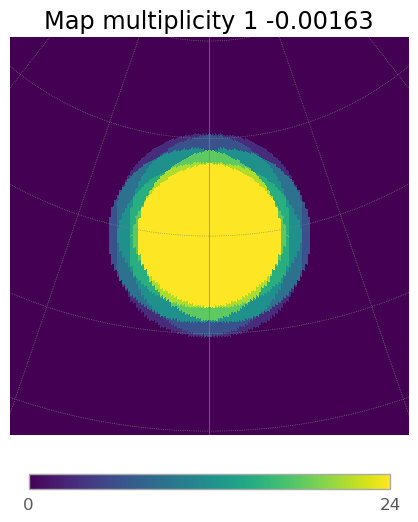

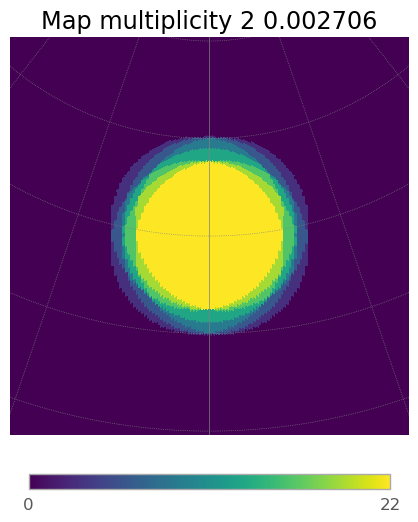

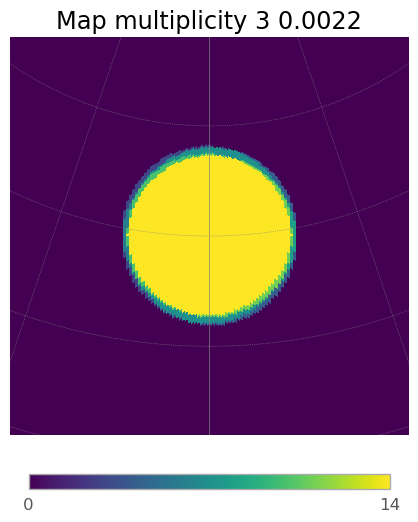

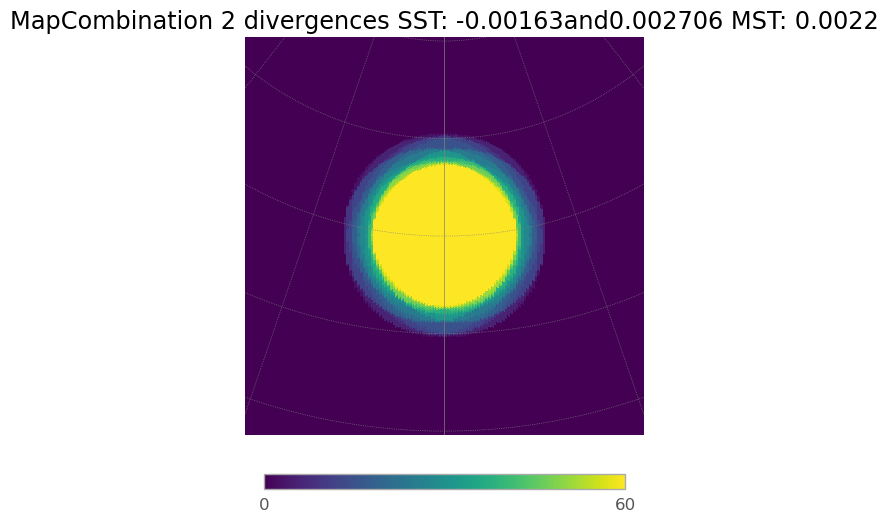

the barycenter for the calculations[-0.67307692  0.         27.68615385]
the barycenter for the calculations of the second divergence[-0.67307692  0.         27.68615385]


6it [00:01,  4.67it/s]
7it [00:01,  3.60it/s]
4it [00:00,  4.63it/s]
6it [00:01,  4.78it/s]


10.38234806580255


7it [00:01,  5.09it/s]
4it [00:00,  4.98it/s]


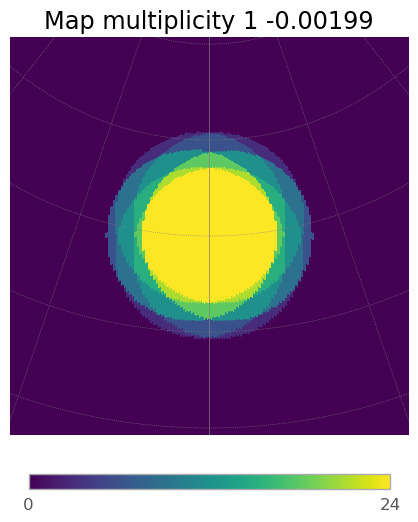

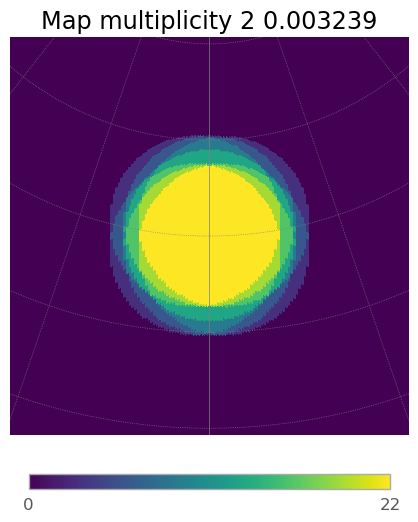

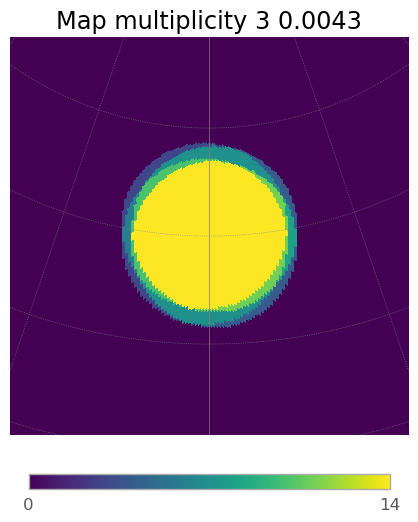

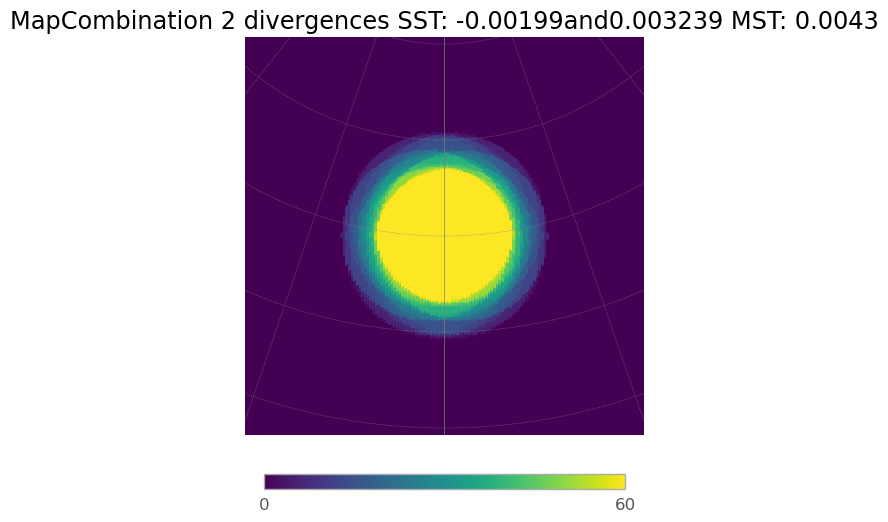

the barycenter for the calculations[-0.67307692  0.         27.68615385]
the barycenter for the calculations of the second divergence[-0.67307692  0.         27.68615385]


6it [00:01,  4.98it/s]
7it [00:01,  5.07it/s]
4it [00:00,  4.25it/s]
6it [00:01,  4.44it/s]


10.6793351773081


7it [00:01,  4.47it/s]
4it [00:00,  4.75it/s]


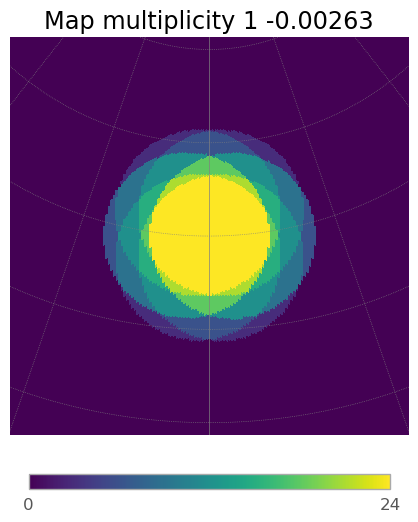

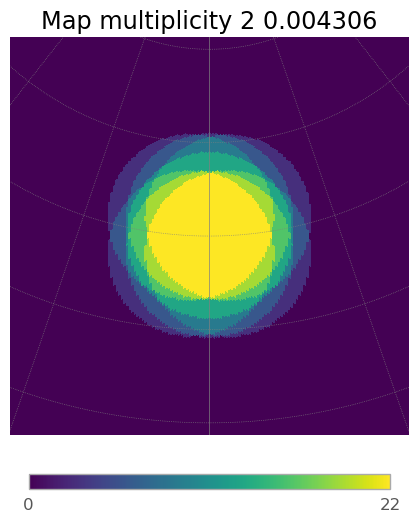

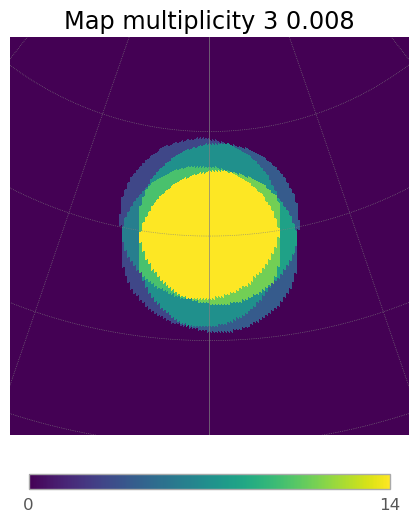

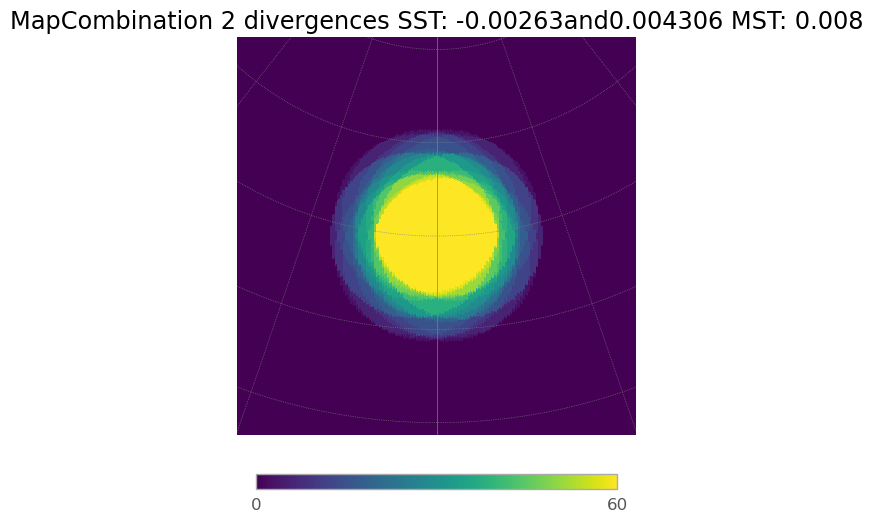

the barycenter for the calculations[-0.67307692  0.         27.68615385]
the barycenter for the calculations of the second divergence[-0.67307692  0.         27.68615385]


6it [00:01,  3.77it/s]
7it [00:01,  4.32it/s]
4it [00:00,  4.66it/s]
6it [00:01,  3.97it/s]


10.976231771331125


7it [00:01,  4.14it/s]
4it [00:00,  4.72it/s]


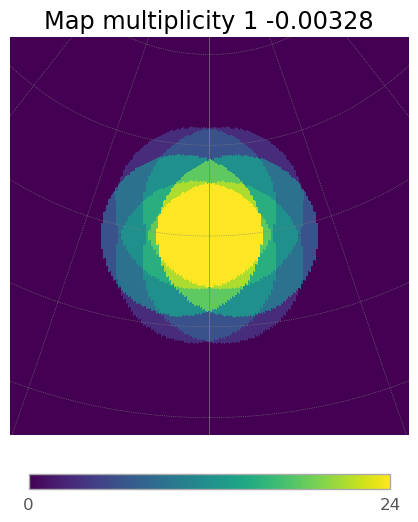

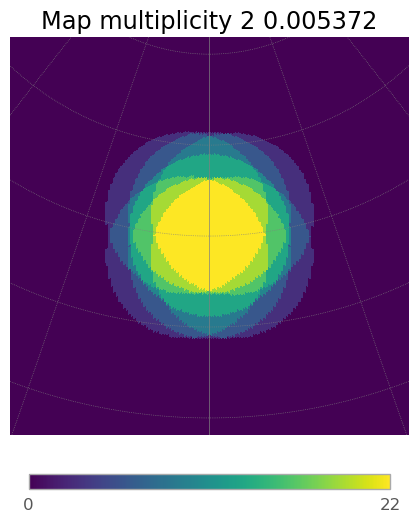

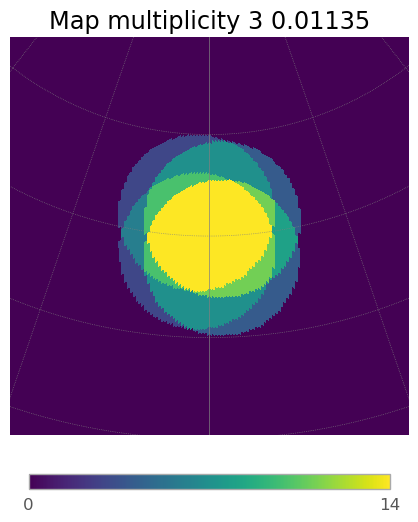

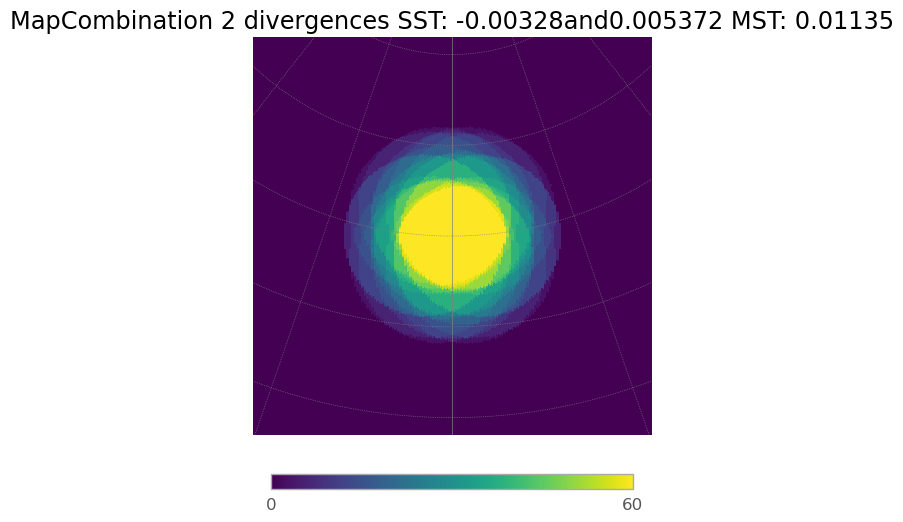

the barycenter for the calculations[-0.67307692  0.         27.68615385]
the barycenter for the calculations of the second divergence[-0.67307692  0.         27.68615385]


6it [00:01,  5.12it/s]
7it [00:01,  4.98it/s]
4it [00:00,  4.99it/s]
6it [00:01,  4.90it/s]


11.269389742337863


7it [00:01,  5.24it/s]
4it [00:00,  5.01it/s]


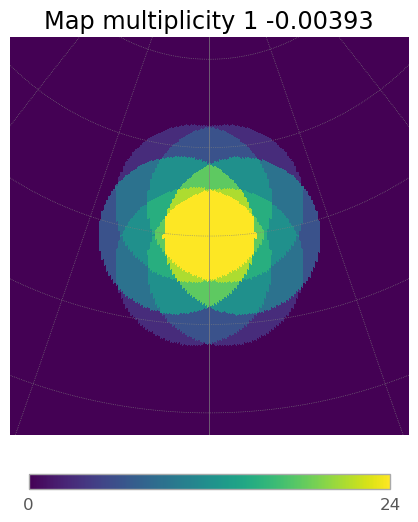

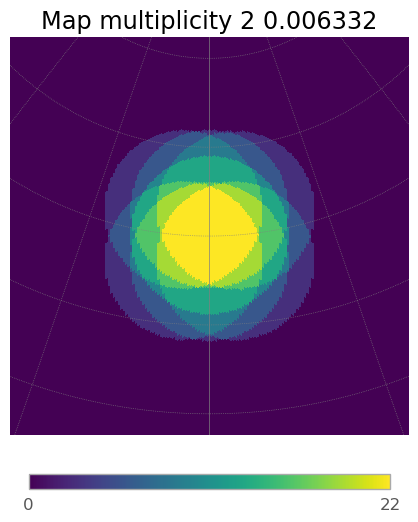

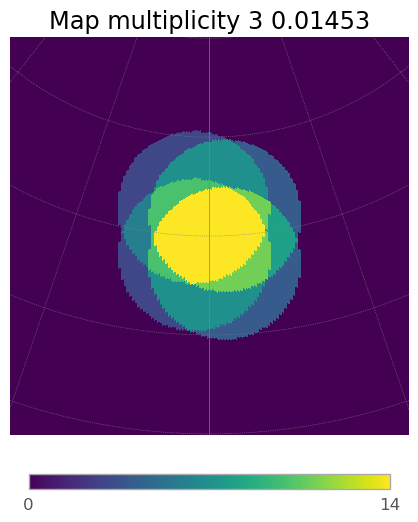

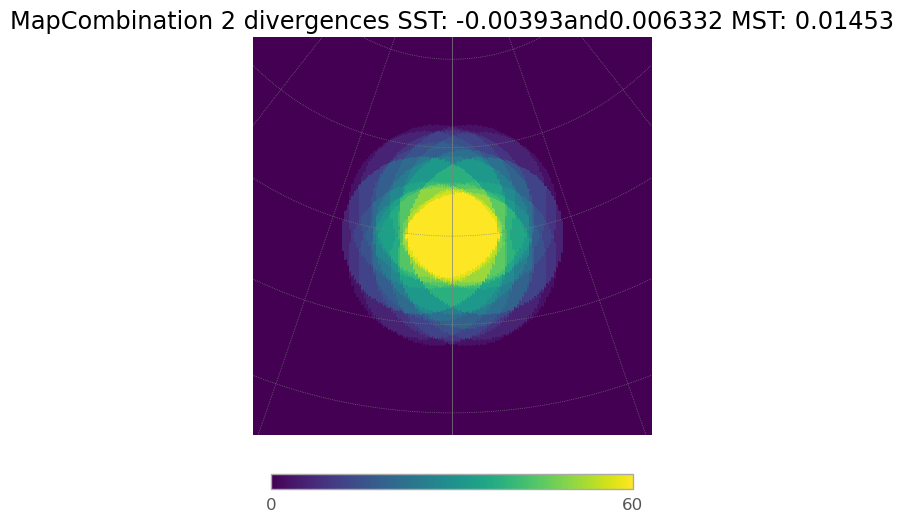

the barycenter for the calculations[-0.67307692  0.         27.68615385]
the barycenter for the calculations of the second divergence[-0.67307692  0.         27.68615385]


6it [00:01,  4.01it/s]
7it [00:01,  4.09it/s]
4it [00:00,  4.12it/s]
6it [00:01,  3.61it/s]


11.592636396802419


7it [00:01,  3.83it/s]
4it [00:00,  4.09it/s]


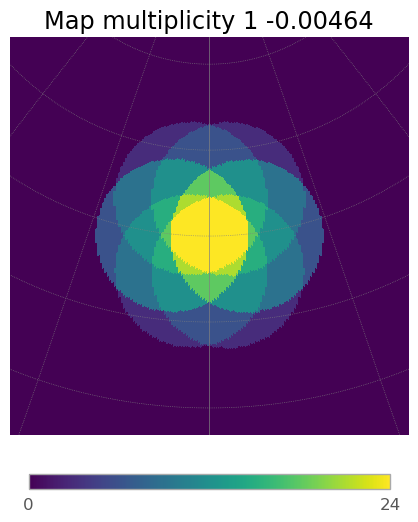

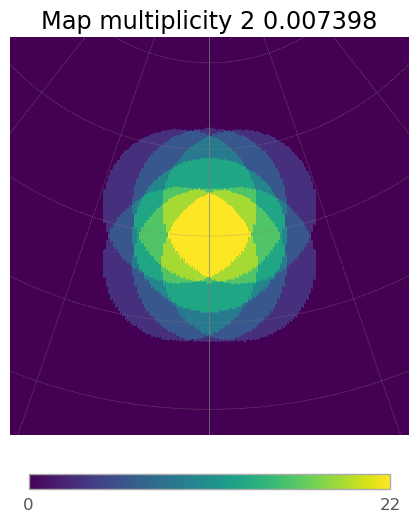

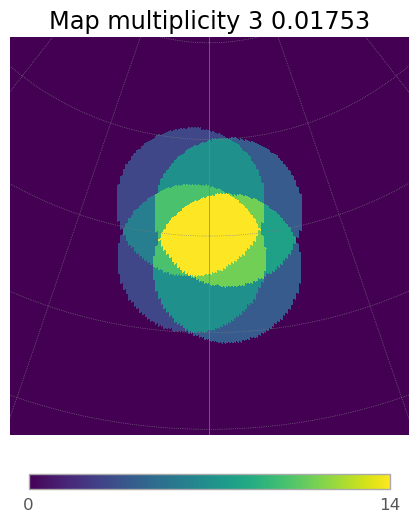

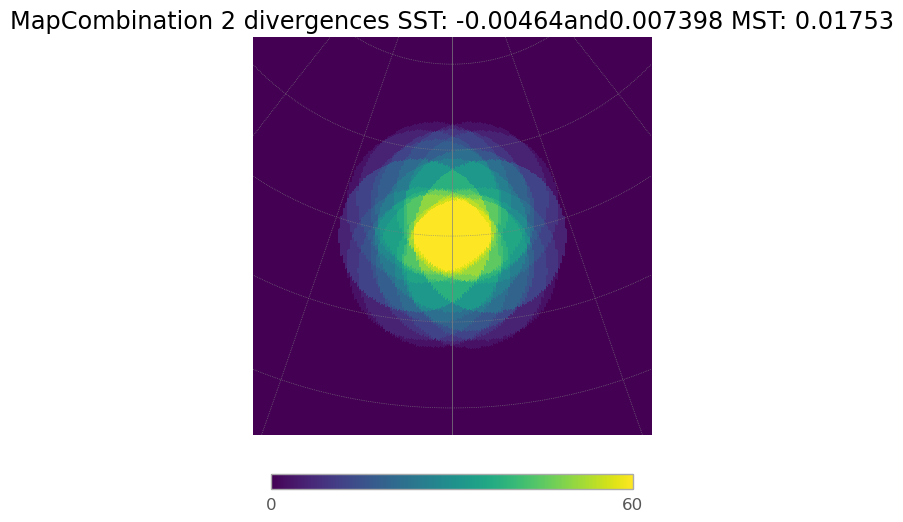

the barycenter for the calculations[-0.67307692  0.         27.68615385]
the barycenter for the calculations of the second divergence[-0.67307692  0.         27.68615385]


6it [00:01,  4.28it/s]
7it [00:01,  3.66it/s]
4it [00:01,  3.76it/s]
6it [00:01,  4.13it/s]


11.850976258994718


7it [00:01,  5.31it/s]
4it [00:00,  5.26it/s]


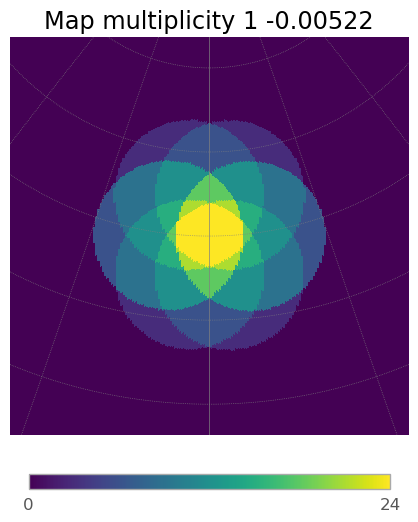

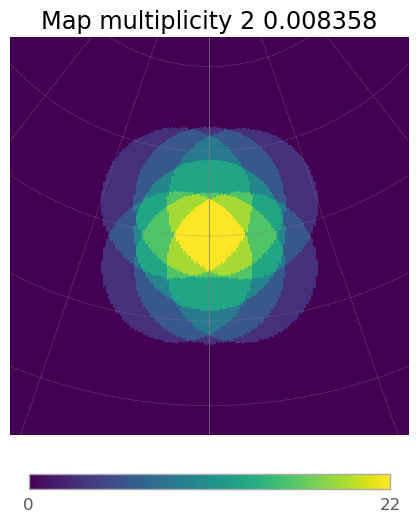

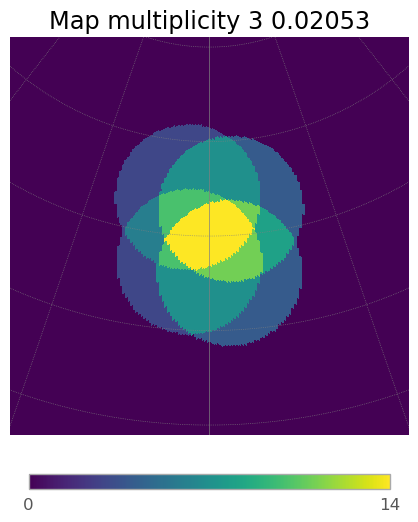

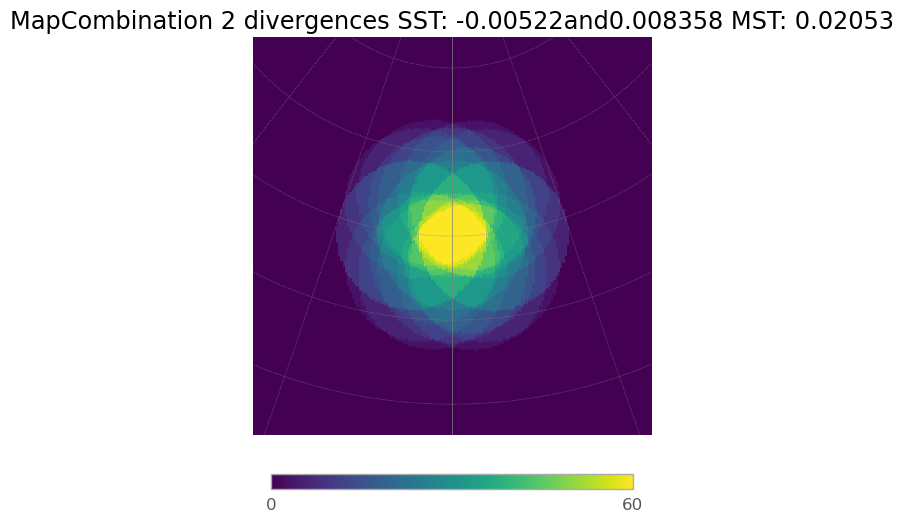

the barycenter for the calculations[-0.67307692  0.         27.68615385]
the barycenter for the calculations of the second divergence[-0.67307692  0.         27.68615385]


6it [00:01,  4.02it/s]
7it [00:01,  3.84it/s]
4it [00:01,  3.92it/s]
6it [00:01,  4.41it/s]


12.072235301050366


7it [00:01,  4.19it/s]
4it [00:00,  4.18it/s]


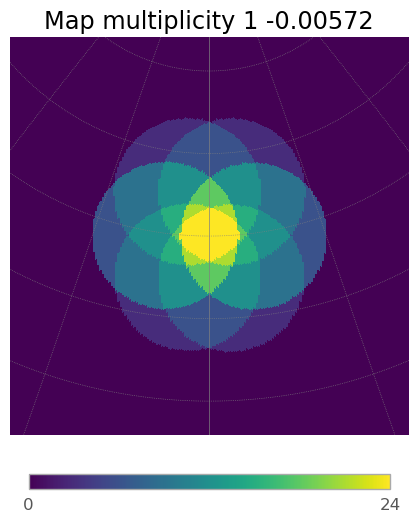

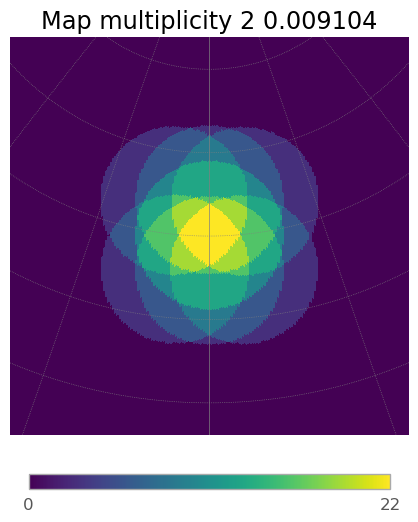

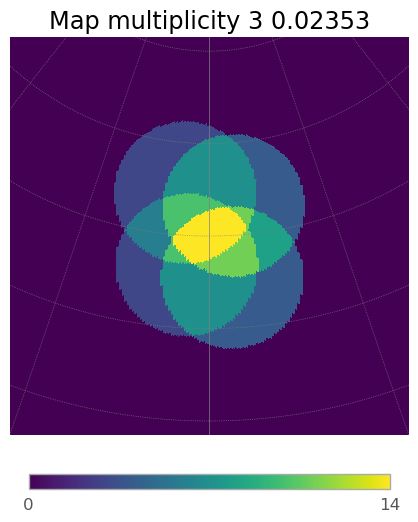

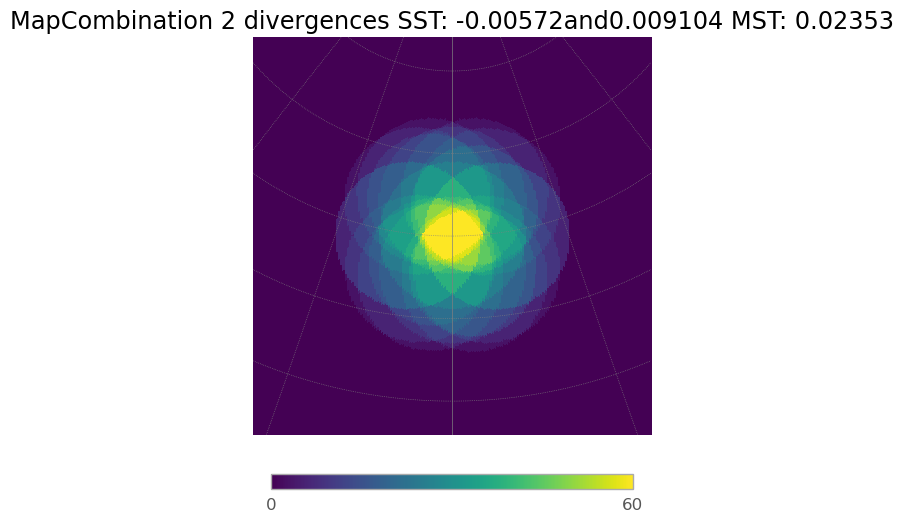

the barycenter for the calculations[-0.67307692  0.         27.68615385]
the barycenter for the calculations of the second divergence[-0.67307692  0.         27.68615385]


6it [00:01,  3.73it/s]
7it [00:01,  4.24it/s]
4it [00:00,  4.05it/s]
6it [00:01,  3.96it/s]


12.324775153926488


7it [00:01,  4.35it/s]
4it [00:00,  5.54it/s]


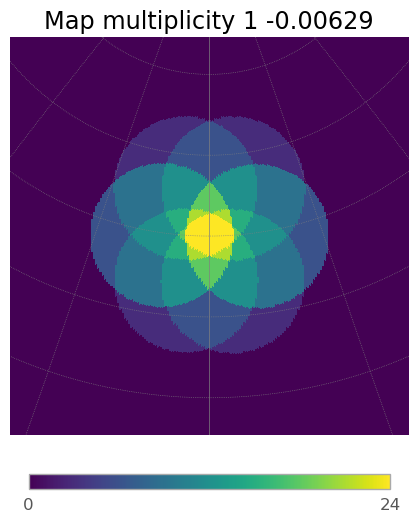

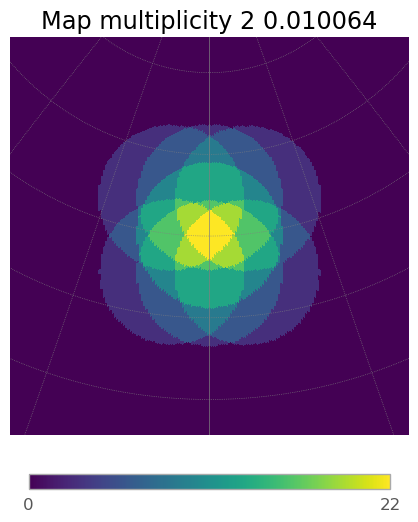

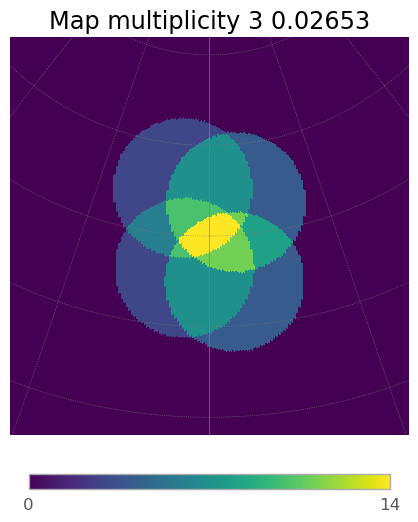

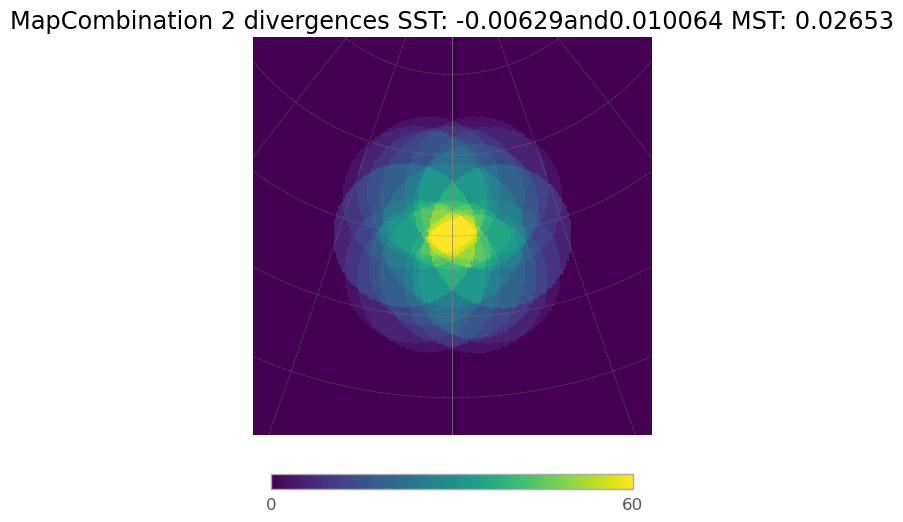

the barycenter for the calculations[-0.67307692  0.         27.68615385]
the barycenter for the calculations of the second divergence[-0.67307692  0.         27.68615385]


6it [00:01,  4.15it/s]
7it [00:01,  4.29it/s]
4it [00:01,  3.92it/s]
6it [00:01,  4.79it/s]


12.57936498097892


7it [00:01,  4.82it/s]
4it [00:00,  5.38it/s]


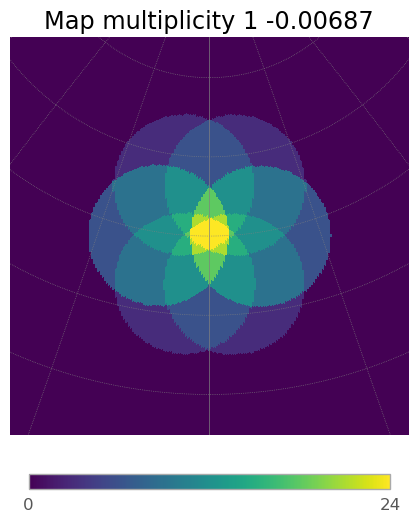

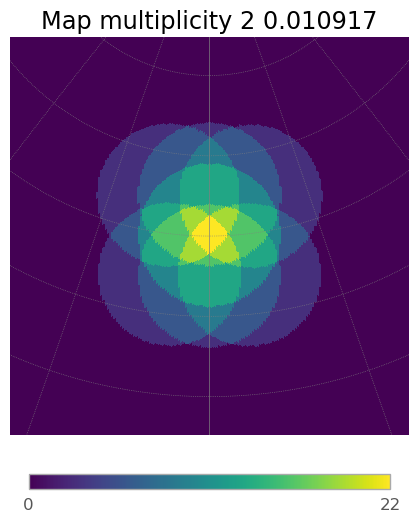

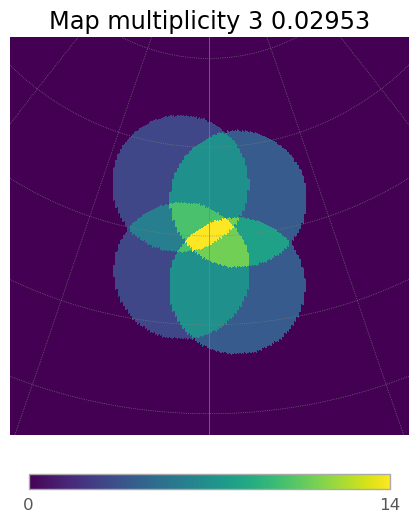

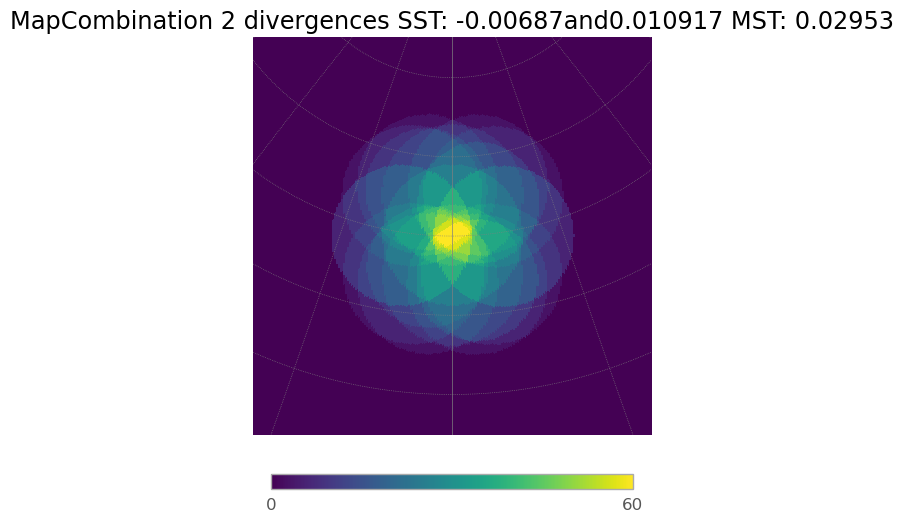

In [107]:
div_SST=divergence_list
conv_SST=convergence_list
for i in range(10):
    config_MST.divergent_pointing(div_MST[i], az=0,alt=70)
    SST_config_conv.divergent_pointing_2_div(tel_group_2=SST_config_div, complete_array=full_array_config_SST, div1=conv_SST[i], div2=div_SST[i], az=0, alt=70)
    SST_config_conv.multiplicity_plot_3_config(array_2=SST_config_div,array_3=config_MST, subarray_mult_1=number_of_telescopes_config_SST_first_half, subarray_mult_2=number_of_telescopes_config_SST_second_half, subarray_mult_3= number_of_telescopes_subarray_1)



In [108]:
SST_config_conv.combiantion_of_FoV(number_of_arrays=3, array_2=SST_config_div, array_3=config_MST, subarray_mult_1=number_of_telescopes_config_SST_first_half, subarray_mult_2=number_of_telescopes_config_SST_second_half, subarray_mult_3=number_of_telescopes_subarray_1)

6it [00:01,  4.45it/s]
7it [00:01,  4.24it/s]
4it [00:00,  4.38it/s]


(188.09357426974634, 18.670222408143346)

In [124]:
hFoV_combine

[86.80132246332364,
 92.51901042132471,
 103.71833499961122,
 115.38976225332901,
 127.0087336542211,
 140.7259391681411,
 152.65964568598739,
 162.79673924455352,
 175.53039751799167,
 188.09357426974634]

In [122]:
m_ave_combine

[40.46336304577731,
 37.963855421686745,
 33.87090656214439,
 30.44175474485737,
 27.644398554465667,
 24.959463237349734,
 23.01202645820806,
 21.569034960528434,
 20.004109077325364,
 18.670222408143346]

In [109]:
div_SST=divergence_list
conv_SST=convergence_list
m_ave_combine=[]
hFoV_combine=[]
for i in range(10):
    config_MST.divergent_pointing(div_MST[i], az=0,alt=70)
    SST_config_conv.divergent_pointing_2_div(tel_group_2=SST_config_div, complete_array=full_array_config_SST, div1=conv_SST[i], div2=div_SST[i], az=0, alt=70)
    hFoV_combine.append(SST_config_conv.combiantion_of_FoV(number_of_arrays=3, array_2=SST_config_div, array_3=config_MST, subarray_mult_1=number_of_telescopes_config_SST_first_half, subarray_mult_2=number_of_telescopes_config_SST_second_half, subarray_mult_3=number_of_telescopes_subarray_1)[0])
    m_ave_combine.append(SST_config_conv.combiantion_of_FoV(number_of_arrays=3, array_2=SST_config_div, array_3=config_MST, subarray_mult_1=number_of_telescopes_config_SST_first_half, subarray_mult_2=number_of_telescopes_config_SST_second_half, subarray_mult_3=number_of_telescopes_subarray_1)[1])





the barycenter for the calculations[-0.67307692  0.         27.68615385]
the barycenter for the calculations of the second divergence[-0.67307692  0.         27.68615385]


6it [00:01,  4.64it/s]
7it [00:01,  4.32it/s]
4it [00:00,  4.77it/s]
6it [00:01,  5.05it/s]
7it [00:01,  4.98it/s]
4it [00:00,  4.82it/s]


the barycenter for the calculations[-0.67307692  0.         27.68615385]
the barycenter for the calculations of the second divergence[-0.67307692  0.         27.68615385]


6it [00:01,  5.02it/s]
7it [00:01,  4.86it/s]
4it [00:00,  5.01it/s]
6it [00:01,  4.13it/s]
7it [00:01,  4.46it/s]
4it [00:00,  4.92it/s]


the barycenter for the calculations[-0.67307692  0.         27.68615385]
the barycenter for the calculations of the second divergence[-0.67307692  0.         27.68615385]


6it [00:01,  4.79it/s]
7it [00:01,  5.07it/s]
4it [00:00,  4.69it/s]
6it [00:01,  4.91it/s]
7it [00:01,  5.04it/s]
4it [00:00,  4.83it/s]


the barycenter for the calculations[-0.67307692  0.         27.68615385]
the barycenter for the calculations of the second divergence[-0.67307692  0.         27.68615385]


6it [00:01,  4.22it/s]
7it [00:01,  4.01it/s]
4it [00:00,  4.22it/s]
6it [00:01,  4.11it/s]
7it [00:01,  3.85it/s]
4it [00:00,  4.08it/s]


the barycenter for the calculations[-0.67307692  0.         27.68615385]
the barycenter for the calculations of the second divergence[-0.67307692  0.         27.68615385]


6it [00:01,  4.33it/s]
7it [00:01,  4.29it/s]
4it [00:00,  4.18it/s]
6it [00:01,  4.49it/s]
7it [00:01,  4.92it/s]
4it [00:00,  5.06it/s]


the barycenter for the calculations[-0.67307692  0.         27.68615385]
the barycenter for the calculations of the second divergence[-0.67307692  0.         27.68615385]


6it [00:01,  4.84it/s]
7it [00:01,  4.57it/s]
4it [00:00,  4.85it/s]
6it [00:01,  3.95it/s]
7it [00:01,  4.83it/s]
4it [00:00,  4.85it/s]


the barycenter for the calculations[-0.67307692  0.         27.68615385]
the barycenter for the calculations of the second divergence[-0.67307692  0.         27.68615385]


6it [00:01,  4.99it/s]
7it [00:01,  4.63it/s]
4it [00:00,  4.65it/s]
6it [00:01,  4.74it/s]
7it [00:01,  4.40it/s]
4it [00:01,  3.81it/s]


the barycenter for the calculations[-0.67307692  0.         27.68615385]
the barycenter for the calculations of the second divergence[-0.67307692  0.         27.68615385]


6it [00:01,  4.47it/s]
7it [00:01,  5.76it/s]
4it [00:00,  5.47it/s]
6it [00:01,  4.38it/s]
7it [00:01,  6.28it/s]
4it [00:00,  6.59it/s]


the barycenter for the calculations[-0.67307692  0.         27.68615385]
the barycenter for the calculations of the second divergence[-0.67307692  0.         27.68615385]


6it [00:00,  6.58it/s]
7it [00:01,  6.62it/s]
4it [00:00,  6.59it/s]
6it [00:00,  6.46it/s]
7it [00:01,  5.95it/s]
4it [00:00,  5.59it/s]


the barycenter for the calculations[-0.67307692  0.         27.68615385]
the barycenter for the calculations of the second divergence[-0.67307692  0.         27.68615385]


6it [00:01,  5.74it/s]
7it [00:01,  6.26it/s]
4it [00:00,  6.21it/s]
6it [00:00,  6.57it/s]
7it [00:01,  6.14it/s]
4it [00:00,  6.56it/s]


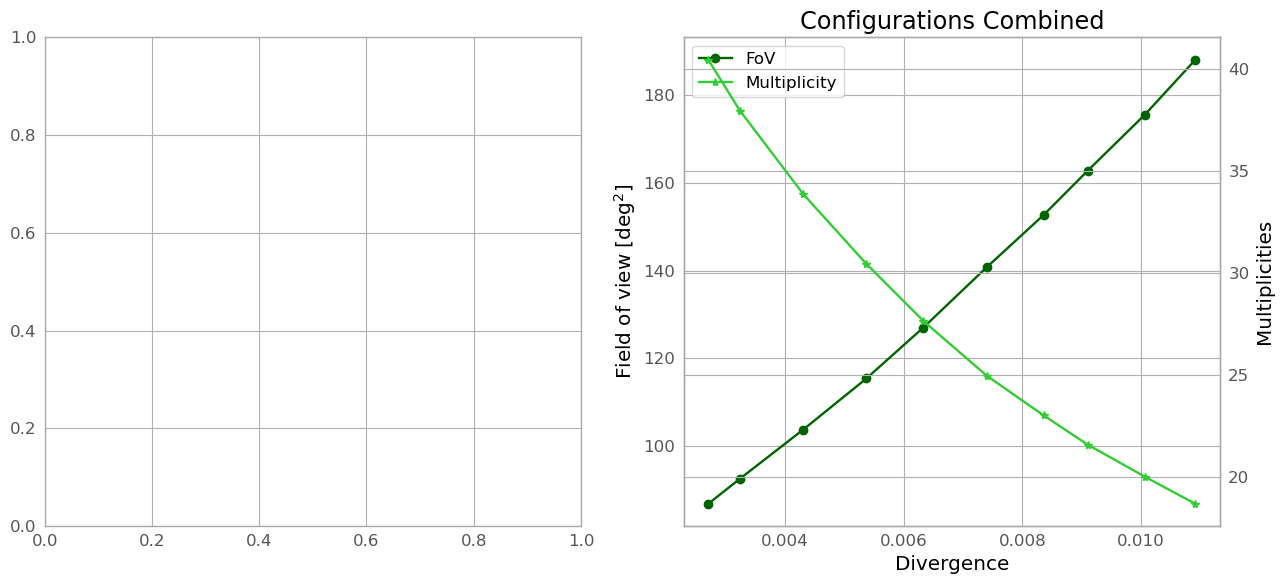

In [110]:
fig, axes = plt.subplots(1, 2, figsize=(13, 6)) 
# Plot Full Array
# Full Array with m_cut = 3
#l1=axes[0].plot(chosen_divergences, FoV_full_array, label='FoV', marker='o', color='darkgreen')
#ax2 = axes[0].twinx()
#l2=ax2.plot(chosen_divergences, multiplicity_full_array, label='Multiplicities',marker='*', color='limegreen')
#axes[0].set_title('Full Array m_cut 3')
#axes[0].set_xlabel('Divergence')
#axes[0].set_ylabel('Field of view (m > 3) [deg$^2$]')
#ax2.set_ylabel('Multiplicities (m>3)')
#axeslegend = l1+l2
#axes[0].legend(axeslegend, [l.get_label() for l in axeslegend])



#Plot the ones for subarray 1
l1=axes[1].plot(divergence_list,hFoV_combine, label='FoV',marker='o', color='darkgreen')
ax5=axes[1].twinx()
l2=ax5.plot(divergence_list, m_ave_combine, label='Multiplicity', marker='*', color='limegreen')
axes[1].set_title('Configurations Combined')
axes[1].set_xlabel('Divergence')
axes[1].set_ylabel('Field of view [deg$^2$]')
ax5.set_ylabel('Multiplicities')
axeslegend = l1+l2
axes[1].legend(axeslegend, [l.get_label() for l in axeslegend])
#Plot the ones for subarray 2

# Adjust layout
plt.tight_layout()
# Subarray 4
# Adjust layout
plt.show()

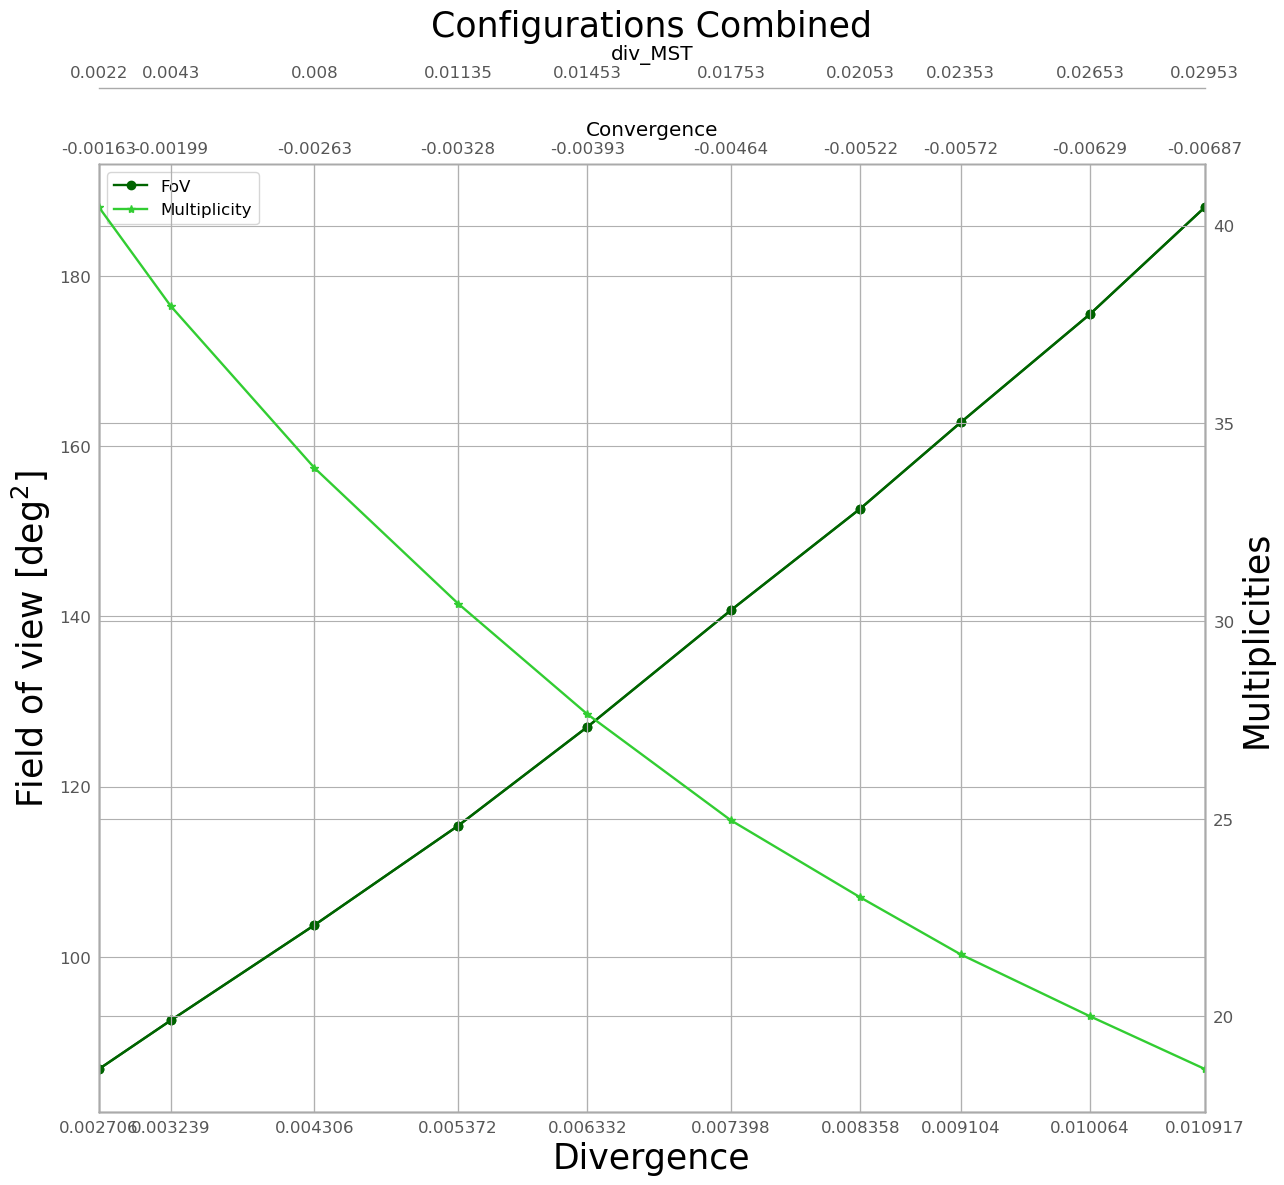

In [158]:
fig, axes = plt.subplots(1, 1, figsize=(13, 12))
ax = axes

# -----------------------------
# Primary plot on ax (left y-axis)
# -----------------------------
l1 = ax.plot(divergence_list, hFoV_combine, label='FoV', marker='o', color='darkgreen')
ax.set_xlabel('Divergence', fontsize = 25)
ax.set_ylabel('Field of view [deg$^2$]', fontsize = 25)
ax.set_title('Configurations Combined', fontsize = 25)
ax.set_xticks(divergence_list)
ax.set_xlim(min(divergence_list), max(divergence_list))

# Create a twin x-axis for Convergence (top)
ax_top1 = ax.twiny()
ax_top1.set_xlabel('Convergence')
ax_top1.set_xticks(divergence_list)  # Use the same positions
ax_top1.set_xticklabels(convergence_list)  # Direct mapping
ax_top1.set_xlim(ax.get_xlim())

# Create a second twin x-axis for div_MST (offset further up)
ax_top2 = ax.twiny()
ax_top2.spines["top"].set_position(("axes", 1.08))  # Adjust this factor as needed
ax_top2.set_xlabel('div_MST')
ax_top2.set_xticks(divergence_list)
ax_top2.set_xticklabels(div_MST)
ax_top2.set_xlim(ax.get_xlim())
l1=ax.plot(divergence_list,hFoV_combine, label='FoV',marker='o',color='darkgreen')
ax5=ax.twinx()
l2=ax5.plot(divergence_list, m_ave_combine, label='Multiplicity', marker='*', color='limegreen')
ax.set_title('Configurations Combined', fontsize = 25)
ax.set_xlabel('Divergence')
ax.set_ylabel('Field of view [deg$^2$]')
ax5.set_ylabel('Multiplicities', fontsize = 25)
axeslegend = l1+l2
ax.legend(axeslegend, [l.get_label() for l in axeslegend])
plt.tight_layout()
plt.show()

In [111]:
print(SST_config_conv.barycenter)

[-1.10000000e-01 -1.89478063e-14  3.12916667e+01]


In [112]:
print(SST_config_div.barycenter)

[-1.15571429  0.         24.59571429]


In [113]:
print(full_array_config_SST.barycenter)

[-0.67307692  0.         27.68615385]


the barycenter for the calculations[-0.67307692  0.         27.68615385]
the barycenter for the calculations of the second divergence[-0.67307692  0.         27.68615385]
0


6it [00:00,  6.88it/s]
7it [00:00,  7.25it/s]
4it [00:00,  7.29it/s]
6it [00:00,  7.20it/s]
7it [00:00,  7.41it/s]
4it [00:00,  7.40it/s]


(86.80132246332364, 40.46336304577731)


6it [00:00,  7.09it/s]
7it [00:00,  7.17it/s]
4it [00:00,  6.63it/s]


3


6it [00:01,  4.64it/s]
7it [00:00,  7.33it/s]
4it [00:00,  7.21it/s]
6it [00:00,  7.14it/s]
7it [00:00,  7.19it/s]
4it [00:00,  7.31it/s]


(84.7948860927407, 41.349829879369004)


6it [00:00,  7.26it/s]
7it [00:00,  7.13it/s]
4it [00:00,  7.00it/s]


6


6it [00:00,  7.20it/s]
7it [00:00,  7.39it/s]
4it [00:00,  7.41it/s]
6it [00:00,  7.13it/s]
7it [00:00,  7.46it/s]
4it [00:00,  7.35it/s]


(80.1918850072857, 43.37890433360589)


6it [00:00,  6.74it/s]
7it [00:00,  7.20it/s]
4it [00:00,  7.11it/s]


9


6it [00:00,  7.35it/s]
7it [00:00,  7.09it/s]
4it [00:00,  6.98it/s]
6it [00:00,  6.73it/s]
7it [00:01,  6.83it/s]
4it [00:00,  6.56it/s]


(77.92316937257426, 44.379838438236284)


6it [00:00,  6.89it/s]
7it [00:00,  7.19it/s]
4it [00:00,  7.09it/s]


12


6it [00:00,  6.46it/s]
7it [00:00,  7.22it/s]
4it [00:00,  7.08it/s]
6it [00:00,  6.48it/s]
7it [00:00,  7.15it/s]
4it [00:00,  6.81it/s]


(72.7431539060366, 46.68559581755904)


6it [00:01,  5.98it/s]
7it [00:01,  6.73it/s]
4it [00:00,  7.39it/s]


15


6it [00:00,  7.30it/s]
7it [00:00,  7.16it/s]
4it [00:00,  7.25it/s]
6it [00:00,  6.75it/s]
7it [00:01,  6.81it/s]
4it [00:00,  6.76it/s]


(67.40577088102184, 49.19455252918288)


6it [00:00,  7.16it/s]
7it [00:01,  6.71it/s]
4it [00:00,  7.23it/s]


18


6it [00:00,  7.22it/s]
7it [00:00,  7.23it/s]
4it [00:00,  7.39it/s]
6it [00:00,  7.13it/s]
7it [00:00,  7.31it/s]
4it [00:00,  7.36it/s]


(64.06171026338359, 50.82292732855681)


6it [00:00,  7.11it/s]
7it [00:01,  6.86it/s]
4it [00:00,  7.14it/s]


21


6it [00:00,  7.28it/s]
7it [00:00,  7.38it/s]
4it [00:00,  7.32it/s]
6it [00:00,  7.23it/s]
7it [00:00,  7.36it/s]
4it [00:00,  7.40it/s]


(62.265097304103435, 51.68597304128054)


6it [00:00,  7.19it/s]
7it [00:00,  7.34it/s]
4it [00:00,  7.23it/s]


24


6it [00:00,  7.20it/s]
7it [00:00,  7.35it/s]
4it [00:00,  7.51it/s]
/Users/macbook/miniconda3/envs/divtel/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/macbook/miniconda3/envs/divtel/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
6it [00:00,  7.17it/s]
7it [00:00,  7.34it/s]
4it [00:00,  7.43it/s]


(61.89790633432355, 51.86207627118644)


6it [00:00,  7.25it/s]
7it [00:00,  7.22it/s]
4it [00:00,  7.18it/s]


27


6it [00:00,  7.23it/s]
7it [00:00,  7.15it/s]
4it [00:00,  7.30it/s]
6it [00:00,  7.14it/s]
7it [00:00,  7.30it/s]
4it [00:00,  7.36it/s]


(57.09819580077219, 54.12011943040882)


6it [00:00,  7.29it/s]
7it [00:00,  7.40it/s]
4it [00:00,  7.00it/s]


30


6it [00:00,  7.09it/s]
7it [00:00,  7.27it/s]
4it [00:00,  7.12it/s]
6it [00:00,  7.23it/s]
7it [00:00,  7.25it/s]
4it [00:00,  7.33it/s]


(54.3180356010102, 55.45702559150169)


6it [00:00,  7.26it/s]
7it [00:00,  7.34it/s]
4it [00:00,  7.38it/s]


33


6it [00:00,  7.39it/s]
7it [00:01,  6.25it/s]
4it [00:00,  6.33it/s]
6it [00:00,  6.83it/s]
7it [00:00,  7.26it/s]
4it [00:00,  7.18it/s]


(51.27559613711972, 56.905626598465474)


6it [00:00,  7.12it/s]
7it [00:01,  6.80it/s]
4it [00:00,  6.00it/s]


36


6it [00:00,  6.77it/s]
7it [00:00,  7.09it/s]
4it [00:00,  7.07it/s]
6it [00:00,  7.11it/s]
7it [00:00,  7.18it/s]
4it [00:00,  7.31it/s]


(50.17402322778006, 57.39963408259278)


6it [00:00,  7.12it/s]
7it [00:00,  7.45it/s]
4it [00:00,  7.10it/s]


39


6it [00:00,  6.95it/s]
7it [00:00,  7.28it/s]
4it [00:00,  6.83it/s]
6it [00:00,  7.12it/s]
7it [00:00,  7.14it/s]
4it [00:00,  7.11it/s]


(47.9971053355136, 58.29535519125683)


6it [00:00,  7.03it/s]
7it [00:00,  7.19it/s]
4it [00:00,  7.22it/s]


42


6it [00:00,  7.24it/s]
7it [00:00,  7.39it/s]
4it [00:00,  7.33it/s]
6it [00:00,  7.00it/s]
7it [00:00,  7.15it/s]
4it [00:00,  7.44it/s]


(46.67259505166473, 58.78701882551278)


6it [00:00,  7.09it/s]
7it [00:00,  7.24it/s]
4it [00:00,  7.32it/s]


45


6it [00:00,  7.17it/s]
7it [00:00,  7.15it/s]
4it [00:00,  7.34it/s]
6it [00:00,  7.13it/s]
7it [00:00,  7.29it/s]
4it [00:00,  7.18it/s]


(45.75461762721501, 59.08225852679851)


6it [00:00,  7.40it/s]
7it [00:00,  7.41it/s]
4it [00:00,  7.08it/s]


48


6it [00:00,  7.29it/s]
7it [00:00,  7.44it/s]
4it [00:00,  7.08it/s]
6it [00:00,  6.21it/s]
7it [00:01,  6.83it/s]
4it [00:00,  7.10it/s]


(44.1416001528248, 59.520499108734406)


6it [00:00,  6.97it/s]
7it [00:00,  7.22it/s]
4it [00:00,  7.13it/s]


51


6it [00:00,  6.99it/s]
7it [00:00,  7.11it/s]
4it [00:00,  7.19it/s]
6it [00:00,  7.11it/s]
7it [00:00,  7.07it/s]
4it [00:00,  7.11it/s]


(42.659722310498836, 59.834306793728864)


6it [00:00,  7.01it/s]
7it [00:00,  7.17it/s]
4it [00:00,  7.09it/s]


54


6it [00:00,  7.06it/s]
7it [00:00,  7.11it/s]
4it [00:00,  7.10it/s]
6it [00:00,  7.06it/s]
7it [00:00,  7.12it/s]
4it [00:00,  7.22it/s]


(41.89911244452622, 59.94804381846635)


6it [00:00,  7.10it/s]
7it [00:00,  7.12it/s]
4it [00:00,  7.26it/s]


57


6it [00:00,  6.99it/s]
7it [00:00,  7.26it/s]
4it [00:00,  7.16it/s]
6it [00:00,  6.91it/s]
7it [00:01,  6.66it/s]
4it [00:00,  6.74it/s]


(41.19095843137929, 60.0)


6it [00:00,  6.84it/s]
7it [00:01,  5.94it/s]
4it [00:00,  6.79it/s]


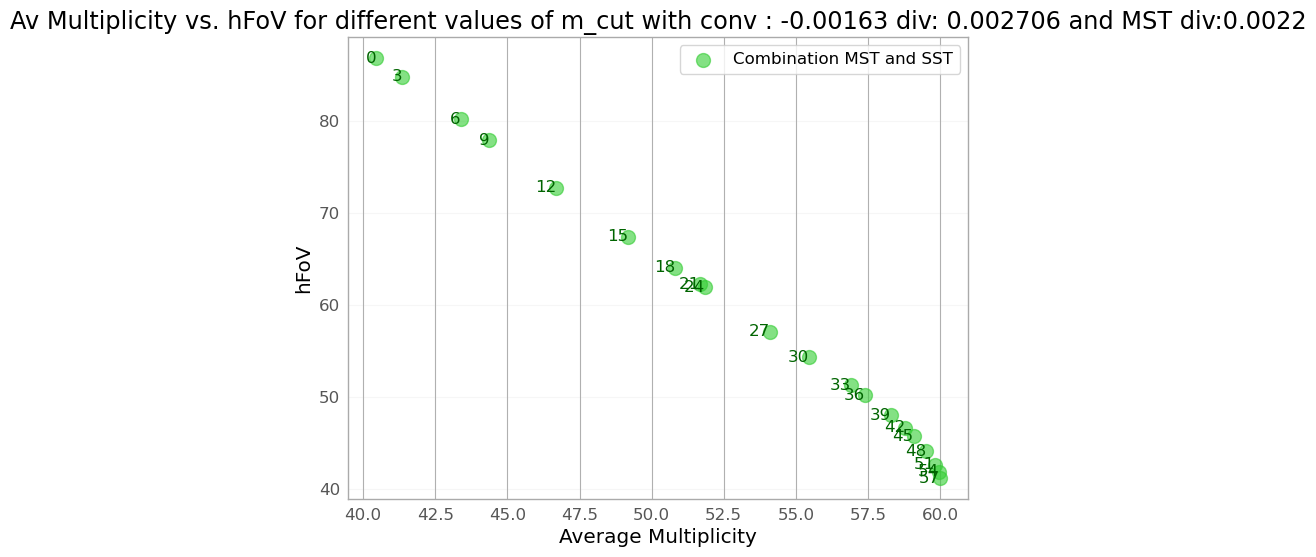

the barycenter for the calculations[-0.67307692  0.         27.68615385]
the barycenter for the calculations of the second divergence[-0.67307692  0.         27.68615385]
0


6it [00:00,  6.52it/s]
7it [00:01,  6.83it/s]
4it [00:00,  6.99it/s]
6it [00:00,  6.89it/s]
7it [00:00,  7.10it/s]
4it [00:00,  7.10it/s]


(92.51901042132471, 37.963855421686745)


6it [00:00,  6.76it/s]
7it [00:00,  7.06it/s]
4it [00:00,  6.82it/s]


3


6it [00:00,  7.09it/s]
7it [00:00,  7.12it/s]
4it [00:00,  6.98it/s]
6it [00:00,  6.99it/s]
7it [00:01,  6.42it/s]
4it [00:00,  5.97it/s]


(89.96178759607194, 38.957725947521865)


6it [00:00,  6.35it/s]
7it [00:01,  6.57it/s]
4it [00:00,  6.49it/s]


6


6it [00:00,  6.89it/s]
7it [00:01,  6.92it/s]
4it [00:00,  6.80it/s]
6it [00:00,  6.45it/s]
7it [00:01,  6.41it/s]
4it [00:00,  6.61it/s]


(84.16541585883232, 41.22748519788096)


6it [00:00,  6.50it/s]
7it [00:01,  6.86it/s]
4it [00:00,  6.69it/s]


9


6it [00:00,  6.62it/s]
7it [00:01,  6.91it/s]
4it [00:00,  6.61it/s]
6it [00:00,  6.72it/s]
7it [00:01,  5.95it/s]
4it [00:00,  6.80it/s]


(81.4245975486896, 42.31228861330327)


6it [00:00,  6.70it/s]
7it [00:01,  5.59it/s]
4it [00:00,  6.30it/s]


12


6it [00:01,  5.43it/s]
7it [00:01,  5.93it/s]
4it [00:00,  6.52it/s]
6it [00:00,  6.68it/s]
7it [00:01,  6.92it/s]
4it [00:00,  6.72it/s]


(74.81516009265167, 44.99018404907975)


6it [00:00,  6.28it/s]
7it [00:01,  6.35it/s]
4it [00:00,  6.75it/s]


15


6it [00:01,  5.49it/s]
7it [00:01,  6.69it/s]
4it [00:00,  6.82it/s]
6it [00:00,  6.75it/s]
7it [00:01,  6.51it/s]
4it [00:00,  6.29it/s]


(67.94344337248523, 48.02335456475584)


6it [00:00,  6.84it/s]
7it [00:00,  7.17it/s]
4it [00:00,  7.01it/s]


18


6it [00:00,  6.58it/s]
7it [00:00,  7.24it/s]
4it [00:00,  7.06it/s]
6it [00:00,  7.29it/s]
7it [00:00,  7.27it/s]
4it [00:00,  7.09it/s]


(64.04859630017717, 49.8490990990991)


6it [00:00,  7.21it/s]
7it [00:00,  7.31it/s]
4it [00:00,  7.18it/s]


21


6it [00:00,  7.23it/s]
7it [00:00,  7.05it/s]
4it [00:00,  6.84it/s]
6it [00:00,  7.03it/s]
7it [00:00,  7.11it/s]
4it [00:00,  7.20it/s]


(62.16018559845204, 50.72974683544304)


6it [00:00,  7.22it/s]
7it [00:01,  6.95it/s]
4it [00:00,  7.34it/s]


24


6it [00:00,  7.24it/s]
7it [00:00,  7.28it/s]
4it [00:00,  7.34it/s]
6it [00:00,  7.08it/s]
7it [00:00,  7.14it/s]
4it [00:00,  7.36it/s]


(61.57005725416294, 51.00511182108626)


6it [00:00,  6.65it/s]
7it [00:00,  7.19it/s]
4it [00:00,  7.35it/s]


27


6it [00:00,  7.34it/s]
7it [00:00,  7.08it/s]
4it [00:00,  7.21it/s]
6it [00:00,  7.19it/s]
7it [00:00,  7.25it/s]
4it [00:00,  7.17it/s]


(57.29490524886856, 52.945525291828794)


6it [00:00,  7.33it/s]
7it [00:00,  7.19it/s]
4it [00:00,  7.20it/s]


30


6it [00:00,  6.97it/s]
7it [00:00,  7.30it/s]
4it [00:00,  6.91it/s]
6it [00:00,  7.08it/s]
7it [00:00,  7.34it/s]
4it [00:00,  7.39it/s]


(54.69834053399651, 54.117477823064014)


6it [00:00,  7.29it/s]
7it [00:00,  7.37it/s]
4it [00:00,  7.07it/s]


33


6it [00:00,  7.15it/s]
7it [00:00,  7.27it/s]
4it [00:00,  7.26it/s]
6it [00:00,  7.30it/s]
7it [00:00,  7.36it/s]
4it [00:00,  7.27it/s]


(52.285371304014404, 55.1597692500627)


6it [00:00,  7.30it/s]
7it [00:00,  7.30it/s]
4it [00:00,  7.36it/s]


36


6it [00:00,  7.33it/s]
7it [00:00,  7.35it/s]
4it [00:00,  7.48it/s]
6it [00:00,  7.13it/s]
7it [00:00,  7.25it/s]
4it [00:00,  7.14it/s]


(49.937971890064425, 56.125525210084035)


6it [00:00,  7.18it/s]
7it [00:00,  7.31it/s]
4it [00:00,  7.34it/s]


39


6it [00:00,  7.33it/s]
7it [00:00,  7.01it/s]
4it [00:00,  7.35it/s]
6it [00:00,  7.23it/s]
7it [00:00,  7.23it/s]
4it [00:00,  7.10it/s]


(46.52834145639406, 57.45941375422773)


6it [00:00,  7.01it/s]
7it [00:00,  7.13it/s]
4it [00:00,  7.32it/s]


42


6it [00:00,  7.09it/s]
7it [00:00,  7.29it/s]
4it [00:00,  6.95it/s]
6it [00:00,  7.28it/s]
7it [00:00,  7.10it/s]
4it [00:00,  7.35it/s]


(44.12848618961838, 58.354531946508175)


6it [00:00,  7.17it/s]
7it [00:00,  7.08it/s]
4it [00:00,  7.18it/s]


45


6it [00:00,  7.28it/s]
7it [00:00,  7.22it/s]
4it [00:00,  6.98it/s]
6it [00:00,  7.32it/s]
7it [00:00,  7.35it/s]
4it [00:00,  7.23it/s]


(42.72529212653096, 58.816144874155924)


6it [00:00,  7.21it/s]
7it [00:00,  7.31it/s]
4it [00:00,  6.90it/s]


48


6it [00:00,  6.85it/s]
7it [00:00,  7.23it/s]
4it [00:00,  6.84it/s]
6it [00:01,  5.96it/s]
7it [00:01,  6.61it/s]
4it [00:00,  6.93it/s]


(40.96802105687008, 59.315300896286814)


6it [00:00,  6.83it/s]
7it [00:00,  7.31it/s]
4it [00:00,  7.16it/s]


51


6it [00:00,  7.26it/s]
7it [00:00,  7.15it/s]
4it [00:00,  7.37it/s]
6it [00:00,  6.57it/s]
7it [00:00,  7.33it/s]
4it [00:00,  6.89it/s]


(38.88290090704859, 59.78887015177066)


6it [00:00,  7.22it/s]
7it [00:01,  6.49it/s]
4it [00:00,  6.50it/s]


54


6it [00:00,  6.88it/s]
7it [00:00,  7.00it/s]
4it [00:00,  6.60it/s]
6it [00:00,  7.03it/s]
7it [00:01,  6.97it/s]
4it [00:00,  7.20it/s]


(37.9780374458053, 59.93853591160221)


6it [00:00,  7.20it/s]
7it [00:00,  7.09it/s]
4it [00:00,  7.13it/s]


57


6it [00:00,  6.88it/s]
7it [00:00,  7.24it/s]
4it [00:00,  6.58it/s]
6it [00:00,  6.28it/s]
7it [00:00,  7.21it/s]
4it [00:00,  7.28it/s]


(37.25676946945195, 60.0)


6it [00:00,  7.13it/s]
7it [00:00,  7.23it/s]
4it [00:00,  7.26it/s]


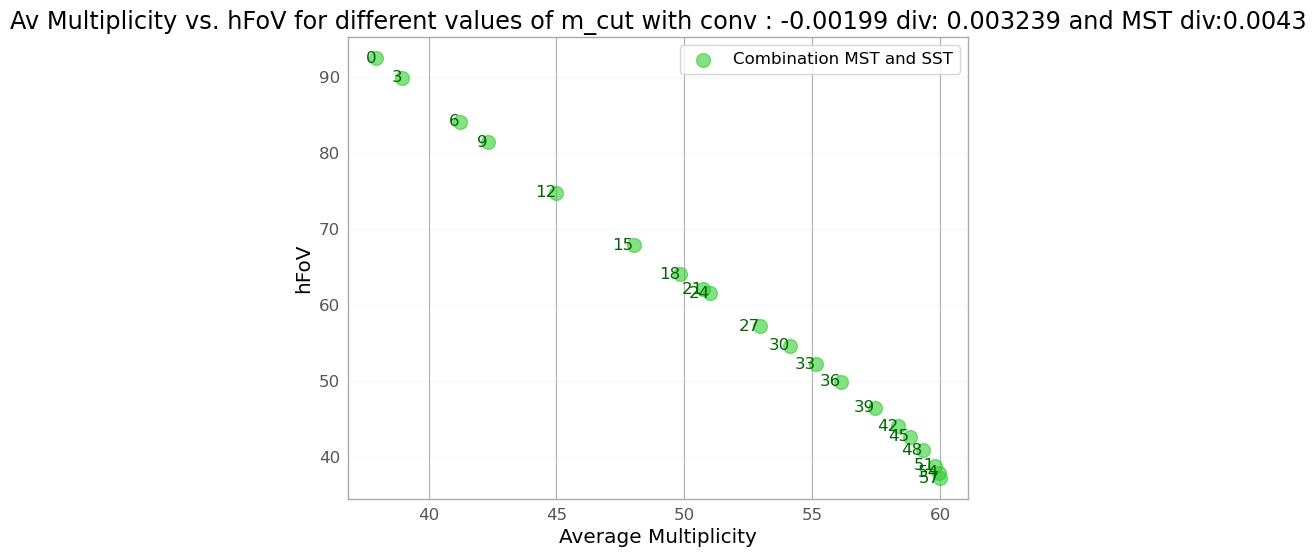

the barycenter for the calculations[-0.67307692  0.         27.68615385]
the barycenter for the calculations of the second divergence[-0.67307692  0.         27.68615385]
0


6it [00:00,  7.27it/s]
7it [00:00,  7.37it/s]
4it [00:00,  7.30it/s]
6it [00:00,  7.13it/s]
7it [00:00,  7.41it/s]
4it [00:00,  7.32it/s]


(103.71833499961122, 33.87090656214439)


6it [00:00,  7.34it/s]
7it [00:00,  7.16it/s]
4it [00:00,  7.21it/s]


3


6it [00:00,  7.22it/s]
7it [00:00,  7.26it/s]
4it [00:00,  7.41it/s]
6it [00:00,  7.23it/s]
7it [00:00,  7.45it/s]
4it [00:00,  7.34it/s]


(99.86282981692243, 35.06277084701247)


6it [00:00,  6.98it/s]
7it [00:00,  7.35it/s]
4it [00:00,  7.42it/s]


6


6it [00:00,  7.23it/s]
7it [00:00,  7.17it/s]
4it [00:00,  7.19it/s]
6it [00:00,  7.05it/s]
7it [00:00,  7.35it/s]
4it [00:00,  6.98it/s]


(91.79774244497136, 37.616142857142854)


6it [00:00,  7.18it/s]
7it [00:00,  7.38it/s]
4it [00:00,  7.20it/s]


9


6it [00:00,  7.21it/s]
7it [00:00,  7.02it/s]
4it [00:00,  6.99it/s]
6it [00:00,  6.80it/s]
7it [00:00,  7.37it/s]
4it [00:00,  7.39it/s]


(87.23408324913565, 39.11319903788334)


6it [00:00,  7.28it/s]
7it [00:00,  7.30it/s]
4it [00:00,  7.33it/s]


12


6it [00:00,  7.11it/s]
7it [00:00,  7.32it/s]
4it [00:00,  7.12it/s]
6it [00:00,  7.24it/s]
7it [00:00,  7.19it/s]
4it [00:00,  7.30it/s]


(78.2641324159413, 42.22067694369973)


6it [00:00,  7.16it/s]
7it [00:00,  7.40it/s]
4it [00:00,  7.39it/s]


15


6it [00:00,  7.35it/s]
7it [00:00,  7.27it/s]
4it [00:00,  7.33it/s]
6it [00:00,  7.20it/s]
7it [00:00,  7.20it/s]
4it [00:00,  7.26it/s]


(69.72694236855897, 45.5535076170773)


6it [00:00,  7.20it/s]
7it [00:00,  7.07it/s]
4it [00:00,  7.36it/s]


18


6it [00:00,  7.14it/s]
7it [00:00,  7.34it/s]
4it [00:00,  7.10it/s]
6it [00:00,  7.14it/s]
7it [00:00,  7.43it/s]
4it [00:00,  6.83it/s]


(65.80586736983804, 47.195296931048226)


6it [00:00,  7.04it/s]
7it [00:00,  7.02it/s]
4it [00:00,  5.67it/s]


21


6it [00:00,  6.20it/s]
7it [00:01,  6.74it/s]
4it [00:00,  6.72it/s]
6it [00:00,  6.26it/s]
7it [00:01,  6.05it/s]
4it [00:00,  6.90it/s]


(63.87811477849365, 47.998152330117016)


6it [00:00,  6.59it/s]
7it [00:01,  7.00it/s]
4it [00:00,  6.51it/s]


24


6it [00:00,  6.73it/s]
7it [00:00,  7.42it/s]
4it [00:00,  7.23it/s]
6it [00:00,  7.27it/s]
7it [00:00,  7.17it/s]
4it [00:00,  7.21it/s]


(62.27821126730986, 48.65108443882923)


6it [00:00,  7.07it/s]
7it [00:00,  7.23it/s]
4it [00:00,  7.08it/s]


27


6it [00:01,  5.05it/s]
7it [00:01,  6.66it/s]
4it [00:00,  7.23it/s]
6it [00:00,  7.09it/s]
7it [00:00,  7.36it/s]
4it [00:00,  7.20it/s]


(60.12752130145625, 49.48680479825518)


6it [00:00,  6.65it/s]
7it [00:00,  7.23it/s]
4it [00:00,  7.11it/s]


30


6it [00:00,  7.08it/s]
7it [00:00,  7.23it/s]
4it [00:00,  7.30it/s]
6it [00:00,  7.00it/s]
7it [00:00,  7.29it/s]
4it [00:00,  7.37it/s]


(55.09175943018924, 51.40633182575577)


6it [00:00,  7.34it/s]
7it [00:00,  7.25it/s]
4it [00:00,  7.11it/s]


33


6it [00:00,  7.14it/s]
7it [00:00,  7.48it/s]
4it [00:00,  7.20it/s]
6it [00:00,  7.20it/s]
7it [00:00,  7.12it/s]
4it [00:00,  7.25it/s]


(50.33139078625716, 53.2608129233976)


6it [00:00,  7.23it/s]
7it [00:00,  7.19it/s]
4it [00:00,  7.21it/s]


36


6it [00:00,  7.11it/s]
7it [00:00,  7.45it/s]
4it [00:00,  7.27it/s]
6it [00:00,  7.38it/s]
7it [00:00,  7.38it/s]
4it [00:00,  7.40it/s]


(47.26272339595383, 54.45283018867924)


6it [00:00,  7.18it/s]
7it [00:00,  7.41it/s]
4it [00:00,  7.44it/s]


39


6it [00:00,  7.03it/s]
7it [00:00,  7.38it/s]
4it [00:00,  7.48it/s]
6it [00:00,  7.34it/s]
7it [00:00,  7.17it/s]
4it [00:00,  6.43it/s]


(41.990910186971185, 56.51967520299812)


6it [00:00,  7.11it/s]
7it [00:00,  7.29it/s]
4it [00:00,  7.35it/s]


42


6it [00:00,  6.92it/s]
7it [00:00,  7.32it/s]
4it [00:00,  7.14it/s]
6it [00:00,  7.28it/s]
7it [00:00,  7.23it/s]
4it [00:00,  7.18it/s]


(39.643510773021205, 57.437975521005626)


6it [00:00,  7.28it/s]
7it [00:00,  7.28it/s]
4it [00:00,  7.16it/s]


45


6it [00:00,  7.01it/s]
7it [00:01,  6.20it/s]
4it [00:00,  6.67it/s]
6it [00:00,  6.69it/s]
7it [00:01,  6.91it/s]
4it [00:00,  6.81it/s]


(36.86335057325922, 58.423336890786196)


6it [00:00,  6.66it/s]
7it [00:01,  6.43it/s]
4it [00:00,  6.71it/s]


48


6it [00:00,  6.09it/s]
7it [00:01,  6.83it/s]
4it [00:00,  6.81it/s]
6it [00:00,  6.64it/s]
7it [00:01,  6.63it/s]
4it [00:00,  6.80it/s]


(35.3552448045204, 58.89985163204748)


6it [00:00,  6.72it/s]
7it [00:00,  7.12it/s]
4it [00:00,  6.95it/s]


51


6it [00:00,  6.56it/s]
7it [00:01,  6.58it/s]
4it [00:00,  6.89it/s]
6it [00:00,  6.75it/s]
7it [00:01,  6.91it/s]
4it [00:00,  6.91it/s]


(32.509514788726285, 59.63372327551432)


6it [00:00,  6.77it/s]
7it [00:01,  6.78it/s]
4it [00:00,  6.71it/s]


54


6it [00:00,  6.78it/s]
7it [00:01,  6.82it/s]
4it [00:00,  6.68it/s]
6it [00:00,  6.71it/s]
7it [00:01,  6.76it/s]
4it [00:00,  6.53it/s]


(31.303030173735237, 59.868035190615835)


6it [00:00,  6.67it/s]
7it [00:01,  6.73it/s]
4it [00:00,  6.57it/s]


57


6it [00:00,  6.69it/s]
7it [00:01,  6.90it/s]
4it [00:00,  6.97it/s]
6it [00:00,  7.02it/s]
7it [00:01,  6.87it/s]
4it [00:00,  7.34it/s]


(30.05720366912491, 60.0)


6it [00:00,  6.65it/s]
7it [00:00,  7.25it/s]
4it [00:00,  7.29it/s]


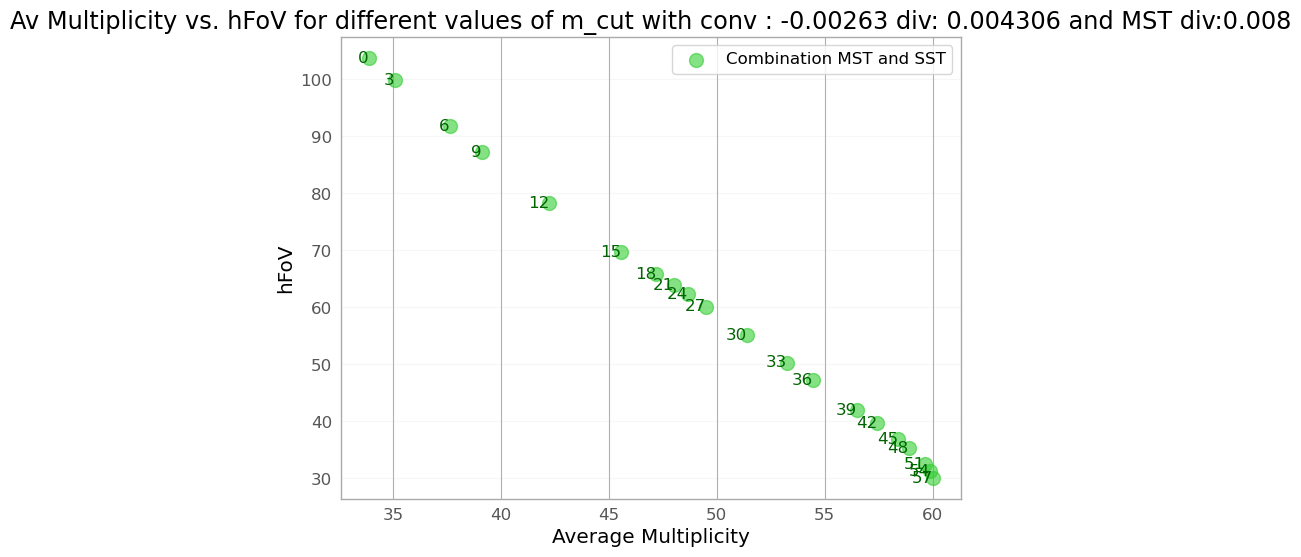

the barycenter for the calculations[-0.67307692  0.         27.68615385]
the barycenter for the calculations of the second divergence[-0.67307692  0.         27.68615385]
0


6it [00:00,  7.22it/s]
7it [00:00,  7.22it/s]
4it [00:00,  7.26it/s]
6it [00:00,  7.18it/s]
7it [00:00,  7.17it/s]
4it [00:00,  7.26it/s]


(115.38976225332901, 30.44175474485737)


6it [00:00,  7.17it/s]
7it [00:00,  7.20it/s]
4it [00:00,  7.32it/s]


3


6it [00:00,  7.19it/s]
7it [00:00,  7.30it/s]
4it [00:00,  7.31it/s]
6it [00:00,  7.07it/s]
7it [00:00,  7.25it/s]
4it [00:00,  7.20it/s]


(110.09172111793352, 31.76235854675402)


6it [00:00,  7.00it/s]
7it [00:00,  7.25it/s]
4it [00:00,  7.37it/s]


6


6it [00:00,  7.28it/s]
7it [00:00,  7.17it/s]
4it [00:00,  7.28it/s]
6it [00:00,  7.22it/s]
7it [00:00,  7.27it/s]
4it [00:00,  7.03it/s]


(99.45629695752326, 34.51727320675106)


6it [00:00,  7.27it/s]
7it [00:00,  7.37it/s]
4it [00:00,  7.21it/s]


9


6it [00:00,  7.23it/s]
7it [00:00,  7.39it/s]
4it [00:00,  7.12it/s]
6it [00:00,  7.30it/s]
7it [00:00,  7.39it/s]
4it [00:00,  7.24it/s]


(93.12225272882024, 36.25292212364456)


6it [00:00,  7.28it/s]
7it [00:00,  7.30it/s]
4it [00:00,  7.15it/s]


12


6it [00:00,  7.21it/s]
7it [00:00,  7.34it/s]
4it [00:00,  7.07it/s]
6it [00:00,  7.20it/s]
7it [00:00,  7.26it/s]
4it [00:00,  7.31it/s]


(81.66064888640524, 39.656977677854506)


6it [00:00,  7.18it/s]
7it [00:00,  7.31it/s]
4it [00:00,  7.22it/s]


15


6it [00:00,  7.16it/s]
7it [00:00,  7.36it/s]
4it [00:00,  6.57it/s]
6it [00:00,  7.19it/s]
7it [00:00,  7.27it/s]
4it [00:00,  7.14it/s]


(74.23814571156899, 42.12223988694577)


6it [00:00,  7.17it/s]
7it [00:00,  7.25it/s]
4it [00:00,  7.18it/s]


18


6it [00:00,  7.06it/s]
7it [00:00,  7.31it/s]
4it [00:00,  7.34it/s]
6it [00:00,  7.23it/s]
7it [00:00,  7.34it/s]
4it [00:00,  7.27it/s]


(70.38264052888019, 43.44959940376374)


6it [00:00,  7.16it/s]
7it [00:00,  7.28it/s]
4it [00:00,  7.31it/s]


21


6it [00:00,  7.13it/s]
7it [00:00,  7.25it/s]
4it [00:00,  6.88it/s]
6it [00:00,  7.23it/s]
7it [00:00,  7.26it/s]
4it [00:00,  7.30it/s]


(66.30419797168217, 44.89299841772152)


6it [00:00,  6.83it/s]
7it [00:00,  7.25it/s]
4it [00:00,  7.26it/s]


24


6it [00:01,  5.28it/s]
7it [00:00,  7.15it/s]
4it [00:00,  7.09it/s]
6it [00:00,  7.02it/s]
7it [00:00,  7.31it/s]
4it [00:00,  7.14it/s]


(62.92079546442466, 46.103793247186324)


6it [00:00,  6.48it/s]
7it [00:00,  7.13it/s]
4it [00:00,  7.21it/s]


27


6it [00:00,  7.22it/s]
7it [00:00,  7.30it/s]
4it [00:00,  7.05it/s]
6it [00:00,  7.13it/s]
7it [00:00,  7.04it/s]
4it [00:00,  6.97it/s]


(59.47182314113502, 47.30077177508269)


6it [00:00,  6.99it/s]
7it [00:00,  7.37it/s]
4it [00:00,  7.08it/s]


30


6it [00:00,  7.07it/s]
7it [00:01,  5.94it/s]
4it [00:00,  6.70it/s]
6it [00:00,  7.10it/s]
7it [00:00,  7.37it/s]
4it [00:00,  7.30it/s]


(54.370491453835896, 49.06681138446696)


6it [00:00,  7.26it/s]
7it [00:00,  7.27it/s]
4it [00:00,  7.10it/s]


33


6it [00:00,  7.09it/s]
7it [00:01,  5.77it/s]
4it [00:00,  6.69it/s]
6it [00:00,  6.31it/s]
7it [00:01,  6.88it/s]
4it [00:00,  7.35it/s]


(47.51188869687589, 51.54098813138283)


6it [00:00,  6.95it/s]
7it [00:00,  7.27it/s]
4it [00:00,  7.08it/s]


36


6it [00:00,  6.99it/s]
7it [00:01,  6.94it/s]
4it [00:00,  7.10it/s]
6it [00:00,  7.11it/s]
7it [00:00,  7.37it/s]
4it [00:00,  7.05it/s]


(43.21050876516866, 53.18998482549317)


6it [00:01,  5.51it/s]
7it [00:00,  7.28it/s]
4it [00:00,  7.08it/s]


39


6it [00:01,  5.58it/s]
7it [00:01,  6.93it/s]
4it [00:00,  5.12it/s]
6it [00:01,  5.61it/s]
7it [00:01,  6.26it/s]
4it [00:00,  6.92it/s]


(37.1780856902134, 55.65573192239859)


6it [00:00,  6.86it/s]
7it [00:01,  6.81it/s]
4it [00:00,  6.72it/s]


42


6it [00:00,  6.61it/s]
7it [00:01,  6.87it/s]
4it [00:00,  6.95it/s]
6it [00:00,  6.70it/s]
7it [00:01,  6.74it/s]
4it [00:00,  6.64it/s]


(35.210991209249734, 56.469646182495346)


6it [00:00,  6.61it/s]
7it [00:01,  6.87it/s]
4it [00:00,  6.72it/s]


45


6it [00:00,  6.66it/s]
7it [00:01,  6.74it/s]
4it [00:00,  6.39it/s]
6it [00:00,  6.41it/s]
7it [00:01,  6.67it/s]
4it [00:00,  6.57it/s]


(31.303030173735237, 57.97318810222036)


6it [00:00,  7.01it/s]
7it [00:01,  6.88it/s]
4it [00:00,  6.70it/s]


48


6it [00:00,  7.00it/s]
7it [00:01,  6.92it/s]
4it [00:00,  7.16it/s]
6it [00:00,  6.88it/s]
7it [00:00,  7.35it/s]
4it [00:00,  6.96it/s]


(29.82115233140927, 58.506156552330694)


6it [00:00,  7.06it/s]
7it [00:01,  6.79it/s]
4it [00:00,  7.13it/s]


51


6it [00:00,  7.02it/s]
7it [00:00,  7.33it/s]
4it [00:00,  7.06it/s]
6it [00:00,  6.72it/s]
7it [00:01,  5.39it/s]
4it [00:00,  5.20it/s]


(26.450863787358177, 59.524541398116014)


6it [00:00,  6.79it/s]
7it [00:00,  7.26it/s]
4it [00:00,  6.96it/s]


54


6it [00:00,  7.01it/s]
7it [00:00,  7.12it/s]
4it [00:00,  7.27it/s]
6it [00:00,  7.30it/s]
7it [00:00,  7.38it/s]
4it [00:00,  7.39it/s]


(25.296835025192824, 59.79315707620529)


6it [00:00,  7.28it/s]
7it [00:00,  7.24it/s]
4it [00:00,  7.43it/s]


57


6it [00:00,  7.34it/s]
7it [00:00,  7.40it/s]
4it [00:00,  7.35it/s]
6it [00:00,  7.06it/s]
7it [00:00,  7.18it/s]
4it [00:00,  7.27it/s]


(23.723159440421885, 60.0)


6it [00:00,  7.23it/s]
7it [00:00,  7.15it/s]
4it [00:00,  7.16it/s]


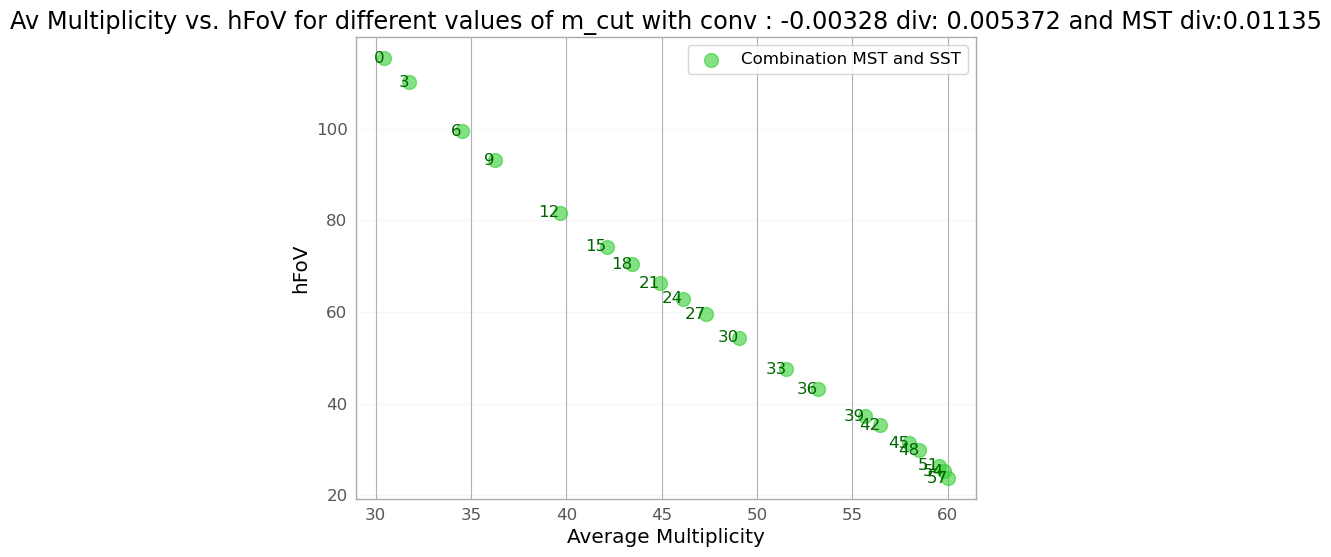

the barycenter for the calculations[-0.67307692  0.         27.68615385]
the barycenter for the calculations of the second divergence[-0.67307692  0.         27.68615385]
0


6it [00:00,  7.22it/s]
7it [00:00,  7.17it/s]
4it [00:00,  6.86it/s]
6it [00:00,  6.94it/s]
7it [00:00,  7.15it/s]
4it [00:00,  6.82it/s]


(127.0087336542211, 27.644398554465667)


6it [00:00,  6.56it/s]
7it [00:01,  6.72it/s]
4it [00:00,  5.25it/s]


3


6it [00:00,  6.27it/s]
7it [00:00,  7.18it/s]
4it [00:00,  6.73it/s]
6it [00:00,  6.85it/s]
7it [00:01,  6.97it/s]
4it [00:00,  7.32it/s]


(120.50420790383455, 28.97464359560344)


6it [00:00,  6.98it/s]
7it [00:00,  7.21it/s]
4it [00:00,  6.81it/s]


6


6it [00:00,  6.52it/s]
7it [00:00,  7.16it/s]
4it [00:00,  7.10it/s]
6it [00:00,  7.29it/s]
7it [00:00,  7.30it/s]
4it [00:00,  6.95it/s]


(106.59029294181818, 31.97367125984252)


6it [00:00,  7.22it/s]
7it [00:00,  7.24it/s]
4it [00:00,  7.24it/s]


9


6it [00:00,  6.84it/s]
7it [00:01,  6.69it/s]
4it [00:00,  6.72it/s]
6it [00:00,  6.80it/s]
7it [00:01,  6.44it/s]
4it [00:00,  5.60it/s]


(99.02353617171126, 33.72917494371607)


6it [00:00,  7.07it/s]
7it [00:01,  5.73it/s]
4it [00:00,  6.72it/s]


12


6it [00:00,  6.79it/s]
7it [00:01,  6.71it/s]
4it [00:00,  7.19it/s]
6it [00:00,  7.06it/s]
7it [00:00,  7.31it/s]
4it [00:00,  6.75it/s]


(86.00137070773175, 37.019365660262274)


6it [00:00,  7.15it/s]
7it [00:01,  6.91it/s]
4it [00:00,  6.66it/s]


15


6it [00:00,  7.02it/s]
7it [00:01,  6.84it/s]
4it [00:00,  6.58it/s]
6it [00:00,  6.78it/s]
7it [00:01,  6.36it/s]
4it [00:00,  7.07it/s]


(80.00828952239576, 38.674315685953125)


6it [00:00,  6.81it/s]
7it [00:00,  7.14it/s]
4it [00:00,  7.14it/s]


18


6it [00:00,  6.99it/s]
7it [00:01,  6.59it/s]
4it [00:00,  7.03it/s]
6it [00:00,  6.76it/s]
7it [00:00,  7.20it/s]
4it [00:00,  6.83it/s]


(74.0807781530919, 40.358293503274915)


6it [00:00,  6.89it/s]
7it [00:01,  6.12it/s]
4it [00:00,  7.11it/s]


21


6it [00:01,  5.96it/s]
7it [00:00,  7.14it/s]
4it [00:00,  7.20it/s]
6it [00:00,  6.65it/s]
7it [00:01,  6.67it/s]
4it [00:00,  7.09it/s]


(67.26151728575117, 42.4464807954767)


6it [00:01,  5.46it/s]
7it [00:01,  6.79it/s]
4it [00:00,  6.14it/s]


24


6it [00:00,  6.55it/s]
7it [00:00,  7.09it/s]
4it [00:00,  7.14it/s]
6it [00:00,  7.00it/s]
7it [00:00,  7.35it/s]
4it [00:00,  7.39it/s]


(62.78965583236042, 43.89160401002506)


6it [00:00,  7.18it/s]
7it [00:00,  7.01it/s]
4it [00:00,  7.17it/s]


27


6it [00:00,  7.01it/s]
7it [00:00,  7.21it/s]
4it [00:00,  7.02it/s]
6it [00:00,  7.30it/s]
7it [00:00,  7.28it/s]
4it [00:00,  7.05it/s]


(57.93748944598336, 45.42892711634224)


6it [00:00,  7.23it/s]
7it [00:00,  7.38it/s]
4it [00:00,  6.80it/s]


30


6it [00:00,  7.02it/s]
7it [00:00,  7.06it/s]
4it [00:00,  7.31it/s]
6it [00:00,  7.21it/s]
7it [00:00,  7.34it/s]
4it [00:00,  7.33it/s]


(53.29514647090909, 46.906003937007874)


6it [00:00,  6.94it/s]
7it [00:00,  7.51it/s]
4it [00:00,  6.36it/s]


33


6it [00:00,  6.94it/s]
7it [00:00,  7.20it/s]
4it [00:00,  7.39it/s]
6it [00:00,  7.14it/s]
7it [00:01,  5.91it/s]
4it [00:00,  6.67it/s]


(44.10225826320553, 50.0202200416295)


6it [00:00,  7.10it/s]
7it [00:01,  6.35it/s]
4it [00:00,  5.81it/s]


36


6it [00:01,  5.89it/s]
7it [00:00,  7.01it/s]
4it [00:00,  7.35it/s]
6it [00:00,  7.28it/s]
7it [00:00,  7.22it/s]
4it [00:00,  7.07it/s]


(38.843559017429314, 52.054017555705606)


6it [00:00,  7.15it/s]
7it [00:00,  7.14it/s]
4it [00:00,  7.36it/s]


39


6it [00:00,  7.00it/s]
7it [00:00,  7.19it/s]
4it [00:00,  7.19it/s]
6it [00:00,  6.88it/s]
7it [00:00,  7.35it/s]
4it [00:00,  6.98it/s]


(32.71933820002908, 54.6809619238477)


6it [00:00,  7.14it/s]
7it [00:00,  7.37it/s]
4it [00:00,  7.36it/s]


42


6it [00:00,  7.29it/s]
7it [00:00,  7.18it/s]
4it [00:00,  6.76it/s]
6it [00:00,  7.13it/s]
7it [00:00,  7.07it/s]
4it [00:00,  7.04it/s]


(30.46373652852407, 55.679294016358156)


6it [00:00,  7.13it/s]
7it [00:00,  7.11it/s]
4it [00:00,  7.19it/s]


45


6it [00:00,  6.93it/s]
7it [00:00,  7.33it/s]
4it [00:00,  7.39it/s]
6it [00:00,  7.27it/s]
7it [00:00,  7.13it/s]
4it [00:00,  7.22it/s]


(26.16235659681684, 57.531328320802004)


6it [00:00,  6.77it/s]
7it [00:00,  7.23it/s]
4it [00:00,  7.21it/s]


48


6it [00:00,  7.07it/s]
7it [00:01,  6.99it/s]
4it [00:00,  7.12it/s]
6it [00:00,  7.06it/s]
7it [00:00,  7.39it/s]
4it [00:00,  7.12it/s]


(24.66736479128445, 58.14832535885167)


6it [00:00,  7.21it/s]
7it [00:00,  7.23it/s]
4it [00:00,  6.51it/s]


51


6it [00:01,  4.92it/s]
7it [00:00,  7.12it/s]
4it [00:00,  6.78it/s]
6it [00:00,  6.87it/s]
7it [00:00,  7.28it/s]
4it [00:00,  7.48it/s]


(21.19216454158196, 59.39542079207921)


6it [00:00,  6.96it/s]
7it [00:01,  6.77it/s]
4it [00:00,  6.24it/s]


54


6it [00:00,  6.45it/s]
7it [00:01,  6.72it/s]
4it [00:00,  7.19it/s]
6it [00:00,  6.67it/s]
7it [00:01,  6.86it/s]
4it [00:00,  6.69it/s]


(19.972565963384486, 59.745239658568615)


6it [00:00,  6.26it/s]
7it [00:01,  6.84it/s]
4it [00:00,  6.37it/s]


57


6it [00:00,  7.04it/s]
7it [00:01,  6.91it/s]
4it [00:00,  6.96it/s]
6it [00:00,  7.04it/s]
7it [00:00,  7.07it/s]
4it [00:00,  7.35it/s]


(18.43823226823282, 60.0)


6it [00:00,  6.54it/s]
7it [00:01,  5.52it/s]
4it [00:00,  4.94it/s]


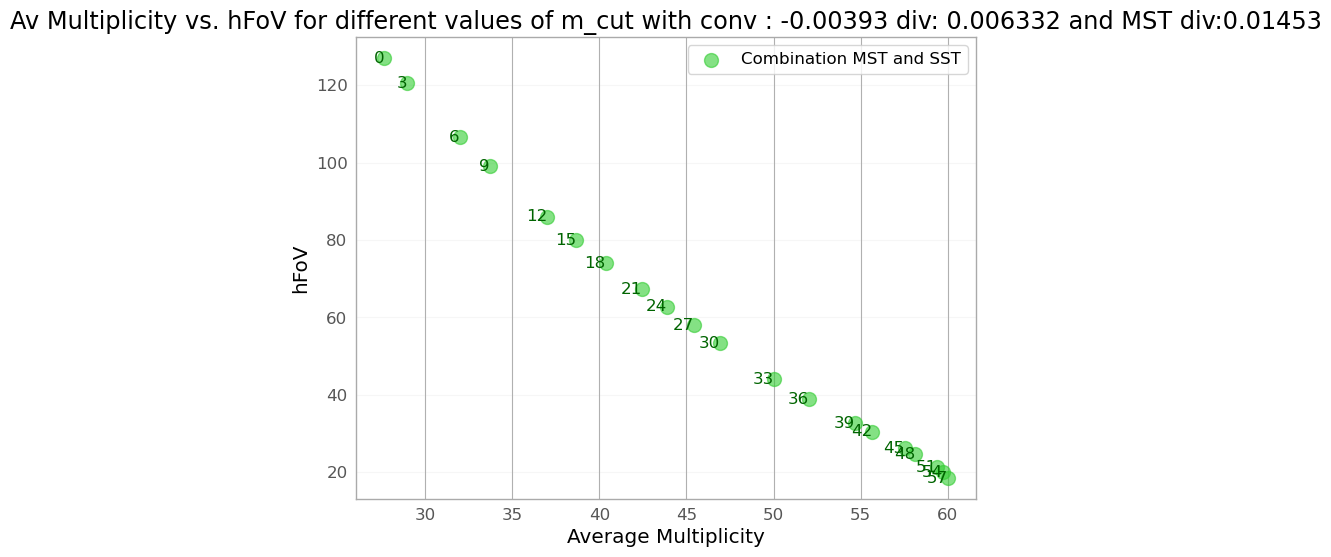

the barycenter for the calculations[-0.67307692  0.         27.68615385]
the barycenter for the calculations of the second divergence[-0.67307692  0.         27.68615385]
0


6it [00:00,  7.16it/s]
7it [00:00,  7.19it/s]
4it [00:00,  7.38it/s]
6it [00:00,  7.37it/s]
7it [00:00,  7.35it/s]
4it [00:00,  6.86it/s]


(140.7259391681411, 24.959463237349734)


6it [00:00,  7.19it/s]
7it [00:00,  7.23it/s]
4it [00:00,  7.08it/s]


3


6it [00:00,  7.37it/s]
7it [00:00,  7.08it/s]
4it [00:00,  7.39it/s]
6it [00:00,  7.08it/s]
7it [00:00,  7.35it/s]
4it [00:00,  7.24it/s]


(132.2543189367909, 26.366088249876054)


6it [00:00,  7.24it/s]
7it [00:00,  7.18it/s]
4it [00:00,  7.06it/s]


6


6it [00:00,  7.36it/s]
7it [00:00,  7.23it/s]
4it [00:00,  7.26it/s]
6it [00:00,  6.99it/s]
7it [00:00,  7.07it/s]
4it [00:00,  6.55it/s]


(115.03568524675555, 29.41450068399453)


6it [00:00,  6.87it/s]
7it [00:01,  6.76it/s]
4it [00:00,  6.77it/s]


9


6it [00:00,  7.14it/s]
7it [00:00,  7.08it/s]
4it [00:00,  6.90it/s]
6it [00:00,  7.02it/s]
7it [00:01,  6.42it/s]
4it [00:00,  7.20it/s]


(105.86902496546483, 31.18208844295801)


6it [00:00,  7.10it/s]
7it [00:00,  7.27it/s]
4it [00:00,  7.25it/s]


12


6it [00:00,  7.10it/s]
7it [00:00,  7.29it/s]
4it [00:00,  7.31it/s]
6it [00:00,  7.14it/s]
7it [00:00,  7.21it/s]
4it [00:00,  7.16it/s]


(91.52234921763645, 34.18985528012609)


6it [00:00,  7.02it/s]
7it [00:00,  7.43it/s]
4it [00:00,  7.23it/s]


15


6it [00:00,  6.26it/s]
7it [00:00,  7.18it/s]
4it [00:00,  6.77it/s]
6it [00:00,  6.43it/s]
7it [00:01,  6.81it/s]
4it [00:00,  6.90it/s]


(84.75554420312142, 35.738666254061584)


6it [00:00,  6.86it/s]
7it [00:01,  6.73it/s]
4it [00:00,  6.72it/s]


18


6it [00:00,  6.53it/s]
7it [00:01,  6.78it/s]
4it [00:00,  6.48it/s]
6it [00:00,  6.47it/s]
7it [00:01,  6.78it/s]
4it [00:00,  6.90it/s]


(76.12655641329411, 37.817226528854434)


6it [00:00,  6.82it/s]
7it [00:01,  6.98it/s]
4it [00:00,  7.21it/s]


21


6it [00:00,  7.20it/s]
7it [00:00,  7.28it/s]
4it [00:00,  7.19it/s]
6it [00:00,  7.28it/s]
7it [00:00,  7.33it/s]
4it [00:00,  7.43it/s]


(68.00901318851736, 39.99151561897416)


6it [00:00,  7.25it/s]
7it [00:00,  7.33it/s]
4it [00:00,  7.34it/s]


24


6it [00:00,  7.24it/s]
7it [00:00,  7.33it/s]
4it [00:00,  7.34it/s]
6it [00:00,  7.14it/s]
7it [00:00,  7.40it/s]
4it [00:00,  7.35it/s]


(62.33066712013556, 41.62108142225963)


6it [00:00,  7.35it/s]
7it [00:00,  7.38it/s]
4it [00:00,  7.39it/s]


27


6it [00:00,  7.07it/s]
7it [00:00,  7.42it/s]
4it [00:00,  7.31it/s]
6it [00:00,  7.27it/s]
7it [00:00,  7.49it/s]
4it [00:00,  7.29it/s]


(55.68188777447835, 43.537682524729156)


6it [00:00,  7.37it/s]
7it [00:00,  7.34it/s]
4it [00:00,  7.33it/s]


30


6it [00:00,  7.09it/s]
7it [00:00,  7.02it/s]
4it [00:00,  7.33it/s]
6it [00:00,  7.43it/s]
7it [00:00,  7.25it/s]
4it [00:00,  7.17it/s]


(51.39362180597754, 44.78974228119418)


6it [00:00,  7.32it/s]
7it [00:00,  7.47it/s]
4it [00:00,  7.36it/s]


33


6it [00:00,  7.14it/s]
7it [00:00,  7.26it/s]
4it [00:00,  7.24it/s]
6it [00:00,  7.32it/s]
7it [00:00,  7.23it/s]
4it [00:00,  7.35it/s]


(39.70908058905333, 48.556142668428)


6it [00:00,  7.15it/s]
7it [00:00,  7.11it/s]
4it [00:00,  7.52it/s]


36


6it [00:00,  7.31it/s]
7it [00:00,  7.31it/s]
4it [00:00,  7.34it/s]
6it [00:00,  7.32it/s]
7it [00:00,  7.23it/s]
4it [00:00,  7.10it/s]


(33.97827866784583, 50.84368969509842)


6it [00:00,  7.18it/s]
7it [00:00,  7.27it/s]
4it [00:00,  7.47it/s]


39


6it [00:00,  7.37it/s]
7it [00:00,  7.41it/s]
4it [00:00,  7.40it/s]
6it [00:00,  7.37it/s]
7it [00:00,  7.19it/s]
4it [00:00,  7.42it/s]


(27.762260108000625, 53.7094945677846)


6it [00:00,  7.13it/s]
7it [00:00,  7.21it/s]
4it [00:00,  7.51it/s]


42


6it [00:00,  7.26it/s]
7it [00:00,  7.41it/s]
4it [00:00,  7.43it/s]
6it [00:00,  7.36it/s]
7it [00:00,  7.33it/s]
4it [00:00,  7.37it/s]


(25.532886362908464, 54.79609655880842)


6it [00:00,  7.23it/s]
7it [00:00,  7.44it/s]
4it [00:00,  7.31it/s]


45


6it [00:00,  7.22it/s]
7it [00:00,  7.38it/s]
4it [00:00,  7.29it/s]
6it [00:00,  7.19it/s]
7it [00:00,  7.29it/s]
4it [00:00,  7.41it/s]


(20.969227167072745, 57.052532833020635)


6it [00:00,  7.31it/s]
7it [00:00,  7.50it/s]
4it [00:00,  7.12it/s]


48


6it [00:00,  7.06it/s]
7it [00:01,  6.98it/s]
4it [00:00,  7.45it/s]
6it [00:00,  6.80it/s]
7it [00:00,  7.05it/s]
4it [00:00,  7.29it/s]


(19.356209692682533, 57.853658536585364)


6it [00:00,  7.25it/s]
7it [00:00,  7.38it/s]
4it [00:00,  7.25it/s]


51


6it [00:00,  7.30it/s]
7it [00:00,  7.15it/s]
4it [00:00,  7.39it/s]
6it [00:00,  7.17it/s]
7it [00:00,  7.35it/s]
4it [00:00,  7.41it/s]


(16.339998155204903, 59.19983948635634)


6it [00:00,  7.24it/s]
7it [00:00,  7.34it/s]
4it [00:00,  7.32it/s]


54


6it [00:00,  7.15it/s]
7it [00:00,  7.45it/s]
4it [00:00,  7.41it/s]
6it [00:00,  7.24it/s]
7it [00:00,  7.43it/s]
4it [00:00,  7.19it/s]


(14.897462202498211, 59.725352112676056)


6it [00:00,  7.23it/s]
7it [00:00,  7.28it/s]
4it [00:00,  7.18it/s]


57


6it [00:00,  7.30it/s]
7it [00:00,  7.39it/s]
4it [00:00,  7.22it/s]
6it [00:00,  7.22it/s]
7it [00:00,  7.25it/s]
4it [00:00,  7.28it/s]


(13.651635697887885, 60.0)


6it [00:00,  7.24it/s]
7it [00:00,  7.41it/s]
4it [00:00,  7.28it/s]


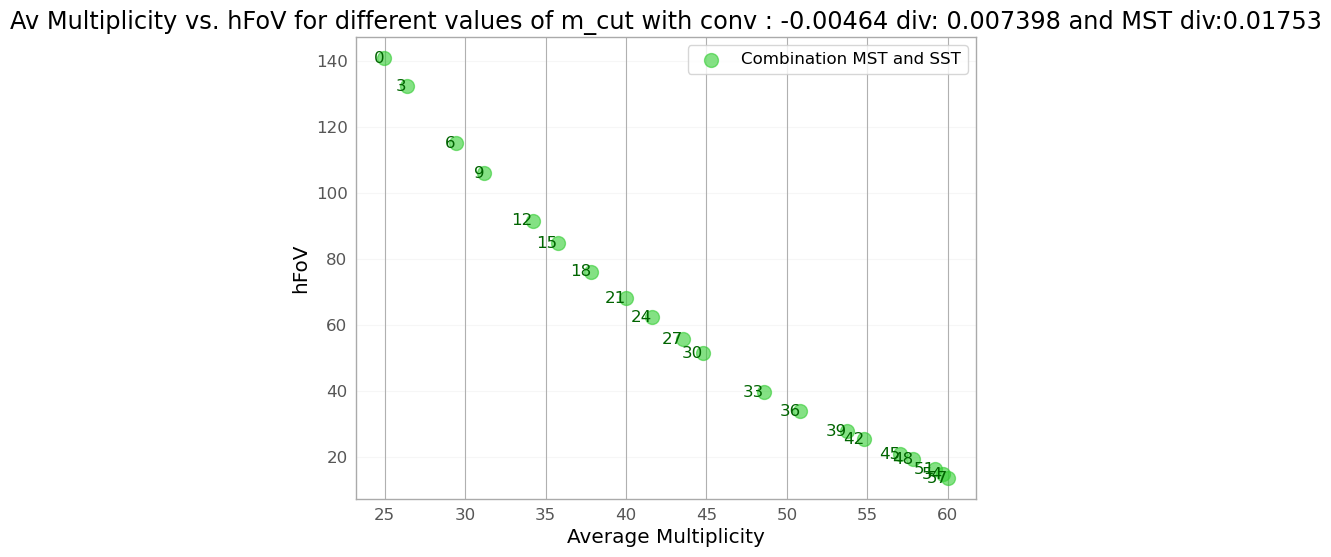

the barycenter for the calculations[-0.67307692  0.         27.68615385]
the barycenter for the calculations of the second divergence[-0.67307692  0.         27.68615385]
0


6it [00:00,  7.05it/s]
7it [00:00,  7.43it/s]
4it [00:00,  7.16it/s]
6it [00:00,  7.21it/s]
7it [00:00,  7.42it/s]
4it [00:00,  7.34it/s]


(152.65964568598739, 23.01202645820806)


6it [00:00,  7.18it/s]
7it [00:00,  7.40it/s]
4it [00:00,  7.27it/s]


3


6it [00:00,  7.31it/s]
7it [00:00,  7.37it/s]
4it [00:00,  7.11it/s]
6it [00:00,  7.09it/s]
7it [00:00,  7.47it/s]
4it [00:00,  7.35it/s]


(142.50943816421483, 24.437379221496272)


6it [00:00,  7.35it/s]
7it [00:00,  7.48it/s]
4it [00:00,  7.38it/s]


6


6it [00:00,  7.28it/s]
7it [00:00,  7.11it/s]
4it [00:00,  7.24it/s]
6it [00:00,  7.17it/s]
7it [00:01,  6.91it/s]
4it [00:00,  7.00it/s]


(122.86472128099096, 27.38531326715765)


6it [00:00,  7.06it/s]
7it [00:00,  7.30it/s]
4it [00:00,  7.14it/s]


9


6it [00:00,  6.95it/s]
7it [00:00,  7.21it/s]
4it [00:00,  6.21it/s]
6it [00:00,  6.76it/s]
7it [00:01,  6.87it/s]
4it [00:00,  6.39it/s]


(111.75719444514942, 29.21262614409763)


6it [00:00,  6.86it/s]
7it [00:01,  6.97it/s]
4it [00:00,  6.89it/s]


12


6it [00:00,  6.76it/s]
7it [00:01,  6.73it/s]
4it [00:00,  6.73it/s]
6it [00:00,  7.19it/s]
7it [00:00,  7.19it/s]
4it [00:00,  7.21it/s]


(97.04332772754115, 31.82918918918919)


6it [00:00,  7.16it/s]
7it [00:00,  7.15it/s]
4it [00:00,  7.17it/s]


15


6it [00:00,  7.36it/s]
7it [00:00,  7.43it/s]
4it [00:00,  7.33it/s]
6it [00:00,  7.33it/s]
7it [00:00,  7.42it/s]
4it [00:00,  7.29it/s]


(88.76841694428731, 33.430196483971045)


6it [00:00,  7.18it/s]
7it [00:00,  7.47it/s]
4it [00:00,  7.26it/s]


18


6it [00:00,  7.43it/s]
7it [00:00,  7.42it/s]
4it [00:00,  7.30it/s]
6it [00:00,  7.07it/s]
7it [00:00,  7.30it/s]
4it [00:00,  7.24it/s]


(77.63466218203293, 35.75320945945946)


6it [00:00,  7.33it/s]
7it [00:00,  7.46it/s]
4it [00:00,  7.34it/s]


21


6it [00:00,  7.41it/s]
7it [00:00,  7.43it/s]
4it [00:00,  7.30it/s]
6it [00:00,  7.25it/s]
7it [00:00,  7.40it/s]
4it [00:00,  7.32it/s]


(68.57291360639361, 37.90284949321094)


6it [00:00,  7.05it/s]
7it [00:00,  7.27it/s]
4it [00:00,  7.34it/s]


24


6it [00:00,  7.30it/s]
7it [00:00,  7.34it/s]
4it [00:00,  7.40it/s]
6it [00:00,  7.12it/s]
7it [00:00,  7.35it/s]
4it [00:00,  7.35it/s]


(61.75365273905288, 39.647908260777236)


6it [00:00,  7.22it/s]
7it [00:00,  7.48it/s]
4it [00:00,  7.27it/s]


27


6it [00:00,  7.40it/s]
7it [00:00,  7.44it/s]
4it [00:00,  7.41it/s]
6it [00:00,  7.26it/s]
7it [00:00,  7.41it/s]
4it [00:00,  6.94it/s]


(53.229576654876965, 41.90022172949002)


6it [00:00,  6.97it/s]
7it [00:00,  7.15it/s]
4it [00:00,  6.76it/s]


30


6it [00:00,  6.83it/s]
7it [00:01,  6.71it/s]
4it [00:00,  5.60it/s]
6it [00:01,  4.76it/s]
7it [00:01,  6.13it/s]
4it [00:00,  6.62it/s]


(48.84951294393119, 43.08751677852349)


6it [00:00,  6.34it/s]
7it [00:01,  6.96it/s]
4it [00:00,  6.89it/s]


33


6it [00:00,  6.73it/s]
7it [00:01,  6.80it/s]
4it [00:00,  6.47it/s]
6it [00:00,  6.50it/s]
7it [00:01,  6.75it/s]
4it [00:00,  7.10it/s]


(35.4601565101718, 47.27921597633136)


6it [00:00,  6.85it/s]
7it [00:01,  6.64it/s]
4it [00:00,  6.69it/s]


36


6it [00:00,  6.83it/s]
7it [00:01,  6.98it/s]
4it [00:00,  6.82it/s]
6it [00:00,  6.67it/s]
7it [00:01,  6.81it/s]
4it [00:00,  7.16it/s]


(29.637556846519328, 49.69203539823009)


6it [00:00,  6.99it/s]
7it [00:01,  6.72it/s]
4it [00:00,  6.63it/s]


39


6it [00:00,  6.59it/s]
7it [00:01,  6.58it/s]
4it [00:00,  6.59it/s]
6it [00:00,  6.64it/s]
7it [00:01,  6.92it/s]
4it [00:00,  6.68it/s]


(23.565791881944794, 52.68948247078464)


6it [00:00,  6.77it/s]
7it [00:01,  6.62it/s]
4it [00:00,  6.53it/s]


42


6it [00:00,  6.44it/s]
7it [00:01,  6.67it/s]
4it [00:00,  6.69it/s]
6it [00:00,  6.61it/s]
7it [00:01,  6.57it/s]
4it [00:00,  6.59it/s]


(21.021683019898443, 54.069868995633186)


6it [00:00,  6.54it/s]
7it [00:01,  6.61it/s]
4it [00:00,  6.55it/s]


45


6it [00:00,  6.45it/s]
7it [00:01,  6.51it/s]
4it [00:00,  6.40it/s]
6it [00:00,  6.50it/s]
7it [00:01,  6.65it/s]
4it [00:00,  6.56it/s]


(16.812100830636183, 56.48517940717629)


6it [00:00,  6.40it/s]
7it [00:01,  6.37it/s]
4it [00:00,  6.44it/s]


48


6it [00:00,  6.59it/s]
7it [00:01,  6.45it/s]
4it [00:00,  6.38it/s]
6it [00:01,  5.88it/s]
7it [00:01,  6.29it/s]
4it [00:00,  6.16it/s]


(15.146627503420275, 57.47792207792208)


6it [00:00,  6.48it/s]
7it [00:01,  6.40it/s]
4it [00:00,  6.51it/s]


51


6it [00:00,  6.54it/s]
7it [00:01,  6.45it/s]
4it [00:00,  6.84it/s]
6it [00:00,  6.48it/s]
7it [00:01,  6.69it/s]
4it [00:00,  6.50it/s]


(12.458265046103257, 58.97157894736842)


6it [00:00,  6.39it/s]
7it [00:01,  6.80it/s]
4it [00:00,  6.78it/s]


54


6it [00:00,  6.29it/s]
7it [00:01,  6.49it/s]
4it [00:00,  6.61it/s]
6it [00:00,  6.88it/s]
7it [00:00,  7.01it/s]
4it [00:00,  6.90it/s]


(11.041957019809413, 59.63895486935867)


6it [00:00,  7.05it/s]
7it [00:00,  7.16it/s]
4it [00:00,  7.11it/s]


57


6it [00:00,  7.01it/s]
7it [00:00,  7.25it/s]
4it [00:00,  7.18it/s]
6it [00:00,  7.11it/s]
7it [00:01,  6.99it/s]
4it [00:00,  7.28it/s]


(9.835472404818361, 60.0)


6it [00:00,  7.21it/s]
7it [00:00,  7.10it/s]
4it [00:00,  6.95it/s]


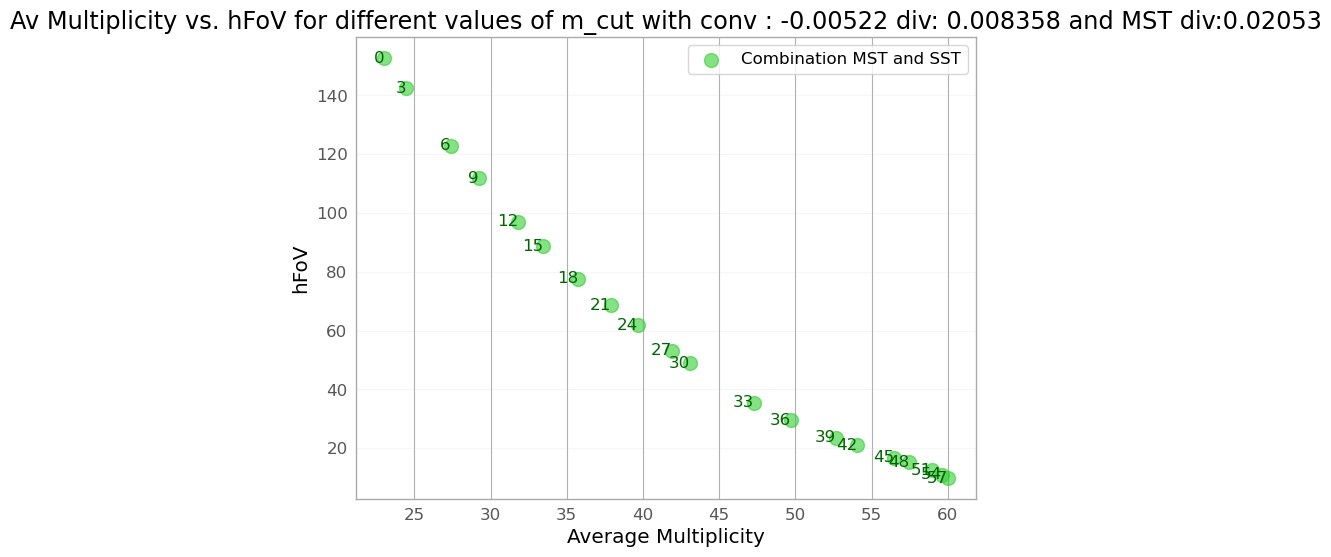

the barycenter for the calculations[-0.67307692  0.         27.68615385]
the barycenter for the calculations of the second divergence[-0.67307692  0.         27.68615385]
0


6it [00:00,  7.14it/s]
7it [00:00,  7.26it/s]
4it [00:00,  7.34it/s]
6it [00:00,  7.01it/s]
7it [00:00,  7.27it/s]
4it [00:00,  7.28it/s]


(162.79673924455352, 21.569034960528434)


6it [00:00,  7.17it/s]
7it [00:00,  7.25it/s]
4it [00:00,  7.27it/s]


3


6it [00:00,  7.34it/s]
7it [00:00,  7.27it/s]
4it [00:00,  7.04it/s]
6it [00:00,  7.20it/s]
7it [00:00,  7.13it/s]
4it [00:00,  7.36it/s]


(151.09908406442287, 23.006596077069954)


6it [00:00,  7.26it/s]
7it [00:00,  7.42it/s]
4it [00:00,  7.20it/s]


6


6it [00:00,  7.23it/s]
7it [00:00,  7.37it/s]
4it [00:00,  7.41it/s]
6it [00:00,  7.03it/s]
7it [00:00,  7.44it/s]
4it [00:00,  7.29it/s]


(129.93314744925377, 25.776947920872022)


6it [00:00,  7.16it/s]
7it [00:00,  7.03it/s]
4it [00:00,  6.74it/s]


9


6it [00:00,  6.46it/s]
7it [00:01,  6.30it/s]
4it [00:00,  6.88it/s]
6it [00:00,  6.89it/s]
7it [00:01,  6.82it/s]
4it [00:00,  6.59it/s]


(117.39619862391196, 27.56858802502234)


6it [00:00,  6.65it/s]
7it [00:01,  6.97it/s]
4it [00:00,  6.79it/s]


12


6it [00:00,  6.74it/s]
7it [00:01,  6.61it/s]
4it [00:00,  7.04it/s]
6it [00:00,  6.69it/s]
7it [00:01,  6.70it/s]
4it [00:00,  6.72it/s]


(102.39382471576235, 29.867571721311474)


6it [00:00,  6.51it/s]
7it [00:01,  6.86it/s]
4it [00:00,  6.77it/s]


15


6it [00:00,  6.63it/s]
7it [00:01,  6.68it/s]
4it [00:00,  6.80it/s]
6it [00:00,  6.71it/s]
7it [00:01,  6.64it/s]
4it [00:00,  7.11it/s]


(92.23050323078337, 31.555381771647944)


6it [00:00,  6.95it/s]
7it [00:00,  7.20it/s]
4it [00:00,  7.01it/s]


18


6it [00:00,  6.78it/s]
7it [00:01,  6.76it/s]
4it [00:00,  7.18it/s]
6it [00:00,  7.01it/s]
7it [00:00,  7.07it/s]
4it [00:00,  7.28it/s]


(78.56575356968906, 34.069270572525454)


6it [00:00,  7.10it/s]
7it [00:00,  7.34it/s]
4it [00:00,  7.10it/s]


21


6it [00:00,  7.19it/s]
7it [00:00,  7.20it/s]
4it [00:00,  7.28it/s]
6it [00:00,  7.14it/s]
7it [00:01,  6.91it/s]
4it [00:00,  7.41it/s]


(68.8351928705221, 36.14421794627548)


6it [00:00,  7.20it/s]
7it [00:00,  7.19it/s]
4it [00:00,  7.35it/s]


24


6it [00:00,  7.12it/s]
7it [00:00,  7.27it/s]
4it [00:00,  7.27it/s]
6it [00:00,  7.24it/s]
7it [00:00,  7.28it/s]
4it [00:00,  7.28it/s]


(60.79633342498389, 37.997195858498706)


6it [00:00,  7.15it/s]
7it [00:00,  7.31it/s]
4it [00:00,  7.13it/s]


27


6it [00:00,  7.18it/s]
7it [00:00,  7.16it/s]
4it [00:00,  6.93it/s]
6it [00:00,  7.15it/s]
7it [00:00,  7.27it/s]
4it [00:00,  7.15it/s]


(50.6198979767985, 40.48834196891192)


6it [00:00,  7.23it/s]
7it [00:00,  7.31it/s]
4it [00:00,  7.41it/s]


30


6it [00:00,  7.11it/s]
7it [00:00,  7.34it/s]
4it [00:00,  7.26it/s]
6it [00:00,  7.04it/s]
7it [00:00,  7.24it/s]
4it [00:00,  7.10it/s]


(45.89887122248568, 41.69828571428572)


6it [00:00,  7.12it/s]
7it [00:00,  7.25it/s]
4it [00:00,  7.17it/s]


33


6it [00:00,  7.17it/s]
7it [00:00,  7.46it/s]
4it [00:00,  7.44it/s]
6it [00:00,  7.18it/s]
7it [00:00,  7.06it/s]
4it [00:00,  7.05it/s]


(31.775132849166518, 46.01361947998349)


6it [00:00,  7.21it/s]
7it [00:00,  7.31it/s]
4it [00:00,  7.10it/s]


36


6it [00:00,  7.03it/s]
7it [00:01,  6.91it/s]
4it [00:00,  6.65it/s]
6it [00:00,  6.72it/s]
7it [00:01,  6.84it/s]
4it [00:00,  6.74it/s]


(25.69025392138556, 48.62429811128126)


6it [00:01,  5.95it/s]
7it [00:01,  6.98it/s]
4it [00:00,  6.68it/s]


39


6it [00:00,  6.97it/s]
7it [00:01,  6.89it/s]
4it [00:00,  7.01it/s]
6it [00:00,  6.98it/s]
7it [00:00,  7.27it/s]
4it [00:00,  7.05it/s]


(19.81519840490739, 51.75579086697552)


6it [00:00,  6.93it/s]
7it [00:00,  7.05it/s]
4it [00:00,  6.49it/s]


42


6it [00:00,  7.09it/s]
7it [00:00,  7.09it/s]
4it [00:00,  7.10it/s]
6it [00:00,  7.04it/s]
7it [00:01,  6.84it/s]
4it [00:00,  7.19it/s]


(17.17929180041607, 53.36335877862595)


6it [00:00,  7.19it/s]
7it [00:00,  7.20it/s]
4it [00:00,  7.23it/s]


45


6it [00:00,  7.15it/s]
7it [00:00,  7.04it/s]
4it [00:00,  7.33it/s]
6it [00:00,  7.03it/s]
7it [00:00,  7.41it/s]
4it [00:00,  7.32it/s]


(13.323786617727272, 55.95275590551181)


6it [00:00,  7.12it/s]
7it [00:00,  7.23it/s]
4it [00:00,  7.37it/s]


48


6it [00:00,  7.11it/s]
7it [00:00,  7.36it/s]
4it [00:00,  7.33it/s]
6it [00:00,  7.19it/s]
7it [00:00,  7.12it/s]
4it [00:00,  7.34it/s]


(11.750111032956335, 57.09375)


6it [00:00,  7.05it/s]
7it [00:00,  7.24it/s]
4it [00:00,  7.04it/s]


51


6it [00:00,  7.28it/s]
7it [00:00,  7.28it/s]
4it [00:00,  7.13it/s]
6it [00:00,  7.19it/s]
7it [00:00,  7.43it/s]
4it [00:00,  7.01it/s]


(9.310913876561381, 58.81267605633803)


6it [00:00,  7.05it/s]
7it [00:00,  7.24it/s]
4it [00:00,  7.14it/s]


54


6it [00:00,  6.98it/s]
7it [00:00,  7.39it/s]
4it [00:00,  7.21it/s]
6it [00:00,  7.13it/s]
7it [00:00,  7.23it/s]
4it [00:00,  7.11it/s]


(8.31425267287312, 59.41955835962145)


6it [00:00,  7.23it/s]
7it [00:00,  7.29it/s]
4it [00:00,  7.15it/s]


57


6it [00:00,  7.20it/s]
7it [00:00,  7.30it/s]
4it [00:00,  7.21it/s]
6it [00:00,  7.17it/s]
7it [00:00,  7.45it/s]
4it [00:00,  7.43it/s]


(6.8848306833728525, 60.0)


6it [00:00,  7.37it/s]
7it [00:00,  7.46it/s]
4it [00:00,  7.21it/s]


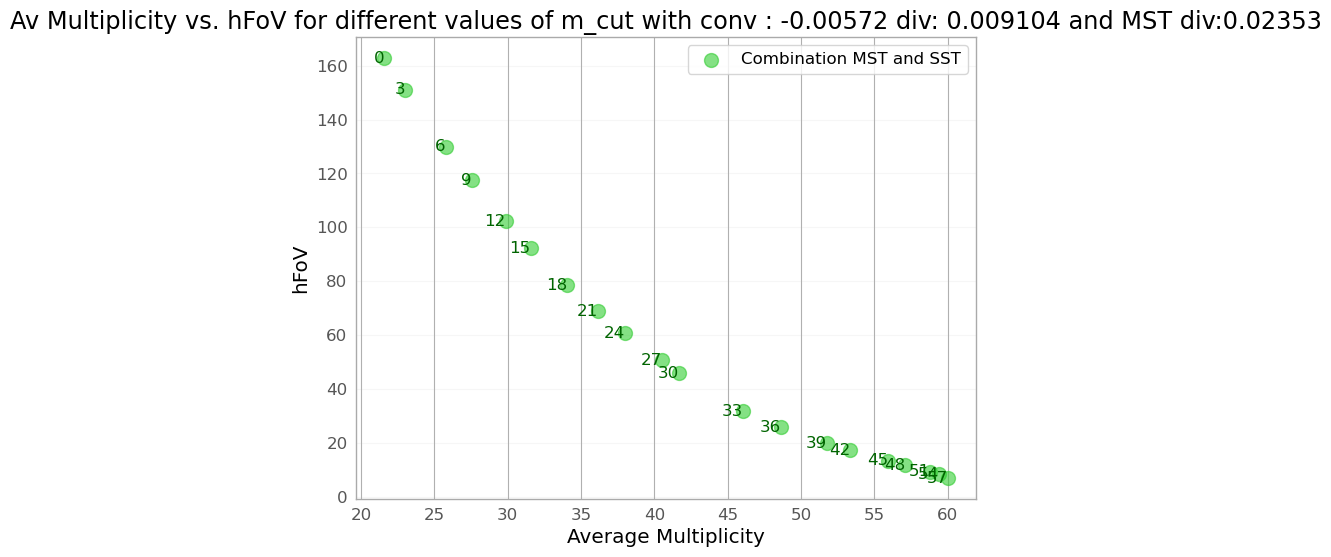

the barycenter for the calculations[-0.67307692  0.         27.68615385]
the barycenter for the calculations of the second divergence[-0.67307692  0.         27.68615385]
0


6it [00:00,  7.32it/s]
7it [00:00,  7.16it/s]
4it [00:00,  7.27it/s]
6it [00:00,  7.28it/s]
7it [00:00,  7.38it/s]
4it [00:00,  7.24it/s]


(175.53039751799167, 20.004109077325364)


6it [00:00,  7.23it/s]
7it [00:00,  7.47it/s]
4it [00:00,  7.19it/s]


3


6it [00:00,  7.29it/s]
7it [00:00,  7.41it/s]
4it [00:00,  7.41it/s]
6it [00:00,  7.27it/s]
7it [00:00,  7.25it/s]
4it [00:00,  6.90it/s]


(161.5509127399432, 21.475525610845036)


6it [00:00,  7.22it/s]
7it [00:00,  7.24it/s]
4it [00:00,  7.31it/s]


6


6it [00:00,  7.18it/s]
7it [00:00,  7.25it/s]
4it [00:00,  7.18it/s]
6it [00:00,  7.26it/s]
7it [00:00,  7.29it/s]
4it [00:00,  7.25it/s]


(138.60147712870034, 24.037941148642254)


6it [00:00,  7.28it/s]
7it [00:00,  7.41it/s]
4it [00:00,  7.46it/s]


9


6it [00:00,  7.25it/s]
7it [00:00,  7.22it/s]
4it [00:00,  7.00it/s]
6it [00:00,  7.26it/s]
7it [00:00,  7.32it/s]
4it [00:00,  7.41it/s]


(123.50730547810576, 25.87576980250584)


6it [00:00,  7.30it/s]
7it [00:00,  7.30it/s]
4it [00:00,  7.29it/s]


12


6it [00:00,  7.15it/s]
7it [00:00,  7.51it/s]
4it [00:00,  7.16it/s]
6it [00:00,  7.35it/s]
7it [00:00,  7.48it/s]
4it [00:00,  7.43it/s]


(107.49515640306147, 27.975600829571796)


6it [00:00,  7.26it/s]
7it [00:01,  6.86it/s]
4it [00:00,  6.82it/s]


15


6it [00:00,  6.50it/s]
7it [00:01,  6.63it/s]
4it [00:00,  6.60it/s]
6it [00:00,  6.67it/s]
7it [00:01,  6.84it/s]
4it [00:00,  6.53it/s]


(95.05000532016464, 29.739100441501105)


6it [00:00,  6.59it/s]
7it [00:01,  6.76it/s]
4it [00:00,  6.80it/s]


18


6it [00:00,  6.64it/s]
7it [00:01,  6.91it/s]
4it [00:00,  6.36it/s]
6it [00:00,  7.00it/s]
7it [00:01,  6.78it/s]
4it [00:00,  7.09it/s]


(79.26079361962957, 32.27779616148246)


6it [00:00,  6.66it/s]
7it [00:01,  7.00it/s]
4it [00:00,  7.21it/s]


21


6it [00:00,  7.25it/s]
7it [00:00,  7.26it/s]
4it [00:00,  7.19it/s]
6it [00:00,  7.18it/s]
7it [00:00,  7.09it/s]
4it [00:00,  7.21it/s]


(68.76962305448998, 34.257246376811594)


6it [00:00,  7.17it/s]
7it [00:00,  7.37it/s]
4it [00:00,  7.35it/s]


24


6it [00:00,  6.01it/s]
7it [00:00,  7.13it/s]
4it [00:00,  7.23it/s]
6it [00:00,  7.09it/s]
7it [00:01,  6.99it/s]
4it [00:00,  7.30it/s]


(59.4062533251029, 36.161810154525384)


6it [00:00,  6.90it/s]
7it [00:00,  7.21it/s]
4it [00:00,  7.08it/s]


27


6it [00:00,  7.22it/s]
7it [00:00,  7.30it/s]
4it [00:00,  7.37it/s]
6it [00:00,  7.24it/s]
7it [00:00,  7.26it/s]
4it [00:00,  7.00it/s]


(47.197153579921704, 38.88830230619617)


6it [00:00,  7.30it/s]
7it [00:00,  7.25it/s]
4it [00:00,  7.14it/s]


30


6it [00:00,  7.22it/s]
7it [00:00,  7.22it/s]
4it [00:00,  7.18it/s]
6it [00:00,  7.18it/s]
7it [00:00,  7.19it/s]
4it [00:00,  7.35it/s]


(41.663061106810574, 40.22442555870318)


6it [00:00,  7.25it/s]
7it [00:00,  7.39it/s]
4it [00:00,  7.24it/s]


33


6it [00:00,  7.22it/s]
7it [00:00,  7.46it/s]
4it [00:00,  7.31it/s]
6it [00:00,  7.04it/s]
7it [00:00,  7.29it/s]
4it [00:00,  7.40it/s]


(27.06722005806013, 44.666666666666664)


6it [00:00,  7.07it/s]
7it [00:00,  7.24it/s]
4it [00:00,  7.41it/s]


36


6it [00:00,  7.30it/s]
7it [00:00,  7.16it/s]
4it [00:00,  7.41it/s]
6it [00:00,  7.11it/s]
7it [00:00,  7.48it/s]
4it [00:00,  7.45it/s]


(21.12659472554984, 47.38361266294227)


6it [00:00,  7.17it/s]
7it [00:00,  7.45it/s]
4it [00:00,  7.42it/s]


39


6it [00:00,  7.25it/s]
7it [00:00,  7.33it/s]
4it [00:00,  7.13it/s]
6it [00:00,  7.24it/s]
7it [00:00,  7.46it/s]
4it [00:00,  7.34it/s]


(15.894123406186472, 50.45874587458746)


6it [00:00,  7.37it/s]
7it [00:00,  7.40it/s]
4it [00:00,  7.13it/s]


42


6it [00:00,  7.19it/s]
7it [00:00,  7.19it/s]
4it [00:00,  7.33it/s]
6it [00:00,  7.26it/s]
7it [00:00,  7.44it/s]
4it [00:00,  7.30it/s]


(12.838569979089566, 52.643513789581206)


6it [00:00,  7.36it/s]
7it [00:00,  7.42it/s]
4it [00:00,  7.25it/s]


45


6it [00:00,  7.32it/s]
7it [00:00,  7.30it/s]
4it [00:00,  7.40it/s]
6it [00:00,  7.15it/s]
7it [00:00,  7.28it/s]
4it [00:00,  7.44it/s]


(9.730560699166965, 55.27358490566038)


6it [00:00,  7.30it/s]
7it [00:00,  7.27it/s]
4it [00:00,  7.38it/s]


48


6it [00:00,  6.98it/s]
7it [00:00,  7.15it/s]
4it [00:00,  6.89it/s]
6it [00:00,  6.99it/s]
7it [00:01,  6.79it/s]
4it [00:00,  6.75it/s]


(8.327366636079546, 56.59055118110236)


6it [00:00,  6.94it/s]
7it [00:00,  7.09it/s]
4it [00:00,  6.96it/s]


51


6it [00:00,  6.82it/s]
7it [00:00,  7.06it/s]
4it [00:00,  6.72it/s]
6it [00:00,  7.08it/s]
7it [00:01,  6.74it/s]
4it [00:00,  6.94it/s]


(6.478297823973693, 58.325910931174086)


6it [00:00,  6.78it/s]
7it [00:01,  6.92it/s]
4it [00:00,  6.71it/s]


54


6it [00:00,  6.51it/s]
7it [00:01,  6.77it/s]
4it [00:00,  6.46it/s]
6it [00:00,  6.63it/s]
7it [00:01,  6.87it/s]
4it [00:00,  6.77it/s]


(5.534092473111131, 59.11374407582938)


6it [00:00,  6.79it/s]
7it [00:01,  6.83it/s]
4it [00:00,  6.58it/s]


57


6it [00:00,  6.88it/s]
7it [00:01,  6.67it/s]
4it [00:00,  6.76it/s]
6it [00:00,  6.73it/s]
7it [00:01,  6.61it/s]
4it [00:00,  6.70it/s]


(4.078442557198014, 60.0)


6it [00:00,  6.73it/s]
7it [00:01,  5.73it/s]
4it [00:00,  6.44it/s]


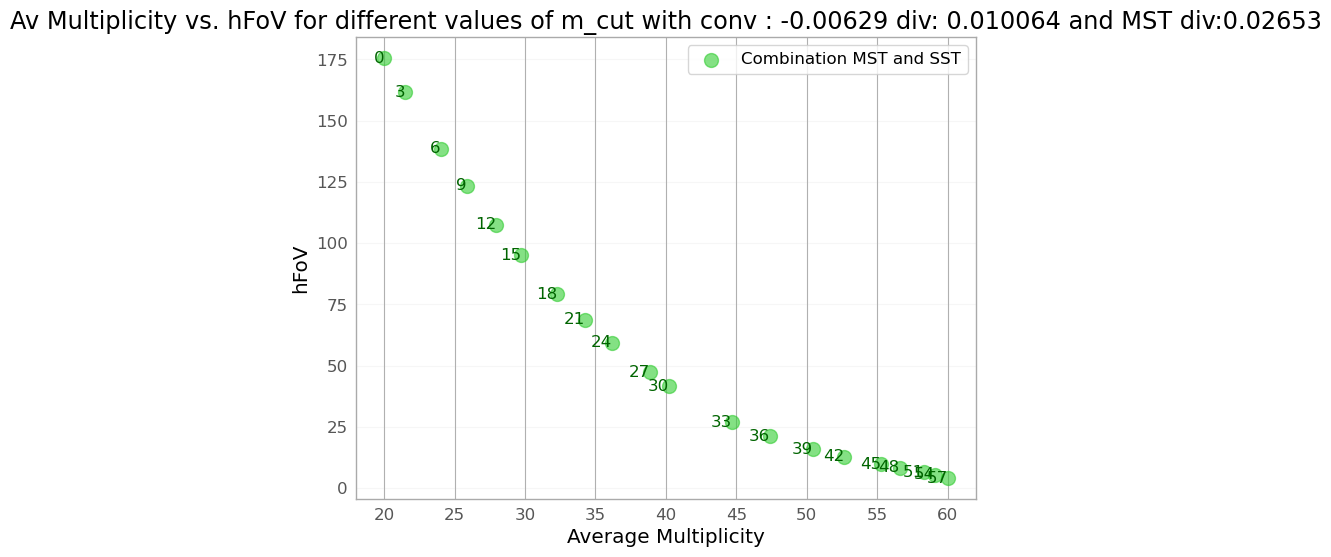

the barycenter for the calculations[-0.67307692  0.         27.68615385]
the barycenter for the calculations of the second divergence[-0.67307692  0.         27.68615385]
0


6it [00:00,  6.42it/s]
7it [00:01,  6.56it/s]
4it [00:00,  6.52it/s]
6it [00:00,  6.81it/s]
7it [00:01,  6.78it/s]
4it [00:00,  6.63it/s]


(188.09357426974634, 18.670222408143346)


6it [00:00,  6.49it/s]
7it [00:01,  6.23it/s]
4it [00:00,  6.57it/s]


3


6it [00:00,  6.65it/s]
7it [00:01,  6.53it/s]
4it [00:00,  6.44it/s]
6it [00:00,  6.69it/s]
7it [00:01,  6.61it/s]
4it [00:00,  6.68it/s]


(172.1207670843213, 20.124419047619046)


6it [00:00,  6.56it/s]
7it [00:01,  6.65it/s]
4it [00:00,  6.61it/s]


6


6it [00:00,  6.41it/s]
7it [00:01,  6.35it/s]
4it [00:00,  6.69it/s]
6it [00:00,  6.52it/s]
7it [00:01,  6.68it/s]
4it [00:00,  6.16it/s]


(147.44028832983045, 22.48874855465623)


6it [00:00,  6.55it/s]
7it [00:01,  6.41it/s]
4it [00:00,  6.73it/s]


9


6it [00:00,  6.57it/s]
7it [00:01,  6.49it/s]
4it [00:00,  6.42it/s]
6it [00:00,  6.72it/s]
7it [00:01,  6.49it/s]
4it [00:00,  6.45it/s]


(129.76266592757023, 24.32632642748863)


6it [00:00,  6.46it/s]
7it [00:01,  6.69it/s]
4it [00:00,  6.51it/s]


12


6it [00:00,  6.58it/s]
7it [00:01,  6.64it/s]
4it [00:00,  5.38it/s]
6it [00:00,  6.17it/s]
7it [00:01,  6.42it/s]
4it [00:00,  6.30it/s]


(112.32109486302568, 26.28990075890251)


6it [00:00,  6.28it/s]
7it [00:01,  6.54it/s]
4it [00:00,  6.19it/s]


15


6it [00:00,  6.23it/s]
7it [00:01,  6.27it/s]
4it [00:00,  6.37it/s]
6it [00:00,  6.40it/s]
7it [00:01,  6.47it/s]
4it [00:00,  6.52it/s]


(97.2269232124311, 28.128945238737522)


6it [00:00,  6.36it/s]
7it [00:01,  6.52it/s]
4it [00:00,  6.42it/s]


18


6it [00:01,  5.68it/s]
7it [00:01,  6.33it/s]
4it [00:00,  6.54it/s]
6it [00:00,  6.41it/s]
7it [00:01,  6.46it/s]
4it [00:00,  6.48it/s]


(79.26079361962957, 30.674718729318332)


6it [00:00,  6.34it/s]
7it [00:01,  6.56it/s]
4it [00:00,  6.44it/s]


21


6it [00:00,  6.47it/s]
7it [00:01,  6.43it/s]
4it [00:00,  6.46it/s]
6it [00:00,  6.30it/s]
7it [00:01,  6.58it/s]
4it [00:00,  6.16it/s]


(68.53357171677433, 32.46727898966705)


6it [00:00,  6.22it/s]
7it [00:01,  6.59it/s]
4it [00:00,  6.31it/s]


24


6it [00:00,  6.30it/s]
7it [00:01,  6.52it/s]
4it [00:00,  6.37it/s]
6it [00:00,  6.20it/s]
7it [00:01,  6.18it/s]
4it [00:00,  5.90it/s]


(57.5834124394099, 34.41630608061945)


6it [00:01,  5.72it/s]
7it [00:01,  5.45it/s]
4it [00:00,  4.27it/s]


27


6it [00:01,  3.23it/s]
7it [00:02,  2.58it/s]
4it [00:01,  2.27it/s]
6it [00:03,  1.63it/s]
7it [00:02,  2.34it/s]
4it [00:01,  2.43it/s]


(43.05314120669157, 37.37435272616509)


6it [00:02,  2.53it/s]
7it [00:00,  7.18it/s]
4it [00:00,  7.15it/s]


30


6it [00:00,  7.16it/s]
7it [00:00,  7.51it/s]
4it [00:00,  7.40it/s]
6it [00:00,  7.31it/s]
7it [00:00,  7.22it/s]
4it [00:00,  7.27it/s]


(36.75843886760782, 38.832679272208345)


6it [00:00,  7.26it/s]
7it [00:00,  7.48it/s]
4it [00:00,  7.27it/s]


33


6it [00:00,  7.30it/s]
7it [00:00,  7.33it/s]
4it [00:00,  7.52it/s]
6it [00:00,  7.18it/s]
7it [00:00,  7.41it/s]
4it [00:00,  7.33it/s]


(22.52978878863726, 43.15715948777648)


6it [00:00,  7.32it/s]
7it [00:00,  7.36it/s]
4it [00:00,  5.92it/s]


36


6it [00:00,  7.04it/s]
7it [00:00,  7.31it/s]
4it [00:00,  7.35it/s]
6it [00:00,  7.30it/s]
7it [00:00,  7.28it/s]
4it [00:00,  7.34it/s]


(16.523593640094845, 46.128571428571426)


6it [00:00,  6.74it/s]
7it [00:01,  6.45it/s]
4it [00:00,  6.51it/s]


39


6it [00:00,  6.15it/s]
7it [00:01,  6.20it/s]
4it [00:00,  4.74it/s]
6it [00:00,  6.54it/s]
7it [00:01,  6.85it/s]
4it [00:00,  6.97it/s]


(12.26155559800689, 48.940106951871655)


6it [00:00,  6.59it/s]
7it [00:01,  6.66it/s]
4it [00:00,  6.38it/s]


42


6it [00:01,  5.88it/s]
7it [00:01,  5.83it/s]
4it [00:00,  5.28it/s]
6it [00:01,  4.46it/s]
7it [00:01,  6.43it/s]
4it [00:00,  7.07it/s]


(8.904381017162223, 51.82916053019146)


6it [00:00,  7.31it/s]
7it [00:00,  7.20it/s]
4it [00:00,  7.18it/s]


45


6it [00:00,  7.13it/s]
7it [00:00,  7.31it/s]
4it [00:00,  7.50it/s]
6it [00:00,  7.23it/s]
7it [00:00,  7.39it/s]
4it [00:00,  7.33it/s]


(6.543867640005816, 54.50901803607214)


6it [00:00,  7.35it/s]
7it [00:00,  7.04it/s]
4it [00:00,  7.47it/s]


48


6it [00:00,  7.29it/s]
7it [00:00,  7.44it/s]
4it [00:00,  7.17it/s]
6it [00:00,  7.45it/s]
7it [00:01,  6.61it/s]
4it [00:00,  6.90it/s]


(5.481636620285433, 55.880382775119614)


6it [00:00,  7.28it/s]
7it [00:00,  7.08it/s]
4it [00:00,  7.31it/s]


51


6it [00:00,  6.89it/s]
7it [00:01,  6.89it/s]
4it [00:00,  6.58it/s]
6it [00:00,  6.49it/s]
7it [00:01,  6.27it/s]
4it [00:00,  6.52it/s]


(4.078442557198014, 57.72025723472669)


6it [00:00,  6.50it/s]
7it [00:01,  6.37it/s]
4it [00:00,  6.87it/s]


54


6it [00:00,  7.31it/s]
7it [00:00,  7.36it/s]
4it [00:00,  7.45it/s]
6it [00:00,  7.30it/s]
7it [00:00,  7.38it/s]
4it [00:00,  7.38it/s]


(3.3047187280189694, 58.66269841269841)


6it [00:00,  7.41it/s]
7it [00:00,  7.17it/s]
4it [00:00,  7.27it/s]


57


6it [00:00,  7.12it/s]
7it [00:00,  7.38it/s]
4it [00:00,  7.27it/s]
6it [00:00,  7.23it/s]
7it [00:00,  7.15it/s]
4it [00:00,  7.21it/s]


(2.0064363705829455, 60.0)


6it [00:00,  7.38it/s]
7it [00:00,  7.31it/s]
4it [00:00,  7.15it/s]


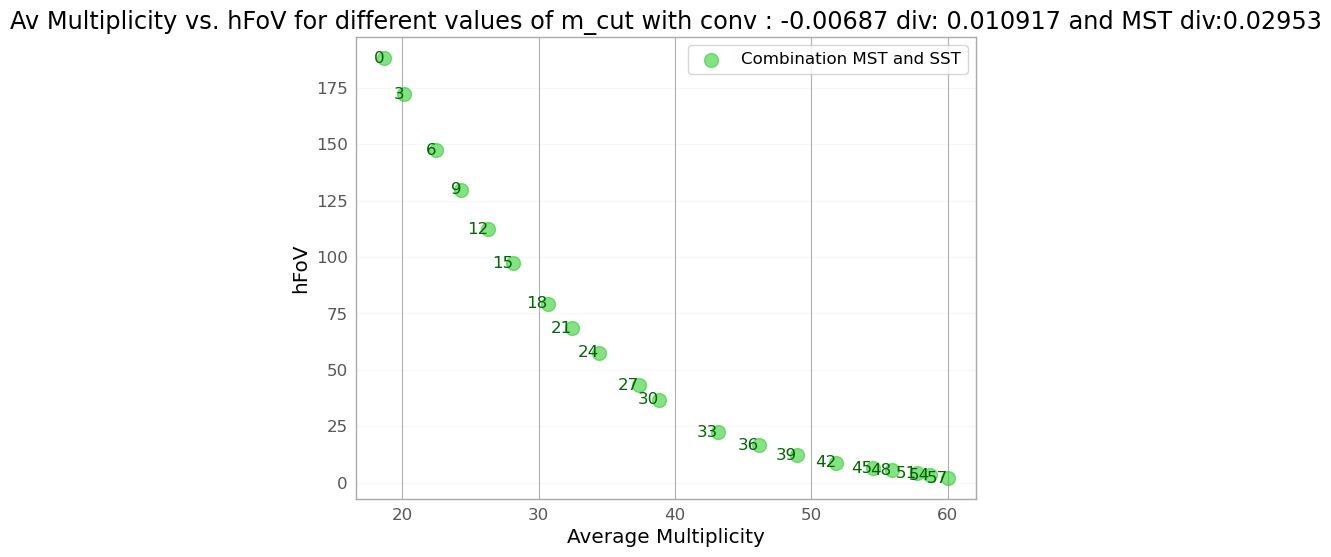

In [159]:
for i in range(10):
    config_MST.divergent_pointing(div_MST[i], az=0,alt=70)
    SST_config_conv.divergent_pointing_2_div(tel_group_2=SST_config_div, complete_array=full_array_config_SST, div1=conv_SST[i], div2=div_SST[i], az=0, alt=70)
    SST_config_conv.combination_bar_graph_av_mult_MST_and_SST(array_2=SST_config_div, array_3=config_MST,subarray_mult=number_of_telescopes_config_SST_first_half, subarray_mult_2=number_of_telescopes_config_SST_second_half, subarray_mult_3=number_of_telescopes_subarray_1)
    

In [ ]:
SST_config_div